In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-21 15:59:45.480921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 15:59:51.096820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-21 15:59:51.114126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [364]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [15]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [16]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [156]:
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [157]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
num_bots = 0 # bots iter.
num_humans = 0 # humans iter.

for index, record in users_df1.iterrows():
    if record['label']=='bot':
      num_bots += 1
    if record['label']=='human':
      num_humans += 1

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

In [ ]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [ ]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [ ]:
users_df = filter_df_for_balanced_classes(users_df2)

## Data preparation

In [ ]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [ ]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [ ]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [ ]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

In [ ]:
column_to_remove

In [ ]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [ ]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [ ]:
users_df

#### Null and NaN statistics

In [ ]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

#### Extract some information from dataframe to new columns

##### Description length

In [ ]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [ ]:
from datetime import datetime

In [ ]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [ ]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [ ]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

### Data type conversion (to float)

In [ ]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [ ]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [ ]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [ ]:
train_data.describe()

# Data analysis

In [ ]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [ ]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [ ]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

In [ ]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [ ]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*12 + ['Human']*12,
    'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             len(train_bot_data.loc[train_bot_data['has_location']==1]),
             len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             len(train_bot_data.loc[train_bot_data['has_location']==0]),
             len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             len(train_human_data.loc[train_human_data['has_location']==1]),
             len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             len(train_human_data.loc[train_human_data['has_location']==0]),
             len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

In [ ]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

In [ ]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [ ]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [ ]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [ ]:
len(train_data[(train_data['label']==1)])

In [ ]:
len(train_data[(train_data['label']==0)])

In [ ]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [ ]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [ ]:
len(df_filtered_bots)

In [ ]:
len(df_filtered_humans)

In [ ]:
len(df_reduced_outliers_followers_count) 

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [ ]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [ ]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [ ]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=100),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [ ]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [ ]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [ ]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [ ]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [ ]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [ ]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers (outdated version)

In [ ]:
# df_reduced_outliers_descr_len = df_99_percentile(df=train_data, column_name='descr_len')

In [ ]:
# fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Bot'),
# row=1, col=1
# )
# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Human'),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of values of training dataset column: descr_len',
#     xaxis_title_text='descr_len', #'feature',
#     yaxis_title_text='frequency',
#     bargap=0.2,
#     bargroupgap=None, #0.8,
#     width=1100,
#     height=350,
#     legend={"title":""},
#     xaxis=dict(showgrid=True, dtick=10),
#     xaxis2=dict(showgrid=True, dtick=10),
#     yaxis=dict(showgrid=True))

# fig.show()

### account_age

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [ ]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

### Create merged dataframe from reduced by columns outliers dataframes

In [ ]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_listed_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_hashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_cashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_mentions, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_url_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [ ]:
len(train_data)

In [ ]:
len(train_data_wo_outliers)

In [ ]:
train_data_wo_outliers

#### Drop 'id' column

In [ ]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [ ]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

In [ ]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

## Correlation

In [ ]:
sns.set(font_scale=2)

In [ ]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [ ]:
sns.set(font_scale=1)

In [ ]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

In [ ]:
train_data

In [ ]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [ ]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

In [ ]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [ ]:
sns.set(font_scale=2)

In [ ]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [350]:
high_corr2

[('followers_count', 'listed_count', 0.7439187863704089),
 ('has_description', 'descr_len', 0.7170368734557355),
 ('url_no_urls', 'descr_len', 0.5214407041020073)]

In [351]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [352]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [353]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [354]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [355]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [356]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [357]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [365]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

In [366]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                512       
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                

### batch_size=50, epochs=200

### Train model

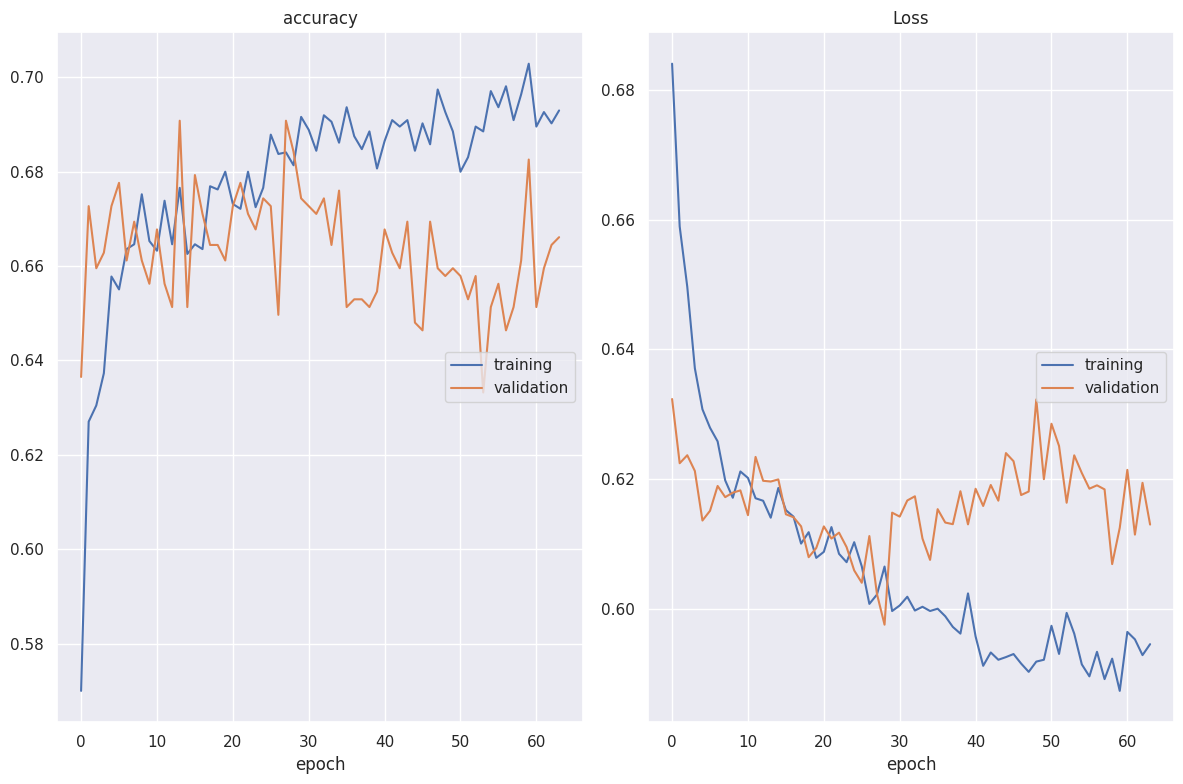

accuracy
	training         	 (min:    0.570, max:    0.703, cur:    0.693)
	validation       	 (min:    0.633, max:    0.691, cur:    0.666)
Loss
	training         	 (min:    0.587, max:    0.684, cur:    0.595)
	validation       	 (min:    0.598, max:    0.632, cur:    0.613)

Epoch 64: val_accuracy did not improve from 0.69079
59/59 [==============================] - 1s 13ms/step - loss: 0.5946 - accuracy: 0.6930 - val_loss: 0.6130 - val_accuracy: 0.6661


In [367]:
model_name = 'model_users_only_10000_1_v1_batch_size_50_epochs_200'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [368]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [369]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

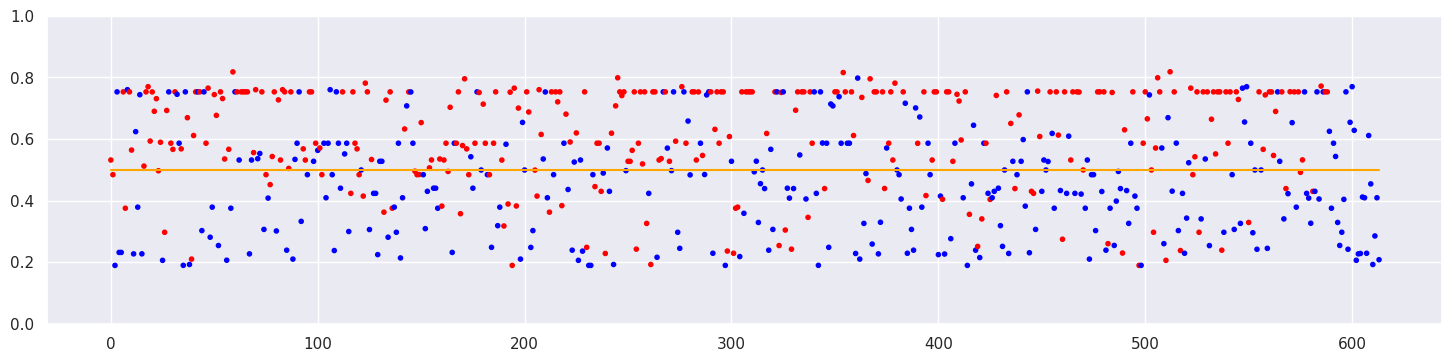

In [370]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.7019543973941368
Precision: [0.73134328 0.67919075]
Recall: 0.7654723127035831
F1 score: 0.719755
ROC AUC: 0.701954


(0.7019543973941368,
 array([0.73134328, 0.67919075]),
 0.7654723127035831,
 0.7197549770290965,
 0.7019543973941369)

<Figure size 640x480 with 0 Axes>

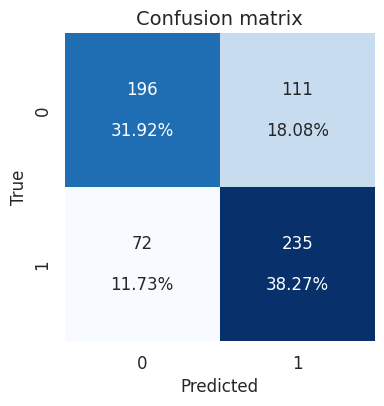

In [371]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

Accuracy: 0.725

Precision: [0.71061093 0.73860182]

Recall: 0.7297297297297297

F1 score: 0.734139

ROC AUC: 0.724800

Accuracy: 0.7109375

Precision: [0.69677419 0.72424242]

Recall: 0.7177177177177178

F1 score: 0.720965

ROC AUC: 0.710650

Accuracy: 0.7078125

Precision: [0.73809524 0.68814433]

Recall: 0.8018018018018018

F1 score: 0.740638

ROC AUC: 0.703832

Accuracy: 0.703125

Precision: [0.71428571 0.69482289]

Recall: 0.7657657657657657

F1 score: 0.728571

ROC AUC: 0.700472

### batch_size=100, epochs=200

#### Create and train model

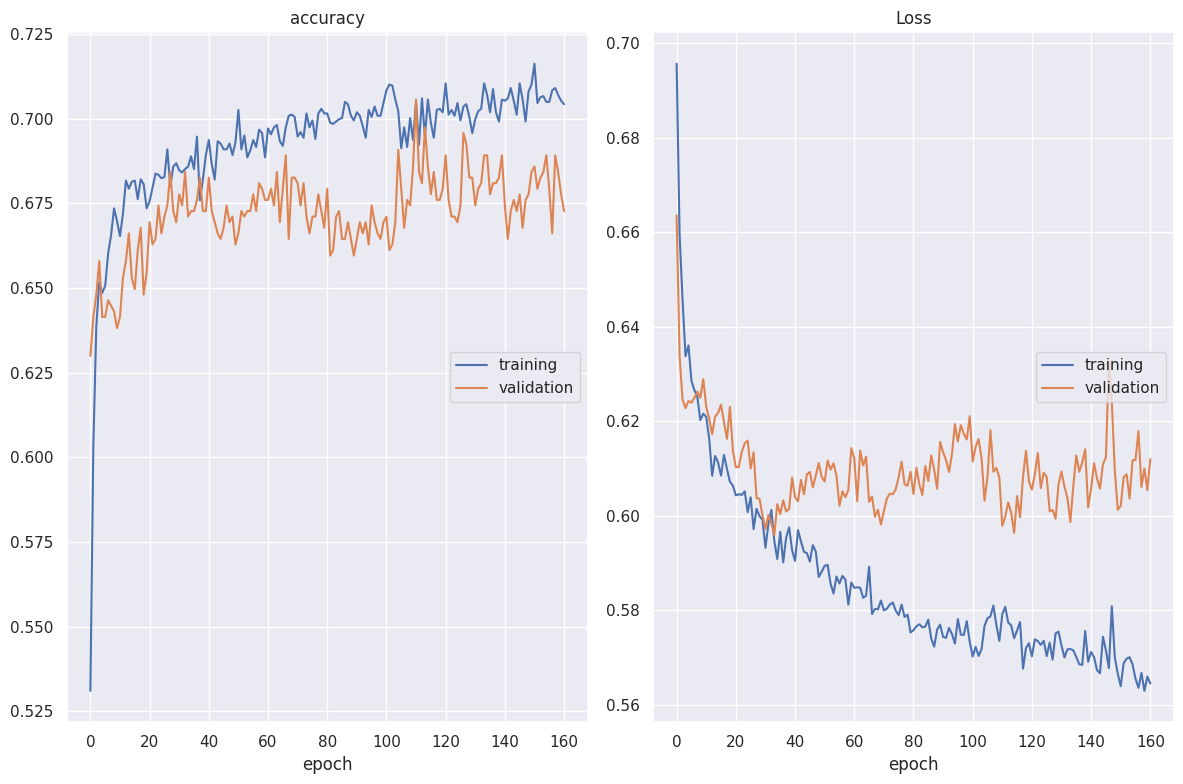

accuracy
	training         	 (min:    0.531, max:    0.716, cur:    0.704)
	validation       	 (min:    0.630, max:    0.706, cur:    0.673)
Loss
	training         	 (min:    0.563, max:    0.696, cur:    0.565)
	validation       	 (min:    0.596, max:    0.664, cur:    0.612)

Epoch 161: val_accuracy did not improve from 0.70559
30/30 [==============================] - 1s 26ms/step - loss: 0.5646 - accuracy: 0.7042 - val_loss: 0.6120 - val_accuracy: 0.6727


In [372]:
model_name = 'model_users_only_10000_1_v1_batch_size_100_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.7052117263843648
Precision: [0.725      0.68862275]
Recall: 0.749185667752443
F1 score: 0.717629
ROC AUC: 0.705212


(0.7052117263843648,
 array([0.725     , 0.68862275]),
 0.749185667752443,
 0.7176287051482059,
 0.7052117263843649)

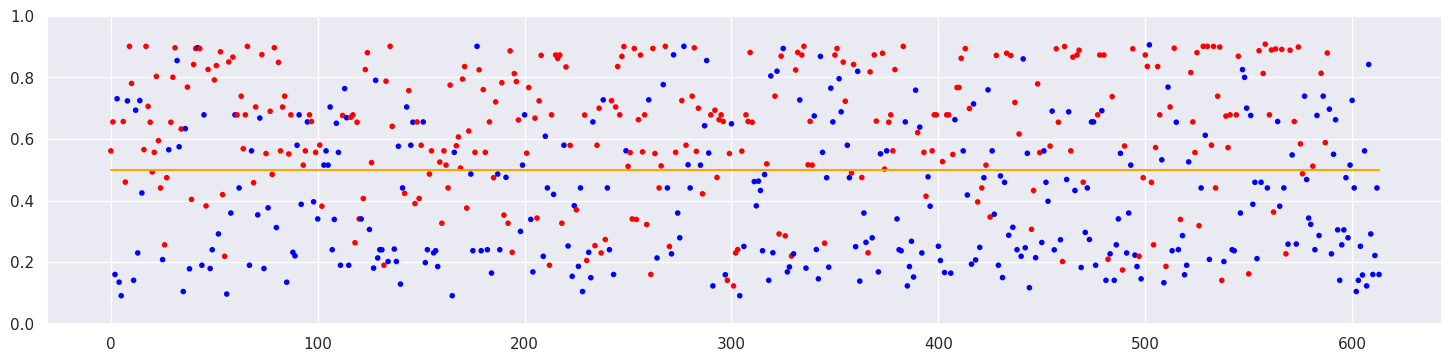

<Figure size 640x480 with 0 Axes>

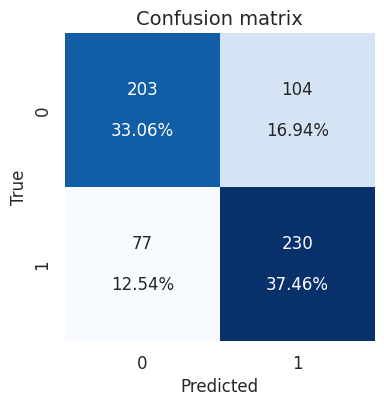

In [373]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

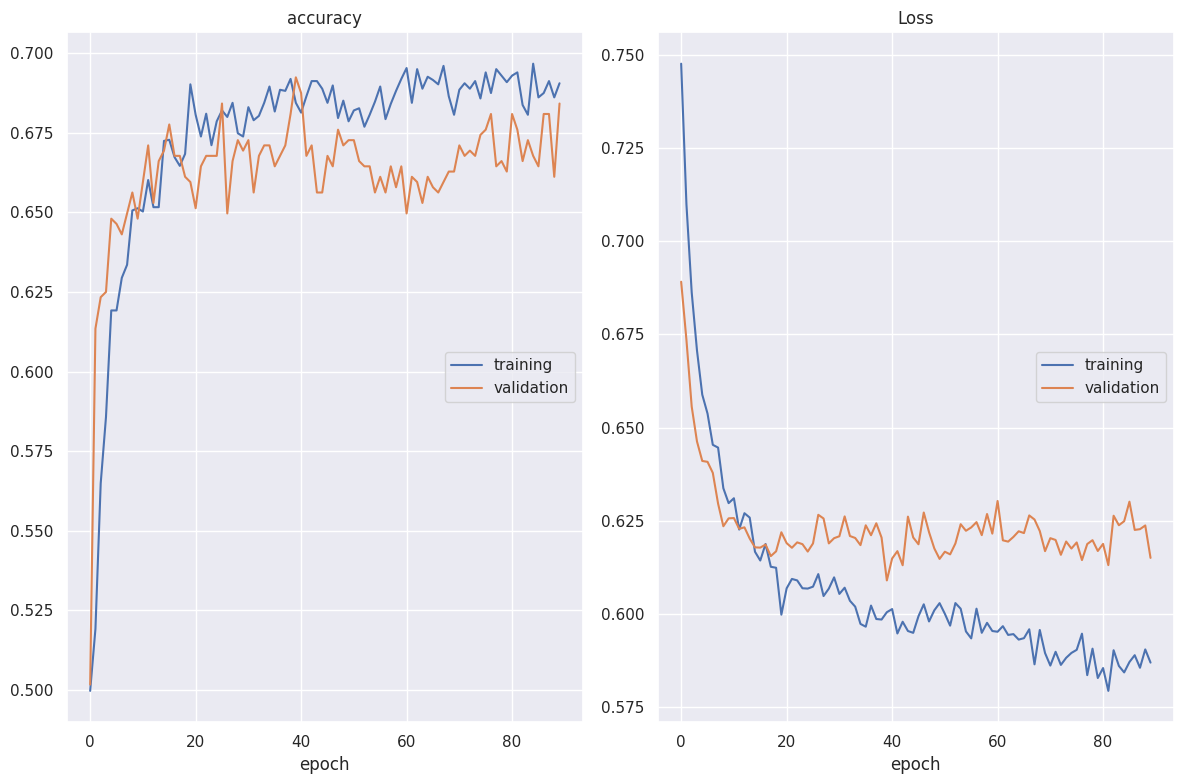

accuracy
	training         	 (min:    0.500, max:    0.697, cur:    0.691)
	validation       	 (min:    0.502, max:    0.692, cur:    0.684)
Loss
	training         	 (min:    0.579, max:    0.748, cur:    0.587)
	validation       	 (min:    0.609, max:    0.689, cur:    0.615)

Epoch 90: val_accuracy did not improve from 0.69243
20/20 [==============================] - 1s 39ms/step - loss: 0.5870 - accuracy: 0.6906 - val_loss: 0.6151 - val_accuracy: 0.6842


In [374]:
model_name = 'model_users_only_10000_1_v1_batch_size_150_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.6840390879478827
Precision: [0.68770764 0.68051118]
Recall: 0.6938110749185668
F1 score: 0.687097
ROC AUC: 0.684039


(0.6840390879478827,
 array([0.68770764, 0.68051118]),
 0.6938110749185668,
 0.6870967741935483,
 0.6840390879478827)

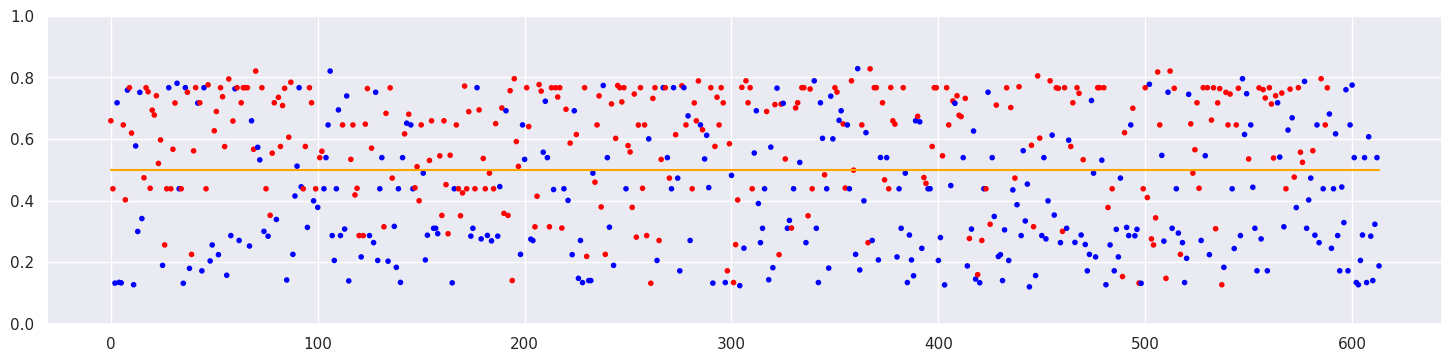

<Figure size 640x480 with 0 Axes>

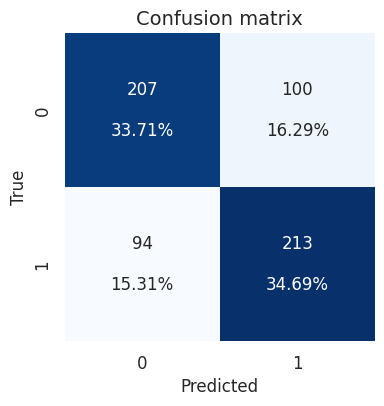

In [375]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

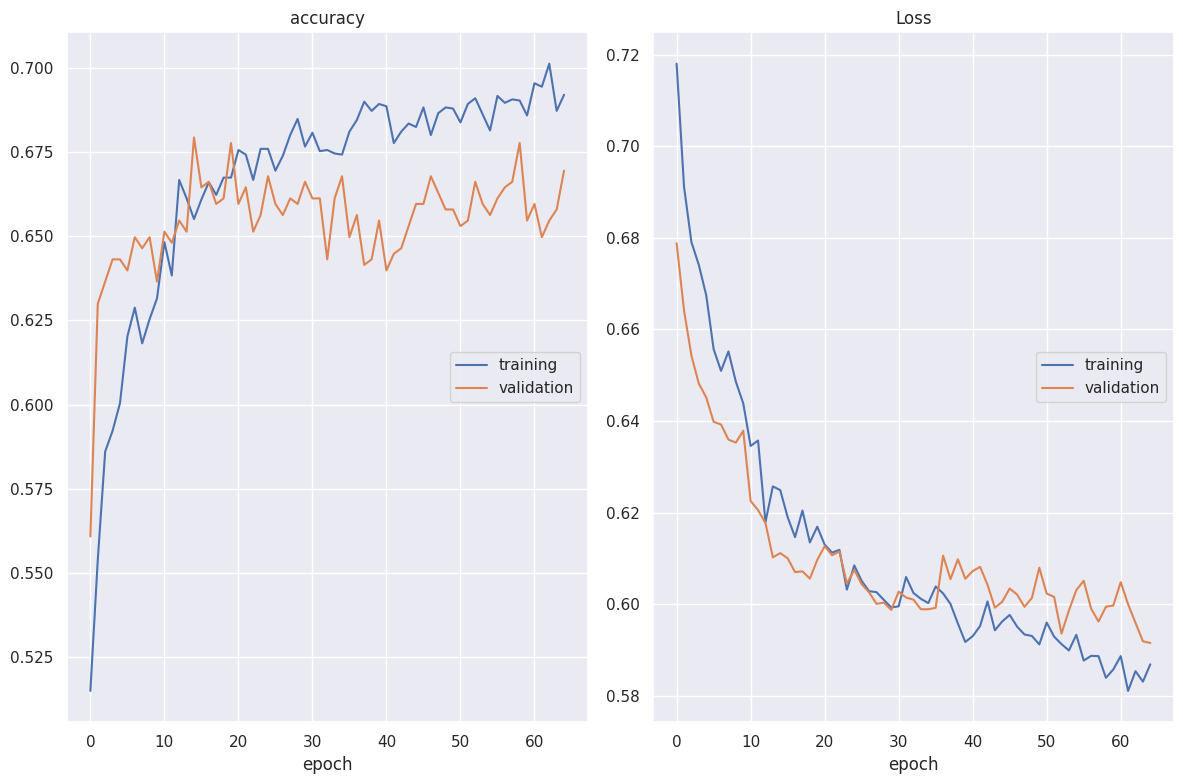

accuracy
	training         	 (min:    0.515, max:    0.701, cur:    0.692)
	validation       	 (min:    0.561, max:    0.679, cur:    0.669)
Loss
	training         	 (min:    0.581, max:    0.718, cur:    0.587)
	validation       	 (min:    0.591, max:    0.679, cur:    0.591)

Epoch 65: val_accuracy did not improve from 0.67928
15/15 [==============================] - 1s 48ms/step - loss: 0.5868 - accuracy: 0.6919 - val_loss: 0.5915 - val_accuracy: 0.6694


In [376]:
model_name = 'model_users_only_10000_1_v1_batch_size_200_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.6889250814332247
Precision: [0.68125    0.69727891]
Recall: 0.6677524429967426
F1 score: 0.682196
ROC AUC: 0.688925


(0.6889250814332247,
 array([0.68125   , 0.69727891]),
 0.6677524429967426,
 0.6821963394342763,
 0.6889250814332246)

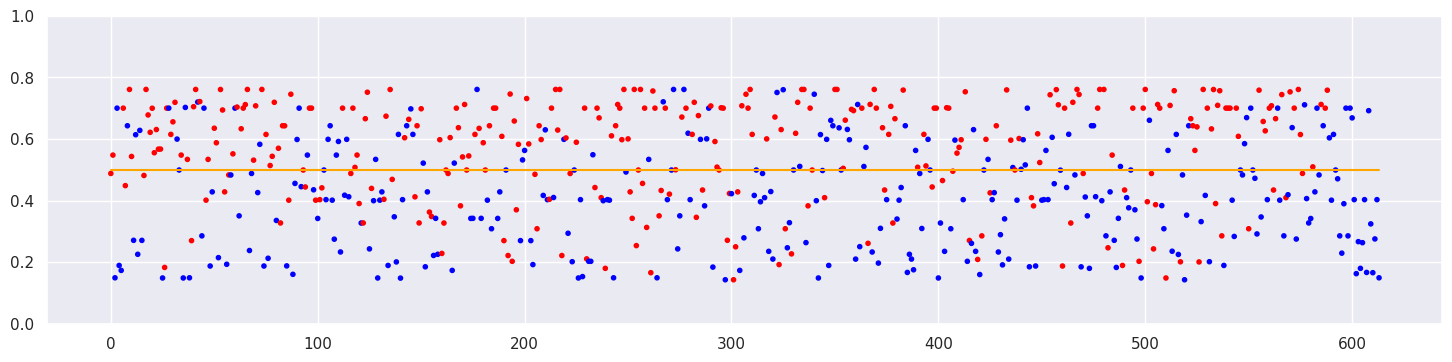

<Figure size 640x480 with 0 Axes>

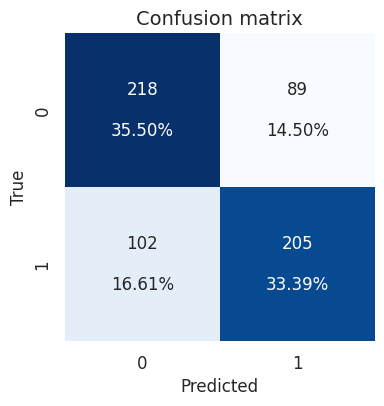

In [377]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

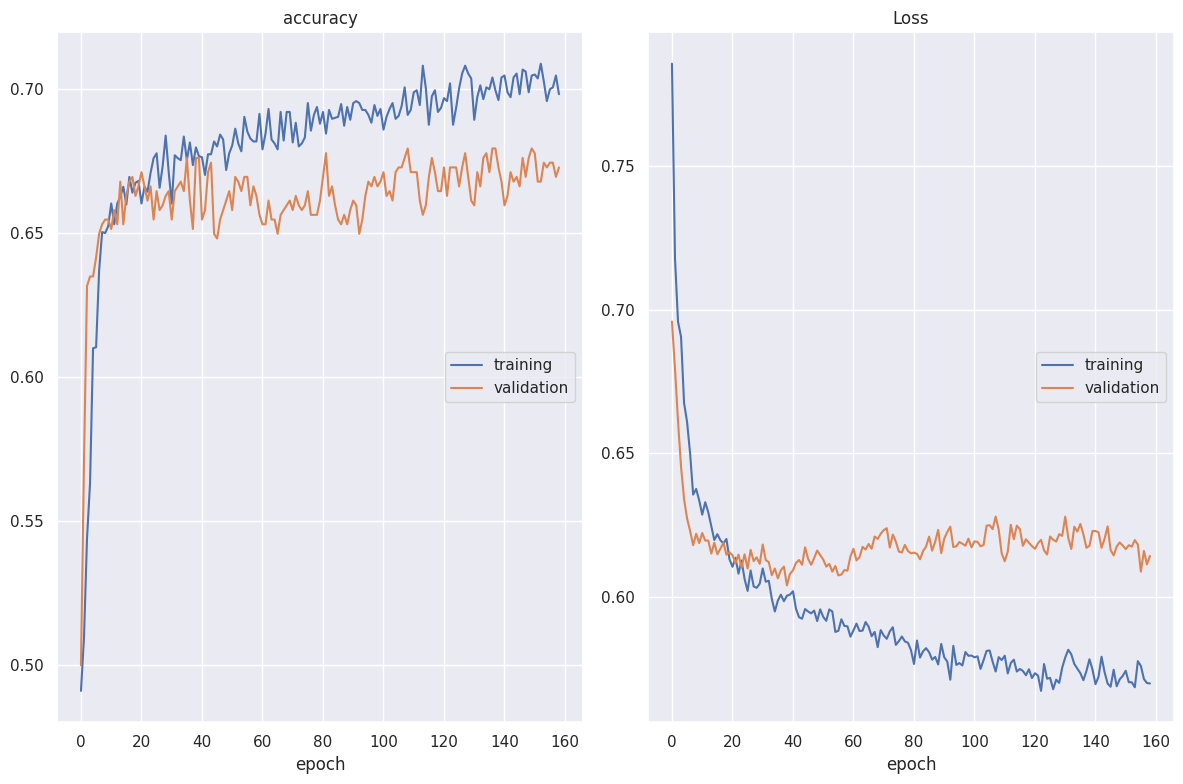

accuracy
	training         	 (min:    0.491, max:    0.709, cur:    0.698)
	validation       	 (min:    0.500, max:    0.679, cur:    0.673)
Loss
	training         	 (min:    0.567, max:    0.785, cur:    0.570)
	validation       	 (min:    0.604, max:    0.696, cur:    0.614)

Epoch 159: val_accuracy did not improve from 0.67928
12/12 [==============================] - 1s 60ms/step - loss: 0.5701 - accuracy: 0.6981 - val_loss: 0.6144 - val_accuracy: 0.6727


In [378]:
model_name = 'model_users_only_10000_1_v1_batch_size_250_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7035830618892508
Precision: [0.70226537 0.70491803]
Recall: 0.7003257328990228
F1 score: 0.702614
ROC AUC: 0.703583


(0.7035830618892508,
 array([0.70226537, 0.70491803]),
 0.7003257328990228,
 0.7026143790849673,
 0.7035830618892508)

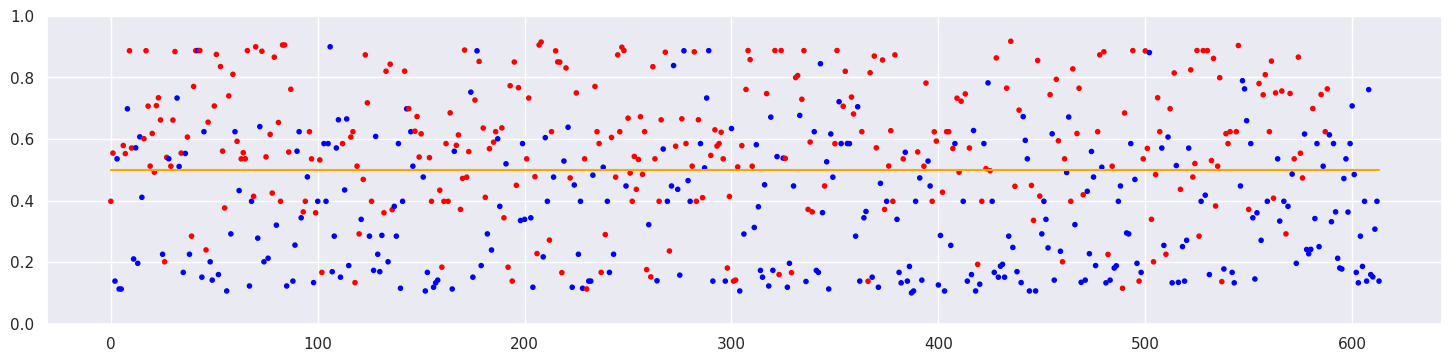

<Figure size 640x480 with 0 Axes>

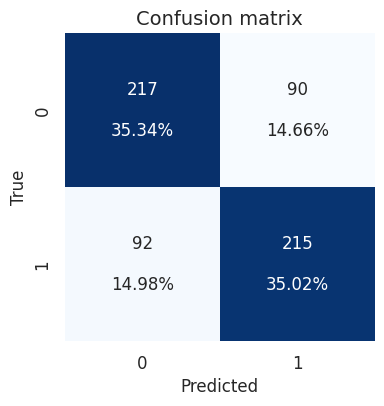

In [379]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=10, epochs=200

#### Create and train model

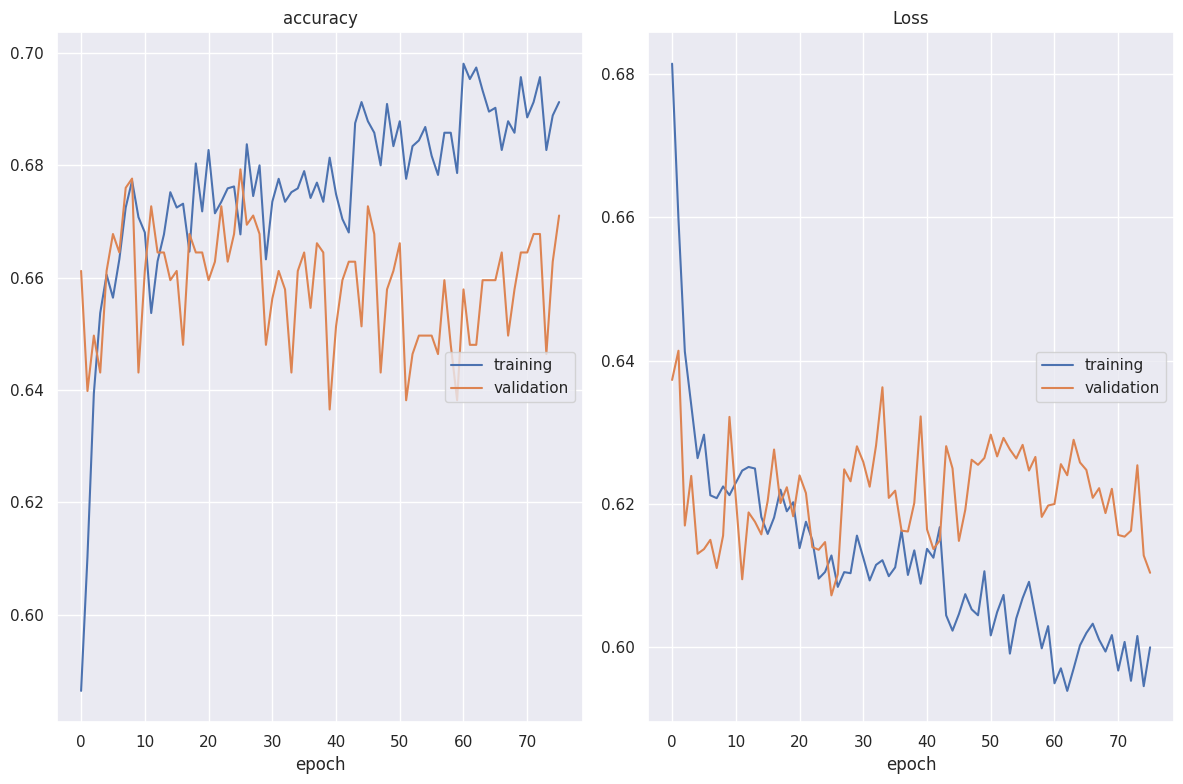

accuracy
	training         	 (min:    0.586, max:    0.698, cur:    0.691)
	validation       	 (min:    0.637, max:    0.679, cur:    0.671)
Loss
	training         	 (min:    0.594, max:    0.681, cur:    0.600)
	validation       	 (min:    0.607, max:    0.641, cur:    0.610)

Epoch 76: val_accuracy did not improve from 0.67928
293/293 [==============================] - 1s 4ms/step - loss: 0.6000 - accuracy: 0.6913 - val_loss: 0.6104 - val_accuracy: 0.6711


In [380]:
model_name = 'model_users_only_10000_1_v1_batch_size_10_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.6856677524429967
Precision: [0.6993007  0.67378049]
Recall: 0.7198697068403909
F1 score: 0.696063
ROC AUC: 0.685668


(0.6856677524429967,
 array([0.6993007 , 0.67378049]),
 0.7198697068403909,
 0.6960629921259843,
 0.6856677524429967)

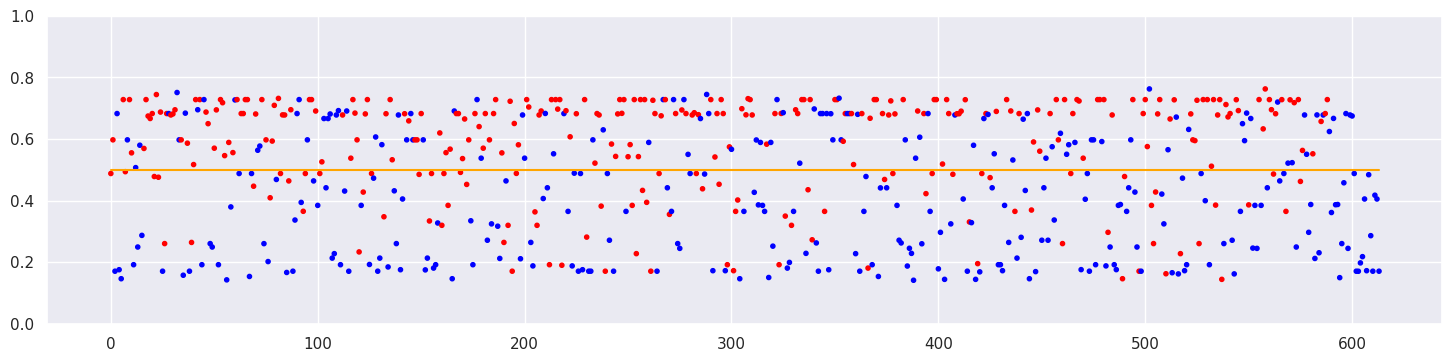

<Figure size 640x480 with 0 Axes>

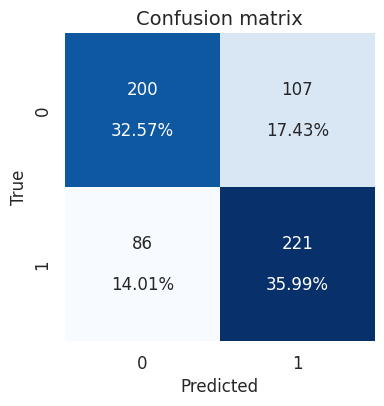

In [381]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

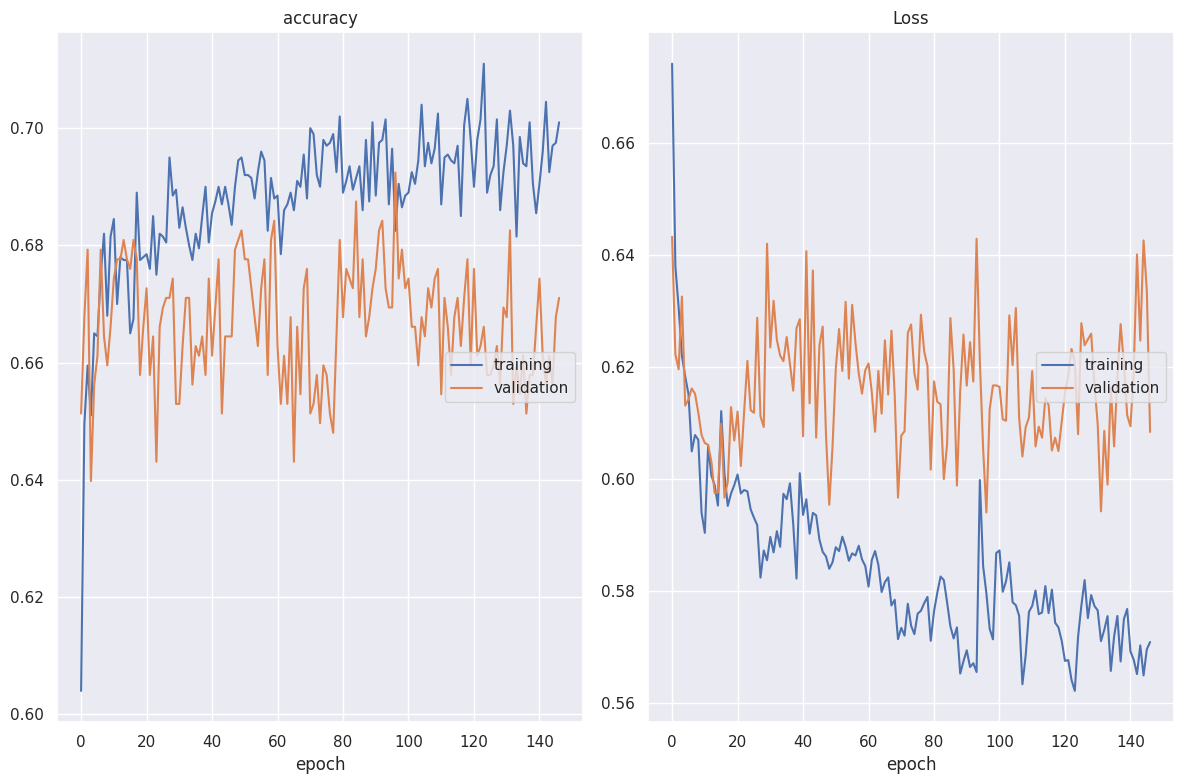

accuracy
	training         	 (min:    0.604, max:    0.711, cur:    0.701)
	validation       	 (min:    0.640, max:    0.692, cur:    0.671)
Loss
	training         	 (min:    0.562, max:    0.674, cur:    0.571)
	validation       	 (min:    0.594, max:    0.643, cur:    0.608)

Epoch 147: val_accuracy did not improve from 0.69243
200/200 [==============================] - 1s 5ms/step - loss: 0.5709 - accuracy: 0.7010 - val_loss: 0.6084 - val_accuracy: 0.6711


In [382]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_10_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.6840390879478827
Precision: [0.66568915 0.70695971]
Recall: 0.6286644951140065
F1 score: 0.665517
ROC AUC: 0.684039


(0.6840390879478827,
 array([0.66568915, 0.70695971]),
 0.6286644951140065,
 0.6655172413793103,
 0.6840390879478827)

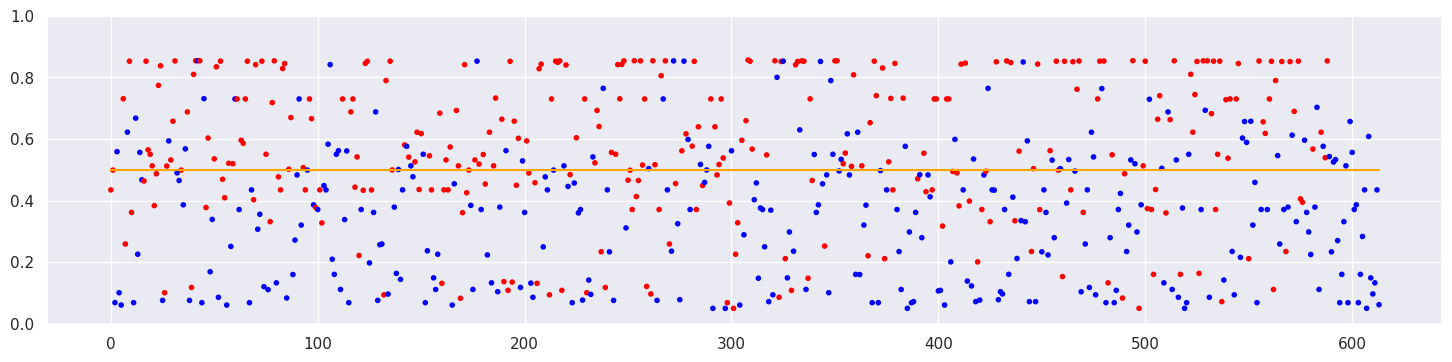

<Figure size 640x480 with 0 Axes>

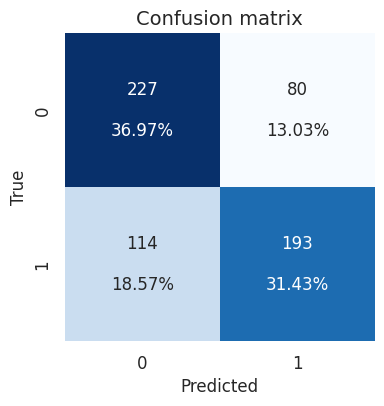

In [383]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

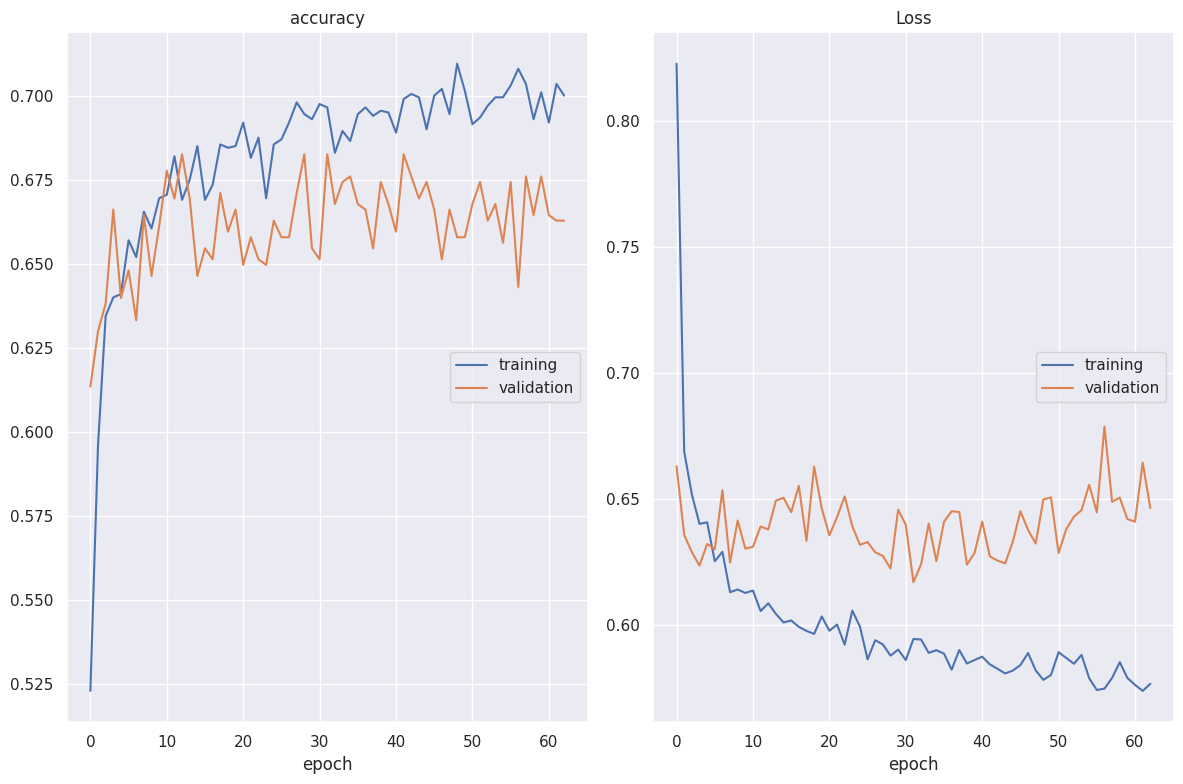

accuracy
	training         	 (min:    0.523, max:    0.710, cur:    0.700)
	validation       	 (min:    0.613, max:    0.683, cur:    0.663)
Loss
	training         	 (min:    0.574, max:    0.823, cur:    0.577)
	validation       	 (min:    0.617, max:    0.679, cur:    0.646)

Epoch 63: val_accuracy did not improve from 0.68257
40/40 [==============================] - 1s 18ms/step - loss: 0.5767 - accuracy: 0.7000 - val_loss: 0.6465 - val_accuracy: 0.6628


In [384]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_50_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.6938110749185668
Precision: [0.69636964 0.69131833]
Recall: 0.7003257328990228
F1 score: 0.695793
ROC AUC: 0.693811


(0.6938110749185668,
 array([0.69636964, 0.69131833]),
 0.7003257328990228,
 0.6957928802588997,
 0.6938110749185669)

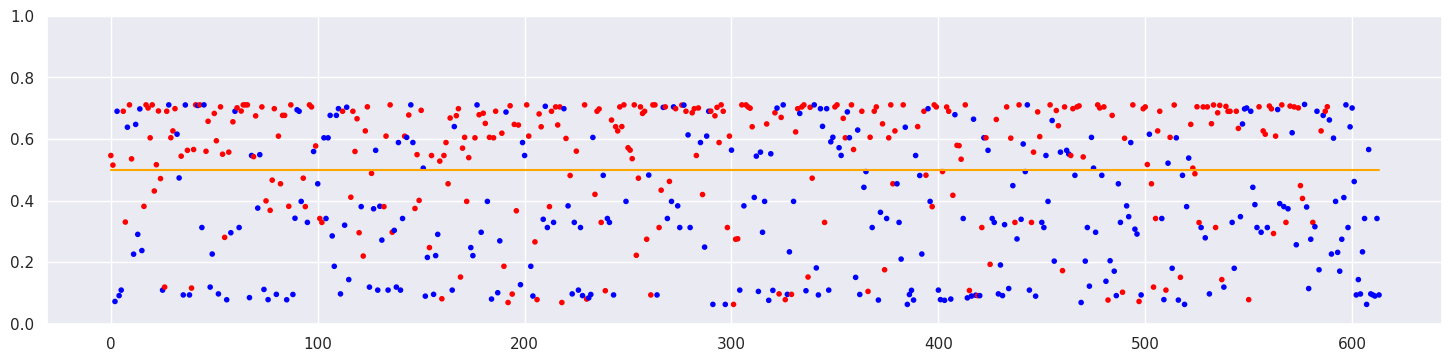

<Figure size 640x480 with 0 Axes>

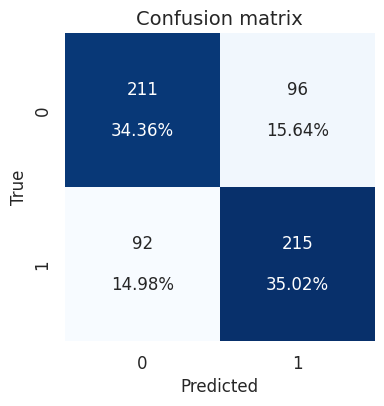

In [385]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

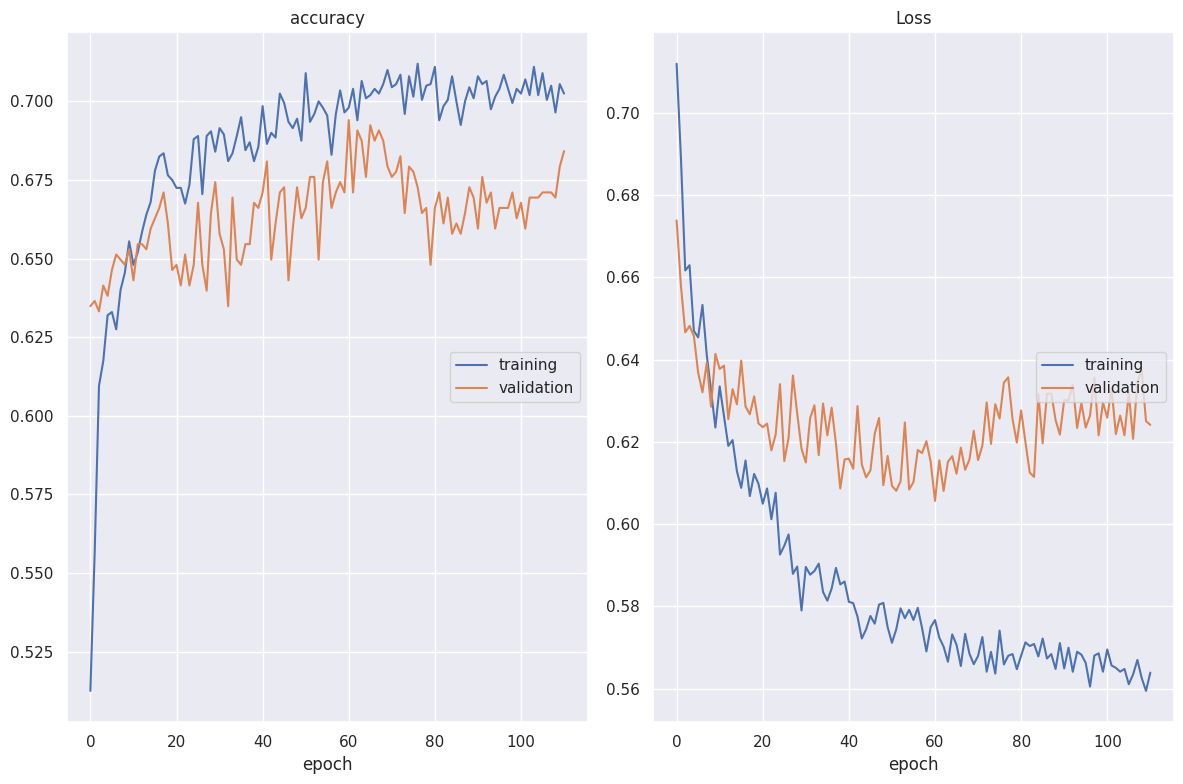

accuracy
	training         	 (min:    0.512, max:    0.712, cur:    0.702)
	validation       	 (min:    0.633, max:    0.694, cur:    0.684)
Loss
	training         	 (min:    0.559, max:    0.712, cur:    0.564)
	validation       	 (min:    0.606, max:    0.674, cur:    0.624)

Epoch 111: val_accuracy did not improve from 0.69408
20/20 [==============================] - 1s 55ms/step - loss: 0.5639 - accuracy: 0.7025 - val_loss: 0.6241 - val_accuracy: 0.6842


In [386]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_100_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.6579804560260586
Precision: [0.63739377 0.68582375]
Recall: 0.5830618892508144
F1 score: 0.630282
ROC AUC: 0.657980


(0.6579804560260586,
 array([0.63739377, 0.68582375]),
 0.5830618892508144,
 0.6302816901408451,
 0.6579804560260586)

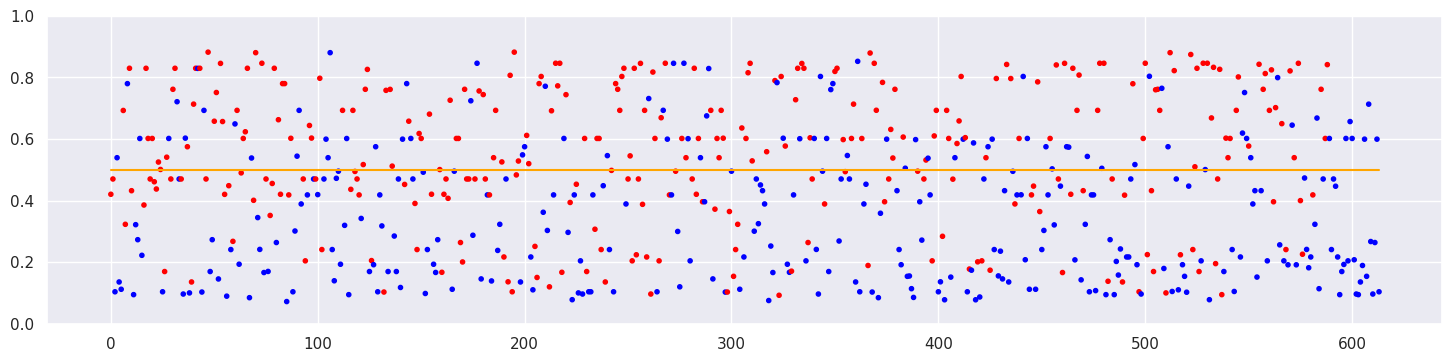

<Figure size 640x480 with 0 Axes>

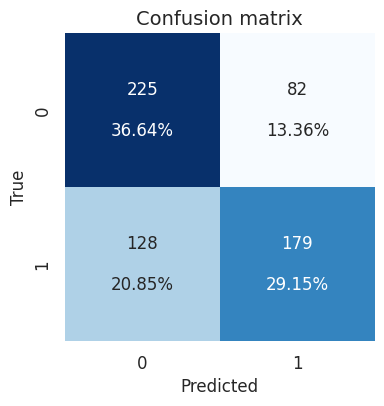

In [387]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

In [ ]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_150_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

In [ ]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

In [ ]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_200_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

In [ ]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

In [ ]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_250_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

In [ ]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

Accuracy: 0.696875

Precision: [0.66765579 0.72937294]

Recall: 0.6636636636636637

F1 score: 0.694969

ROC AUC: 0.698281

## SHAP (SHapley Additive exPlanations) - done for model 1 v1

In [1446]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())

In [1447]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:102: UserWarning:

keras is no longer supported, please use tf.keras instead.

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/home/jupyter/.local/lib/python3.7/site-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


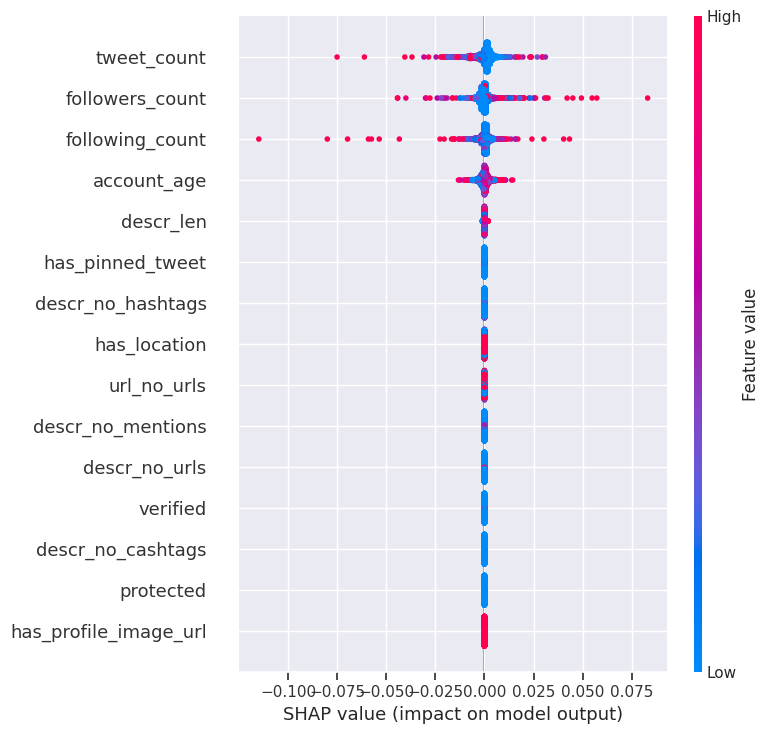

In [1448]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

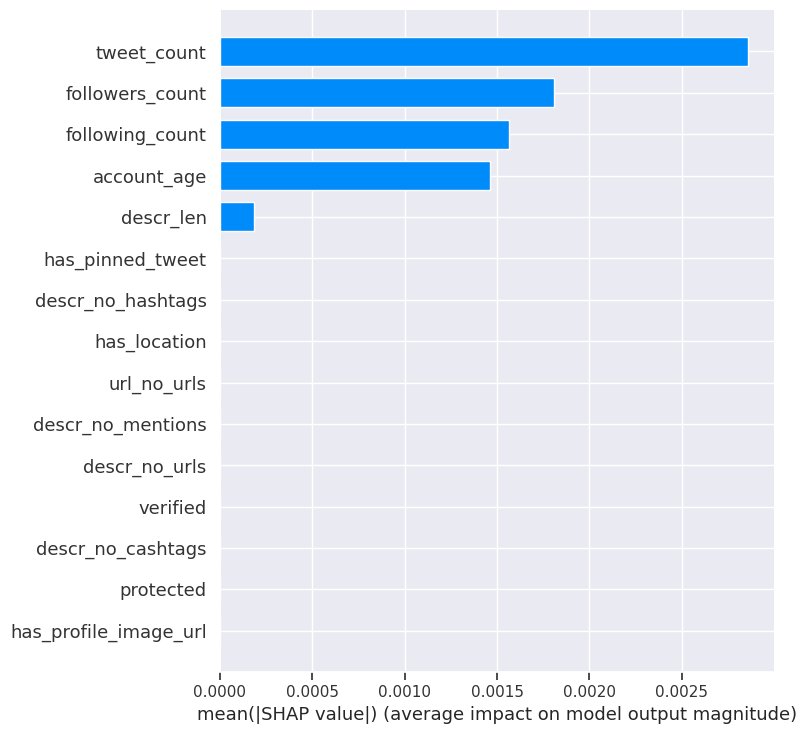

In [1449]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

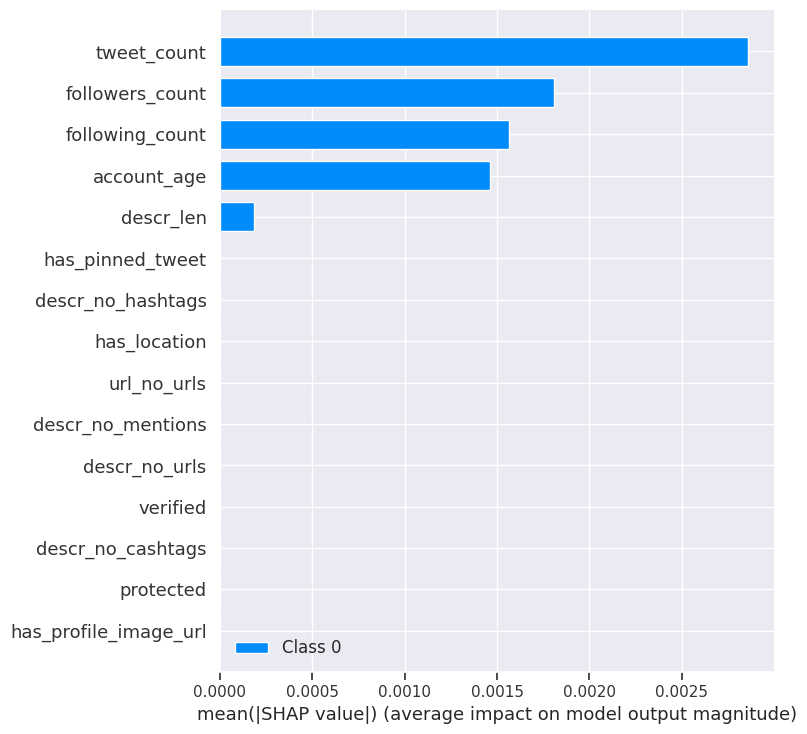

In [1450]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [184]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)

### Grid search for finding the most optimal set of parameters

In [188]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

INFO:tensorflow:Assets written to: ram://580ea03e3b4841f5a2057495837325b7/assets


INFO:tensorflow:Assets written to: ram://580ea03e3b4841f5a2057495837325b7/assets
2023-08-18 14:13:16.673070: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb8663aa51ba48e88715f90f36dbc561: INVALID_ARGUMENT: ram://bb8663aa51ba48e88715f90f36dbc561 is a directory.


In [189]:
model_wrapper = KerasClassifier(model=create_model_1(shape=(train_X.shape[1],)))
# model_wrapper.get_params().keys()

early_stop_sg = EarlyStopping(monitor='accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')

parameters = {
    'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
    'batch_size' : [10, 20, 40, 60, 80, 100, 150, 200, 250],
    'epochs' : [10, 50, 100],
    'callbacks' : [early_stop_sg]}
# parameters = {
#     'batch_size' : [10, 20, 60, 100, 150, 200],
#     'epochs' : [10, 50]}


dnn_model_grid = GridSearchCV(estimator=model_wrapper,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=10,
                        verbose=0)


dnn_model_grid.fit(train_X, train_Y)

INFO:tensorflow:Assets written to: ram://b8ff2ee6bf284c4d93fe71f3c4b23e26/assets


INFO:tensorflow:Assets written to: ram://b8ff2ee6bf284c4d93fe71f3c4b23e26/assets


INFO:tensorflow:Assets written to: ram://1b84fab1016248289a7533b7858cec48/assets


INFO:tensorflow:Assets written to: ram://1b84fab1016248289a7533b7858cec48/assets
2023-08-18 14:13:20.419724: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d5cbe351a614ff18ff75c3f32d2f83e: INVALID_ARGUMENT: ram://9d5cbe351a614ff18ff75c3f32d2f83e is a directory.
2023-08-18 14:13:21.000254: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97becdc46fe544c999f1fe72ab2a062b: INVALID_ARGUMENT: ram://97becdc46fe544c999f1fe72ab2a062b is a directory.


INFO:tensorflow:Assets written to: ram://2ca9a6be07c84c95ac8780ded063baf6/assets


INFO:tensorflow:Assets written to: ram://2ca9a6be07c84c95ac8780ded063baf6/assets


INFO:tensorflow:Assets written to: ram://6e7525283f7a4033bb37968b8a720641/assets


INFO:tensorflow:Assets written to: ram://6e7525283f7a4033bb37968b8a720641/assets
2023-08-18 14:13:24.766854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d94b27db3e14036b4e832b3d300a9de: INVALID_ARGUMENT: ram://4d94b27db3e14036b4e832b3d300a9de is a directory.
2023-08-18 14:13:25.277429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ff89e970ed54adda2397b4401b4a54c: INVALID_ARGUMENT: ram://8ff89e970ed54adda2397b4401b4a54c is a directory.


INFO:tensorflow:Assets written to: ram://696b312ab80f47269e884e68d78aaf07/assets


INFO:tensorflow:Assets written to: ram://696b312ab80f47269e884e68d78aaf07/assets


INFO:tensorflow:Assets written to: ram://19f32fea45524a7d9cce23262bfd594e/assets


INFO:tensorflow:Assets written to: ram://19f32fea45524a7d9cce23262bfd594e/assets
2023-08-18 14:13:30.170837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://630feba19a444b68904279cb5bae86dd: INVALID_ARGUMENT: ram://630feba19a444b68904279cb5bae86dd is a directory.
2023-08-18 14:13:30.825620: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a02555db01a34e6697ebab168fad80e7: INVALID_ARGUMENT: ram://a02555db01a34e6697ebab168fad80e7 is a directory.


INFO:tensorflow:Assets written to: ram://60e757c9f4a74546873e524533a21e3e/assets


INFO:tensorflow:Assets written to: ram://60e757c9f4a74546873e524533a21e3e/assets


INFO:tensorflow:Assets written to: ram://ddfb5518b79e462185529044e1ad4e9f/assets


INFO:tensorflow:Assets written to: ram://ddfb5518b79e462185529044e1ad4e9f/assets
2023-08-18 14:13:34.427656: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d74f5354e984f17b323918946b7007a: INVALID_ARGUMENT: ram://7d74f5354e984f17b323918946b7007a is a directory.
2023-08-18 14:13:35.077488: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://334f1516aae549bf91537a9e9029f026: INVALID_ARGUMENT: ram://334f1516aae549bf91537a9e9029f026 is a directory.
ERROR:concurrent.futures:exception calling callback for <Future at 0x7fbcb412ba50 state=finished returned list>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not s

INFO:tensorflow:Assets written to: ram://09654146517846469e56f1f646929648/assets


INFO:tensorflow:Assets written to: ram://09654146517846469e56f1f646929648/assets
2023-08-18 14:13:36.784825: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36624f4fafe8449bad05b84f2868e35f: INVALID_ARGUMENT: ram://36624f4fafe8449bad05b84f2868e35f is a directory.


INFO:tensorflow:Assets written to: ram://8979f305a1c04f629ddab06b4b06f319/assets


INFO:tensorflow:Assets written to: ram://8979f305a1c04f629ddab06b4b06f319/assets
2023-08-18 14:13:38.562557: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f1e092ddcef44dc9c668b407bf9cb34: INVALID_ARGUMENT: ram://7f1e092ddcef44dc9c668b407bf9cb34 is a directory.


INFO:tensorflow:Assets written to: ram://65466887d466496289e7b62060ded178/assets


INFO:tensorflow:Assets written to: ram://65466887d466496289e7b62060ded178/assets
2023-08-18 14:13:40.347818: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://47db20c6a6b4471f90090822eec574c7: INVALID_ARGUMENT: ram://47db20c6a6b4471f90090822eec574c7 is a directory.


INFO:tensorflow:Assets written to: ram://314dfa459d384ef1b8707746f3af2fbe/assets


INFO:tensorflow:Assets written to: ram://314dfa459d384ef1b8707746f3af2fbe/assets
2023-08-18 14:13:42.168290: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28624e65ec914c3eb59b2eca26dec5b9: INVALID_ARGUMENT: ram://28624e65ec914c3eb59b2eca26dec5b9 is a directory.


INFO:tensorflow:Assets written to: ram://896733b7c3114aaf80371557edcb839a/assets


INFO:tensorflow:Assets written to: ram://896733b7c3114aaf80371557edcb839a/assets


2023-08-18 14:13:46.165726: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2455cfd93bcd478f87c96d7606c259e5: INVALID_ARGUMENT: ram://2455cfd93bcd478f87c96d7606c259e5 is a directory.


INFO:tensorflow:Assets written to: ram://d527605b52c04bd8b40b38176f522a18/assets


INFO:tensorflow:Assets written to: ram://d527605b52c04bd8b40b38176f522a18/assets
2023-08-18 14:13:47.992525: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4536740957bf47579b8137627c8c2b52: INVALID_ARGUMENT: ram://4536740957bf47579b8137627c8c2b52 is a directory.


INFO:tensorflow:Assets written to: ram://aea2790fffe2498c9123bd6e9a1c280c/assets


INFO:tensorflow:Assets written to: ram://aea2790fffe2498c9123bd6e9a1c280c/assets
2023-08-18 14:13:49.774180: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3ff313ddec44bccb5855b7bacfc85d9: INVALID_ARGUMENT: ram://f3ff313ddec44bccb5855b7bacfc85d9 is a directory.


INFO:tensorflow:Assets written to: ram://0acf7e8dd3e1430c9b530d284d443f1d/assets


INFO:tensorflow:Assets written to: ram://0acf7e8dd3e1430c9b530d284d443f1d/assets


INFO:tensorflow:Assets written to: ram://6690b75524ba4795b8cfda784b4bdbda/assets


INFO:tensorflow:Assets written to: ram://6690b75524ba4795b8cfda784b4bdbda/assets
2023-08-18 14:13:53.855949: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ec52f73dae747ceb5dd52119a4e9aa8: INVALID_ARGUMENT: ram://7ec52f73dae747ceb5dd52119a4e9aa8 is a directory.
2023-08-18 14:13:53.990055: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61cbe77536cb49128e5564a908027c76: INVALID_ARGUMENT: ram://61cbe77536cb49128e5564a908027c76 is a directory.


Epoch 1/10
239/239 [==============================] - 1s 2ms/step - loss: 0.7063 - accuracy: 0.5356
Epoch 2/10
 88/239 [==========>...................] - ETA: 0s - loss: 0.6844 - accuracy: 0.5614INFO:tensorflow:Assets written to: ram://01353e0e6e6146ba9f3af3656eb05bfa/assets


INFO:tensorflow:Assets written to: ram://01353e0e6e6146ba9f3af3656eb05bfa/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6774 - accuracy: 0.5687
Epoch 3/10
232/239 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5690

2023-08-18 14:13:56.435794: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3263d28464ea446996cface6e4044303: INVALID_ARGUMENT: ram://3263d28464ea446996cface6e4044303 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5720
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6688 - accuracy: 0.6030
Epoch 5/10
 35/239 [===>..........................] - ETA: 0s - loss: 0.7001 - accuracy: 0.5629INFO:tensorflow:Assets written to: ram://bd4027744f6748aa9eaa895e4413dd60/assets


INFO:tensorflow:Assets written to: ram://bd4027744f6748aa9eaa895e4413dd60/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.6034
Epoch 6/10
239/239 [==============================] - 2s 3ms/step - loss: 0.6953 - accuracy: 0.5634
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6636 - accuracy: 0.6059
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6788 - accuracy: 0.5910
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6546 - accuracy: 0.6206
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.6036
Epoch 4/10
154/239 [==================>...........] - ETA: 0s - loss: 0.6538 - accuracy: 0.6084INFO:tensorflow:Assets written to: ram://23efc8ace03d407abf5770a9d3102d9a/assets


INFO:tensorflow:Assets written to: ram://23efc8ace03d407abf5770a9d3102d9a/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6577 - accuracy: 0.6139
Epoch 9/10
 95/239 [==========>...................] - ETA: 0s - loss: 0.6555 - accuracy: 0.6168

2023-08-18 14:13:59.944486: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f13209aa343d42dba716d51074bb7067: INVALID_ARGUMENT: ram://f13209aa343d42dba716d51074bb7067 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6612 - accuracy: 0.6128
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6609 - accuracy: 0.6131
Epoch 10/10
 98/239 [===========>..................] - ETA: 0s - loss: 0.6558 - accuracy: 0.6286

2023-08-18 14:14:00.627574: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b705c60d9a394ca9bc9f467ffb47ee18: INVALID_ARGUMENT: ram://b705c60d9a394ca9bc9f467ffb47ee18 is a directory.


Epoch 1/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6605 - accuracy: 0.6153
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6566 - accuracy: 0.5994
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6636 - accuracy: 0.6145
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7046 - accuracy: 0.5274
Epoch 2/10
198/239 [=======================>......] - ETA: 0s - loss: 0.6588 - acWARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


239/239 [==============================] - 1s 3ms/step - loss: 0.6562 - accuracy: 0.6145
Epoch 9/10
166/239 [===================>..........] - ETA: 0s - loss: 0.6856 - accuracy: 0.58WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


239/239 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.5764
Epoch 3/10
 91/239 [==========>...................] - ETA: 0s - loss: 0.6812 - accuracy: 0.5780WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


239/239 [==============================] - 1s 3ms/step - loss: 0.6582 - accuracy: 0.6249
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.5873
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6653 - accuracy: 0.6116
Epoch 5/10
133/239 [===============>..............] - ETA: 0s - loss: 0.6563 - accuracy: 0.6263INFO:tensorflow:Assets written to: ram://266f2b4fe7cd4bf8aaeea62f217abdac/assets


INFO:tensorflow:Assets written to: ram://266f2b4fe7cd4bf8aaeea62f217abdac/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6531 - accuracy: 0.6358
Epoch 6/10
167/239 [===================>..........] - ETA: 0s - loss: 0.6604 - accuracy: 0.6186INFO:tensorflow:Assets written to: ram://5dc901d855c348f793fc18c27ff52eab/assets


INFO:tensorflow:Assets written to: ram://5dc901d855c348f793fc18c27ff52eab/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6586 - accuracy: 0.6266
Epoch 7/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6527 - accuracy: 0.6275
Epoch 8/10
 63/239 [======>.......................] - ETA: 0s - loss: 0.6513 - accuracy: 0.6270

2023-08-18 14:14:06.315203: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65bc1c4a01b74727bace0e1a6e870027: INVALID_ARGUMENT: ram://65bc1c4a01b74727bace0e1a6e870027 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6530 - accuracy: 0.6170
Epoch 9/10
 84/239 [=========>....................] - ETA: 0s - loss: 0.6571 - accuracy: 0.6167

2023-08-18 14:14:06.861479: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06e38abd53a949f4b4514bdfc497ca52: INVALID_ARGUMENT: ram://06e38abd53a949f4b4514bdfc497ca52 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6536 - accuracy: 0.6237
Epoch 10/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7069 - accuracy: 0.5249
Epoch 2/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6829 - accuracy: 0.5785
Epoch 3/10
178/239 [=====================>........] - ETA: 0s - loss: 0.6809 - accuracy: 0.5916INFO:tensorflow:Assets written to: ram://55bc7244c5a94ce99a2bf6b8d11f1d15/assets


INFO:tensorflow:Assets written to: ram://55bc7244c5a94ce99a2bf6b8d11f1d15/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6792 - accuracy: 0.5898
Epoch 4/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6757 - accuracy: 0.5894
Epoch 5/10
107/239 [============>.................] - ETA: 0s - loss: 0.6627 - accuracy: 0.6047

2023-08-18 14:14:10.037443: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://181b042af906452295d5f4794624311f: INVALID_ARGUMENT: ram://181b042af906452295d5f4794624311f is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6629 - accuracy: 0.6128
Epoch 6/10
119/239 [=============>................] - ETA: 0s - loss: 0.6507 - accuracy: 0.6361INFO:tensorflow:Assets written to: ram://549619e5e25c4db6bc3ce196467acc4d/assets


INFO:tensorflow:Assets written to: ram://549619e5e25c4db6bc3ce196467acc4d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6577 - accuracy: 0.6249
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6566 - accuracy: 0.6208
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.6998 - accuracy: 0.5471
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6149
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6874 - accuracy: 0.5676
Epoch 3/10
209/239 [=========================>....] - ETA: 0s - loss: 0.6564 - accuracy: 0.6091

2023-08-18 14:14:12.915146: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bddcbb3088a642729598d5bc6bbaf6af: INVALID_ARGUMENT: ram://bddcbb3088a642729598d5bc6bbaf6af is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6132
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.5894
Epoch 4/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6646 - accuracy: 0.6054INFO:tensorflow:Assets written to: ram://18bfa0ae99be4df299b3fb48b808afb8/assets


INFO:tensorflow:Assets written to: ram://18bfa0ae99be4df299b3fb48b808afb8/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6682 - accuracy: 0.5994
Epoch 5/10
 97/239 [===========>..................] - ETA: 0s - loss: 0.6664 - accuracy: 0.6072

2023-08-18 14:14:14.136312: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5bd2b173f1354b2a980f58f1ae41a548: INVALID_ARGUMENT: ram://5bd2b173f1354b2a980f58f1ae41a548 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6136
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6583 - accuracy: 0.6116
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.6195
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.6996 - accuracy: 0.5398
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6500 - accuracy: 0.6325
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6429 - accuracy: 0.6367
Epoch 10/10
 59/239 [======>.......................] - ETA: 0s - loss: 0.6489 - accuracy: 0.6390INFO:tensorflow:Assets written to: ram://9607070235734be18d78afe9ef38492b/assets


INFO:tensorflow:Assets written to: ram://9607070235734be18d78afe9ef38492b/assets


 95/239 [==========>...................] - ETA: 0s - loss: 0.6507 - accuracy: 0.6337Epoch 4/10
INFO:tensorflow:Assets written to: ram://4877372ba3a24bf5bc426d17959095ce/assets


INFO:tensorflow:Assets written to: ram://4877372ba3a24bf5bc426d17959095ce/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.6089
Epoch 5/10
126/239 [==============>...............] - ETA: 0s - loss: 0.6582 - accuracy: 0.6183

2023-08-18 14:14:18.167735: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d33f7622bcc4739bde94e65d76d1ffa: INVALID_ARGUMENT: ram://6d33f7622bcc4739bde94e65d76d1ffa is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6602 - accuracy: 0.6168
Epoch 6/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.6093
Epoch 7/10
 43/239 [====>.........................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6256

2023-08-18 14:14:19.180279: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2049adde80e5443fb584b9816f7c02f6: INVALID_ARGUMENT: ram://2049adde80e5443fb584b9816f7c02f6 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6529 - accuracy: 0.6244
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6596 - accuracy: 0.6110
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5772
Epoch 3/10
188/239 [======================>.......] - ETA: 0s - loss: 0.6616 - accuracy: 0.6133INFO:tensorflow:Assets written to: ram://879fc9983b844333a76b12547273a18c/assets


INFO:tensorflow:Assets written to: ram://879fc9983b844333a76b12547273a18c/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6586 - accuracy: 0.6156
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5990
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6637 - accuracy: 0.6095
Epoch 5/10
60/60 [==============================] - 0s 2ms/step loss: 0.6809 - accuracy: 0.58


2023-08-18 14:14:21.963014: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25ffb9973feb457f9d01fe0d4f212a59: INVALID_ARGUMENT: ram://25ffb9973feb457f9d01fe0d4f212a59 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6677 - accuracy: 0.6019
Epoch 6/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6611 - accuracy: 0.6015
Epoch 7/10
150/239 [=================>............] - ETA: 0s - loss: 0.7087 - accuracy: 0.5260INFO:tensorflow:Assets written to: ram://39e597480b5843899bf386bc023f20a5/assets


INFO:tensorflow:Assets written to: ram://39e597480b5843899bf386bc023f20a5/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.6970 - accuracy: 0.5483
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.6157
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5588
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6212
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6682 - accuracy: 0.5936
Epoch 4/10
 18/239 [=>............................] - ETA: 0s - loss: 0.6663 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://9cbcd20d53154a68beb6639da6c85c00/assets


INFO:tensorflow:Assets written to: ram://9cbcd20d53154a68beb6639da6c85c00/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.6015
Epoch 5/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6483 - accuracy: 0.6054

2023-08-18 14:14:25.799052: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e36dad67828e436d9129f8cfd5f12c01: INVALID_ARGUMENT: ram://e36dad67828e436d9129f8cfd5f12c01 is a directory.


202/239 [========================>.....] - ETA: 0s - loss: 0.6565 - accuracy: 0.6099

2023-08-18 14:14:26.290524: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9eeab8520ac64732a2b989def10d2cf0: INVALID_ARGUMENT: ram://9eeab8520ac64732a2b989def10d2cf0 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6074
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6540 - accuracy: 0.6291
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6354
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7084 - accuracy: 0.5283
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.6157
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6845 - accuracy: 0.5697
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6486 - accuracy: 0.6229
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6740 - accuracy: 0.5982
Epoch 4/10
 98/239 [===========>..................] - ETA: 0s - loss: 0.6651 - accuracy: 0.6224INFO:tensorflow:Assets written to: ram://70ec6feeac9b4f4dae70f6cf1f103e60/assets


INFO:tensorflow:Assets written to: ram://70ec6feeac9b4f4dae70f6cf1f103e60/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6677 - accuracy: 0.6178
Epoch 5/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6627 - accuracy: 0.6082
Epoch 6/10
 87/239 [=========>....................] - ETA: 0s - loss: 0.6509 - accuracy: 0.6161INFO:tensorflow:Assets written to: ram://ef17423a0e61429d8fbecff61639faae/assets


2023-08-18 14:14:30.781919: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd22881a57c34a57a5741aa56e663e36: INVALID_ARGUMENT: ram://fd22881a57c34a57a5741aa56e663e36 is a directory.
INFO:tensorflow:Assets written to: ram://ef17423a0e61429d8fbecff61639faae/assets


Epoch 1/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6519 - accuracy: 0.6195
Epoch 7/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6527 - accuracy: 0.6220
Epoch 8/10
 23/239 [=>............................] - ETA: 0s - loss: 0.6576 - accuracy: 0.5826

2023-08-18 14:14:31.721364: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7377eeffbe1f485abeecd29161dfefb2: INVALID_ARGUMENT: ram://7377eeffbe1f485abeecd29161dfefb2 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6581 - accuracy: 0.6183
Epoch 9/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7044 - accuracy: 0.5408
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6594 - accuracy: 0.6174
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5605
Epoch 3/10
158/239 [==================>...........] - ETA: 0s - loss: 0.6481 - accuracy: 0.6354INFO:tensorflow:Assets written to: ram://8258b346c4c743e19b1ce5abb6ebf743/assets


INFO:tensorflow:Assets written to: ram://8258b346c4c743e19b1ce5abb6ebf743/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6771 - accuracy: 0.5860
Epoch 4/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6663 - accuracy: 0.6032
Epoch 5/10
 24/239 [==>...........................] - ETA: 0s - loss: 0.6990 - accuracy: 0.5500

2023-08-18 14:14:34.276855: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://124153278e994af0859ee2f70d46d575: INVALID_ARGUMENT: ram://124153278e994af0859ee2f70d46d575 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6664 - accuracy: 0.6111
Epoch 6/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6570 - accuracy: 0.6254
Epoch 7/10
160/239 [===================>..........] - ETA: 0s - loss: 0.6558 - accuracy: 0.6094INFO:tensorflow:Assets written to: ram://6854b73bf93441c59b2f4181e5b65a37/assets


INFO:tensorflow:Assets written to: ram://6854b73bf93441c59b2f4181e5b65a37/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6128
Epoch 8/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.6103
Epoch 9/10
 69/239 [=======>......................] - ETA: 0s - loss: 0.6693 - accuracy: 0.5928

2023-08-18 14:14:36.523876: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d7e54a56c7144a7a93a27484617c977: INVALID_ARGUMENT: ram://2d7e54a56c7144a7a93a27484617c977 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6577 - accuracy: 0.6245
Epoch 10/10
60/60 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3ed6fdbc0c50400b934e49333ea465a5/assets


INFO:tensorflow:Assets written to: ram://3ed6fdbc0c50400b934e49333ea465a5/assets
2023-08-18 14:14:38.628721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f86583ac05c4575991b67a27ed9054c: INVALID_ARGUMENT: ram://5f86583ac05c4575991b67a27ed9054c is a directory.


INFO:tensorflow:Assets written to: ram://2fc28642f66146809fba15f28acfe719/assets


INFO:tensorflow:Assets written to: ram://2fc28642f66146809fba15f28acfe719/assets
2023-08-18 14:14:40.433443: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ada510351a3c4624b06dd9fc37b69cb6: INVALID_ARGUMENT: ram://ada510351a3c4624b06dd9fc37b69cb6 is a directory.


INFO:tensorflow:Assets written to: ram://ddf47b18e61b48f8a3feb822bdfd8669/assets


INFO:tensorflow:Assets written to: ram://ddf47b18e61b48f8a3feb822bdfd8669/assets
2023-08-18 14:14:42.209780: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e4ec8bb5b6d54005b1bb08400e50bcc7: INVALID_ARGUMENT: ram://e4ec8bb5b6d54005b1bb08400e50bcc7 is a directory.


INFO:tensorflow:Assets written to: ram://036f42a5d2a54077836420fa21ff78e3/assets


INFO:tensorflow:Assets written to: ram://036f42a5d2a54077836420fa21ff78e3/assets
2023-08-18 14:14:43.994425: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b66a2629daf4209b0bb8039649ab72c: INVALID_ARGUMENT: ram://2b66a2629daf4209b0bb8039649ab72c is a directory.


INFO:tensorflow:Assets written to: ram://17df6863de5241ab9a4742964c327dce/assets


INFO:tensorflow:Assets written to: ram://17df6863de5241ab9a4742964c327dce/assets
2023-08-18 14:14:45.803291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ac26437a0db4752bd28245252fb1f97: INVALID_ARGUMENT: ram://4ac26437a0db4752bd28245252fb1f97 is a directory.


INFO:tensorflow:Assets written to: ram://2378cfa0bd084d0ab548db1ad4e71c10/assets


INFO:tensorflow:Assets written to: ram://2378cfa0bd084d0ab548db1ad4e71c10/assets
2023-08-18 14:14:48.716740: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f9e87639ee9a4455bb8cd9893900d0bf: INVALID_ARGUMENT: ram://f9e87639ee9a4455bb8cd9893900d0bf is a directory.


INFO:tensorflow:Assets written to: ram://4f81fb0eea16434a8ff9dd96ab1c432e/assets


INFO:tensorflow:Assets written to: ram://4f81fb0eea16434a8ff9dd96ab1c432e/assets
2023-08-18 14:14:50.557249: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43d67759faf74ff8b9eb6b60a2180bda: INVALID_ARGUMENT: ram://43d67759faf74ff8b9eb6b60a2180bda is a directory.


INFO:tensorflow:Assets written to: ram://3b3a0e1f9bcf4c03abdd8c7ad8253fc7/assets


INFO:tensorflow:Assets written to: ram://3b3a0e1f9bcf4c03abdd8c7ad8253fc7/assets
2023-08-18 14:14:52.363460: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b061c71d6e34e33bfb0e8540f62c983: INVALID_ARGUMENT: ram://7b061c71d6e34e33bfb0e8540f62c983 is a directory.


INFO:tensorflow:Assets written to: ram://73b373df43d9489da64cb551aafaa4e0/assets


INFO:tensorflow:Assets written to: ram://73b373df43d9489da64cb551aafaa4e0/assets
2023-08-18 14:14:54.167641: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e58ee038c7da4905924093559489c393: INVALID_ARGUMENT: ram://e58ee038c7da4905924093559489c393 is a directory.


INFO:tensorflow:Assets written to: ram://cc7dc2fcaaff4c08bc3410a02aff69fe/assets


INFO:tensorflow:Assets written to: ram://cc7dc2fcaaff4c08bc3410a02aff69fe/assets
2023-08-18 14:14:55.940330: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3606ca09ff14fb79d5a3df6da533e26: INVALID_ARGUMENT: ram://d3606ca09ff14fb79d5a3df6da533e26 is a directory.


INFO:tensorflow:Assets written to: ram://6c2edcdecca84c6da73da6040fa3b8ea/assets


INFO:tensorflow:Assets written to: ram://6c2edcdecca84c6da73da6040fa3b8ea/assets
2023-08-18 14:14:57.722047: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://568a008351014bd4bb7e3aa641b839b5: INVALID_ARGUMENT: ram://568a008351014bd4bb7e3aa641b839b5 is a directory.


INFO:tensorflow:Assets written to: ram://c2cc6ad6e26d4be1897f79633ce56401/assets


INFO:tensorflow:Assets written to: ram://c2cc6ad6e26d4be1897f79633ce56401/assets


Epoch 1/10
INFO:tensorflow:Assets written to: ram://2e6e6a38bec549ea9b06bf78c9e0e8cd/assets


2023-08-18 14:15:00.081084: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc27e3dd24294e18876212ffee996d05: INVALID_ARGUMENT: ram://cc27e3dd24294e18876212ffee996d05 is a directory.
INFO:tensorflow:Assets written to: ram://2e6e6a38bec549ea9b06bf78c9e0e8cd/assets
2023-08-18 14:15:00.864660: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://be85b65e056f4a56b5816b92b536bc95: INVALID_ARGUMENT: ram://be85b65e056f4a56b5816b92b536bc95 is a directory.


Epoch 1/10
201/239 [========================>.....] - ETA: 0s - loss: 0.7165 - accuracy: 0.5214INFO:tensorflow:Assets written to: ram://8924d86349d84451bc7a939648dc4a71/assets


INFO:tensorflow:Assets written to: ram://8924d86349d84451bc7a939648dc4a71/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.7152 - accuracy: 0.5255
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6885 - accuracy: 0.5620
Epoch 3/10
187/239 [======================>.......] - ETA: 0s - loss: 0.7099 - accuracy: 0.5171

2023-08-18 14:15:02.529102: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a68080eec02a44ea8f3a0803a287d443: INVALID_ARGUMENT: ram://a68080eec02a44ea8f3a0803a287d443 is a directory.


239/239 [==============================] - 2s 3ms/step - loss: 0.7082 - accuracy: 0.5253
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6728 - accuracy: 0.5955
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6874 - accuracy: 0.5697
Epoch 3/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6803 - accuracy: 0.5919INFO:tensorflow:Assets written to: ram://3a029514dcfe40a58af635a040903bd7/assets


INFO:tensorflow:Assets written to: ram://3a029514dcfe40a58af635a040903bd7/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6661 - accuracy: 0.6068
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5835
Epoch 4/10
239/239 [==============================] - 2s 4ms/step - loss: 0.6978 - accuracy: 0.5601
Epoch 2/10


2023-08-18 14:15:04.493613: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9972ed37c1d4407696899f9610bfe267: INVALID_ARGUMENT: ram://9972ed37c1d4407696899f9610bfe267 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6622 - accuracy: 0.6189
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6651 - accuracy: 0.6111
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6818 - accuracy: 0.5919
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.5980
Epoch 7/10
 47/239 [====>.........................] - ETA: 0s - loss: 0.6729 - accuracy: 0.5915INFO:tensorflow:Assets written to: ram://f4b3a4eb93164918824bdfd1e4f1aa08/assets


INFO:tensorflow:Assets written to: ram://f4b3a4eb93164918824bdfd1e4f1aa08/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.6078
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6690 - accuracy: 0.6040
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6562 - accuracy: 0.6164
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6598 - accuracy: 0.6141
Epoch 7/10
239/239 [==============================] - 2s 4ms/step - loss: 0.7017 - accuracy: 0.5387
Epoch 2/10
 98/239 [===========>..................] - ETA: 0s - loss: 0.6663 - accuracy: 0.6102

2023-08-18 14:15:06.641104: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ce04e1c6763a46e397f9c8ae6c07178e: INVALID_ARGUMENT: ram://ce04e1c6763a46e397f9c8ae6c07178e is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6596 - accuracy: 0.6019
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6587 - accuracy: 0.6240
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6553 - accuracy: 0.6224
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6846 - accuracy: 0.5663
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6191
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6532 - accuracy: 0.6358
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6748 - accuracy: 0.5944
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6212
Epoch 7/10
239/239 [==============================] - 2s 4ms/step - loss: 0.7052 - accuracy: 0.5366
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6578 - accuracy: 0.6174
Epoch 10/10

INFO:tensorflow:Assets written to: ram://30f8cbdac88c4784bc6ac819c5ad06ad/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6834 - accuracy: 0.5814
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6522 - accuracy: 0.6291
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.6074
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6740 - accuracy: 0.5936
Epoch 9/10
Epoch 4/10
 35/239 [===>..........................] - ETA: 0s - loss: 0.6437 - accuracy: 0.6143

2023-08-18 14:15:10.636722: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a6f78ac171b490b834d577a6fae875b: INVALID_ARGUMENT: ram://4a6f78ac171b490b834d577a6fae875b is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6666 - accuracy: 0.6007
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6436 - accuracy: 0.6346
Epoch 5/10
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6550 - accuracy: 0.6199
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6671 - accuracy: 0.6044
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6325
Epoch 9/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7078 - accuracy: 0.5285
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6610 - accuracy: 0.6157
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6488 - accuracy: 0.6266
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6866 - accuracy: 0.5678
Epoch 3/50
 35/239 [===>..........................] - ETA: 0s - loss: 0.6365 - accuracy: 0.6429INF

INFO:tensorflow:Assets written to: ram://3954fa1ac3d04859bbe1c3e92ad7595e/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5804
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6568 - accuracy: 0.6270
Epoch 9/10
 54/239 [=====>........................] - ETA: 0s - loss: 0.6602 - accuracy: 0.6259INFO:tensorflow:Assets written to: ram://a4bdc816739540a189cf4ff16866e5fe/assets


INFO:tensorflow:Assets written to: ram://a4bdc816739540a189cf4ff16866e5fe/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6598 - accuracy: 0.6210
Epoch 5/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6518 - accuracy: 0.6237
Epoch 10/10
210/239 [=========================>....] - ETA: 0s - loss: 0.6614 - accuracy: 0.6110

2023-08-18 14:15:15.404092: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d12a60151db04bc194070765dfec2c0f: INVALID_ARGUMENT: ram://d12a60151db04bc194070765dfec2c0f is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6633 - accuracy: 0.6059
Epoch 6/50
215/239 [=========================>....] - ETA: 0s - loss: 0.6650 - accuracy: 0.6000

2023-08-18 14:15:16.083612: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05913c3413b5487e86fb0edae481ab3e: INVALID_ARGUMENT: ram://05913c3413b5487e86fb0edae481ab3e is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6681 - accuracy: 0.5955
Epoch 7/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6623 - accuracy: 0.6147
Epoch 8/50
239/239 [==============================] - 2s 3ms/step - loss: 0.6979 - accuracy: 0.5416
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6593 - accuracy: 0.6231
Epoch 9/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.5810
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6560 - accuracy: 0.6336
Epoch 10/50
158/239 [==================>...........] - ETA: 0s - loss: 0.6794 - accuracy: 0.5804INFO:tensorflow:Assets written to: ram://95ecca7e3f0142e2acf7801315f753df/assets


INFO:tensorflow:Assets written to: ram://95ecca7e3f0142e2acf7801315f753df/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6786 - accuracy: 0.5793
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6189
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6748 - accuracy: 0.5881
Epoch 5/50
 74/239 [========>.....................] - ETA: 0s - loss: 0.6686 - accuracy: 0.5919

239/239 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.6378
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.6053
Epoch 6/50
201/239 [========================>.....] - ETA: 0s - loss: 0.6536 - accuracy: 0.6259

2023-08-18 14:15:19.907210: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9fa0b759f75e49869fd46b8baac82d09: INVALID_ARGUMENT: ram://9fa0b759f75e49869fd46b8baac82d09 is a directory.


Epoch 1/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6248
Epoch 13/50
 76/239 [========>.....................] - ETA: 0s - loss: 0.6461 - accuracy: 0.6421INFO:tensorflow:Assets written to: ram://7dfbd851fc0d4b9d8b08e0b71ed4e117/assets


INFO:tensorflow:Assets written to: ram://7dfbd851fc0d4b9d8b08e0b71ed4e117/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6600 - accuracy: 0.6103
Epoch 7/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6502 - accuracy: 0.6348
Epoch 14/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6598 - accuracy: 0.6128
Epoch 8/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6549 - accuracy: 0.6273
Epoch 15/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6565 - accuracy: 0.6208
Epoch 9/50
239/239 [==============================] - 2s 3ms/step - loss: 0.6985 - accuracy: 0.5479
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.6327
Epoch 16/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6157
Epoch 10/50
 19/239 [=>............................] - ETA: 0s - loss: 0.6446 - accuracy: 0.6211INFO:tensorflow:Assets written to: ram://12f470b27dae430c9a52b801565307d9/assets


INFO:tensorflow:Assets written to: ram://12f470b27dae430c9a52b801565307d9/assets


184/239 [======================>.......] - ETA: 0s - loss: 0.6820 - accuracy: 0.5826

2023-08-18 14:15:22.760825: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://98e240381dea4102b541df992e858115: INVALID_ARGUMENT: ram://98e240381dea4102b541df992e858115 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5802
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6265
Epoch 17/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6503 - accuracy: 0.6203
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6709 - accuracy: 0.5902
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6549 - accuracy: 0.6302
Epoch 18/50
 47/239 [====>.........................] - ETA: 0s - loss: 0.6548 - accuracy: 0.6064

2023-08-18 14:15:23.699224: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3896af42cb44bf6a1984c752eec150b: INVALID_ARGUMENT: ram://f3896af42cb44bf6a1984c752eec150b is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6530 - accuracy: 0.6329
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6648 - accuracy: 0.5940
Epoch 5/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6286
Epoch 19/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6485 - accuracy: 0.6312
Epoch 13/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6472 - accuracy: 0.6357
Epoch 20/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6471 - accuracy: 0.6300
Epoch 14/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6511 - accuracy: 0.6302
Epoch 21/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6477 - accuracy: 0.6216
Epoch 15/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6891 - accuracy: 0.5663
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6574 - accuracy: 0.6069
Epoc

INFO:tensorflow:Assets written to: ram://35dd1555e603487da93b1e967d210ded/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6512 - accuracy: 0.6342
Epoch 9/50
102/239 [===========>..................] - ETA: 0s - loss: 0.6540 - accuracy: 0.6343INFO:tensorflow:Assets written to: ram://9a16627271a24ccca1817e8fc127a5f5/assets


INFO:tensorflow:Assets written to: ram://9a16627271a24ccca1817e8fc127a5f5/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6399
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6291
Epoch 17/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6647 - accuracy: 0.6145
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.6254
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.6399


2023-08-18 14:15:28.738358: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ff8ddfab7a9842a1a2c578a69b07b869: INVALID_ARGUMENT: ram://ff8ddfab7a9842a1a2c578a69b07b869 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6444 - accuracy: 0.6375
Epoch 18/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6714 - accuracy: 0.5977
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.6312
Epoch 11/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6319
Epoch 25/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6428 - accuracy: 0.6279
Epoch 19/50
178/239 [=====================>........] - ETA: 0s - loss: 0.6509 - accuracy: 0.6208

2023-08-18 14:15:30.290736: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6fe504a100ea4c2ea932771d99b5f726: INVALID_ARGUMENT: ram://6fe504a100ea4c2ea932771d99b5f726 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6497 - accuracy: 0.6237
Epoch 12/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6357
Epoch 26/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.6350
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6486 - accuracy: 0.6300
Epoch 13/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6603 - accuracy: 0.6120
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6432 - accuracy: 0.6517
Epoch 21/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6821 - accuracy: 0.5735
Epoch 3/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6436 - accuracy: 0.6350
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6365
Epoch 28/50
194/239 [=======================>......] - ETA: 0s - loss: 0.6379 - accuracy: 0.6407INFO:tens

INFO:tensorflow:Assets written to: ram://3cfbcc35800b4fe2a20856525bb2716b/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6657 - accuracy: 0.6111
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6397 - accuracy: 0.6396
Epoch 22/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6753 - accuracy: 0.6086
Epoch 4/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6374 - accuracy: 0.6589
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6591 - accuracy: 0.6141
Epoch 11/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6493 - accuracy: 0.6375
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6698 - accuracy: 0.5961
Epoch 5/50
 29/239 [==>...........................] - ETA: 0s - loss: 0.6860 - accuracy: 0.5621

2023-08-18 14:15:34.345984: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cebabba805294f83900a627d3ce1d920: INVALID_ARGUMENT: ram://cebabba805294f83900a627d3ce1d920 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6423 - accuracy: 0.6492
Epoch 16/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6623 - accuracy: 0.6195
Epoch 12/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.6484
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6620 - accuracy: 0.6069
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6357 - accuracy: 0.6492
Epoch 17/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6535 - accuracy: 0.6233
Epoch 13/50
159/239 [==================>...........] - ETA: 0s - loss: 0.6678 - accuracy: 0.5994INFO:tensorflow:Assets written to: ram://f030992ee0be471baefa4ba4830736ff/assets


INFO:tensorflow:Assets written to: ram://f030992ee0be471baefa4ba4830736ff/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6308
Epoch 25/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.6252
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6552 - accuracy: 0.6254
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6471
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.6421
Epoch 26/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6608 - accuracy: 0.6212
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6369
Epoch 33/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6540 - accuracy: 0.6199
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6387 - accuracy: 0.6308
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6585 - accuracy: 0.6237
Epo

2023-08-18 14:15:38.980652: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://83d526219fc34b2db9b909c36ce4f067: INVALID_ARGUMENT: ram://83d526219fc34b2db9b909c36ce4f067 is a directory.
INFO:tensorflow:Assets written to: ram://8bd257611a474092bd63f25c2658df03/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6754 - accuracy: 0.5917
Epoch 4/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6463 - accuracy: 0.6362
Epoch 28/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6536 - accuracy: 0.6266
Epoch 21/50
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6315
Epoch 35/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6300
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6701 - accuracy: 0.5976
Epoch 5/50
 20/239 [=>............................] - ETA: 1s - loss: 0.6887 - accuracy: 0.5700

239/239 [==============================] - 1s 5ms/step - loss: 0.6383 - accuracy: 0.6496
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6270
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6358
Epoch 29/50
  9/239 [>.............................] - ETA: 1s - loss: 0.6649 - accuracy: 0.6000

 77/239 [========>.....................] - ETA: 0s - loss: 0.6431 - accuracy: 0.6597

2023-08-18 14:15:41.104606: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5f1150cd8f84c6186d191e7683c834f: INVALID_ARGUMENT: ram://e5f1150cd8f84c6186d191e7683c834f is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6458 - accuracy: 0.6371
Epoch 18/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6671 - accuracy: 0.6097
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6559
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6432
Epoch 37/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6300
Epoch 19/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6540 - accuracy: 0.6183
Epoch 13/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6338 - accuracy: 0.6459
Epoch 24/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6407 - accuracy: 0.6354
Epoch 31/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6365 - accuracy: 0.6403
Epoch 38/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6325
Epo

INFO:tensorflow:Assets written to: ram://0d38422d87234424bfdc686f52e5375d/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6339 - accuracy: 0.6626
Epoch 35/50
Epoch 28/50
154/239 [==================>...........] - ETA: 0s - loss: 0.6448 - accuracy: 0.6331INFO:tensorflow:Assets written to: ram://0f51780e3af94f4fa005986ddfd127b5/assets


INFO:tensorflow:Assets written to: ram://0f51780e3af94f4fa005986ddfd127b5/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6463 - accuracy: 0.6337
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6491 - accuracy: 0.6208
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6718 - accuracy: 0.5881
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6295 - accuracy: 0.6542
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6382 - accuracy: 0.6461
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6367 - accuracy: 0.6484
Epoch 36/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6503 - accuracy: 0.6224
Epoch 19/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6448 - accuracy: 0.6354
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6645 - accuracy: 0.6003
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6327
Epoc

2023-08-18 14:15:49.330671: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://419a76881fa5490f89cfee63a3fd380e: INVALID_ARGUMENT: ram://419a76881fa5490f89cfee63a3fd380e is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6269 - accuracy: 0.6689
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6325 - accuracy: 0.6563
Epoch 37/50
185/239 [======================>.......] - ETA: 0s - loss: 0.6347 - accuracy: 0.6476

2023-08-18 14:15:50.119875: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7aeb677c9f78451f86593aaf672d4cdd: INVALID_ARGUMENT: ram://7aeb677c9f78451f86593aaf672d4cdd is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6644 - accuracy: 0.6036
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.6298
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6341 - accuracy: 0.6461
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6300 - accuracy: 0.6601
Epoch 38/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6578 - accuracy: 0.6208
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6377 - accuracy: 0.6417
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6561 - accuracy: 0.6224
Epoch 9/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6461 - accuracy: 0.6400
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6248 - accuracy: 0.6668
Epoch 33/50
208/239 [=========================>....] - ETA: 0s - loss: 0.6588 - accuracy: 0.6173INFO:tenso

INFO:tensorflow:Assets written to: ram://d574ab4a6cd1446e8b16d2467e4118dc/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6534 - accuracy: 0.6227
Epoch 10/50
Epoch 17/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.6342
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.6315
Epoch 48/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6302 - accuracy: 0.6572
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6568
Epoch 41/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6619 - accuracy: 0.6145
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6566 - accuracy: 0.6107
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6300
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6388 - accuracy: 0.6432
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy

239/239 [==============================] - 1s 5ms/step - loss: 0.6632 - accuracy: 0.6011
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6141
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6404
Epoch 19/50
Epoch 31/50
  1/239 [..............................] - ETA: 1s - loss: 0.7024 - accuracy: 0.5000

 50/239 [=====>........................] - ETA: 1s - loss: 0.6692 - accuracy: 0.5980

239/239 [==============================] - 1s 6ms/step - loss: 0.6354 - accuracy: 0.6470
Epoch 50/50
 25/239 [==>...........................] - ETA: 0s - loss: 0.6777 - accuracy: 0.5880INFO:tensorflow:Assets written to: ram://17d929a01378444f8e1c4a38948f3326/assets


INFO:tensorflow:Assets written to: ram://17d929a01378444f8e1c4a38948f3326/assets


104/239 [============>.................] - ETA: 0s - loss: 0.6634 - accuracy: 0.6096

2023-08-18 14:15:57.335610: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f5bd5c5e28049c8b95637a0aca8ebd3: INVALID_ARGUMENT: ram://8f5bd5c5e28049c8b95637a0aca8ebd3 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6171 - accuracy: 0.6714
Epoch 43/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6623 - accuracy: 0.6061
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6369 - accuracy: 0.6409
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6421
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6427 - accuracy: 0.6321
Epoch 28/50
 21/239 [=>............................] - ETA: 1s - loss: 0.7266 - accuracy: 0.4905

2023-08-18 14:16:00.255079: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ead3034396a402ebbdd9cbaa9459341: INVALID_ARGUMENT: ram://7ead3034396a402ebbdd9cbaa9459341 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6311 - accuracy: 0.6526
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6542
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6638 - accuracy: 0.6116
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6361 - accuracy: 0.6425
Epoch 34/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6533 - accuracy: 0.6199
Epoch 15/50
189/239 [======================>.......] - ETA: 0s - loss: 0.6339 - accuracy: 0.6413INFO:tensorflow:Assets written to: ram://77a4363b35c44ba28dc2b29fd6ef9b86/assets


INFO:tensorflow:Assets written to: ram://77a4363b35c44ba28dc2b29fd6ef9b86/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6317 - accuracy: 0.6480: 0.64s: 0.6324 - accuracy: 0.
Epoch 39/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6409 - accuracy: 0.6348
Epoch 23/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6477 - accuracy: 0.6308
Epoch 16/50
239/239 [==============================] - 2s 9ms/step - loss: 0.6331 - accuracy: 0.6488
Epoch 35/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6443 - accuracy: 0.6350
Epoch 30/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6341 - accuracy: 0.6480
Epoch 40/50
120/239 [==============>...............] - ETA: 0s - loss: 0.6435 - accuracy: 0.6392

2023-08-18 14:16:03.697775: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13250241973e4a2eb60bfd8fb2bce880: INVALID_ARGUMENT: ram://13250241973e4a2eb60bfd8fb2bce880 is a directory.


239/239 [==============================] - 2s 8ms/step - loss: 0.6493 - accuracy: 0.6266
Epoch 10/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6686 - accuracy: 0.6040
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6396
Epoch 32/50
Epoch 25/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6331 - accuracy: 0.6463
Epoch 37/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6453 - accuracy: 0.6425
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6385 - accuracy: 0.6409
Epoch 49/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6340 - accuracy: 0.6492
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6710 - accuracy: 0.5961
Epoch 5/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6317 - accuracy: 0.6526
Epoch 33/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6281 - accuracy:

INFO:tensorflow:Assets written to: ram://cdade36b8d59407286b78a4ac1bd9577/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6303 - accuracy: 0.6476
Epoch 50/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6375 - accuracy: 0.6409: 0.65
Epoch 43/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6456 - accuracy: 0.6378
Epoch 27/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6363 - accuracy: 0.6425
Epoch 39/50
 36/239 [===>..........................] - ETA: 1s - loss: 0.6521 - accuracy: 0.5972INFO:tensorflow:Assets written to: ram://b9d6984c7b0445ad9a095ee892acdfa8/assets


INFO:tensorflow:Assets written to: ram://b9d6984c7b0445ad9a095ee892acdfa8/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6321
Epoch 20/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6850 - accuracy: 0.5768
Epoch 3/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6364 - accuracy: 0.6421
Epoch 44/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6464 - accuracy: 0.6365
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.6392
Epoch 21/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6585 - accuracy: 0.6262
Epoch 8/50
 26/239 [==>...........................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6038

2023-08-18 14:16:11.156178: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://263348c4bfa847e2966b3ccfc844c81c: INVALID_ARGUMENT: ram://263348c4bfa847e2966b3ccfc844c81c is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6753 - accuracy: 0.5977
Epoch 4/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6432 - accuracy: 0.6269
Epoch 29/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6482 - accuracy: 0.6362
Epoch 36/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6300 - accuracy: 0.6614
Epoch 45/50
 14/239 [>.............................] - ETA: 1s - loss: 0.6544 - accuracy: 0.5857

2023-08-18 14:16:11.935886: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://182b4068b6914e14bef2f87b4bc5bf1b: INVALID_ARGUMENT: ram://182b4068b6914e14bef2f87b4bc5bf1b is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6269 - accuracy: 0.6501
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6664 - accuracy: 0.5902
Epoch 5/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6423 - accuracy: 0.6350
Epoch 16/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6289 - accuracy: 0.6593
Epoch 46/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6391 - accuracy: 0.6392
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6590 - accuracy: 0.6116
Epoch 10/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6610 - accuracy: 0.6082
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.6374
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6321
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6597
Epoc

INFO:tensorflow:Assets written to: ram://5c45e35161394ac28937faabb866c3b6/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6473 - accuracy: 0.6266
Epoch 40/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6290 - accuracy: 0.6459
Epoch 44/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6376 - accuracy: 0.6224
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6637 - accuracy: 0.6153
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6229
Epoch 41/50
169/239 [====================>.........] - ETA: 0s - loss: 0.6233 - accuracy: 0.6669INFO:tensorflow:Assets written to: ram://2654229e90744c469a17b595ee08e3f5/assets


INFO:tensorflow:Assets written to: ram://2654229e90744c469a17b595ee08e3f5/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6353 - accuracy: 0.6470
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6229 - accuracy: 0.6643
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6283
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6543 - accuracy: 0.6111
Epoch 10/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6409 - accuracy: 0.6367
Epoch 27/50
 62/239 [======>.......................] - ETA: 1s - loss: 0.6640 - accuracy: 0.6274Epoch 42/50
Epoch 5/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6251 - accuracy: 0.6501
Epoch 46/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6342 - accuracy: 0.6450
Epoch 21/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6425 - accuracy: 0.6442
Epoch 15/50
202/239 [========================>.....] - ETA: 0s - loss: 0.6435 - accuracy: 0.6252

2023-08-18 14:16:20.727622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc3763b463d24ce48280f1b095c09c33: INVALID_ARGUMENT: ram://fc3763b463d24ce48280f1b095c09c33 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6591 - accuracy: 0.5948
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6245
Epoch 43/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6457 - accuracy: 0.6262
Epoch 28/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6580 - accuracy: 0.6068
Epoch 6/50
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6543 - accuracy: 0.6203
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6229
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6323
Epoch 37/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6291
Epoch 29/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6286 - accuracy: 0.6522
Epoch 48/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6597 - accuracy

2023-08-18 14:16:23.088850: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ab5bf653d0040b29e455b0e9962411d: INVALID_ARGUMENT: ram://9ab5bf653d0040b29e455b0e9962411d is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6482 - accuracy: 0.6199
Epoch 45/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6594 - accuracy: 0.6085
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6615 - accuracy: 0.6090
Epoch 14/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6376 - accuracy: 0.6455
Epoch 24/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6508 - accuracy: 0.6358
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6170
Epoch 46/50
158/239 [==================>...........] - ETA: 0s - loss: 0.6371 - accuracy: 0.6437INFO:tensorflow:Assets written to: ram://de09e9350e39425aa1cd20ffb48f4b60/assets


INFO:tensorflow:Assets written to: ram://de09e9350e39425aa1cd20ffb48f4b60/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6349 - accuracy: 0.6463
Epoch 31/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.6254
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6229
Epoch 16/50
239/239 [==============================] - 4s 6ms/step - loss: 0.7018 - accuracy: 0.5358
Epoch 2/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6435 - accuracy: 0.6342
Epoch 32/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6494 - accuracy: 0.6291
Epoch 20/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6538 - accuracy: 0.6307
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6547
Epoch 48/50
 93/239 [==========>...................] - ETA: 1s - loss: 0.6430 - accuracy: 0.6290

2023-08-18 14:16:27.550963: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c19911cb2a9a41afacc5173b10182730: INVALID_ARGUMENT: ram://c19911cb2a9a41afacc5173b10182730 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6393 - accuracy: 0.6403
Epoch 41/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6829 - accuracy: 0.5714
Epoch 3/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6540 - accuracy: 0.6212
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.6530
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.6400
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6229
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6510 - accuracy: 0.6291
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6438 - accuracy: 0.6332
Epoch 28/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6504 - accuracy: 0.6350
Epoch 12/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6449 - accuracy: 0.6367
Epo

INFO:tensorflow:Assets written to: ram://e29065eb7eea4b8895ea5de8cdcfdbbc/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6290
Epoch 44/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6472 - accuracy: 0.6342
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6683 - accuracy: 0.6074
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6466 - accuracy: 0.6374
Epoch 14/50
 85/239 [=========>....................] - ETA: 1s - loss: 0.6353 - accuracy: 0.6318

2023-08-18 14:16:33.097983: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cdf117b10bf9489997a1b5750c337e1e: INVALID_ARGUMENT: ram://cdf117b10bf9489997a1b5750c337e1e is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6128
Epoch 7/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6281 - accuracy: 0.6455
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6177
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6602 - accuracy: 0.6036
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6406 - accuracy: 0.6382
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6327
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.6576
Epoch 26/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6390 - accuracy: 0.6429
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6241
Epoc

INFO:tensorflow:Assets written to: ram://138e1807f57747d9a093307e77d565a6/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6307
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6258
Epoch 27/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6292 - accuracy: 0.6547
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6530
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6559 - accuracy: 0.6195: 0.61
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6406 - accuracy: 0.6365
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6431 - accuracy: 0.6361
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6455
Epoch 40/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6212
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6

2023-08-18 14:16:37.650576: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf04e00aaa9249338fbbd77a74f44db6: INVALID_ARGUMENT: ram://cf04e00aaa9249338fbbd77a74f44db6 is a directory.


206/239 [========================>.....] - ETA: 0s - loss: 0.6326 - accuracy: 0.6471WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


218/239 [==========================>...] - ETA: 0s - loss: 0.6594 - accuracy: 0.6078WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


230/239 [===========================>..] - ETA: 0s - loss: 0.6433 - accuracy: 0.6317WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 92/239 [==========>...................] - ETA: 0s - loss: 0.6235 - accuracy: 0.6478WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6487
Epoch 19/50


153/239 [==================>...........] - ETA: 0s - loss: 0.6357 - accuracy: 0.6529WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


227/239 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.6106WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


106/239 [============>.................] - ETA: 0s - loss: 0.6264 - accuracy: 0.6472

239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6337


Epoch 29/50


236/239 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.6085WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


116/239 [=============>................] - ETA: 0s - loss: 0.6252 - accuracy: 0.6483

239/239 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.6078


Epoch 12/50


  1/239 [..............................] - ETA: 1s - loss: 0.6524 - accuracy: 0.5000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


239/239 [==============================] - 1s 5ms/step - loss: 0.6348 - accuracy: 0.6501


Epoch 41/50
  1/239 [..............................] - ETA: 1s - loss: 0.6079 - accuracy: 0.6000

  9/239 [>.............................] - ETA: 1s - loss: 0.6244 - accuracy: 0.6222WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


213/239 [=========================>....] - ETA: 0s - loss: 0.6479 - accuracy: 0.6197WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


125/239 [==============>...............] - ETA: 0s - loss: 0.6247 - accuracy: 0.6504

 12/239 [>.............................] - ETA: 1s - loss: 0.6711 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


  9/239 [>.............................] - ETA: 1s - loss: 0.6376 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6445
Epoch 20/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6379 - accuracy: 0.6434
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.6476
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6406 - accuracy: 0.6325
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6432 - accuracy: 0.6547
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6449 - accuracy: 0.6382
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6251 - accuracy: 0.6547
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6304 - accuracy: 0.6388
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.6308
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6354
Ep

INFO:tensorflow:Assets written to: ram://c64ba7431a1f4eb19e18bcd584e6c7b2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6356 - accuracy: 0.6442
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6187
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6275
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6415
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.6065
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6476 - accuracy: 0.6183
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6258
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6331 - accuracy: 0.6459
Epoch 39/50
 84/239 [=========>....................] - ETA: 0s - loss: 0.6223 - accuracy: 0.6679

239/239 [==============================] - 1s 4ms/step - loss: 0.6397 - accuracy: 0.6482
Epoch 24/50
172/239 [====================>.........] - ETA: 0s - loss: 0.6525 - accuracy: 0.6145

239/239 [==============================] - 1s 5ms/step - loss: 0.6554 - accuracy: 0.6220
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6444 - accuracy: 0.6375


239/239 [==============================] - 1s 5ms/step - loss: 0.6341 - accuracy: 0.6400
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6279
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.6505
Epoch 40/50
144/239 [=================>............] - ETA: 0s - loss: 0.6619 - accuracy: 0.6062

2023-08-18 14:16:45.784044: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34d7acc8efe54bccbe8177b64064ea27: INVALID_ARGUMENT: ram://34d7acc8efe54bccbe8177b64064ea27 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6487
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6417
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6162
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6267 - accuracy: 0.6538
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6589
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6375
INFO:tensorflow:Assets written to: ram://7678ff7da4e542dbbf80a51b9396eef1/assets


INFO:tensorflow:Assets written to: ram://7678ff7da4e542dbbf80a51b9396eef1/assets


Epoch 35/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.6413
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6575 - accuracy: 0.6262
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6309 - accuracy: 0.6559
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6515 - accuracy: 0.6254
Epoch 20/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6472 - accuracy: 0.6189
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6388
Epoch 34/50
 52/239 [=====>........................] - ETA: 1s - loss: 0.6392 - accuracy: 0.6519

2023-08-18 14:16:48.767537: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c37be2b463e54351a14a2057cc483e11: INVALID_ARGUMENT: ram://c37be2b463e54351a14a2057cc483e11 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6224 - accuracy: 0.6509
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6625 - accuracy: 0.6166
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6379
Epoch 21/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6262 - accuracy: 0.6530
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6415 - accuracy: 0.6434
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6279
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6314 - accuracy: 0.6476
Epoch 44/50
161/239 [===================>..........] - ETA: 0s - loss: 0.6258 - accuracy: 0.6553INFO:tensorflow:Assets written to: ram://b1f31d9d9a2f4774b77dba9fecde4a29/assets


INFO:tensorflow:Assets written to: ram://b1f31d9d9a2f4774b77dba9fecde4a29/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6227 - accuracy: 0.6580
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6538
Epoch 36/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.6415
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.6614
Epoch 45/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7053 - accuracy: 0.5412
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6834 - accuracy: 0.5877
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6480
Epoch 37/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6210 - accuracy: 0.6530
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6290 - accuracy: 0.6572
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6831 - accuracy: 0.5814
Epoc

2023-08-18 14:16:54.790369: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://440fb1184b5448e0af16463c89161325: INVALID_ARGUMENT: ram://440fb1184b5448e0af16463c89161325 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6753 - accuracy: 0.5848
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6379
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6296
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6464 - accuracy: 0.6329
Epoch 14/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6192 - accuracy: 0.6672
Epoch 48/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.6319
Epoch 33/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6427 - accuracy: 0.6283
Epoch 40/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6476 - accuracy: 0.6304
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6206 - accuracy: 0.6542
Epoch 49/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6655 - accuracy: 0.5982
Epo

INFO:tensorflow:Assets written to: ram://6fc514e3b61542d0a281eb5db3bdb473/assets


192/239 [=======================>......] - ETA: 0s - loss: 0.6697 - accuracy: 0.5974INFO:tensorflow:Assets written to: ram://f8873725e3154ffaa4e6f1cf3da79eee/assets


INFO:tensorflow:Assets written to: ram://f8873725e3154ffaa4e6f1cf3da79eee/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6633 - accuracy: 0.6036cy: 0.
Epoch 8/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6849 - accuracy: 0.5766
Epoch 3/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6588 - accuracy: 0.6199
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6421
Epoch 29/50
 29/239 [==>...........................] - ETA: 1s - loss: 0.6146 - accuracy: 0.6690

2023-08-18 14:17:01.743064: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://952f37025cdd4d989e35cf86420de7d6: INVALID_ARGUMENT: ram://952f37025cdd4d989e35cf86420de7d6 is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6611 - accuracy: 0.6053
Epoch 9/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6371 - accuracy: 0.6413
Epoch 30/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6558 - accuracy: 0.6241
Epoch 10/50
196/239 [=======================>......] - ETA: 0s - loss: 0.6425 - accuracy: 0.6342

2023-08-18 14:17:03.755196: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://190a7da416ec42bcac5fc085b694c624: INVALID_ARGUMENT: ram://190a7da416ec42bcac5fc085b694c624 is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6580 - accuracy: 0.6245
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6436 - accuracy: 0.6329
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6394 - accuracy: 0.6344
Epoch 38/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6233
Epoch 47/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6396 - accuracy: 0.6404
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6245
Epoch 12/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6673 - accuracy: 0.6051
Epoch 6/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6592 - accuracy: 0.6157
Epoch 11/50
239/239 [==============================] - 2s 9ms/step - loss: 0.6387 - accuracy: 0.6394
Epoch 39/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6405 - accuracy: 0.6300
Ep

INFO:tensorflow:Assets written to: ram://2236e4a69b5241d9bb6c400a6bd38d00/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6333
Epoch 14/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6535 - accuracy: 0.6308
Epoch 13/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6375
Epoch 48/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6349 - accuracy: 0.6453
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6682 - accuracy: 0.5973
Epoch 4/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6361 - accuracy: 0.6446
Epoch 15/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6580 - accuracy: 0.6168
Epoch 9/100
189/239 [======================>.......] - ETA: 0s - loss: 0.6646 - accuracy: 0.5931INFO:tensorflow:Assets written to: ram://e04fdf175dee41ffb0d97a270dca3e18/assets


INFO:tensorflow:Assets written to: ram://e04fdf175dee41ffb0d97a270dca3e18/assets


239/239 [==============================] - 2s 6ms/step - loss: 0.6335 - accuracy: 0.6428
Epoch 42/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6528 - accuracy: 0.6224
Epoch 16/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6380 - accuracy: 0.6337
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6579 - accuracy: 0.6156
Epoch 10/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6500 - accuracy: 0.6254
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6337 - accuracy: 0.6505
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6298 - accuracy: 0.6563
Epoch 36/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6361
Epoch 43/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6331 - accuracy: 0.6471
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6534
E

2023-08-18 14:17:13.263179: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2af839677d2243328998e8d2f2763259: INVALID_ARGUMENT: ram://2af839677d2243328998e8d2f2763259 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6237
Epoch 7/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6334 - accuracy: 0.6424
Epoch 44/50
207/239 [========================>.....] - ETA: 0s - loss: 0.6432 - accuracy: 0.6329

2023-08-18 14:17:13.628091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e6ed186444074f42a5e51e328349ee66: INVALID_ARGUMENT: ram://e6ed186444074f42a5e51e328349ee66 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6438 - accuracy: 0.6321
Epoch 26/50
125/239 [==============>...............] - ETA: 0s - loss: 0.6453 - accuracy: 0.6264

239/239 [==============================] - 1s 6ms/step - loss: 0.6532 - accuracy: 0.6258
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6551 - accuracy: 0.6240
Epoch 38/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6594 - accuracy: 0.6191
Epoch 8/100
 18/239 [=>............................] - ETA: 1s - loss: 0.6394 - accuracy: 0.6056

239/239 [==============================] - 1s 4ms/step - loss: 0.6328 - accuracy: 0.6459
Epoch 27/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6369 - accuracy: 0.6374
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6256
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6524 - accuracy: 0.6216
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6281 - accuracy: 0.6609
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6254
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6304 - accuracy: 0.6386
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6429
Epoch 29/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7016 - accuracy: 0.5513
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6251 - accuracy: 0.6466
E

INFO:tensorflow:Assets written to: ram://8f1eb1ab055f45a69f6383acacb99745/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6357 - accuracy: 0.6436
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6497 - accuracy: 0.6237
Epoch 22/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6272 - accuracy: 0.6584
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.6618
Epoch 43/50
168/239 [====================>.........] - ETA: 0s - loss: 0.6250 - accuracy: 0.6702INFO:tensorflow:Assets written to: ram://95b84af009b64216b920ce77df983dfb/assets


INFO:tensorflow:Assets written to: ram://95b84af009b64216b920ce77df983dfb/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6497 - accuracy: 0.6199
Epoch 13/100
193/239 [=======================>......] - ETA: 0s - loss: 0.6661 - accuracy: 0.5948

2023-08-18 14:17:21.036886: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96f05fff3166418ba82bfc47082f2ec4: INVALID_ARGUMENT: ram://96f05fff3166418ba82bfc47082f2ec4 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6450 - accuracy: 0.6350
Epoch 22/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6385 - accuracy: 0.6407
Epoch 17/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6329 - accuracy: 0.6547
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6343 - accuracy: 0.6505
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.6120
Epoch 6/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6458 - accuracy: 0.6307
Epoch 18/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6336 - accuracy: 0.6484
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6467 - accuracy: 0.6392
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6443 - accuracy: 0.6371
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6446

2023-08-18 14:17:24.160088: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a37a7bf5fb4848d18c6289c673ea5bcf: INVALID_ARGUMENT: ram://a37a7bf5fb4848d18c6289c673ea5bcf is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6594 - accuracy: 0.6032
Epoch 7/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6451 - accuracy: 0.6432
Epoch 19/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6479 - accuracy: 0.6371
Epoch 26/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7053 - accuracy: 0.5341
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6572
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6561 - accuracy: 0.6183
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6295 - accuracy: 0.6513
Epoch 47/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6509 - accuracy: 0.6307
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6836 - accuracy: 0.5785
Epoch 3/100
188/239 [======================>.......] - ETA: 0s - loss: 0.6457 - accuracy: 0.6340INFO:

INFO:tensorflow:Assets written to: ram://f891e29a1a084c61ad29b873a1597b6b/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6325
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6383
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6229
Epoch 9/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6292 - accuracy: 0.6522
Epoch 48/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6517 - accuracy: 0.6227
Epoch 21/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6474 - accuracy: 0.6291
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.6421
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6262
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6584
Epoch 49/50
206/239 [========================>.....] - ETA: 0s - loss: 0.6486 - accuracy: 0.6301

2023-08-18 14:17:28.154705: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c9e3ca5444046a3961ef4c24b91cbc3: INVALID_ARGUMENT: ram://2c9e3ca5444046a3961ef4c24b91cbc3 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6518 - accuracy: 0.6256
Epoch 22/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6443 - accuracy: 0.6287
Epoch 37/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6614 - accuracy: 0.6065
Epoch 5/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6366 - accuracy: 0.6413
Epoch 19/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6425 - accuracy: 0.6388
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.6568
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6375
Epoch 11/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6454 - accuracy: 0.6346
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6300
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.634

INFO:tensorflow:Assets written to: ram://34a736adfb8e4604aaef991188c77538/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6390 - accuracy: 0.6455
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6270
Epoch 30/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6562 - accuracy: 0.6241
Epoch 7/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6249
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6413
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6861 - accuracy: 0.5663
Epoch 3/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6304
Epoch 31/50
111/239 [============>.................] - ETA: 0s - loss: 0.6690 - accuracy: 0.5874

INFO:tensorflow:Assets written to: ram://a90b8bb075ca44ce986c50807c3ce8ea/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6321
Epoch 8/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.6208
Epoch 14/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6767 - accuracy: 0.5810
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.6434
Epoch 41/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6435 - accuracy: 0.6346
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6404
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6296
Epoch 23/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6471 - accuracy: 0.6265
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6220
Epoch 15/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6466 - accuracy: 0.634

2023-08-18 14:17:34.795360: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76faed83d93747dca17fb1fcee89038f: INVALID_ARGUMENT: ram://76faed83d93747dca17fb1fcee89038f is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6738 - accuracy: 0.5823
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6414 - accuracy: 0.6362
Epoch 33/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6400 - accuracy: 0.6362
Epoch 34/50
 12/239 [>.............................] - ETA: 1s - loss: 0.6516 - accuracy: 0.6417

2023-08-18 14:17:36.282978: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://32eed362b1d74bd69ad021479f6b481c: INVALID_ARGUMENT: ram://32eed362b1d74bd69ad021479f6b481c is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6501 - accuracy: 0.6233
Epoch 24/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6488 - accuracy: 0.6336
Epoch 27/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6493 - accuracy: 0.6333
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6467
Epoch 43/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6509 - accuracy: 0.6208
Epoch 10/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6463 - accuracy: 0.6354
Epoch 34/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6434 - accuracy: 0.6337
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6508 - accuracy: 0.6353
Epoch 28/100
Epoch 44/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6406 - accuracy: 0.6417
Epoch 17/100
 20/239 [=>............................] - ETA: 1s - loss: 0.6405 - accu

 40/239 [====>.........................] - ETA: 1s - loss: 0.6603 - accuracy: 0.6350

 42/239 [====>.........................] - ETA: 1s - loss: 0.6610 - accuracy: 0.6262WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


107/239 [============>.................] - ETA: 0s - loss: 0.6435 - accuracy: 0.6159WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


  1/239 [..............................] - ETA: 2s - loss: 0.5456 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


239/239 [==============================] - 1s 6ms/step - loss: 0.6371 - accuracy: 0.6526
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6229
Epoch 26/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6513 - accuracy: 0.6407
Epoch 29/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6602 - accuracy: 0.6124
Epoch 8/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6398 - accuracy: 0.6409
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.6354
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.6492
Epoch 36/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6504 - accuracy: 0.6304
Epoch 12/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6359 - accuracy: 0.6480
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6374 - accuracy: 0.6429

INFO:tensorflow:Assets written to: ram://7403a84203f94e0c8887f68c41f614b0/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6392 - accuracy: 0.6367181 - accuracy: 0.66
Epoch 16/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6357 - accuracy: 0.6509
Epoch 41/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6611 - accuracy: 0.6009
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6392
Epoch 23/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6338 - accuracy: 0.6471
Epoch 50/50
188/239 [======================>.......] - ETA: 0s - loss: 0.6441 - accuracy: 0.6287INFO:tensorflow:Assets written to: ram://de0e998fb63f4d349d01b8c7d5c563a1/assets


INFO:tensorflow:Assets written to: ram://de0e998fb63f4d349d01b8c7d5c563a1/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6325
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6514 - accuracy: 0.6342
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6738 - accuracy: 0.5942
Epoch 6/100
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6376 - accuracy: 0.6291
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6388
Epoch 18/100
 10/239 [>.............................] - ETA: 1s - loss: 0.6532 - accuracy: 0.6700

2023-08-18 14:17:47.453062: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9398d2a60aeb46208df3d1b9fabc47b1: INVALID_ARGUMENT: ram://9398d2a60aeb46208df3d1b9fabc47b1 is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6375 - accuracy: 0.6383
Epoch 25/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6615 - accuracy: 0.6026
Epoch 7/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6323 - accuracy: 0.6589
Epoch 43/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6346 - accuracy: 0.6409
Epoch 19/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6355 - accuracy: 0.6383
Epoch 44/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6383 - accuracy: 0.6425
Epoch 34/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6543 - accuracy: 0.6170
Epoch 15/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6601 - accuracy: 0.6106
Epoch 8/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6333 - accuracy: 0.6526
Epoch 44/50
 61/239 [======>.......................] - ETA: 1s - loss: 0.6731 - accuracy: 0.5984

2023-08-18 14:17:50.466570: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2d7ecd446ef42e8909b60694e2af9c5: INVALID_ARGUMENT: ram://d2d7ecd446ef42e8909b60694e2af9c5 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6350 - accuracy: 0.6429
Epoch 35/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6407
Epoch 37/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6408 - accuracy: 0.6275
Epoch 45/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6361 - accuracy: 0.6450
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6380 - accuracy: 0.6434
Epoch 36/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.6399
Epoch 38/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6402 - accuracy: 0.6429
Epoch 21/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6260
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6327 - accuracy: 0.6551
Epoch 46/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6478 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://fff37c3483b04fefb20325fd9617d6c9/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6530
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6335 - accuracy: 0.6375
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6394
Epoch 41/100
  1/239 [..............................] - ETA: 0s - loss: 0.6705 - accuracy: 0.4000

INFO:tensorflow:Assets written to: ram://e6c67f7812c541d5928967dd48170e4e/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6485 - accuracy: 0.6354
Epoch 19/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6248
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6410 - accuracy: 0.6409
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6473 - accuracy: 0.6249
Epoch 40/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6379 - accuracy: 0.6400
Epoch 31/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6431 - accuracy: 0.6436
Epoch 42/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6324 - accuracy: 0.6501
Epoch 49/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6704 - accuracy: 0.5936
Epoch 4/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6335 - accuracy: 0.6551
Epoch 25/100
128/239 [===============>..............] - ETA: 0s - loss: 0.6314 - accuracy: 0.6641

2023-08-18 14:17:57.851473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a93e45d6b9974df896d30267adfeedf6: INVALID_ARGUMENT: ram://a93e45d6b9974df896d30267adfeedf6 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6447 - accuracy: 0.6333
Epoch 41/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6458 - accuracy: 0.6269
Epoch 43/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6438 - accuracy: 0.6358
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6354
Epoch 42/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6369 - accuracy: 0.6453
Epoch 44/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6683 - accuracy: 0.6019
Epoch 6/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6452 - accuracy: 0.6291
Epoch 22/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6332 - accuracy: 0.6450
Epoch 34/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6370 - accuracy: 0.6513
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6376 - accuracy: 0

INFO:tensorflow:Assets written to: ram://54c8c4b3be434f5d9be09c2a844a3c6b/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6282 - accuracy: 0.6538
Epoch 35/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6296 - accuracy: 0.6530
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6260 - accuracy: 0.6530
Epoch 45/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6328 - accuracy: 0.6542
Epoch 36/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6282 - accuracy: 0.6547
Epoch 30/100
208/239 [=========================>....] - ETA: 0s - loss: 0.6245 - accuracy: 0.6438

2023-08-18 14:18:04.265738: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://231123e7b6c64d37906967ebaef89ece: INVALID_ARGUMENT: ram://231123e7b6c64d37906967ebaef89ece is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6347 - accuracy: 0.6394
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6248 - accuracy: 0.6442
Epoch 46/100
211/239 [=========================>....] - ETA: 0s - loss: 0.6442 - accuracy: 0.6346

239/239 [==============================] - 2s 7ms/step - loss: 0.6426 - accuracy: 0.6371
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6278 - accuracy: 0.6492
Epoch 37/100
225/239 [===========================>..] - ETA: 0s - loss: 0.6335 - accuracy: 0.6480

2023-08-18 14:18:05.464800: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fb8f266d0a384277b72c441b245ce0c2: INVALID_ARGUMENT: ram://fb8f266d0a384277b72c441b245ce0c2 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6354 - accuracy: 0.6463
Epoch 31/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6439 - accuracy: 0.6342
Epoch 26/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6311 - accuracy: 0.6358
Epoch 47/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6409 - accuracy: 0.6378
Epoch 48/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6478 - accuracy: 0.6327
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6337
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6228 - accuracy: 0.6580
Epoch 48/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6277 - accuracy: 0.6601
Epoch 32/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6386 - accuracy: 0.6421
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6519 - accuracy: 

INFO:tensorflow:Assets written to: ram://166c12f1b9024d33b247f65ff954fe21/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6407 - accuracy: 0.6411
Epoch 22/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6403
Epoch 50/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6261 - accuracy: 0.6547
Epoch 40/100
170/239 [====================>.........] - ETA: 0s - loss: 0.6411 - accuracy: 0.6471INFO:tensorflow:Assets written to: ram://a4e76b724ebe49129c809673a020755c/assets


INFO:tensorflow:Assets written to: ram://a4e76b724ebe49129c809673a020755c/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6364 - accuracy: 0.6457
Epoch 51/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6392 - accuracy: 0.6358
Epoch 35/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6821 - accuracy: 0.5776
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6359 - accuracy: 0.6429
Epoch 30/100
141/239 [================>.............] - ETA: 0s - loss: 0.6359 - accuracy: 0.6383

2023-08-18 14:18:12.008639: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fafacdd8cf13421aa2b5e69799e0c13c: INVALID_ARGUMENT: ram://fafacdd8cf13421aa2b5e69799e0c13c is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6333 - accuracy: 0.6524
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6217 - accuracy: 0.6647
Epoch 52/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6362 - accuracy: 0.6358
Epoch 31/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6712 - accuracy: 0.5931
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6443 - accuracy: 0.6432
Epoch 25/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6234 - accuracy: 0.6576
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6325
Epoch 37/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6698 - accuracy: 0.6023
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6372 - accuracy: 0.6346
Epoch 32/100
 80/239 [=========>....................] - ETA: 1s - loss: 0.6625 - accuracy: 0.6112

2023-08-18 14:18:14.631521: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a0b3e3d5bc24ddf8ec1643ca3aba091: INVALID_ARGUMENT: ram://2a0b3e3d5bc24ddf8ec1643ca3aba091 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6326 - accuracy: 0.6411
Epoch 54/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0.6367
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6476
Epoch 33/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6683 - accuracy: 0.5977
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6275
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6576
Epoch 44/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6420 - accuracy: 0.6482
Epoch 27/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6398 - accuracy: 0.6371
Epoch 55/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6395 - accuracy: 0.6277
Epoch 55/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0

INFO:tensorflow:Assets written to: ram://34b9b8a9270a4f2184cb21c037513f60/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6278 - accuracy: 0.6522
Epoch 46/100
239/239 [==============================] - 4s 7ms/step - loss: 0.7053 - accuracy: 0.5387
Epoch 2/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6413 - accuracy: 0.6337
Epoch 40/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6512 - accuracy: 0.6178
Epoch 9/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6375 - accuracy: 0.6382
Epoch 57/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6371 - accuracy: 0.6388
Epoch 36/100
 63/239 [======>.......................] - ETA: 1s - loss: 0.6190 - accuracy: 0.6556

INFO:tensorflow:Assets written to: ram://5988a751cd5949ea9ce25eab155e5e66/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6272 - accuracy: 0.6580
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6494 - accuracy: 0.6258
Epoch 21/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6834 - accuracy: 0.5710
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6446
Epoch 58/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6542
Epoch 37/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6404 - accuracy: 0.6332
Epoch 58/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6744 - accuracy: 0.5944
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6220
Epoch 22/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6315 - accuracy: 0.6471
Epoch 48/100
 86/239 [=========>....................] - ETA: 0s - loss: 0.6316 - accuracy: 0.6547

2023-08-18 14:18:21.400890: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77e00c46a54145cca8196cfb11249ae8: INVALID_ARGUMENT: ram://77e00c46a54145cca8196cfb11249ae8 is a directory.


223/239 [==========================>...] - ETA: 0s - loss: 0.6304 - accuracy: 0.6462

2023-08-18 14:18:22.171544: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f955100a8eb7433cbfa2818a512c709d: INVALID_ARGUMENT: ram://f955100a8eb7433cbfa2818a512c709d is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6516 - accuracy: 0.6258
Epoch 11/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6341 - accuracy: 0.6429
Epoch 38/100
 31/239 [==>...........................] - ETA: 1s - loss: 0.6426 - accuracy: 0.6065Epoch 5/100
Epoch 23/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6207 - accuracy: 0.6639
Epoch 60/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6315 - accuracy: 0.6474
Epoch 60/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6396 - accuracy: 0.6394
Epoch 33/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6467 - accuracy: 0.6149
Epoch 24/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6299 - accuracy: 0.6463
Epoch 50/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6319 - accuracy: 0.6584
Epoch 40/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6524 - acc

INFO:tensorflow:Assets written to: ram://96a563e4b882419bacbeca019cfe3f99/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6278 - accuracy: 0.6409
Epoch 26/100
Epoch 52/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6603 - accuracy: 0.6174
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6322 - accuracy: 0.6501
Epoch 42/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6515 - accuracy: 0.6333
Epoch 15/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6219 - accuracy: 0.6517
Epoch 64/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6311 - accuracy: 0.6340
Epoch 63/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6405 - accuracy: 0.6480
Epoch 27/100
Epoch 46/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6309 - accuracy: 0.6517
Epoch 43/100
162/239 [===================>..........] - ETA: 0s - loss: 0.6758 - accuracy: 0.5728

2023-08-18 14:18:30.338280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9fb1428629ea489da4539f1edbb2c7a7: INVALID_ARGUMENT: ram://9fb1428629ea489da4539f1edbb2c7a7 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6512 - accuracy: 0.6254
Epoch 16/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6752 - accuracy: 0.5768
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6435 - accuracy: 0.6342
Epoch 28/100
Epoch 65/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6486 - accuracy: 0.6375
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6719 - accuracy: 0.5906
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6358
Epoch 17/100
Epoch 29/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6350 - accuracy: 0.6488
Epoch 48/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6199 - accuracy: 0.6664
Epoch 55/100
239/239 [==============================] - 2s 9ms/step - loss: 0.6391 - accuracy: 0.6411
Epoch 38/100
239/239 [==============================] - 2s 9ms/step - l

INFO:tensorflow:Assets written to: ram://aed8e78ffb2b4601a2be6864d1a47a87/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6512 - accuracy: 0.6279
Epoch 19/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6340 - accuracy: 0.6492
Epoch 50/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6588 - accuracy: 0.6149
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6232 - accuracy: 0.6601
Epoch 57/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6184 - accuracy: 0.6668
Epoch 69/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6296 - accuracy: 0.6484
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6492 - accuracy: 0.6191
Epoch 20/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6566 - accuracy: 0.6153
Epoch 9/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6204 - accuracy: 0.6676
Epoch 70/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6350 - accuracy: 0.

201/239 [========================>.....] -WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-08-18 14:19:31.838042: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://927b117350f945f08a2d93decf8f3f0e: INVALID_ARGUMENT: ram://927b117350f945f08a2d93decf8f3f0e is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6179 - accuracy: 0.6584
Epoch 81/100
Epoch 87/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6196 - accuracy: 0.6562
Epoch 75/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6281 - accuracy: 0.6509
Epoch 69/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6282 - accuracy: 0.6476
Epoch 49/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6172 - accuracy: 0.6601
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6179 - accuracy: 0.6614
Epoch 88/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6135 - accuracy: 0.6650
Epoch 76/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0.6551
Epoch 82/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.6622
Epoch 70/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6139

141/239 [================>.............] - ETA: 0s - loss: 0.6161 - accuracy: 0.6660WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


136/239 [================>.............] - ETA: 0s - loss: 0.6251 - accuracy: 0.6382WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


187/239 [======================>.......] - ETA: 0s - loss: 0.6237 - accuracy: 0.6583

151/239 [=================>............] - ETA: 0s - loss: 0.6247 - accuracy: 0.6391WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


239/239 [==============================] - 1s 5ms/step - loss: 0.6101 - accuracy: 0.6591
Epoch 77/100
165/239 [===================>..........] - ETA: 0s - loss: 0.6253 - accuracy: 0.6412

  1/239 [..............................] - ETA: 2s - loss: 0.5944 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


194/239 [=======================>......] - ETA: 0s - loss: 0.6103 - accuracy: 0.6639

132/239 [===============>..............] - ETA: 0s - loss: 0.6262 - accuracy: 0.6439WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


103/239 [===========>..................] - ETA: 0s - loss: 0.5950 - accuracy: 0.7010

179/239 [=====================>........] - ETA: 0s - loss: 0.6284 - accuracy: 0.6430

196/239 [=======================>......] - ETA: 0s - loss: 0.6340 - accuracy: 0.6459WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


200/239 [========================>.....] - ETA: 0s - loss: 0.6090 - accuracy: 0.6645

226/239 [===========================>..] - ETA: 0s - loss: 0.6256 - accuracy: 0.6549WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


110/239 [============>.................] - ETA: 0s - loss: 0.5988 - accuracy: 0.6973

192/239 [=======================>......] - ETA: 0s - loss: 0.6300 - accuracy: 0.6432

 15/239 [>.............................] - ETA: 1s - loss: 0.6008 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


202/239 [========================>.....] - ETA: 0s - loss: 0.6346 - accuracy: 0.6441WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


149/239 [=================>............] - ETA: 0s - loss: 0.6247 - accuracy: 0.6456

239/239 [==============================] - 1s 5ms/step - loss: 0.6242 - accuracy: 0.6551
Epoch 71/100


114/239 [=============>................] - ETA: 0s - loss: 0.5995 - accuracy: 0.6965WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


  1/239 [..............................] - ETA: 1s - loss: 0.6179 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


205/239 [========================>.....] - ETA: 0s - loss: 0.6297 - accuracy: 0.6444

180/239 [=====================>........] - ETA: 0s - loss: 0.6284 - accuracy: 0.6494

 21/239 [=>............................] - ETA: 1s - loss: 0.6111 - accuracy: 0.6238WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


208/239 [=========================>....] - ETA: 0s - loss: 0.6343 - accuracy: 0.6457

158/239 [==================>...........] - ETA: 0s - loss: 0.6242 - accuracy: 0.6468

120/239 [==============>...............] - ETA: 0s - loss: 0.6018 - accuracy: 0.6917

 13/239 [>.............................] - ETA: 0s - loss: 0.5782 - accuracy: 0.7231WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


219/239 [==========================>...] - ETA: 0s - loss: 0.6280 - accuracy: 0.6461

185/239 [======================>.......] - ETA: 0s - loss: 0.6301 - accuracy: 0.6454WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 30/239 [==>...........................] - ETA: 1s - loss: 0.6259 - accuracy: 0.6200

164/239 [===================>..........] - ETA: 0s - loss: 0.6248 - accuracy: 0.6470WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 4ms/step - loss: 0.6311 - accuracy: 0.6421
Epoch 51/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6119 - accuracy: 0.6626
Epoch 89/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6313 - accuracy: 0.6496
Epoch 83/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.6576
Epoch 96/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6325 - accuracy: 0.6417
Epoch 72/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6188 - accuracy: 0.6575
Epoch 78/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6105 - accuracy: 0.6697
Epoch 90/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6492
Epoch 84/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6212 - accuracy: 0.6563
Epoch 58/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6350 - accuracy: 

INFO:tensorflow:Assets written to: ram://64e69de902654f36bf7b2ba62a8e7112/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6192 - accuracy: 0.6639
Epoch 100/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6730 - accuracy: 0.6018
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6282 - accuracy: 0.6505
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.6605
Epoch 61/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6334 - accuracy: 0.6438
Epoch 87/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6336 - accuracy: 0.6537
Epoch 82/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6210 - accuracy: 0.6522: 0.67
Epoch 76/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6275 - accuracy: 0.6551
Epoch 62/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6149 - accuracy: 0.6639
Epoch 94/100
  9/239 [>.............................] - ETA: 1s - loss: 0.6180 - accuracy

INFO:tensorflow:Assets written to: ram://518f4ca4350949f389a5e3b0ae46170a/assets


136/239 [================>.............] - ETA: 0s - loss: 0.6311 - accuracy: 0.6647

2023-08-18 14:19:41.339479: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c787141b280e4068a21ee6f71011f153: INVALID_ARGUMENT: ram://c787141b280e4068a21ee6f71011f153 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6283 - accuracy: 0.6524
Epoch 83/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6270 - accuracy: 0.6626
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6371
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6143 - accuracy: 0.6664
Epoch 57/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6664 - accuracy: 0.6064
Epoch 6/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6301 - accuracy: 0.6442
Epoch 89/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6085 - accuracy: 0.6672
Epoch 95/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6313 - accuracy: 0.6480
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6391 - accuracy: 0.6484
Epoch 55/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0

2023-08-18 14:19:44.647458: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://31d0f2daeddc45d592ba32b6c8cb43bd: INVALID_ARGUMENT: ram://31d0f2daeddc45d592ba32b6c8cb43bd is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6590 - accuracy: 0.6189
Epoch 8/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6136 - accuracy: 0.6609
Epoch 97/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6325 - accuracy: 0.6396
Epoch 57/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6585 - accuracy: 0.6219
Epoch 9/100
 50/239 [=====>........................] - ETA: 1s - loss: 0.6208 - accuracy: 0.6740INFO:tensorflow:Assets written to: ram://534c452794e04372bd7e94debcd2777b/assets


INFO:tensorflow:Assets written to: ram://534c452794e04372bd7e94debcd2777b/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6133 - accuracy: 0.6597
Epoch 98/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6327 - accuracy: 0.6354
Epoch 92/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6499
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6852 - accuracy: 0.5756
Epoch 3/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6362 - accuracy: 0.6421
Epoch 58/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6191 - accuracy: 0.6630
Epoch 67/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6152 - accuracy: 0.6647
Epoch 81/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6598 - accuracy: 0.6147
Epoch 10/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6095 - accuracy: 0.6609
Epoch 99/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0

INFO:tensorflow:Assets written to: ram://0ecd95cf1bb8474abb1db0749f91a358/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6198 - accuracy: 0.6676
Epoch 69/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6554 - accuracy: 0.6357
Epoch 12/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6199 - accuracy: 0.6580
Epoch 83/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6628 - accuracy: 0.6120
Epoch 6/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6234 - accuracy: 0.6572
Epoch 61/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6082 - accuracy: 0.6714
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.6438
Epoch 70/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6280 - accuracy: 0.6388
Epoch 96/100
210/239 [=========================>....] - ETA: 0s - loss: 0.5963 - accuracy: 0.6800

2023-08-18 14:19:52.653196: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f9f79b743d74e228cacfa9f1f24e1e5: INVALID_ARGUMENT: ram://8f9f79b743d74e228cacfa9f1f24e1e5 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.5959 - accuracy: 0.6827
Epoch 64/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6548 - accuracy: 0.6181
Epoch 14/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6219 - accuracy: 0.6643
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6293 - accuracy: 0.6484
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6063 - accuracy: 0.6668
Epoch 65/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6459
Epoch 72/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6191 - accuracy: 0.6625
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6120 - accuracy: 0.6480
Epoch 66/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6256
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6141 - accuracy: 

INFO:tensorflow:Assets written to: ram://458ed90ee1a747ac9dd165dff796f7ac/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6275 - accuracy: 0.6442
Epoch 99/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6218 - accuracy: 0.6643
Epoch 65/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6562 - accuracy: 0.6208
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6131 - accuracy: 0.6618
Epoch 67/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6189 - accuracy: 0.6528
Epoch 95/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6321 - accuracy: 0.6584
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6205 - accuracy: 0.6601
Epoch 88/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6247 - accuracy: 0.6409
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy: 0.6555
Epoch 66/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6587 - accuracy:

2023-08-18 14:19:58.027608: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba43f41213b042f0895c66d20eb172dc: INVALID_ARGUMENT: ram://ba43f41213b042f0895c66d20eb172dc is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6293 - accuracy: 0.6555
Epoch 75/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6223 - accuracy: 0.6403
Epoch 96/100
Epoch 89/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6294 - accuracy: 0.6505
Epoch 67/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6464 - accuracy: 0.6348
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6139 - accuracy: 0.6635
Epoch 69/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6502 - accuracy: 0.6304
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6256 - accuracy: 0.6386
Epoch 97/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6309 - accuracy: 0.6488
Epoch 76/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6270 - accuracy: 0.6568
Epoch 68/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6501

INFO:tensorflow:Assets written to: ram://3585c64a22844ec0a4667698d87f2800/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6515 - accuracy: 0.6195
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6219 - accuracy: 0.6549
Epoch 99/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6108 - accuracy: 0.6714
Epoch 92/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6186 - accuracy: 0.6446
Epoch 71/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6298
Epoch 22/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6526
Epoch 79/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6202 - accuracy: 0.6625
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6298
Epoch 23/100
  1/239 [..............................] - ETA: 1s - loss: 0.6140 - accuracy: 0.6

2023-08-18 14:20:04.186753: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://69e965445a3549dfb9fcfc341ee30790: INVALID_ARGUMENT: ram://69e965445a3549dfb9fcfc341ee30790 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.6496
Epoch 94/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6304
Epoch 73/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6294 - accuracy: 0.6488
Epoch 80/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6232 - accuracy: 0.6626
Epoch 72/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6340
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6244 - accuracy: 0.6568
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6333
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6195
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6246 - accuracy: 0.6605
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6229 - accuracy: 

INFO:tensorflow:Assets written to: ram://c14cb3cd6b7a4786ba27a0818a844476/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6366 - accuracy: 0.6400
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6333 - accuracy: 0.6379
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6241 - accuracy: 0.6572
Epoch 97/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6329
Epoch 19/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6308 - accuracy: 0.6342
Epoch 83/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6283 - accuracy: 0.6505
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 0.6357
Epoch 27/100
 47/239 [====>.........................] - ETA: 0s - loss: 0.6434 - accuracy: 0.6511

2023-08-18 14:20:08.565764: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ccfd9b38946548acbc8a51455def8171: INVALID_ARGUMENT: ram://ccfd9b38946548acbc8a51455def8171 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.6534
Epoch 98/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6331 - accuracy: 0.6392
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6371
Epoch 84/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6247 - accuracy: 0.6593
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6449 - accuracy: 0.6386
Epoch 28/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6204 - accuracy: 0.6576
Epoch 99/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6275 - accuracy: 0.6501
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6450 - accuracy: 0.6350
Epoch 21/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6315 - accuracy: 0.6534
Epoch 85/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6496 - accuracy: 

INFO:tensorflow:Assets written to: ram://6843c0b44c9d47c780346ff059057717/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6287 - accuracy: 0.6517
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6354
Epoch 22/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6429
Epoch 86/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6246 - accuracy: 0.6563
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6465 - accuracy: 0.6307
Epoch 30/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6189 - accuracy: 0.6643
Epoch 80/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6431 - accuracy: 0.6249
Epoch 23/100
35/60 [================>.............] - ETA: 0s0s - loss: 0.6245 - accuracy: 0.65

2023-08-18 14:20:12.362618: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c6c6a01a96724a38929b1ad622ba9526: INVALID_ARGUMENT: ram://c6c6a01a96724a38929b1ad622ba9526 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.6392
Epoch 87/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6234 - accuracy: 0.6534
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6200 - accuracy: 0.6647
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6371
Epoch 24/100
227/239 [===========================>..] - ETA: 0s - loss: 0.6321 - accuracy: 0.6445

2023-08-18 14:20:13.488809: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://909e323809104e4caa45de6e6af9caab: INVALID_ARGUMENT: ram://909e323809104e4caa45de6e6af9caab is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6330 - accuracy: 0.6455
Epoch 32/100
Epoch 88/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6248 - accuracy: 0.6576
Epoch 80/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6110 - accuracy: 0.6605
Epoch 82/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6367
Epoch 25/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6453 - accuracy: 0.6315
Epoch 33/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6273 - accuracy: 0.6559
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6173 - accuracy: 0.6496
Epoch 83/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6325
Epoch 26/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6305 - accuracy: 0.6517
Epoch 90/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6140

INFO:tensorflow:Assets written to: ram://b19c23205b944e2f97d9aaa9798a1f59/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6472 - accuracy: 0.6265
Epoch 36/100
215/239 [=========================>....] - ETA: 0s - loss: 0.6684 - accuracy: 0.6060INFO:tensorflow:Assets written to: ram://3b82ec4839f145d685d4c850c230efb7/assets


INFO:tensorflow:Assets written to: ram://3b82ec4839f145d685d4c850c230efb7/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6699 - accuracy: 0.6007
Epoch 4/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6147 - accuracy: 0.6647
Epoch 86/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.6206
Epoch 37/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6230 - accuracy: 0.6597
Epoch 29/100
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0.6488
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6668 - accuracy: 0.6023
Epoch 5/100
113/239 [=============>................] - ETA: 0s - loss: 0.6209 - accuracy: 0.6540

2023-08-18 14:20:19.106188: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19fa1bc0351e41e7874fae6c1f1665d0: INVALID_ARGUMENT: ram://19fa1bc0351e41e7874fae6c1f1665d0 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6414 - accuracy: 0.6388
Epoch 30/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6440 - accuracy: 0.6327
Epoch 38/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6616 - accuracy: 0.6149
Epoch 6/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6222 - accuracy: 0.6505
Epoch 88/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6240 - accuracy: 0.6538
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.6584
Epoch 87/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6160 - accuracy: 0.6601
Epoch 89/100
165/239 [===================>..........] - ETA: 0s - loss: 0.6306 - accuracy: 0.6424INFO:tensorflow:Assets written to: ram://09d8e14c7c9746f78028b1d697156f16/assets


INFO:tensorflow:Assets written to: ram://09d8e14c7c9746f78028b1d697156f16/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.6354
Epoch 32/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6224 - accuracy: 0.6601
Epoch 96/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6122 - accuracy: 0.6693
Epoch 90/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6442
Epoch 33/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6353
Epoch 41/100
 12/239 [>.............................] - ETA: 1s - loss: 0.6248 - accuracy: 0.6167

2023-08-18 14:20:22.790189: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://78c3b7771dec449e916a19bbde08aaf6: INVALID_ARGUMENT: ram://78c3b7771dec449e916a19bbde08aaf6 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6190 - accuracy: 0.6635
Epoch 89/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6201 - accuracy: 0.6400
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6396
Epoch 34/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6225 - accuracy: 0.6668
Epoch 98/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6537 - accuracy: 0.6266
Epoch 10/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6184 - accuracy: 0.6576
Epoch 92/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6358 - accuracy: 0.6429
Epoch 35/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6436 - accuracy: 0.6374
Epoch 43/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6227 - accuracy: 0.6580
Epoch 91/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6235 - accuracy: 

INFO:tensorflow:Assets written to: ram://d214b303aebd48a6bc2309ff35413482/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6232 - accuracy: 0.6425
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6331 - accuracy: 0.6499
Epoch 46/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6346 - accuracy: 0.6488
Epoch 94/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6430 - accuracy: 0.6287
Epoch 14/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6246 - accuracy: 0.6513
Epoch 96/100
 16/239 [=>............................] - ETA: 0s - loss: 0.6362 - accuracy: 0.5875

2023-08-18 14:20:28.623715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59138ecef2704f668e477703ab045788: INVALID_ARGUMENT: ram://59138ecef2704f668e477703ab045788 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6312 - accuracy: 0.6593
Epoch 39/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.6329
Epoch 15/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.6597
Epoch 96/100
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6275 - accuracy: 0.6651
Epoch 40/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6188 - accuracy: 0.6513
Epoch 98/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.6428
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6212 - accuracy: 0.6622
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.6421
Epoch 41/100
 51/239 [=====>........................] - ETA: 1s - loss: 0.6459 - accuracy: 0.6431INFO:tensorflow:Assets written to: ram://e4ecd2030fdc4bca9b539d4c97d92c12/assets


INFO:tensorflow:Assets written to: ram://e4ecd2030fdc4bca9b539d4c97d92c12/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6233 - accuracy: 0.6455
Epoch 99/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6375 - accuracy: 0.6478
Epoch 50/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6165 - accuracy: 0.6597
Epoch 98/100
 37/239 [===>..........................] - ETA: 0s - loss: 0.6473 - accuracy: 0.6297

2023-08-18 14:20:31.958563: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ae01ea8847c4c308ee04f7ea685784c: INVALID_ARGUMENT: ram://4ae01ea8847c4c308ee04f7ea685784c is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6386 - accuracy: 0.6455
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6177 - accuracy: 0.6534
Epoch 100/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6384 - accuracy: 0.6388
Epoch 19/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6450
Epoch 99/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6396 - accuracy: 0.6421
Epoch 43/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6407 - accuracy: 0.6467
Epoch 20/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6334 - accuracy: 0.6420
Epoch 52/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6192 - accuracy: 0.6601
Epoch 100/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6350
Epoch 44/100
239/239 [==============================] - 2s 4ms/step - loss: 0.7133 - accuracy

2023-08-18 14:20:34.212806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1d76a6a6024467db8f6b9289ef64cf7: INVALID_ARGUMENT: ram://e1d76a6a6024467db8f6b9289ef64cf7 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6470 - accuracy: 0.6371
Epoch 21/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6256 - accuracy: 0.6478
Epoch 53/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6354
Epoch 45/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6897 - accuracy: 0.5689
Epoch 3/100
143/239 [================>.............] - ETA: 0s - loss: 0.6280 - accuracy: 0.6399INFO:tensorflow:Assets written to: ram://6b32d0c57b894d538d5db7c3060cb1c1/assets


INFO:tensorflow:Assets written to: ram://6b32d0c57b894d538d5db7c3060cb1c1/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6428 - accuracy: 0.6434
Epoch 22/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6231 - accuracy: 0.6528
Epoch 54/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6455
Epoch 46/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6700 - accuracy: 0.5919
Epoch 4/100
125/239 [==============>...............] - ETA: 0s - loss: 0.6271 - accuracy: 0.6592

2023-08-18 14:20:36.280087: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e70cf8c241549b4872ea94f5c731fa3: INVALID_ARGUMENT: ram://1e70cf8c241549b4872ea94f5c731fa3 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6291 - accuracy: 0.6491
Epoch 55/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6428 - accuracy: 0.6333
Epoch 23/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6260 - accuracy: 0.6580
Epoch 47/100
108/239 [============>.................] - ETA: 0s - loss: 0.6134 - accuracy: 0.6694

239/239 [==============================] - 1s 4ms/step - loss: 0.6687 - accuracy: 0.5977
Epoch 5/100
158/239 [==================>...........] - ETA: 0s - loss: 0.6194 - accuracy: 0.6646

239/239 [==============================] - 1s 4ms/step - loss: 0.6234 - accuracy: 0.6583
Epoch 56/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6375
Epoch 24/100
185/239 [======================>.......] - ETA: 0s - loss: 0.6190 - accuracy: 0.6692

INFO:tensorflow:Assets written to: ram://03acef377a374a96ae681e52000d360d/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6289 - accuracy: 0.6589
Epoch 48/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6619 - accuracy: 0.6078
Epoch 6/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6600
Epoch 57/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6394 - accuracy: 0.6446
Epoch 25/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6309 - accuracy: 0.6425
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6195
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6429
Epoch 26/100
155/239 [==================>...........] - ETA: 0s - loss: 0.6592 - accuracy: 0.6174

2023-08-18 14:20:39.476263: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e33a446fe93344618ecbe5f1e7457104: INVALID_ARGUMENT: ram://e33a446fe93344618ecbe5f1e7457104 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6484
Epoch 50/100
239/239 [==============================] - 2s 4ms/step - loss: 0.6971 - accuracy: 0.5437
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6564 - accuracy: 0.6212
Epoch 8/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6370 - accuracy: 0.6369
Epoch 59/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6372 - accuracy: 0.6538
Epoch 27/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6917 - accuracy: 0.5659
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6281 - accuracy: 0.6438
Epoch 51/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6528 - accuracy: 0.6216
Epoch 9/100
 55/239 [=====>........................] - ETA: 0s - loss: 0.6254 - accuracy: 0.6400INFO:tensorflow:Assets written to: ram://16192222873d49bd9803d543e80c1307/assets


INFO:tensorflow:Assets written to: ram://16192222873d49bd9803d543e80c1307/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.6484
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.6470
Epoch 60/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7138 - accuracy: 0.5126
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6547
Epoch 52/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6835 - accuracy: 0.5771
Epoch 3/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6424
Epoch 61/100
 58/120 [=============>................] - ETA: 0s - loss: 0.6812 - accuracy: 0.5914

2023-08-18 14:20:42.411018: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43bf990e21df49069f20e04627d7b6f5: INVALID_ARGUMENT: ram://43bf990e21df49069f20e04627d7b6f5 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6425
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6748 - accuracy: 0.5967
Epoch 4/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6247 - accuracy: 0.6614
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6716 - accuracy: 0.5973
Epoch 5/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6703 - accuracy: 0.5921
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6340
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6735 - accuracy: 0.5905
Epoch 6/10
209/239 [=========================>....] - ETA: 0s - loss: 0.6194 - accuracy: 0.6584INFO:tensorflow:Assets written to: ram://2ad529fe65c5422ca0d5ecf0588bc6cf/assets


INFO:tensorflow:Assets written to: ram://2ad529fe65c5422ca0d5ecf0588bc6cf/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6226 - accuracy: 0.6559
Epoch 54/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6501 - accuracy: 0.6304
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6651 - accuracy: 0.6124
Epoch 6/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7078 - accuracy: 0.5216
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6380 - accuracy: 0.6471
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.6286
Epoch 8/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6888 - accuracy: 0.5647
Epoch 3/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6175 - accuracy: 0.6639
Epoch 13/100
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6624 - accuracy: 0.6111
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6346 - accur

216/239 [==========================>...] - ETA: 0s - loss: 0.6394 - accuracy: 0.6514

239/239 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6496
Epoch 34/100
 60/239 [======>.......................] - ETA: 0s - loss: 0.6373 - accuracy: 0.6617

2023-08-18 14:20:48.129107: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23628c8a1e11444599948a18abf83053: INVALID_ARGUMENT: ram://23628c8a1e11444599948a18abf83053 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6483 - accuracy: 0.6241
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6270
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6436
Epoch 67/100
 19/239 [=>............................] - ETA: 1s - loss: 0.6373 - accuracy: 0.6579Epoch 35/100
INFO:tensorflow:Assets written to: ram://15038c1262cc40d898d5bf9294d5ebe2/assets
  1/239 [..............................] - ETA: 1s - loss: 0.5488 - accuracy: 0.8000

INFO:tensorflow:Assets written to: ram://15038c1262cc40d898d5bf9294d5ebe2/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6490 - accuracy: 0.6245
Epoch 10/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6587 - accuracy: 0.6095
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.6509
Epoch 36/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6190 - accuracy: 0.6609
Epoch 59/100
 96/239 [===========>..................] - ETA: 0s - loss: 0.6620 - accuracy: 0.6000

2023-08-18 14:20:50.791956: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c2ffd5b9ab684f2f8e29953361de6f71: INVALID_ARGUMENT: ram://c2ffd5b9ab684f2f8e29953361de6f71 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6561 - accuracy: 0.6262
Epoch 12/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6287 - accuracy: 0.6513
Epoch 37/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6319 - accuracy: 0.6369
Epoch 69/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5743
Epoch 3/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6183 - accuracy: 0.6589
Epoch 60/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6350 - accuracy: 0.6471
Epoch 19/100
195/239 [=======================>......] - ETA: 0s - loss: 0.6336 - accuracy: 0.6451INFO:tensorflow:Assets written to: ram://451e07c4acbf4f79b14da9ee6fd172b2/assets


INFO:tensorflow:Assets written to: ram://451e07c4acbf4f79b14da9ee6fd172b2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.6340
Epoch 70/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6204 - accuracy: 0.6597
Epoch 61/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6911 - accuracy: 0.5571
Epoch 3/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6319 - accuracy: 0.6580
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6544 - accuracy: 0.6308
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6328 - accuracy: 0.6509
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5785
Epoch 4/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6354 - accuracy: 0.6348
Epoch 71/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6217 - accuracy: 0.6643
Epoch 62/100
 91/120 [=====================>........] - ETA: 0s - loss: 0.6611 - accuracy: 0.6088

2023-08-18 14:20:54.510936: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f6cf5c7f36f041b79157a7540e41f0ed: INVALID_ARGUMENT: ram://f6cf5c7f36f041b79157a7540e41f0ed is a directory.


211/239 [=========================>....] - ETA: 0s - loss: 0.6339 - accuracy: 0.6374Epoch 21/100
Epoch 1/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6572 - accuracy: 0.6208
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6396
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6266
Epoch 8/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6203
Epoch 9/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6343 - accuracy: 0.6609
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6657 - accuracy: 0.6061
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6536 - accuracy: 0.6136
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6517
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 

INFO:tensorflow:Assets written to: ram://e7f58d17d9a74b289d40df456a7fe623/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6488 - accuracy: 0.6308
Epoch 24/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6789 - accuracy: 0.5977
Epoch 4/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6461
Epoch 75/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6240 - accuracy: 0.6572
Epoch 66/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6761 - accuracy: 0.5864
Epoch 5/10
139/239 [================>.............] - ETA: 0s - loss: 0.6185 - accuracy: 0.6763INFO:tensorflow:Assets written to: ram://844f12643ac9409f90f3956249f89fe7/assets


INFO:tensorflow:Assets written to: ram://844f12643ac9409f90f3956249f89fe7/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6559 - accuracy: 0.6308
Epoch 19/100
  9/239 [>.............................] - ETA: 1s - loss: 0.6687 - accuracy: 0.6778

2023-08-18 14:20:59.751750: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://82ffba41f6554c7896ad7a27326658a6: INVALID_ARGUMENT: ram://82ffba41f6554c7896ad7a27326658a6 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6141
Epoch 25/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6236 - accuracy: 0.6576
Epoch 44/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6627 - accuracy: 0.6183
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6254 - accuracy: 0.6625
Epoch 76/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6288 - accuracy: 0.6450
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6607 - accuracy: 0.6116
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6249
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.6237
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6256 - accuracy: 0.6622
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6637 - accuracy: 0.60

2023-08-18 14:21:02.834696: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b0399d19e3f435fa03bbc9138ddcb7e: INVALID_ARGUMENT: ram://6b0399d19e3f435fa03bbc9138ddcb7e is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6232 - accuracy: 0.6534
Epoch 69/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.5758
Epoch 4/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6272 - accuracy: 0.6463
Epoch 22/100
Epoch 47/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6459 - accuracy: 0.6191
Epoch 28/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6364 - accuracy: 0.6382
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6702 - accuracy: 0.5846
Epoch 5/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6235 - accuracy: 0.6572
Epoch 70/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6710 - accuracy: 0.6013
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6312
Epoch 29/100
 11/239 [>.............................] - ETA: 1s - loss: 0.5876 - accurac

INFO:tensorflow:Assets written to: ram://8852160afd13483b8abfa5fcf5ee037a/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6270
Epoch 23/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6342 - accuracy: 0.6415
Epoch 80/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6431 - accuracy: 0.6321
Epoch 8/10
Epoch 30/100
 73/239 [========>.....................] - ETA: 0s - loss: 0.6521 - accuracy: 0.6082

2023-08-18 14:21:06.575744: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://484a932273ab4f06bb456e59384b6655: INVALID_ARGUMENT: ram://484a932273ab4f06bb456e59384b6655 is a directory.


120/120 [==============================] - 1s 7ms/step - loss: 0.6608 - accuracy: 0.6122
Epoch 9/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6301 - accuracy: 0.6639
Epoch 50/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6637 - accuracy: 0.6093
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6400
Epoch 25/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6282 - accuracy: 0.6549
Epoch 82/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6445 - accuracy: 0.6287
Epoch 32/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7073 - accuracy: 0.5220
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6400
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6391 - accuracy: 0.6428
Epoch 83/100
127/239 [==============>...............] - ETA: 0s - loss: 0.6095 - accuracy: 0.6764INF

INFO:tensorflow:Assets written to: ram://674811c2bff54dcebd88a898ad72ac70/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.5588
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.6647
Epoch 52/100
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.6166
Epoch 33/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6485 - accuracy: 0.6291
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6742 - accuracy: 0.5898
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6472 - accuracy: 0.6396
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6660 - accuracy: 0.6057
Epoch 6/10
 62/239 [======>.......................] - ETA: 0s - loss: 0.6202 - accuracy: 0.6532

INFO:tensorflow:Assets written to: ram://eae7cf6a2ccf437eb7d839d424fe4f31/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6681 - accuracy: 0.5894
Epoch 7/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.6601
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6499 - accuracy: 0.6329
Epoch 54/100
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6444 - accuracy: 0.6279
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6615 - accuracy: 0.6015
Epoch 8/10
 50/239 [=====>........................] - ETA: 1s - loss: 0.6100 - accuracy: 0.6840

2023-08-18 14:21:12.600056: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f8e62bccf1a4ab4ba62df3b44ca1657: INVALID_ARGUMENT: ram://6f8e62bccf1a4ab4ba62df3b44ca1657 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.6432
Epoch 86/100
119/239 [=============>................] - ETA: 0s - loss: 0.6402 - accuracy: 0.6437

2023-08-18 14:21:12.909585: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3425a52ae244c48a27d6c092ea56f0e: INVALID_ARGUMENT: ram://a3425a52ae244c48a27d6c092ea56f0e is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6617 - accuracy: 0.6082
Epoch 9/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6234 - accuracy: 0.6551
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6189 - accuracy: 0.6681
Epoch 55/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6298 - accuracy: 0.6482
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.6501
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6209 - accuracy: 0.6563
Epoch 56/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6375
Epoch 31/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6401 - accuracy: 0.6413
Epoch 37/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6306 - accuracy: 0.6545
Epoch 88/100
 44/239 [====>.........................] - ETA: 0s - loss: 0.6379 - accuracy: 0.6409

 79/239 [========>.....................] - ETA: 0s - loss: 0.5989 - accuracy: 0.6747WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 70/239 [=======>......................] - ETA: 0s - loss: 0.6514 - accuracy: 0.6057WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 57/239 [======>.......................] - ETA: 0s - loss: 0.6350 - accuracy: 0.6404

 81/239 [=========>....................] - ETA: 0s - loss: 0.6545 - accuracy: 0.6173

 84/239 [=========>....................] - ETA: 0s - loss: 0.6502 - accuracy: 0.6119WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 69/239 [=======>......................] - ETA: 0s - loss: 0.6381 - accuracy: 0.6348WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


101/239 [===========>..................] - ETA: 0s - loss: 0.6080 - accuracy: 0.6703WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 97/239 [===========>..................] - ETA: 0s - loss: 0.6491 - accuracy: 0.6103WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 81/239 [=========>....................] - ETA: 0s - loss: 0.6375 - accuracy: 0.6407WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


110/239 [============>.................] - ETA: 0s - loss: 0.6084 - accuracy: 0.6718

 94/239 [==========>...................] - ETA: 0s - loss: 0.6348 - accuracy: 0.6404

118/239 [=============>................] - ETA: 0s - loss: 0.6073 - accuracy: 0.6771

108/239 [============>.................] - ETA: 0s - loss: 0.6364 - accuracy: 0.6343WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


131/239 [===============>..............] - ETA: 0s - loss: 0.6452 - accuracy: 0.6351

128/239 [===============>..............] - ETA: 0s - loss: 0.6422 - accuracy: 0.6273WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


128/239 [===============>..............] - ETA: 0s - loss: 0.6120 - accuracy: 0.6758

187/239 [======================>.......] - ETA: 0s - loss: 0.6433 - accuracy: 0.6332WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


187/239 [======================>.......] - ETA: 0s - loss: 0.6393 - accuracy: 0.6230

189/239 [======================>.......] - ETA: 0s - loss: 0.6204 - accuracy: 0.6661WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


200/239 [========================>.....] - ETA: 0s - loss: 0.6430 - accuracy: 0.6320

200/239 [========================>.....] - ETA: 0s - loss: 0.6203 - accuracy: 0.6670

 12/120 [==>...........................] - ETA: 0s - loss: 0.7153 - accuracy: 0.4833  

201/239 [========================>.....] - ETA: 0s - loss: 0.6116 - accuracy: 0.6617

239/239 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.6174
Epoch 38/100
 13/239 [>.............................] - ETA: 0s - loss: 0.6735 - accuracy: 0.5769

239/239 [==============================] - 1s 5ms/step - loss: 0.6163 - accuracy: 0.6568


Epoch 79/100


 16/239 [=>............................] - ETA: 0s - loss: 0.6452 - accuracy: 0.6187

  1/239 [..............................] - ETA: 0s - loss: 0.5022 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 24/239 [==>...........................] - ETA: 1s - loss: 0.6565 - accuracy: 0.6042WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 29/239 [==>...........................] - ETA: 0s - loss: 0.6569 - accuracy: 0.6103

120/120 [==============================] - 1s 4ms/step - loss: 0.6820 - accuracy: 0.5898
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6152 - accuracy: 0.6718
Epoch 58/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6463
Epoch 33/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.6241
Epoch 39/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6159 - accuracy: 0.6480
Epoch 80/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6739 - accuracy: 0.5936
Epoch 4/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6732 - accuracy: 0.5931
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6273 - accuracy: 0.6533
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6121 - accuracy: 0.6601
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.6166

INFO:tensorflow:Assets written to: ram://8f727c9adb43481fbee59278cb308225/assets


181/239 [=====================>........] - ETA: 0s - loss: 0.6199 - accuracy: 0.6624INFO:tensorflow:Assets written to: ram://fbbc6e63719f49d295559d98c7dd032a/assets


INFO:tensorflow:Assets written to: ram://fbbc6e63719f49d295559d98c7dd032a/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6167 - accuracy: 0.6656
Epoch 63/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6224 - accuracy: 0.6575
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6401 - accuracy: 0.6325
Epoch 44/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6392
Epoch 38/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6154 - accuracy: 0.6626
Epoch 85/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6129 - accuracy: 0.6601
Epoch 64/100
 15/239 [>.............................] - ETA: 0s - loss: 0.6552 - accuracy: 0.6200

2023-08-18 14:21:22.637582: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2766b28985ca445ab181c4c45b6e5052: INVALID_ARGUMENT: ram://2766b28985ca445ab181c4c45b6e5052 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.6549
Epoch 96/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6396
Epoch 45/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6107 - accuracy: 0.6660
Epoch 65/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6399 - accuracy: 0.6417
Epoch 46/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.6496
Epoch 40/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6145 - accuracy: 0.6597
Epoch 87/100
 85/239 [=========>....................] - ETA: 0s - loss: 0.6291 - accuracy: 0.6529

2023-08-18 14:21:24.133575: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://881dd76e98a14cd2bcef5a2f4ea4cf32: INVALID_ARGUMENT: ram://881dd76e98a14cd2bcef5a2f4ea4cf32 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6097 - accuracy: 0.6815
Epoch 66/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6353 - accuracy: 0.6513
Epoch 41/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6336 - accuracy: 0.6442
Epoch 47/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6125 - accuracy: 0.6534
Epoch 88/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6890 - accuracy: 0.5517
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6155 - accuracy: 0.6584
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6790 - accuracy: 0.5831
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6224 - accuracy: 0.6436
Epoch 99/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6284 - accuracy: 0.6417
Epoch 48/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.65

INFO:tensorflow:Assets written to: ram://731cdff017a2423b941a6099883b0529/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6150 - accuracy: 0.6526
Epoch 90/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6608 - accuracy: 0.6132
Epoch 8/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6171 - accuracy: 0.6647
Epoch 69/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6343 - accuracy: 0.6400
Epoch 50/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6352 - accuracy: 0.6434
Epoch 44/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6132 - accuracy: 0.6509
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6572 - accuracy: 0.6212
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6119 - accuracy: 0.6798
Epoch 70/100
  1/239 [..............................] - ETA: 2s - loss: 0.7010 - accuracy: 0.5000

239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6425
Epoch 45/100
  1/239 [..............................] - ETA: 1s - loss: 0.6608 - accuracy: 0.6000

154/239 [==================>...........] - ETA: 0s - loss: 0.6227 - accuracy: 0.6591

2023-08-18 14:21:29.740892: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0efc0721cb6492ebbc8b32587d114e2: INVALID_ARGUMENT: ram://c0efc0721cb6492ebbc8b32587d114e2 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6141 - accuracy: 0.6660
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6294 - accuracy: 0.6400
Epoch 52/100
 27/239 [==>...........................] - ETA: 0s - loss: 0.5832 - accuracy: 0.7111INFO:tensorflow:Assets written to: ram://ea40d75175554446808ef3776cdb53d4/assets


INFO:tensorflow:Assets written to: ram://ea40d75175554446808ef3776cdb53d4/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6343 - accuracy: 0.6438
Epoch 46/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6110 - accuracy: 0.6601
Epoch 93/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6175 - accuracy: 0.6656
Epoch 72/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.6296
Epoch 53/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6258
Epoch 47/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7079 - accuracy: 0.5249
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6085 - accuracy: 0.6810
Epoch 73/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6330 - accuracy: 0.6455
Epoch 54/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6421
Epoch 48/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.

2023-08-18 14:21:33.093646: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a46bd57754804934b576be12c912cbdc: INVALID_ARGUMENT: ram://a46bd57754804934b576be12c912cbdc is a directory.
INFO:tensorflow:Assets written to: ram://c541dec3cab746bfb9abfb3c59098cc0/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.5952
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6134 - accuracy: 0.6593
Epoch 96/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6178 - accuracy: 0.6530
Epoch 6/10
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6307 - accuracy: 0.6425
Epoch 50/100
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6623 - accuracy: 0.6074
Epoch 7/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6080 - accuracy: 0.6605
Epoch 97/100
 82/239 [=========>....................] - ETA: 0s - loss: 0.6194 - accuracy: 0.6402

2023-08-18 14:21:34.714361: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f38f4fc50e4d4702b97add57f5d4caa5: INVALID_ARGUMENT: ram://f38f4fc50e4d4702b97add57f5d4caa5 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6429
Epoch 51/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6183
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6160 - accuracy: 0.6643
Epoch 77/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.6471
Epoch 52/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6343 - accuracy: 0.6350
Epoch 58/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6085 - accuracy: 0.6597
Epoch 99/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7131 - accuracy: 0.5230
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6110 - accuracy: 0.6639
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6357 - accuracy: 0.6429
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.56

INFO:tensorflow:Assets written to: ram://1e818274b1df487a8cb2afe4c4301dcd/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6446
Epoch 55/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6343 - accuracy: 0.6350
Epoch 61/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6089
Epoch 7/10
  1/120 [..............................] - ETA: 0s - loss: 0.6381 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://74d12cbbcc634f40bc40c28ef319b21a/assets


INFO:tensorflow:Assets written to: ram://74d12cbbcc634f40bc40c28ef319b21a/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6156 - accuracy: 0.6630
Epoch 81/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6152
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6429
Epoch 56/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.6304
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6059
Epoch 9/10
 14/120 [==>...........................] - ETA: 0s - loss: 0.6590 - accuracy: 0.6107

2023-08-18 14:21:39.853897: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ba8c020679d4a77ae1cec372fad301a: INVALID_ARGUMENT: ram://9ba8c020679d4a77ae1cec372fad301a is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6096 - accuracy: 0.6798
Epoch 82/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6193
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6210 - accuracy: 0.6476
Epoch 63/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6312 - accuracy: 0.6476
Epoch 57/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6106 - accuracy: 0.6714
Epoch 83/100
 71/120 [================>.............] - ETA: 0s - loss: 0.7106 - accuracy: 0.5035

2023-08-18 14:21:41.451647: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6cf34fdf3c754b07b87b42e8d35f9823: INVALID_ARGUMENT: ram://6cf34fdf3c754b07b87b42e8d35f9823 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6266 - accuracy: 0.6517
Epoch 64/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7059 - accuracy: 0.5237
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6115 - accuracy: 0.6714
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5806
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6269 - accuracy: 0.6555
Epoch 59/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5785
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.6681
Epoch 85/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5860
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6263 - accuracy: 0.6513
Epoch 60/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5961
E

INFO:tensorflow:Assets written to: ram://901f517fd9ed4ac6980edeafccdda8ed/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6054 - accuracy: 0.6756
Epoch 87/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6199 - accuracy: 0.6555
Epoch 68/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6266 - accuracy: 0.6559
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6082
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6150 - accuracy: 0.6672
Epoch 88/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6279


2023-08-18 14:21:45.409424: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c8ad9b9500b94fed8782dcefd3d54988: INVALID_ARGUMENT: ram://c8ad9b9500b94fed8782dcefd3d54988 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6195 - accuracy: 0.6538
Epoch 69/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6254 - accuracy: 0.6522
Epoch 63/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6122 - accuracy: 0.6672
Epoch 89/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6239 - accuracy: 0.6488
Epoch 70/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6213 - accuracy: 0.6614
Epoch 64/100
174/239 [====================>.........] - ETA: 0s - loss: 0.6176 - accuracy: 0.6557INFO:tensorflow:Assets written to: ram://c9e68118abfa4cceaf97afece413a471/assets


INFO:tensorflow:Assets written to: ram://c9e68118abfa4cceaf97afece413a471/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6115 - accuracy: 0.6568
Epoch 90/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7154 - accuracy: 0.5199
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6215 - accuracy: 0.6509
Epoch 65/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6133 - accuracy: 0.6714
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5626
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6168 - accuracy: 0.6559
Epoch 72/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6257 - accuracy: 0.6429
Epoch 66/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6105 - accuracy: 0.6609
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6200 - accuracy: 0.6647
Epoch 73/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6282 - accuracy: 0.65

2023-08-18 14:21:49.191378: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea01198bd2474408bcbdbd7301ff7739: INVALID_ARGUMENT: ram://ea01198bd2474408bcbdbd7301ff7739 is a directory.
INFO:tensorflow:Assets written to: ram://a960b192f2ca4634b871a3e85bc4a497/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6203
Epoch 8/10
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6277 - accuracy: 0.6522
Epoch 68/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6143 - accuracy: 0.6593
Epoch 94/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6329
Epoch 9/10
179/239 [=====================>........] - ETA: 0s - loss: 0.6269 - accuracy: 0.6525

2023-08-18 14:21:50.381158: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://31b75f902cdb49c099f699b89004c558: INVALID_ARGUMENT: ram://31b75f902cdb49c099f699b89004c558 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6296
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6137 - accuracy: 0.6693
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6258 - accuracy: 0.6517
Epoch 69/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6131 - accuracy: 0.6563
Epoch 95/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.6584
Epoch 76/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6264 - accuracy: 0.6509
Epoch 70/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6087 - accuracy: 0.6710
Epoch 96/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6251 - accuracy: 0.6400
Epoch 77/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6220 - accuracy: 0.6559
Epoch 71/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6134 - accuracy: 0

INFO:tensorflow:Assets written to: ram://7f14deaadf22462fadda1df10bf1b046/assets


109/120 [==========================>...] - ETA: 0s - loss: 0.6630 - accuracy: 0.6037INFO:tensorflow:Assets written to: ram://efffdc0cf99d463e82b04c448142831c/assets


INFO:tensorflow:Assets written to: ram://efffdc0cf99d463e82b04c448142831c/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6057 - accuracy: 0.6752
Epoch 80/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6331 - accuracy: 0.6379
Epoch 8/10
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6116 - accuracy: 0.6584
Epoch 100/100
115/120 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.69

2023-08-18 14:21:55.415580: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b4e43dd31d05469a84e1984f3c5ce69a: INVALID_ARGUMENT: ram://b4e43dd31d05469a84e1984f3c5ce69a is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6082
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6022 - accuracy: 0.6785
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6239 - accuracy: 0.6530
Epoch 75/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6032
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6080 - accuracy: 0.6576
Epoch 82/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6221 - accuracy: 0.6572
Epoch 76/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6056 - accuracy: 0.6781
Epoch 83/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6269 - accuracy: 0.6492
Epoch 77/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5521
Epoch 3/10
 66/239 [=======>......................] - ETA: 0s - loss: 0.6306 - accuracy: 0.6455

2023-08-18 14:21:57.467398: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa8c279f92444ccc844715d6102b970d: INVALID_ARGUMENT: ram://aa8c279f92444ccc844715d6102b970d is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6027 - accuracy: 0.6781
Epoch 84/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5839
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6442
Epoch 78/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6170
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6064 - accuracy: 0.6764
Epoch 85/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6132
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6299 - accuracy: 0.6392
Epoch 79/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6195
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.6764
Epoch 86/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6120
E

INFO:tensorflow:Assets written to: ram://bafe45a1bddb475a8db5a941da637b81/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6329 - accuracy: 0.6576
Epoch 80/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6245
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6183 - accuracy: 0.6676
Epoch 87/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6375
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6277 - accuracy: 0.6530
Epoch 81/100
190/239 [======================>.......] - ETA: 0s - loss: 0.6033 - accuracy: 0.6784

2023-08-18 14:22:00.518326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://872e52f132a04a9c8358bd0b1b98c6b2: INVALID_ARGUMENT: ram://872e52f132a04a9c8358bd0b1b98c6b2 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6049 - accuracy: 0.6773
Epoch 88/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6259 - accuracy: 0.6538
Epoch 82/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6274 - accuracy: 0.6446
Epoch 89/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6143 - accuracy: 0.6639
Epoch 90/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6236 - accuracy: 0.6630
Epoch 84/100
 19/239 [=>............................] - ETA: 0s - loss: 0.6245 - accuracy: 0.6526INFO:tensorflow:Assets written to: ram://5452140d5ff74ef6a0e373154944315d/assets


INFO:tensorflow:Assets written to: ram://5452140d5ff74ef6a0e373154944315d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.6635
Epoch 91/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6279 - accuracy: 0.6488
Epoch 85/100
201/239 [========================>.....] - ETA: 0s - loss: 0.6156 - accuracy: 0.6657

2023-08-18 14:22:03.305031: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9b83f42b22a441d297a8cee42eb89435: INVALID_ARGUMENT: ram://9b83f42b22a441d297a8cee42eb89435 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.6710
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6413
Epoch 86/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6112 - accuracy: 0.6722
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6244 - accuracy: 0.6509
Epoch 87/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6077 - accuracy: 0.6664
Epoch 94/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6300 - accuracy: 0.6526
Epoch 88/100
 58/239 [======>.......................] - ETA: 0s - loss: 0.6361 - accuracy: 0.6621INFO:tensorflow:Assets written to: ram://84badb28827e4c3ba7be8ccdf972ca6d/assets


INFO:tensorflow:Assets written to: ram://84badb28827e4c3ba7be8ccdf972ca6d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6122 - accuracy: 0.6697
Epoch 95/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6332 - accuracy: 0.6513
Epoch 89/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6050 - accuracy: 0.6752
Epoch 96/100
 72/239 [========>.....................] - ETA: 0s - loss: 0.5977 - accuracy: 0.6986

2023-08-18 14:22:06.173618: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04a22130e8a94618997b2940990532c2: INVALID_ARGUMENT: ram://04a22130e8a94618997b2940990532c2 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6449 - accuracy: 0.6224
Epoch 90/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6026 - accuracy: 0.6865
Epoch 97/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6372 - accuracy: 0.6342
Epoch 91/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6016 - accuracy: 0.6831
Epoch 98/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6320 - accuracy: 0.6517
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6073 - accuracy: 0.6785
Epoch 99/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6258 - accuracy: 0.6522
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6054 - accuracy: 0.6794
Epoch 100/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6228 - accuracy: 0.6480
Epoch 94/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6265 - accuracy:

INFO:tensorflow:Assets written to: ram://8ebfbd48a59c4190b4c16276e2f408d4/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6270 - accuracy: 0.6496
Epoch 96/100
 89/239 [==========>...................] - ETA: 0s - loss: 0.6251 - accuracy: 0.6461INFO:tensorflow:Assets written to: ram://eae070cc778f41b5b01ec55aeace1b25/assets


INFO:tensorflow:Assets written to: ram://eae070cc778f41b5b01ec55aeace1b25/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6223 - accuracy: 0.6467
Epoch 97/100
 22/239 [=>............................] - ETA: 0s - loss: 0.6012 - accuracy: 0.6545Epoch 1/50


2023-08-18 14:22:10.788528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f697e4b38c7a4d3ba019d525d8a32148: INVALID_ARGUMENT: ram://f697e4b38c7a4d3ba019d525d8a32148 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6139 - accuracy: 0.6522
Epoch 98/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6312 - accuracy: 0.6463
Epoch 99/100
120/120 [==============================] - 1s 3ms/step - loss: 0.7039 - accuracy: 0.5360
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5624
Epoch 3/50
  1/120 [..............................] - ETA: 0s - loss: 0.7650 - accuracy: 0.4000

2023-08-18 14:22:12.410113: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://79251a706cca4393b3a8502b6fbe682c: INVALID_ARGUMENT: ram://79251a706cca4393b3a8502b6fbe682c is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6293 - accuracy: 0.6471
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5775
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5791
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6698 - accuracy: 0.6039
Epoch 6/50
 64/120 [===============>..............] - ETA: 0s - loss: 0.6588 - accuracy: 0.6172INFO:tensorflow:Assets written to: ram://a24e19120fc241fca462b9b9b3af7f3d/assets


INFO:tensorflow:Assets written to: ram://a24e19120fc241fca462b9b9b3af7f3d/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.6059
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6214
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.6093
Epoch 9/50
 87/120 [====================>.........] - ETA: 0s - loss: 0.6697 - accuracy: 0.5983

2023-08-18 14:22:14.518719: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6160af5299ca4074b672d3e0b8e070b4: INVALID_ARGUMENT: ram://6160af5299ca4074b672d3e0b8e070b4 is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.6068
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.6231
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6545 - accuracy: 0.6135
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.6206
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6252
Epoch 14/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7150 - accuracy: 0.5237
Epoch 2/50
 77/120 [==================>...........] - ETA: 0s - loss: 0.6888 - accuracy: 0.5675INFO:tensorflow:Assets written to: ram://d71adc0e4d78449dbb6b050b584a8a39/assets


INFO:tensorflow:Assets written to: ram://d71adc0e4d78449dbb6b050b584a8a39/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6265
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5743
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6311
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5973
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6265
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5977
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6357
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6166
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6286
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6294
Epoch 

INFO:tensorflow:Assets written to: ram://8a21cae97b694f37a45022139d17e680/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6227
Epoch 21/50
 35/120 [=======>......................] - ETA: 0s - loss: 0.6410 - accuracy: 0.6471

2023-08-18 14:22:18.325508: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8c6fd08278204c5ea1e3ee1b00c8bde5: INVALID_ARGUMENT: ram://8c6fd08278204c5ea1e3ee1b00c8bde5 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6202
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6304
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6290
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6346
Epoch 11/50
 39/120 [========>.....................] - ETA: 0s - loss: 0.6334 - accuracy: 0.6308

2023-08-18 14:22:19.059775: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://506ad3d1551a4b4ab95f5478beda2e49: INVALID_ARGUMENT: ram://506ad3d1551a4b4ab95f5478beda2e49 is a directory.


Epoch 1/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6319
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6229
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6399
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6254
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6298
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6342
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6411
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6342
Epoch 15/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.5316
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy:

INFO:tensorflow:Assets written to: ram://dc37390dca124da19aa410439d744101/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6170
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6449
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6216
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6141
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6478
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6371
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6241
Epoch 8/50
 43/120 [=========>....................] - ETA: 0s - loss: 0.6415 - accuracy: 0.6360INFO:tensorflow:Assets written to: ram://e3069416fca74429b53839e6392ef690/assets


INFO:tensorflow:Assets written to: ram://e3069416fca74429b53839e6392ef690/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6612
Epoch 34/50
 94/120 [======================>.......] - ETA: 0s - loss: 0.6379 - accuracy: 0.6314

2023-08-18 14:22:23.229175: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cbce5d2ac2164ddc9779d3e1d7a0c926: INVALID_ARGUMENT: ram://cbce5d2ac2164ddc9779d3e1d7a0c926 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6388
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6199
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6642
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6275
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6224
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6658
Epoch 36/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6279
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6283
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6503
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6375
Epo

2023-08-18 14:22:25.421678: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db3ea75a271c471e9ac9b1ec834643dc: INVALID_ARGUMENT: ram://db3ea75a271c471e9ac9b1ec834643dc is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6580
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5839
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6683
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6379
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5839
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6304
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6520
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6476
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5864
Epoc

 58/120 [=============>................] - ETA: 0s - loss: 0.6657 - accuracy: 0.6000

120/120 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6675


Epoch 46/50


120/120 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6530
Epoch 34/50
 41/120 [=========>....................] - ETA: 0s - loss: 0.6268 - accuracy: 0.6646

120/120 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6132


Epoch 10/50
  1/120 [..............................] - ETA: 0s - loss: 0.6175 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 51/120 [===========>..................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6588

 56/120 [=============>................] - ETA: 0s - loss: 0.6262 - accuracy: 0.6518

120/120 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6291
Epoch 21/50


 77/120 [==================>...........] - ETA: 0s - loss: 0.6261 - accuracy: 0.6649WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 42/120 [=========>....................] - ETA: 0s - loss: 0.6608 - accuracy: 0.6095

 83/120 [===================>..........] - ETA: 0s - loss: 0.6213 - accuracy: 0.6681WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 89/120 [=====================>........] - ETA: 0s - loss: 0.6264 - accuracy: 0.6652WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 58/120 [=============>................] - ETA: 0s - loss: 0.6593 - accuracy: 0.6086WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 26/120 [=====>........................] - ETA: 0s - loss: 0.6417 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 95/120 [======================>.......] - ETA: 0s - loss: 0.6222 - accuracy: 0.6626WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


117/120 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.6577

120/120 [==============================] - 1s 4ms/step - loss: 0.6320 - accuracy: 0.6566


INFO:tensorflow:Assets written to: ram://c8cf3344770b47ccbd164c08551bec12/assets
Epoch 47/50


INFO:tensorflow:Assets written to: ram://c8cf3344770b47ccbd164c08551bec12/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6555


Epoch 35/50
112/120 [===========================>..] - ETA: 0s - loss: 0.6560 - accuracy: 0.6205

120/120 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6199
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6371
Epoch 22/50
  1/120 [..............................] - ETA: 0s - loss: 0.5689 - accuracy: 0.7500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 73/120 [=================>............] - ETA: 0s - loss: 0.6282 - accuracy: 0.6486WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 71/120 [================>.............] - ETA: 0s - loss: 0.6204 - accuracy: 0.6796WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


  9/120 [=>............................] - ETA: 0s - loss: 0.6099 - accuracy: 0.6722WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 87/120 [====================>.........] - ETA: 0s - loss: 0.6251 - accuracy: 0.6511

 83/120 [===================>..........] - ETA: 0s - loss: 0.6223 - accuracy: 0.6741WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 48/120 [===========>..................] - ETA: 0s - loss: 0.6445 - accuracy: 0.6313WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 19/120 [===>..........................] - ETA: 0s - loss: 0.6512 - accuracy: 0.6368WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


102/120 [========================>.....] - ETA: 0s - loss: 0.6266 - accuracy: 0.6549WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6491
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6656
Epoch 36/50
 72/120 [=================>............] - ETA: 0s - loss: 0.6469 - accuracy: 0.6472

 29/120 [======>.......................] - ETA: 0s - loss: 0.6365 - accuracy: 0.6466

114/120 [===========================>..] - ETA: 0s - loss: 0.6515 - accuracy: 0.6202WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 87/120 [====================>.........] - ETA: 0s - loss: 0.6469 - accuracy: 0.6460WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6174


Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6459
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6533
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6626
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.6120
Epoch 13/50
 44/120 [==========>...................] - ETA: 0s - loss: 0.6290 - accuracy: 0.6500

2023-08-18 14:22:29.681317: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f133bcc0b4a48a69495067684ba1788: INVALID_ARGUMENT: ram://8f133bcc0b4a48a69495067684ba1788 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6382 - accuracy: 0.6400
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6545
Epoch 50/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6188 - accuracy: 0.6672
Epoch 38/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6561 - accuracy: 0.6212
Epoch 14/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6396
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6241
Epoch 15/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6321
Epoch 26/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6305 - accuracy: 0.6601
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6270
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6421
Ep

INFO:tensorflow:Assets written to: ram://88a60101b2c145328e7b423fc1c6a031/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6471
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6647
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6325
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6120
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6488
Epoch 35/50
 32/120 [=======>......................] - ETA: 0s - loss: 0.6650 - accuracy: 0.5953INFO:tensorflow:Assets written to: ram://69b78eb644ec435dae56b699eefa665e/assets


INFO:tensorflow:Assets written to: ram://69b78eb644ec435dae56b699eefa665e/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6693
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6321
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6124
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6333
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6275
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6392
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6220
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6459
Epoch 37/50
 28/120 [======>.......................] - ETA: 0s - loss: 0.6429 - accuracy: 0.6482

120/120 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6312
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6095
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6371
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6283
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6229
Epoch 13/50
 35/120 [=======>......................] - ETA: 0s - loss: 0.6290 - accuracy: 0.6443

2023-08-18 14:22:36.151406: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d67eedd06dd4c82bf66164665196ab0: INVALID_ARGUMENT: ram://4d67eedd06dd4c82bf66164665196ab0 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6308
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6371
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6279
Epoch 14/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6492
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6329
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6262
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6488
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6300
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6316
Epoch 16/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6377 - accuracy: 0.6379

2023-08-18 14:22:37.331834: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://84f4473e975e438fa330989bc56df5ad: INVALID_ARGUMENT: ram://84f4473e975e438fa330989bc56df5ad is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6442
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6379
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6208
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6572
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6354
Epoch 33/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7102 - accuracy: 0.5222
Epoch 2/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6283
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6434
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6425
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5741
Epo

INFO:tensorflow:Assets written to: ram://590ad2531f8a4eb7bbb7e57cc375a2a7/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6220
Epoch 21/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6283 - accuracy: 0.6496
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6706 - accuracy: 0.5951
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6337
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6442
Epoch 38/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6509
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.6055
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6178
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6258
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6513
Epoc

2023-08-18 14:22:40.689051: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f32e46c9c50460a9f5d3de04c4401db: INVALID_ARGUMENT: ram://5f32e46c9c50460a9f5d3de04c4401db is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6329
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6484
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6296
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6072
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6321
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6496
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6178
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6064
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6542
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6350
Epo

INFO:tensorflow:Assets written to: ram://bf5c6c7c9f5646778721700c047b146e/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6442
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6206
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5885
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6082
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6348
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5877
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6275
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6455
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6311
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5990
Epoc

INFO:tensorflow:Assets written to: ram://c4efbce23b0f4a8da08fe93ac381a67c/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6354
Epoch 33/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6425
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6407
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6476
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6304
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6304
Epoch 35/50
 65/120 [===============>..............] - ETA: 0s - loss: 0.6492 - accuracy: 0.6231

2023-08-18 14:22:45.647177: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://318779352a044b58bc511a225813fa08: INVALID_ARGUMENT: ram://318779352a044b58bc511a225813fa08 is a directory.
2023-08-18 14:22:45.771156: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://94ecfa9973c347ef84b96c653688effb: INVALID_ARGUMENT: ram://94ecfa9973c347ef84b96c653688effb is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6302
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6266
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6294
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6266
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6206
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6375
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6240
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6325
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6379
Ep

INFO:tensorflow:Assets written to: ram://77230501a06a45a3a2a5677ada207c35/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6241
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6342
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6362
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6340
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6203
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6375
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6329
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6428
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6241
Epoch 22/50
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy:

2023-08-18 14:22:50.977155: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5662b489454f4d1a943d42fc79158621: INVALID_ARGUMENT: ram://5662b489454f4d1a943d42fc79158621 is a directory.
INFO:tensorflow:Assets written to: ram://03800b8edf6b4231972595cdc52dafd1/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6300
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6174
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6399
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6505
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6399
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6400
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6371
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6358
Epoch 14/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6386
Epoch 37/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7060 - accuracy: 0.5354
Ep

2023-08-18 14:22:53.419634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec017678e4934bada1b418d5319cfabb: INVALID_ARGUMENT: ram://ec017678e4934bada1b418d5319cfabb is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5885
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6467
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6392
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6411
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5718
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6501
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6388
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6219
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5835
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6542
Epoch

INFO:tensorflow:Assets written to: ram://ab40687871614f98b0c5a7dd1c4953b1/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6202
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6036
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6593
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6291
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6199
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6584
Epoch 34/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6396 - accuracy: 0.6400
Epoch 22/50
 53/120 [============>.................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6519

2023-08-18 14:22:56.426070: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a8f441c5956426da49e750a872ae369: INVALID_ARGUMENT: ram://6a8f441c5956426da49e750a872ae369 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6417 - accuracy: 0.6346
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6199
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6455
Epoch 36/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6441 - accuracy: 0.6256
Epoch 46/50
 38/120 [========>.....................] - ETA: 0s - loss: 0.6507 - accuracy: 0.6329INFO:tensorflow:Assets written to: ram://c5b011f44e6440218c25ca5986f24ee2/assets


INFO:tensorflow:Assets written to: ram://c5b011f44e6440218c25ca5986f24ee2/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6358
Epoch 24/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6120
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6379
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6501
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6420
Epoch 48/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6560 - accuracy: 0.6111
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6346
Epoch 26/50
104/120 [=========================>....] - ETA: 0s - loss: 0.6278 - accuracy: 0.6514

2023-08-18 14:22:58.045116: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://637d69de8abc4e30a44d21aff00acf94: INVALID_ARGUMENT: ram://637d69de8abc4e30a44d21aff00acf94 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.6434
Epoch 39/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6141
Epoch 14/50
120/120 [==============================] - 2s 5ms/step - loss: 0.7029 - accuracy: 0.5387
Epoch 2/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6382 - accuracy: 0.6400
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6513
Epoch 40/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.6298
Epoch 50/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6360 - accuracy: 0.6417
Epoch 28/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6923 - accuracy: 0.5726
Epoch 3/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6492
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6329
Epoc

INFO:tensorflow:Assets written to: ram://94cad91242bc4006a6df155f7f5a38df/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6501
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.5856
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6580
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6488
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6584
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6069
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6254
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6145
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6559
Epoch 33/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6341 - accuracy: 0.6547
Epoch

2023-08-18 14:23:01.416954: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3133439a85f240f999a3be59814ae840: INVALID_ARGUMENT: ram://3133439a85f240f999a3be59814ae840 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6639
Epoch 21/50
Epoch 34/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6598 - accuracy: 0.6170
Epoch 9/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6401 - accuracy: 0.6404
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6555
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6513
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6392
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6513
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6635
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6229
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy

INFO:tensorflow:Assets written to: ram://fda92fd96cf24579835191baa6ade468/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6593
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6693
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6421
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6555
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6388
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6647
Epoch 27/50
 83/120 [===================>..........] - ETA: 0s - loss: 0.6218 - accuracy: 0.6669

2023-08-18 14:23:04.623735: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23367d1631db409f8b112763210c98cb: INVALID_ARGUMENT: ram://23367d1631db409f8b112763210c98cb is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6589
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6254
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6609
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6605
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6743
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6270
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6283
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6630
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6555
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6346
Ep

INFO:tensorflow:Assets written to: ram://ffbd02aa1fa8409db912eea747dd0064/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6614
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6392
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6333
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6551
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6241
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6354
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6199
Epoch 41/50
  1/120 [..............................] - ETA: 0s - loss: 0.6528 - accuracy: 0.6500

2023-08-18 14:23:09.600622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f42f1601c2264331a18c28f0178d5e4f: INVALID_ARGUMENT: ram://f42f1601c2264331a18c28f0178d5e4f is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6476
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6199
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6442
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6367
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6467
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6300
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6438
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6488
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6459
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6350
Ep

INFO:tensorflow:Assets written to: ram://790c6079f7d84ad5976d5fae52f1ae06/assets


 43/120 [=========>....................] - ETA: 0s - loss: 0.6229 - accuracy: 0.6802INFO:tensorflow:Assets written to: ram://35926785dd71469b8c43846b3e56b358/assets


INFO:tensorflow:Assets written to: ram://35926785dd71469b8c43846b3e56b358/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6270 - accuracy: 0.6676
Epoch 42/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6284 - accuracy: 0.6685
Epoch 43/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.6522
Epoch 44/50
 66/120 [===============>..............] - ETA: 0s - loss: 0.6360 - accuracy: 0.6462

2023-08-18 14:23:14.529858: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://485a88e7925c4695ade58edd411723c2: INVALID_ARGUMENT: ram://485a88e7925c4695ade58edd411723c2 is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6534
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6605
Epoch 46/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.6593
Epoch 47/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6530
Epoch 48/50
 19/120 [===>..........................] - ETA: 0s - loss: 0.6160 - accuracy: 0.6632

2023-08-18 14:23:15.541539: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5637d990c2fd4f67947099b8d390b278: INVALID_ARGUMENT: ram://5637d990c2fd4f67947099b8d390b278 is a directory.


120/120 [==============================] - 1s 3ms/step - loss: 0.7078 - accuracy: 0.5398
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6576
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5716
Epoch 50/50
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5695
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5980
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.5808
Epoch 6/50
 45/120 [==========>...................] - ETA: 0s - loss: 0.6703 - accuracy: 0.5978INFO:tensorflow:Assets written to: ram://a21c04bb4ba74c7683edbb70318364cc/assets


INFO:tensorflow:Assets written to: ram://a21c04bb4ba74c7683edbb70318364cc/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.5988
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6131
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6085
Epoch 9/50
 84/120 [====================>.........] - ETA: 0s - loss: 0.6555 - accuracy: 0.6268

2023-08-18 14:23:18.172729: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9a34f09df90849cd82d7a404d07657fd: INVALID_ARGUMENT: ram://9a34f09df90849cd82d7a404d07657fd is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.6114
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6599 - accuracy: 0.6085
Epoch 11/50
  1/120 [..............................] - ETA: 0s - loss: 0.5848 - accuracy: 0.9000

30/30 [==============================] - 0s 2ms/step loss: 0.6547 - accuracy: 0.62
Epoch 1/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6193
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6219
Epoch 13/50
 82/120 [===================>..........] - ETA: 0s - loss: 0.6517 - accuracy: 0.6287INFO:tensorflow:Assets written to: ram://8fcf284b36894c769384ce7512c74683/assets


INFO:tensorflow:Assets written to: ram://8fcf284b36894c769384ce7512c74683/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6219
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.6177
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6106
Epoch 16/50
120/120 [==============================] - 2s 3ms/step - loss: 0.7122 - accuracy: 0.5178
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6290
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5714
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6193
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5931
Epoch 4/50
 99/120 [=======================>......] - ETA: 0s - loss: 0.6454 - accuracy: 0.6404INFO:tensorflow:Assets written to: ram://d16055755b494a79be25c1ba42809232/assets


INFO:tensorflow:Assets written to: ram://d16055755b494a79be25c1ba42809232/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6344
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5994
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6219
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6049
Epoch 6/50
 20/120 [====>.........................] - ETA: 0s - loss: 0.6653 - accuracy: 0.6100

2023-08-18 14:23:21.743058: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8034a989d148454d8309a3fa6e42a602: INVALID_ARGUMENT: ram://8034a989d148454d8309a3fa6e42a602 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6040
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6323
Epoch 22/50
 75/120 [=================>............] - ETA: 0s - loss: 0.6583 - accuracy: 0.6173

120/120 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6078
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6403
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6174
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6428
Epoch 24/50
 71/120 [================>.............] - ETA: 0s - loss: 0.6595 - accuracy: 0.6148

2023-08-18 14:23:22.913258: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://460946cf5da84f61850e5ff36597a0dc: INVALID_ARGUMENT: ram://460946cf5da84f61850e5ff36597a0dc is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6187
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6294
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6260
Epoch 11/50
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6369
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6178
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6453
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6358
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6390
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6308
Epoch 14/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7073 - accurac

INFO:tensorflow:Assets written to: ram://d86cfef6f78547c781acaf2fda310cfd/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5818
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6302
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6446
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5885
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6256
Epoch 33/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6388
Epoch 18/50
 45/120 [==========>...................] - ETA: 0s - loss: 0.6529 - accuracy: 0.6178INFO:tensorflow:Assets written to: ram://c163081eb33e4d989eb63ef25b2ae603/assets


INFO:tensorflow:Assets written to: ram://c163081eb33e4d989eb63ef25b2ae603/assets


 98/120 [=======================>......] - ETA: 0s - loss: 0.6428 - accuracy: 0.6240

2023-08-18 14:23:26.449440: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cac74d6ae21b466d8bb5cfbe53f7882b: INVALID_ARGUMENT: ram://cac74d6ae21b466d8bb5cfbe53f7882b is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.5952
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6269
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6321
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6053
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6281
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6333
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.6178
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6382
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6304
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6136
Epoch

2023-08-18 14:23:28.905058: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fe36dc116104acd83676736b907938a: INVALID_ARGUMENT: ram://7fe36dc116104acd83676736b907938a is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6595
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6233
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5785
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6455
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6655 - accuracy: 0.6132
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6455
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6642
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6262
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6099
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6547
Epoch

INFO:tensorflow:Assets written to: ram://b634c27b52634614a293c15aba4ca6a3/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6626
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6558
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6308
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.6069
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6432
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6358
Epoch 17/50
 37/120 [========>.....................] - ETA: 0s - loss: 0.6587 - accuracy: 0.6149

120/120 [==============================] - 1s 4ms/step - loss: 0.6626 - accuracy: 0.6099
Epoch 9/50
116/120 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.6586

120/120 [==============================] - 1s 5ms/step - loss: 0.6304 - accuracy: 0.6580
Epoch 30/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6307 - accuracy: 0.6436
Epoch 46/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6443 - accuracy: 0.6354
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6116
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6530
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6541
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6316
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6308
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6487
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6442
Ep

2023-08-18 14:23:32.755860: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a79cb2fd4bf149cfb557a282e50f3ac7: INVALID_ARGUMENT: ram://a79cb2fd4bf149cfb557a282e50f3ac7 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6220
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6562
Epoch 33/50
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6446
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6279
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6463
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6683
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6383
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6208
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6442
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6377 - accurac

INFO:tensorflow:Assets written to: ram://68a49ae8723342f0a4e4530acae2edb4/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6367
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6429
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5668
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6375
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6237
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5823
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6455
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6396
Epoch 27/50
107/120 [=========================>....] - ETA: 0s - loss: 0.6772 - accuracy: 0.5916INFO:tensorflow:Assets written to: ram://cc2b92a8434e4f59bdce3dcb250250c7/assets


INFO:tensorflow:Assets written to: ram://cc2b92a8434e4f59bdce3dcb250250c7/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6626
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6409
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6304
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6170
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6614
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6388
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6296
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.6174
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6664
Epoch 42/50
 13/120 [==>...........................] - ETA: 0s - loss: 0.6264 - accuracy: 0.6577

2023-08-18 14:23:36.939134: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2934bb14a974fae94818b0927275a90: INVALID_ARGUMENT: ram://b2934bb14a974fae94818b0927275a90 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6417
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6291
Epoch 22/50
Epoch 1/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6187
Epoch 8/50
 47/120 [==========>...................] - ETA: 0s - loss: 0.6453 - accuracy: 0.6085

2023-08-18 14:23:37.182242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58aed58dcb9a4b46b2149ffc0a71774b: INVALID_ARGUMENT: ram://58aed58dcb9a4b46b2149ffc0a71774b is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6693
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6383
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6258
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6216
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6492
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6488
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6392
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6254
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6534
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6467
Epo

INFO:tensorflow:Assets written to: ram://8111a9173b74410f9cc32c483f062191/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6300
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6219
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6442
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6505
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6321
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6156
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6333
Epoch 33/50
 83/120 [===================>..........] - ETA: 0s - loss: 0.6437 - accuracy: 0.6319

2023-08-18 14:23:43.426056: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ab7c6ed96484f59a8c8e0695bb1df55: INVALID_ARGUMENT: ram://4ab7c6ed96484f59a8c8e0695bb1df55 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6517
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6413
Epoch 19/50
 79/120WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
120/120 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6164
Epoch 10/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6266
Epoch 34/50
 16/120 [===>..........................] - ETA: 0s - loss: 0.6249 - accuracy: 0.62

120/120 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6362
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6281
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6480
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6526
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6383
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6311
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6476
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6392
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6488
Epoch 22/50
 15/120 [==>...........................] - ETA: 0s - loss: 0.6389 - accuracy: 0.6567WARNI

 69/120 [================>.............] - ETA: 0s - loss: 0.6352 - accuracy: 0.6355WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 97/120 [=======================>......] - ETA: 0s - loss: 0.6322 - accuracy: 0.6479

 27/120 [=====>........................] - ETA: 0s - loss: 0.6256 - accuracy: 0.6759

 81/120 [===================>..........] - ETA: 0s - loss: 0.6356 - accuracy: 0.6364WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


107/120 [=========================>....] - ETA: 0s - loss: 0.6342 - accuracy: 0.6439

120/120 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.6101


Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6467


Epoch 37/50


 52/120 [============>.................] - ETA: 0s - loss: 0.6349 - accuracy: 0.6596

120/120 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6442
Epoch 45/50
 85/120 [====================>.........] - ETA: 0s - loss: 0.6529 - accuracy: 0.6276

 55/120 [============>.................] - ETA: 0s - loss: 0.6403 - accuracy: 0.6373WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 1s 4ms/step - loss: 0.6401 - accuracy: 0.6463


Epoch 23/50
109/120 [==========================>...] - ETA: 0s - loss: 0.6531 - accuracy: 0.6257WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 78/120 [==================>...........] - ETA: 0s - loss: 0.6420 - accuracy: 0.6397WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


115/120 [===========================>..] - ETA: 0s - loss: 0.6274 - accuracy: 0.6548

120/120 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6244
Epoch 14/100


  1/120 [..............................] - ETA: 0s - loss: 0.6096 - accuracy: 0.7500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


INFO:tensorflow:Assets written to: ram://941c49af7fed4b5aa278686bc8bf7905/assets


INFO:tensorflow:Assets written to: ram://941c49af7fed4b5aa278686bc8bf7905/assets


 94/120 [======================>.......] - ETA: 0s - loss: 0.6372 - accuracy: 0.6511Epoch 38/50


 31/120 [======>.......................] - ETA: 0s - loss: 0.6662 - accuracy: 0.6016

120/120 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6509


Epoch 46/50


  1/120 [..............................] - ETA: 0s - loss: 0.6988 - accuracy: 0.6000

 45/120 [==========>...................] - ETA: 0s - loss: 0.6345 - accuracy: 0.6567WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 59/120 [=============>................] - ETA: 0s - loss: 0.6595 - accuracy: 0.6212

 12/120 [==>...........................] - ETA: 0s - loss: 0.6183 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 58/120 [=============>................] - ETA: 0s - loss: 0.6317 - accuracy: 0.6586

 74/120 [=================>............] - ETA: 0s - loss: 0.6544 - accuracy: 0.6257WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 23/120 [====>.........................] - ETA: 0s - loss: 0.6292 - accuracy: 0.6696

 70/120 [================>.............] - ETA: 0s - loss: 0.6296 - accuracy: 0.6564WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


107/120 [=========================>....] - ETA: 0s - loss: 0.6499 - accuracy: 0.6393WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 89/120 [=====================>........] - ETA: 0s - loss: 0.6538 - accuracy: 0.6225WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 35/120 [=======>......................] - ETA: 0s - loss: 0.6272 - accuracy: 0.6529

 85/120 [====================>.........] - ETA: 0s - loss: 0.6251 - accuracy: 0.6618WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6227
Epoch 15/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6438
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6434
Epoch 25/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7218 - accuracy: 0.5015
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6513
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6517
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5764
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6597ETA: 0s - loss: 0.6279 - accuracy: 0.66
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6505
Epoch 49/50
120/120 [==============================] - 0s 4ms/

2023-08-18 14:23:47.621294: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ead5f71627544a083e051274cd39621: INVALID_ARGUMENT: ram://3ead5f71627544a083e051274cd39621 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6651
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6311
Epoch 22/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6166
Epoch 8/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6383
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6441
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6203
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6672
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6396
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6128
Epoch 10/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6530

INFO:tensorflow:Assets written to: ram://39a5974804b748f48d1cf456160f97a4/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6390
Epoch 28/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6342
Epoch 14/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6509
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6273
Epoch 29/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6371
Epoch 15/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6332
Epoch 30/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6321
Epoch 16/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6534
Epoch 40/50
  1/120 [..............................] - ETA: 0s - loss: 0.6009 - accuracy: 0.7000

2023-08-18 14:23:51.415024: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b057b3036da0404e9adf632a19f322ce: INVALID_ARGUMENT: ram://b057b3036da0404e9adf632a19f322ce is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6348
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6392
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6593
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6311
Epoch 32/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6316
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6417
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6302
Epoch 33/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6312
Epoch 19/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6626
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6

INFO:tensorflow:Assets written to: ram://39717d0293504d5dbf277737de723319/assets


120/120 [==============================] - 2s 4ms/step - loss: 0.7062 - accuracy: 0.5287
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6576
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6286
Epoch 35/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6346
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5864
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6467
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6407
Epoch 36/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6492
Epoch 22/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.6011
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.645

INFO:tensorflow:Assets written to: ram://a788bf57744f411d8e527ada40630c99/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6143
Epoch 40/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6471
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6421
Epoch 26/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6442
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6307
Epoch 41/100
 26/120 [=====>........................] - ETA: 0s - loss: 0.6462 - accuracy: 0.6000

2023-08-18 14:23:55.919214: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fe64717fb7a4d64a52103bb4e9ed0b0: INVALID_ARGUMENT: ram://7fe64717fb7a4d64a52103bb4e9ed0b0 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6547
Epoch 27/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6283
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6231
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6517
Epoch 28/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6542
Epoch 10/100
  1/120 [..............................] - ETA: 0s - loss: 0.6067 - accuracy: 0.6500

2023-08-18 14:23:56.678817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5d054081542647b894c022016a2debdd: INVALID_ARGUMENT: ram://5d054081542647b894c022016a2debdd is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6323
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6551
Epoch 29/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6392
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6332
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6643
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6542
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6357
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6421
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6321
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 

INFO:tensorflow:Assets written to: ram://7089cf06365b458c804ebaf953073806/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6513
Epoch 20/100
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.5956
Epoch 8/100
 30/120 [======>.......................] - ETA: 0s - loss: 0.6505 - accuracy: 0.5983

INFO:tensorflow:Assets written to: ram://4eddc7279bb04a8c900e3e42456f5a70/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6365
Epoch 53/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6339 - accuracy: 0.6442
Epoch 39/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6288 - accuracy: 0.6584
Epoch 21/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6082
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6376 - accuracy: 0.6415
Epoch 54/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6526 - accuracy: 0.6220
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6288 - accuracy: 0.6530
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6339 - accuracy: 0.6597
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6432
Epoch 55/100
 95/120 [======================>.......] - ETA: 0s - loss: 0.6464 - accuracy: 0.640

2023-08-18 14:24:02.394079: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0eefaa4033094107953a7badcff32241: INVALID_ARGUMENT: ram://0eefaa4033094107953a7badcff32241 is a directory.
2023-08-18 14:24:02.560481: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://00b4e80502534d88bd8f911005f2601e: INVALID_ARGUMENT: ram://00b4e80502534d88bd8f911005f2601e is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6379
Epoch 11/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6278 - accuracy: 0.6622
Epoch 41/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6313 - accuracy: 0.6563
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6453
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6296
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6639
Epoch 42/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6279 - accuracy: 0.6647
Epoch 24/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6326 - accuracy: 0.6482
Epoch 57/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6187
Epoch 13/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6245 - accuracy: 

INFO:tensorflow:Assets written to: ram://4a9c74395c8a4c85b3d5f51cce239032/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6588 - accuracy: 0.6183
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5860
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6175 - accuracy: 0.6651
Epoch 47/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6307 - accuracy: 0.6436
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6553 - accuracy: 0.6241
Epoch 18/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.6463
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.6057
Epoch 6/100
 12/120 [==>...........................] - ETA: 0s - loss: 0.6755 - accuracy: 0.5708

2023-08-18 14:24:06.380497: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89c548a7a6844260abc0f0f27369ec20: INVALID_ARGUMENT: ram://89c548a7a6844260abc0f0f27369ec20 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6318 - accuracy: 0.6382
Epoch 63/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6670 - accuracy: 0.5994
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.6254
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.6480
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6551
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6420
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 20/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6647 - accuracy: 0.6116
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6601
Epoch 50/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6214 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://be7fb182c9c24c8ba58d6ab8bcb77726/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6275
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6718
Epoch 35/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6605
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6245
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6361
Epoch 69/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6491 - accuracy: 0.6371
Epoch 13/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6367
Epoch 55/100
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6457
Epoch 70/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6421
Epoch 37/100
 41/120 [=========>....................] - ETA: 0s - loss: 0.6437 - a

2023-08-18 14:24:09.947440: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02edec1ce4114f529e607af35b15c84f: INVALID_ARGUMENT: ram://02edec1ce4114f529e607af35b15c84f is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6321
Epoch 14/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6660
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6436
Epoch 71/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6383
Epoch 26/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6283
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6342
Epoch 57/100
Epoch 27/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6524
Epoch 72/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6362
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6425
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6280

INFO:tensorflow:Assets written to: ram://83fb81c5793e4ef2831edabaa37aee64/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6342
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6258
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6643
Epoch 60/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6417
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6383
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6580
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6417
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6420
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6471
Epoch 32/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 

2023-08-18 14:24:13.348375: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5a9df3af3153497a8b58a99654a7cbfa: INVALID_ARGUMENT: ram://5a9df3af3153497a8b58a99654a7cbfa is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6421
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6436
Epoch 78/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6308
Epoch 33/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6442
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6693
Epoch 63/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6409
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6495
Epoch 79/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6471
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6547
Epoch 46/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 

INFO:tensorflow:Assets written to: ram://a13b4adcda9a40a7bdb393840f625e2c/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6583
Epoch 89/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6517
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6538
Epoch 44/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6354
Epoch 32/100
 21/120 [====>.........................] - ETA: 0s - loss: 0.6380 - accuracy: 0.6524INFO:tensorflow:Assets written to: ram://3f96ca8ad36843f2b5ee45222bcc5767/assets


INFO:tensorflow:Assets written to: ram://3f96ca8ad36843f2b5ee45222bcc5767/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6225 - accuracy: 0.6622
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6471
Epoch 57/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.6549
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6251 - accuracy: 0.6496
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6182 - accuracy: 0.6584
Epoch 75/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6538
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6207 - accuracy: 0.6453
Epoch 91/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6484 - accuracy: 0.6350
Epoch 34/100
 29/120 [======>.......................] - ETA: 0s - loss: 0.6455 - accuracy: 0.6379Epoch 46/100


2023-08-18 14:24:19.951737: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96d7e774b2274c4fa3e1fc3e1c2f0c32: INVALID_ARGUMENT: ram://96d7e774b2274c4fa3e1fc3e1c2f0c32 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6513
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6409
Epoch 59/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6409
Epoch 47/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6664
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6396
Epoch 36/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6526
Epoch 60/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6463
Epoch 78/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6316
Epoch 37/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6279 - accuracy: 0.6273
Epoch 94/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 

2023-08-18 14:24:21.580200: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b94eed36b275423d8c1151f79f8644d1: INVALID_ARGUMENT: ram://b94eed36b275423d8c1151f79f8644d1 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 38/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6247 - accuracy: 0.6509
Epoch 62/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7079 - accuracy: 0.5331
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6484
Epoch 80/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.6296
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6466
Epoch 96/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6912 - accuracy: 0.5599
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6225 - accuracy: 0.6563
Epoch 51/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6457 - accuracy: 0.6367
Epoch 40/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6241 - accuracy: 0.

120/120 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6417
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6752
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6559
Epoch 56/100
 14/120 [==>...........................] - ETA: 0s - loss: 0.6305 - accuracy: 0.6429WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


114/120 [===========================>..] - ETA: 0s - loss: 0.6361 - accuracy: 0.6399

 42/120 [=========>....................] - ETA: 0s - loss: 0.6806 - accuracy: 0.5917WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6383
Epoch 45/100
  1/120 [..............................] - ETA: 0s - loss: 0.5663 - accuracy: 0.7500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 22/120 [====>.........................] - ETA: 0s - loss: 0.6123 - accuracy: 0.6750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 41/120 [=========>....................] - ETA: 0s - loss: 0.6014 - accuracy: 0.6805

 35/120 [=======>......................] - ETA: 0s - loss: 0.6236 - accuracy: 0.6529

 67/120 [===============>..............] - ETA: 0s - loss: 0.6780 - accuracy: 0.5836WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 53/120 [============>.................] - ETA: 0s - loss: 0.6033 - accuracy: 0.6811WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 47/120 [==========>...................] - ETA: 0s - loss: 0.6260 - accuracy: 0.6479

 82/120 [===================>..........] - ETA: 0s - loss: 0.6722 - accuracy: 0.5921WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 89/120 [=====================>........] - ETA: 0s - loss: 0.6270 - accuracy: 0.6354WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 63/120 [==============>...............] - ETA: 0s - loss: 0.5956 - accuracy: 0.6905

 58/120 [=============>................] - ETA: 0s - loss: 0.6149 - accuracy: 0.6603WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 92/120 [======================>.......] - ETA: 0s - loss: 0.6698 - accuracy: 0.5995WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


100/120 [========================>.....] - ETA: 0s - loss: 0.6264 - accuracy: 0.6380WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 75/120 [=================>............] - ETA: 0s - loss: 0.5968 - accuracy: 0.6887WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 47/120 [==========>...................] - ETA: 0s - loss: 0.6340 - accuracy: 0.6394WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 68/120 [================>.............] - ETA: 0s - loss: 0.6225 - accuracy: 0.6515WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.6396
Epoch 69/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6055
Epoch 9/100
 16/120 [===>..........................] - ETA: 0s - loss: 0.6645 - accuracy: 0.6031

 29/120 [======>.......................] - ETA: 0s - loss: 0.6043 - accuracy: 0.6810

120/120 [==============================] - 1s 4ms/step - loss: 0.5970 - accuracy: 0.6907
Epoch 87/100
  1/120 [..............................] - ETA: 0s - loss: 0.6594 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 1s 4ms/step - loss: 0.6281 - accuracy: 0.6450
Epoch 57/100
 44/120 [==========>...................] - ETA: 0s - loss: 0.6194 - accuracy: 0.6625

 42/120 [=========>....................] - ETA: 0s - loss: 0.6525 - accuracy: 0.6226

 55/120 [============>.................] - ETA: 0s - loss: 0.6163 - accuracy: 0.6673WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 1s 4ms/step - loss: 0.6394 - accuracy: 0.6350


Epoch 46/100
 26/120 [=====>........................] - ETA: 0s - loss: 0.6348 - accuracy: 0.6385

 55/120 [============>.................] - ETA: 0s - loss: 0.6547 - accuracy: 0.6191

 67/120 [===============>..............] - ETA: 0s - loss: 0.6184 - accuracy: 0.6657

 42/120 [=========>....................] - ETA: 0s - loss: 0.5945 - accuracy: 0.6976WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6417
Epoch 70/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6315
Epoch 10/100
 25/120 [=====>........................] - ETA: 0s - loss: 0.6355 - accuracy: 0.6200WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


118/120 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.6949WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6936
Epoch 88/100
  1/120 [..............................] - ETA: 0s - loss: 0.5702 - accuracy: 0.7500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 1s 4ms/step - loss: 0.6268 - accuracy: 0.6409
Epoch 58/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6325
Epoch 47/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6022
Epoch 11/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6081 - accuracy: 0.6718
Epoch 89/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6367
Epoch 48/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6656
Epoch 72/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6587 - accuracy: 0.6260
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6346
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6374 - accuracy: 0.6404
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 

INFO:tensorflow:Assets written to: ram://86db817d5604455c95025ec0e9497329/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.6260
Epoch 15/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6034 - accuracy: 0.6764
Epoch 93/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6593
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6206
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6840
Epoch 94/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6651
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6325
Epoch 53/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6192 - accuracy: 0.6584
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6244
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 

2023-08-18 14:24:30.030196: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3f73024626b4787b95d77403fa712e4: INVALID_ARGUMENT: ram://f3f73024626b4787b95d77403fa712e4 is a directory.
INFO:tensorflow:Assets written to: ram://41b2f04a4a6f4e12a371a203ee5d6d9c/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6132 - accuracy: 0.6609
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6127 - accuracy: 0.6689
Epoch 96/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6240 - accuracy: 0.6417
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6168 - accuracy: 0.6576
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6441
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6336 - accuracy: 0.6463
Epoch 56/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6063 - accuracy: 0.6714
Epoch 97/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6210 - accuracy: 0.6379
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6344
Epoch 20/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6164 - accuracy: 

2023-08-18 14:24:33.340542: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://619c1b391e0c4e9d90cde3f65611ac2d: INVALID_ARGUMENT: ram://619c1b391e0c4e9d90cde3f65611ac2d is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6227 - accuracy: 0.6517
Epoch 71/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6770 - accuracy: 0.5810
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6357 - accuracy: 0.6442
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6554 - accuracy: 0.6026
Epoch 24/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.6404
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6202
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6505
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6413
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6445
Epoch 26/100
 17/120 [===>..........................] - ETA: 0s - loss: 0.6425 - accuracy: 0.638

INFO:tensorflow:Assets written to: ram://a5bd3a0f34e8499eb88d0bd32566971e/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6484
Epoch 63/100
Epoch 74/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6457
Epoch 27/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6459
Epoch 64/100
Epoch 75/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6199
Epoch 8/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6344
Epoch 28/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6568
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6379
Epoch 65/100
 45/120 [==========>...................] - ETA: 0s - loss: 0.6531 - accuracy: 0.6233

2023-08-18 14:24:35.990462: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0ba6b435f24642949d6a7a2492c73b34: INVALID_ARGUMENT: ram://0ba6b435f24642949d6a7a2492c73b34 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6348
Epoch 29/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6568
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6061
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6609
Epoch 78/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6501
Epoch 67/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6141
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6470
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6555
Epoch 79/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6388
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 

INFO:tensorflow:Assets written to: ram://fb10632673f944ecb865322b8dbf55f1/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6579
Epoch 36/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6028
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6555
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6488
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6438
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6642
Epoch 37/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6661 - accuracy: 0.6082
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6702
Epoch 85/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6404
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://d2649d3910b84e799f5f6ffff544f600/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6564 - accuracy: 0.6103
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6794
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6296
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6266
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6794
Epoch 87/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6224
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6512
Epoch 40/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6245
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6856
Epoch 88/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6

120/120 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6612
Epoch 41/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6287
Epoch 10/100
  1/120 [..............................] - ETA: 0s - loss: 0.6864 - accuracy: 0.6500

120/120 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6727
Epoch 89/100
  1/120 [..............................] - ETA: 0s - loss: 0.4074 - accuracy: 1.0000

2023-08-18 14:24:41.921104: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0cdd99f793e7490db836eb568a514f01: INVALID_ARGUMENT: ram://0cdd99f793e7490db836eb568a514f01 is a directory.
2023-08-18 14:24:41.956251: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34476999bdb8496cb0730cc892eb0420: INVALID_ARGUMENT: ram://34476999bdb8496cb0730cc892eb0420 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6518 - accuracy: 0.6149
Epoch 11/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6036 - accuracy: 0.6660
Epoch 90/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.6329
Epoch 23/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6262 - accuracy: 0.6625
Epoch 43/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.6346
Epoch 12/100
120/120 [==============================] - 1s 4ms/step - loss: 0.5965 - accuracy: 0.6718
Epoch 91/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6379
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6528
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6773
Epoch 92/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6395 - accuracy: 

INFO:tensorflow:Assets written to: ram://d731aaa240054b529bbacf6fe020cda3/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.5965 - accuracy: 0.6752
Epoch 97/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5818
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6526
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6517
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6386
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.5962 - accuracy: 0.6861
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6694 - accuracy: 0.5969
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6314 - accuracy: 0.6668
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6249 - accuracy: 0.6533
Epoch 51/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6641 - accuracy: 0.

2023-08-18 14:24:46.787185: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e01c52a30ce4e4286aaf37a8156b2d8: INVALID_ARGUMENT: ram://0e01c52a30ce4e4286aaf37a8156b2d8 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6559
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6566
Epoch 52/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6324 - accuracy: 0.6492
Epoch 32/100
120/120 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.6869
Epoch 100/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6637
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6313 - accuracy: 0.6501
Epoch 33/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6593 - accuracy: 0.6095
Epoch 9/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6299 - accuracy: 0.6612
Epoch 54/100
  1/120 [..............................] - ETA: 0s - loss: 0.6766 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://945f50a244da499da7f989f751d19fb0/assets


INFO:tensorflow:Assets written to: ram://945f50a244da499da7f989f751d19fb0/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6320 - accuracy: 0.6605
Epoch 22/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6281 - accuracy: 0.6551
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6053
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6622
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6547
Epoch 35/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7144 - accuracy: 0.5266
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6187
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6290
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6626
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0

2023-08-18 14:24:50.756161: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fde70cdb3d34fe3be5fe1a97d1ada43: INVALID_ARGUMENT: ram://7fde70cdb3d34fe3be5fe1a97d1ada43 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6501
Epoch 40/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6040
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6625
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6555
Epoch 29/100
 71/120 [================>.............] - ETA: 0s - loss: 0.6500 - accuracy: 0.6254INFO:tensorflow:Assets written to: ram://6ef43e7c6cdd4a649fb464b4eb12f8db/assets


INFO:tensorflow:Assets written to: ram://6ef43e7c6cdd4a649fb464b4eb12f8db/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6216
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6618
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6333
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6587
Epoch 63/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6317 - accuracy: 0.6517
Epoch 31/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6291 - accuracy: 0.6622
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6099
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6400
Epoch 19/100
 29/120 [======>.......................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6241

2023-08-18 14:24:52.663978: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://758363962e604ea693c68d916e3be4f6: INVALID_ARGUMENT: ram://758363962e604ea693c68d916e3be4f6 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6425
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6336
Epoch 65/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6168 - accuracy: 0.6635
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6425
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.6170
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6453
Epoch 66/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6492
Epoch 34/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6118 - accuracy: 0.6819
Epoch 46/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6281 - accuracy: 0.6474
Epoch 67/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6312 - accuracy: 

INFO:tensorflow:Assets written to: ram://06569b995d3644b9a5173e631361cc2c/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6643 - accuracy: 0.6064: 0.63
Epoch 6/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6295 - accuracy: 0.6530
Epoch 40/100
 83/120 [===================>..........] - ETA: 0s - loss: 0.6508 - accuracy: 0.6277INFO:tensorflow:Assets written to: ram://b294917b1f1f4c73bef971c7c6a09abe/assets


INFO:tensorflow:Assets written to: ram://b294917b1f1f4c73bef971c7c6a09abe/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6208 - accuracy: 0.6664
Epoch 52/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6446
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6273 - accuracy: 0.6551
Epoch 41/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6285 - accuracy: 0.6618
Epoch 29/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6563 - accuracy: 0.6241
Epoch 20/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6281 - accuracy: 0.6622
Epoch 42/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6221 - accuracy: 0.6520
Epoch 74/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6615 - accuracy: 0.6152
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6290 - accuracy: 0.6505
Epoch 30/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6231 - accuracy: 0

120/120 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6622
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6220
Epoch 22/100
 78/120 [==================>...........] - ETA: 0s - loss: 0.6561 - accuracy: 0.6147

120/120 [==============================] - 1s 5ms/step - loss: 0.6204 - accuracy: 0.6570
Epoch 76/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6527 - accuracy: 0.6202
Epoch 44/100
Epoch 10/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6274 - accuracy: 0.6542
Epoch 32/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6091 - accuracy: 0.6806
Epoch 56/100
 53/120 [============>.................] - ETA: 0s - loss: 0.5962 - accuracy: 0.6868

2023-08-18 14:24:59.762369: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3996b0364d644cf6a3c582d23bca6de7: INVALID_ARGUMENT: ram://3996b0364d644cf6a3c582d23bca6de7 is a directory.
2023-08-18 14:24:59.794917: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c861019b9ba048499792b5562b3da423: INVALID_ARGUMENT: ram://c861019b9ba048499792b5562b3da423 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6186 - accuracy: 0.6625
Epoch 77/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6706
Epoch 45/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6521 - accuracy: 0.6327
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6170 - accuracy: 0.6658
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6539 - accuracy: 0.6252
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6060 - accuracy: 0.6789
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6279
Epoch 25/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6278 - accuracy: 0.6584
Epoch 34/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6298
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 

INFO:tensorflow:Assets written to: ram://7e3aa7f9422b4861be33b7fcae442c7e/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6121 - accuracy: 0.6700
Epoch 82/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6418 - accuracy: 0.6329
Epoch 38/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6879 - accuracy: 0.5714
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6228 - accuracy: 0.6660
Epoch 51/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6466 - accuracy: 0.6279
Epoch 30/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6199 - accuracy: 0.6735
Epoch 52/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6790 - accuracy: 0.5726
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6108 - accuracy: 0.6683
Epoch 84/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5994 - accuracy: 0.6873
Epoch 64/100
 55/120 [============>.................] - ETA: 0s - loss: 0.6143 - accuracy: 0.6655

2023-08-18 14:25:05.614534: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66d26f70ddef47a58ae84295f51b1d04: INVALID_ARGUMENT: ram://66d26f70ddef47a58ae84295f51b1d04 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6065 - accuracy: 0.6654
Epoch 85/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6205 - accuracy: 0.6584
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6200 - accuracy: 0.6643
Epoch 32/100
Epoch 41/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6667 - accuracy: 0.6019
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6323
Epoch 20/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6456 - accuracy: 0.6300
Epoch 33/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6584 - accuracy: 0.6229
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5978 - accuracy: 0.6840
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6362
Epoch 34/100
 23/120 [====>.........................] - ETA: 0s - loss: 0.6079 - acc

INFO:tensorflow:Assets written to: ram://3ee72122346c415eba242493aaa994ed/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6082 - accuracy: 0.6767
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6145 - accuracy: 0.6823
Epoch 67/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6447 - accuracy: 0.6420
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6170 - accuracy: 0.6656
Epoch 56/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6422 - accuracy: 0.6379
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6126 - accuracy: 0.6583
Epoch 89/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6568 - accuracy: 0.6183
Epoch 9/100
120/120 [==============================] - 3s 5ms/step - loss: 0.7073 - accuracy: 0.5295
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6133 - accuracy: 0.6714
Epoch 68/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6436 - accuracy: 0.

2023-08-18 14:25:10.778511: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://927f468dc2c7453cb700579a40885b77: INVALID_ARGUMENT: ram://927f468dc2c7453cb700579a40885b77 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6566 - accuracy: 0.6174
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6413 - accuracy: 0.6258
Epoch 39/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6631 - accuracy: 0.6111
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6210 - accuracy: 0.6721
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6160 - accuracy: 0.6639
Epoch 61/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.6482
Epoch 27/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6281 - accuracy: 0.6346
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6333
Epoch 40/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6530 - accuracy: 0.6203
Epoch 14/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6608 - accuracy: 0

INFO:tensorflow:Assets written to: ram://d9cb7a8a30194ac8b3350e187c5101f7/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6350
Epoch 45/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6374 - accuracy: 0.6512
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6065
Epoch 76/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6379
Epoch 19/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6226 - accuracy: 0.6484
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6538 - accuracy: 0.6266
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6411
Epoch 32/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6132 - accuracy: 0.6580
Epoch 54/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6179 - accuracy: 0.6633
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy:

2023-08-18 14:25:15.729639: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4951ff4c625c497295284299e0db9a5c: INVALID_ARGUMENT: ram://4951ff4c625c497295284299e0db9a5c is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 21/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6316
Epoch 14/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6373 - accuracy: 0.6388
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6269 - accuracy: 0.6496
Epoch 69/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6400 - accuracy: 0.6409
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6111 - accuracy: 0.6538
Epoch 57/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6226 - accuracy: 0.6584
Epoch 70/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6353 - accuracy: 0.6425
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6412 - accuracy: 0.6300
Epoch 80/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6400 - accuracy: 

INFO:tensorflow:Assets written to: ram://7cb65b28a0c147a68d98f6a34fde514b/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6403
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6379
Epoch 21/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6350 - accuracy: 0.6509
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6248 - accuracy: 0.6505
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6152 - accuracy: 0.6572
Epoch 77/100
  1/120 [..............................] - ETA: 1s - loss: 0.5580 - accuracy: 0.8000INFO:tensorflow:Assets written to: ram://5877f0164b0f4d06afd7744d5838313b/assets


INFO:tensorflow:Assets written to: ram://5877f0164b0f4d06afd7744d5838313b/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6378 - accuracy: 0.6270
Epoch 87/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6340 - accuracy: 0.6421
Epoch 56/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6290 - accuracy: 0.6530
Epoch 30/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6621 - accuracy: 0.6065
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6120 - accuracy: 0.6660
Epoch 65/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6348 - accuracy: 0.6470
Epoch 43/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6568 - accuracy: 0.6187
Epoch 8/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6316 - accuracy: 0.6484
Epoch 57/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6111 - accuracy: 0.6689
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6137 - accuracy: 0.

2023-08-18 14:25:23.175387: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f2891b3d0a84dce8c579c1407d8127d: INVALID_ARGUMENT: ram://1f2891b3d0a84dce8c579c1407d8127d is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6038 - accuracy: 0.6706
Epoch 67/100
 23/120 [====>.........................] - ETA: 0s - loss: 0.6102 - accuracy: 0.6478

 62/120 [==============>...............] - ETA: 0s - loss: 0.6213 - accuracy: 0.6403

120/120 [==============================] - 1s 6ms/step - loss: 0.6308 - accuracy: 0.6404
Epoch 90/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6077 - accuracy: 0.6643
Epoch 68/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6342
Epoch 34/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6382 - accuracy: 0.6450
Epoch 26/100
 45/120 [==========>...................] - ETA: 0s - loss: 0.6199 - accuracy: 0.6556

2023-08-18 14:25:24.308318: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab098e756d194eacabf904f3137750c0: INVALID_ARGUMENT: ram://ab098e756d194eacabf904f3137750c0 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6615 - accuracy: 0.6166
Epoch 11/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6313 - accuracy: 0.6434
Epoch 91/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6331 - accuracy: 0.6438
Epoch 60/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6116 - accuracy: 0.6731
Epoch 82/100
Epoch 69/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.6233
Epoch 92/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6269 - accuracy: 0.6471
Epoch 27/100
Epoch 61/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6273 - accuracy: 0.6679
Epoch 48/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6432 - accuracy: 0.6254
Epoch 28/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6077 - accuracy: 0.6618
Epoch 71/100
120/120 [==============================] - 1s 6ms/step -

INFO:tensorflow:Assets written to: ram://52d17aed7ea743fb81e8b086fa8e87ca/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6296 - accuracy: 0.6658
Epoch 51/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6436 - accuracy: 0.6308
Epoch 39/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6307 - accuracy: 0.6517
Epoch 66/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6201 - accuracy: 0.6639
Epoch 87/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6287 - accuracy: 0.6587
Epoch 52/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6534 - accuracy: 0.6149
Epoch 17/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6280 - accuracy: 0.6417
Epoch 97/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6423 - accuracy: 0.6304
Epoch 40/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6287 - accuracy: 0.6434
Epoch 4/100
Epoch 67/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6282 

2023-08-18 14:25:30.640190: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d772b3a8617c4aaf863381c300618418: INVALID_ARGUMENT: ram://d772b3a8617c4aaf863381c300618418 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6614
Epoch 100/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6111 - accuracy: 0.6643
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6245 - accuracy: 0.6559
Epoch 70/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6436 - accuracy: 0.6396
Epoch 43/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6306 - accuracy: 0.6484
Epoch 35/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6286 - accuracy: 0.6658
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6296 - accuracy: 0.6337
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6660 - accuracy: 0.6053
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6229
Epoch 22/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6180 - accuracy: 

INFO:tensorflow:Assets written to: ram://579b80d73b22498191223ed5eaf298d9/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6607 - accuracy: 0.6116
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6517
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6235 - accuracy: 0.6713
Epoch 61/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6444 - accuracy: 0.6199
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6263 - accuracy: 0.6555
Epoch 76/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6114 - accuracy: 0.6622
Epoch 84/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6394 - accuracy: 0.6442
Epoch 50/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6526 - accuracy: 0.6203
Epoch 14/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6270 - accuracy: 0.6459
Epoch 97/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6280 - accuracy: 

2023-08-18 14:25:37.395166: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10bf0d88085040d0a32cf9cf8f1716a2: INVALID_ARGUMENT: ram://10bf0d88085040d0a32cf9cf8f1716a2 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy: 0.6671
Epoch 64/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6245 - accuracy: 0.6505
Epoch 99/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6168 - accuracy: 0.6501
Epoch 87/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6337
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6255 - accuracy: 0.6463
Epoch 80/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6271 - accuracy: 0.6589
Epoch 45/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6286 - accuracy: 0.6650
Epoch 65/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6244 - accuracy: 0.6572
Epoch 100/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6025 - accuracy: 0.6769
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy:

INFO:tensorflow:Assets written to: ram://1310c945c94140c2867778b500c8f489/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6247 - accuracy: 0.6570
Epoch 70/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6513
Epoch 59/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6334 - accuracy: 0.6492
Epoch 60/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6433 - accuracy: 0.6296
Epoch 24/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6238 - accuracy: 0.6584
Epoch 52/100
Epoch 87/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6327 - accuracy: 0.6501
Epoch 61/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.6354
Epoch 25/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6269 - accuracy: 0.6549
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6279 - accuracy: 0.6476
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6303

2023-08-18 14:25:43.094558: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75fcd3f6837a4250a6847fad69fe2593: INVALID_ARGUMENT: ram://75fcd3f6837a4250a6847fad69fe2593 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6404
Epoch 26/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6256 - accuracy: 0.6459
Epoch 89/100
Epoch 73/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6292 - accuracy: 0.6542
Epoch 63/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6463
Epoch 27/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6256 - accuracy: 0.6530
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6211 - accuracy: 0.6526
Epoch 90/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6210 - accuracy: 0.6575
Epoch 74/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6417
Epoch 98/100
 95/120 [======================>.......] - ETA: 0s - loss: 0.6262 - accuracy: 0.6700Epoch 64/100
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss

INFO:tensorflow:Assets written to: ram://7f21ec4d06a04be29bf5e7b75d3b3050/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6379
Epoch 49/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6179 - accuracy: 0.6729
Epoch 82/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6676
Epoch 64/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6369 - accuracy: 0.6484
Epoch 36/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6155 - accuracy: 0.6572
Epoch 99/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6354
Epoch 72/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6160 - accuracy: 0.6679
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6217 - accuracy: 0.6530
Epoch 50/100
Epoch 65/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6463
Epoch 37/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6111

INFO:tensorflow:Assets written to: ram://9cb853388c66432ab02bb094088df2df/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6327 - accuracy: 0.6450
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6563
Epoch 39/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.6616
Epoch 85/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6173 - accuracy: 0.6656
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6294 - accuracy: 0.6316
Epoch 52/100
 96/120 [=======================>......] - ETA: 0s - loss: 0.6368 - accuracy: 0.6349

 54/120 [============>.................] - ETA: 0s - loss: 0.6284 - accuracy: 0.6500

120/120 [==============================] - 1s 4ms/step - loss: 0.6256 - accuracy: 0.6563
Epoch 40/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6308
Epoch 53/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6258 - accuracy: 0.6482
Epoch 86/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6306 - accuracy: 0.6321
Epoch 76/100
 54/120 [============>.................] - ETA: 0s - loss: 0.6379 - accuracy: 0.6426

2023-08-18 14:25:51.442966: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e388df0458f413ab2ffdf01df9e231c: INVALID_ARGUMENT: ram://1e388df0458f413ab2ffdf01df9e231c is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.6480
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6353 - accuracy: 0.6371
Epoch 54/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6242 - accuracy: 0.6562
Epoch 87/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6351 - accuracy: 0.6342
Epoch 77/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6304 - accuracy: 0.6337
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6168 - accuracy: 0.6660
Epoch 70/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6326 - accuracy: 0.6446
Epoch 78/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6434
Epoch 43/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6356 - accuracy: 0.6195
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6233 - accuracy: 

2023-08-18 14:25:53.266076: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e88f54a9e0c4aaa9f251c42d3016781: INVALID_ARGUMENT: ram://4e88f54a9e0c4aaa9f251c42d3016781 is a directory.


60/60 [==============================] - 2s 5ms/step - loss: 0.7115 - accuracy: 0.5172
Epoch 2/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6211 - accuracy: 0.6605
Epoch 72/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6318 - accuracy: 0.6354
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6459
Epoch 80/100
30/30 [==============================] - 0s 3ms/step
Epoch 3/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6355 - accuracy: 0.6446
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6211 - accuracy: 0.6516
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6187 - accuracy: 0.6672
Epoch 73/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6284 - accuracy: 0.6333
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0.6542
Epoch 46/100
60/60 [===============

INFO:tensorflow:Assets written to: ram://f9f80861d5924b4d97b042410fd4c97a/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6354
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6039
Epoch 9/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6280 - accuracy: 0.6522
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6162 - accuracy: 0.6642
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6270
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6322 - accuracy: 0.6362
Epoch 84/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6279 - accuracy: 0.6484
Epoch 49/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6305 - accuracy: 0.6482
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6270 - accuracy: 0.6367
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6350 - accuracy: 0.64

2023-08-18 14:25:56.881520: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0ddfa3b2c76d426bbc3c536769323852: INVALID_ARGUMENT: ram://0ddfa3b2c76d426bbc3c536769323852 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6197 - accuracy: 0.6629
Epoch 96/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6409
Epoch 63/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6209 - accuracy: 0.6576
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6379
Epoch 86/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.6618
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6227 - accuracy: 0.6434
Epoch 64/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6425
Epoch 87/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6217 - accuracy: 0.6549
Epoch 98/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6136 - accuracy: 0.6660
Epoch 80/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6233 - accuracy: 

INFO:tensorflow:Assets written to: ram://e31fc955466041cf8feada2d76e1304d/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6265 - accuracy: 0.6480
Epoch 55/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.5902
Epoch 5/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6186 - accuracy: 0.6668
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6425
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5998
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6555
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6061
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6660
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6007
Epoch 8/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6333
Epoch 57/

INFO:tensorflow:Assets written to: ram://fed1c9d82d8440b487c7e7d67d4e5f8f/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6226 - accuracy: 0.6538
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6270 - accuracy: 0.6522
Epoch 59/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.6664
Epoch 87/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6305 - accuracy: 0.6429
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6183 - accuracy: 0.6513
Epoch 95/100


2023-08-18 14:26:02.246804: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bdacaa14b9e64b71a4fdf91d77914dd5: INVALID_ARGUMENT: ram://bdacaa14b9e64b71a4fdf91d77914dd5 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6119 - accuracy: 0.6660
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.6442
Epoch 73/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6601
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6597
Epoch 96/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6672
Epoch 89/100
 41/120 [=========>....................] - ETA: 0s - loss: 0.6359 - accuracy: 0.6402

2023-08-18 14:26:02.913353: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30ee235f1f204eda870ac26ef3f6a474: INVALID_ARGUMENT: ram://30ee235f1f204eda870ac26ef3f6a474 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6379
Epoch 74/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6298 - accuracy: 0.6467
Epoch 62/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6135 - accuracy: 0.6718
Epoch 97/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6066 - accuracy: 0.6672
Epoch 90/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6254 - accuracy: 0.6509
Epoch 98/100
Epoch 63/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6139 - accuracy: 0.6722
Epoch 91/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6279 - accuracy: 0.6375
Epoch 76/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6388
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6626
Epoch 99/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6155

120/120 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6455
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.5927
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6434
Epoch 67/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6118 - accuracy: 0.6731
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5936
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6513
Epoch 80/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6388
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6727
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6174
Epoch 9/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6509
Epoch

 87/120 [====================>.........] - ETA: 0s - loss: 0.6145 - accuracy: 0.6678

 1/15 [=>............................] - ETA: 1sWARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


101/120 [========================>.....] - ETA: 0s - loss: 0.6143 - accuracy: 0.6653WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 44/120 [==========>...................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6227WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6660
Epoch 98/100
 60/120 [==============>...............] - ETA: 0s - loss: 0.6323 - accuracy: 0.6375

 92/120 [======================>.......] - ETA: 0s - loss: 0.6274 - accuracy: 0.6440

 18/120 [===>..........................] - ETA: 0s - loss: 0.6060 - accuracy: 0.6722

104/120 [=========================>....] - ETA: 0s - loss: 0.6296 - accuracy: 0.6447WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 31/120 [======>.......................] - ETA: 0s - loss: 0.6045 - accuracy: 0.6661

120/120 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6463


Epoch 83/100
  1/120 [..............................] - ETA: 0s - loss: 0.5330 - accuracy: 0.7500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 41/120 [=========>....................] - ETA: 0s - loss: 0.6181 - accuracy: 0.6500

 98/120 [=======================>......] - ETA: 0s - loss: 0.6307 - accuracy: 0.6454WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 17/120 [===>..........................] - ETA: 0s - loss: 0.6191 - accuracy: 0.6529

 55/120 [============>.................] - ETA: 0s - loss: 0.6217 - accuracy: 0.6518

111/120 [==========================>...] - ETA: 0s - loss: 0.6330 - accuracy: 0.6441

 33/120 [=======>......................] - ETA: 0s - loss: 0.6200 - accuracy: 0.6591WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6455
Epoch 71/100
 67/120 [===============>..............] - ETA: 0s - loss: 0.6206 - accuracy: 0.6522WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 49/120 [===========>..................] - ETA: 0s - loss: 0.6120 - accuracy: 0.6684

 18/120 [===>..........................] - ETA: 0s - loss: 0.6445 - accuracy: 0.6417

 62/120 [==============>...............] - ETA: 0s - loss: 0.6141 - accuracy: 0.6621WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 99/120 [=======================>......] - ETA: 0s - loss: 0.6164 - accuracy: 0.6551

 77/120 [==================>...........] - ETA: 0s - loss: 0.6174 - accuracy: 0.6552WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


114/120 [===========================>..] - ETA: 0s - loss: 0.6187 - accuracy: 0.6522WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6522


Epoch 99/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6559
Epoch 84/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6509
Epoch 72/100
 32/120 [=======>......................] - ETA: 0s - loss: 0.6182 - accuracy: 0.6469

 80/120 [===================>..........] - ETA: 0s - loss: 0.6194 - accuracy: 0.6488WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6563
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6429
Epoch 85/100
  1/120 [..............................] - ETA: 0s - loss: 0.4814 - accuracy: 0.8000INFO:tensorflow:Assets written to: ram://674112a9dc224830a03b2f4dca49db89/assets


INFO:tensorflow:Assets written to: ram://674112a9dc224830a03b2f4dca49db89/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6488
Epoch 73/100
 80/120 [===================>..........] - ETA: 0s - loss: 0.6239 - accuracy: 0.6606WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


111/120 [==========================>...] - ETA: 0s - loss: 0.6230 - accuracy: 0.6441WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6480
Epoch 86/100


  1/120 [..............................] - ETA: 0s - loss: 0.7269 - accuracy: 0.4500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6576
Epoch 74/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6572
Epoch 87/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6476
Epoch 75/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6505
Epoch 88/100
105/120 [=========================>....] - ETA: 0s - loss: 0.6241 - accuracy: 0.6557

2023-08-18 14:26:09.252075: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9351ee62d5c4c8ea527cd4a0b9a0323: INVALID_ARGUMENT: ram://d9351ee62d5c4c8ea527cd4a0b9a0323 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6572
Epoch 76/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6509
Epoch 89/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6421
Epoch 77/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6534
Epoch 90/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6455
Epoch 78/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6597
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6572
Epoch 79/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7066 - accuracy: 0.5291
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6555
Epoch 92/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.65

INFO:tensorflow:Assets written to: ram://393166c9297a40f999d946719f83e622/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6074
Epoch 9/10
60/60 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.5977
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6409
Epoch 97/100
 19/120 [===>..........................] - ETA: 0s - loss: 0.6082 - accuracy: 0.6447INFO:tensorflow:Assets written to: ram://7123cd3f0f3b4ba390890a3b9778136b/assets


INFO:tensorflow:Assets written to: ram://7123cd3f0f3b4ba390890a3b9778136b/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6421
Epoch 98/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6622
Epoch 86/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6450
Epoch 99/100
 82/120 [===================>..........] - ETA: 0s - loss: 0.6186 - accuracy: 0.6488

2023-08-18 14:26:13.468211: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9f4a2510b5384757971278df81a5ea7d: INVALID_ARGUMENT: ram://9f4a2510b5384757971278df81a5ea7d is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6417
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6651
Epoch 88/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6605
Epoch 89/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6572
Epoch 90/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7130 - accuracy: 0.5128
Epoch 2/10
107/120 [=========================>....] - ETA: 0s - loss: 0.6181 - accuracy: 0.6589

2023-08-18 14:26:14.974493: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b14eb664b29d403caef11a2a85821cd6: INVALID_ARGUMENT: ram://b14eb664b29d403caef11a2a85821cd6 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6576
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5496
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5814
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5902
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6572
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6028
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6057
Epoch 8/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6685
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6187
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6224
Epoch 10/10
120/120

INFO:tensorflow:Assets written to: ram://cf643bcad9bd46e786ecd97f0271f21f/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6635
Epoch 96/100
120/120 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.6572
Epoch 97/100
120/120 [==============================] - 0s 2ms/step - loss: 0.6175 - accuracy: 0.6551
Epoch 98/100
 43/120 [=========>....................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6314

2023-08-18 14:26:17.471346: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://127ce1e463034e738185330f97f15b81: INVALID_ARGUMENT: ram://127ce1e463034e738185330f97f15b81 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6601
Epoch 99/100
120/120 [==============================] - 0s 2ms/step - loss: 0.6189 - accuracy: 0.6538
Epoch 100/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7097 - accuracy: 0.5285
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5565
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.5888
Epoch 4/10
42/60 [====================>.........] - ETA: 0s - loss: 0.6730 - accuracy: 0.5940INFO:tensorflow:Assets written to: ram://d053a9b5183041ec8aa4d3d4b38fc453/assets


INFO:tensorflow:Assets written to: ram://d053a9b5183041ec8aa4d3d4b38fc453/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5905
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5900
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.5967
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6286
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6594 - accuracy: 0.6126
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6156
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6106
INFO:tensorflow:Assets written to: ram://e1ae0fe275c7440ea55b2e419b815577/assets


INFO:tensorflow:Assets written to: ram://e1ae0fe275c7440ea55b2e419b815577/assets


15/15 [==============================] - 0s 2ms/step


2023-08-18 14:26:20.880824: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5a9a23b2c02e4351a67c5a2094902370: INVALID_ARGUMENT: ram://5a9a23b2c02e4351a67c5a2094902370 is a directory.
2023-08-18 14:26:20.951219: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c19467ea72c944d48feab679fa47f2d5: INVALID_ARGUMENT: ram://c19467ea72c944d48feab679fa47f2d5 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7120 - accuracy: 0.5257
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5538
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5751
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5936
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5994
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6023
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5990
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6187
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6036
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6095
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://da3410a128f34592989f19d88c1f04a9/assets
2023-08-18 14:26:24.164295: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ceae0c284d28410283b56ceaa5d28db0: INVALID_ARGUMENT: ram://ceae0c284d28410283b56ceaa5d28db0 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://362b0881023e4d109be1b76fb455cedb/assets


INFO:tensorflow:Assets written to: ram://362b0881023e4d109be1b76fb455cedb/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7066 - accuracy: 0.5228
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5580
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5689
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5902
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5881
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6136
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.6141
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6212
Epoch 9/10
 1/60 [..............................] - ETA: 0s - loss: 0.6211 - accuracy: 0.6000

2023-08-18 14:26:26.285269: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72594bb14d7147579bc3edc756fac18a: INVALID_ARGUMENT: ram://72594bb14d7147579bc3edc756fac18a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6312
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://19bacb528c8642e983b501c0a2d88771/assets


INFO:tensorflow:Assets written to: ram://19bacb528c8642e983b501c0a2d88771/assets
2023-08-18 14:26:27.571643: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7589da5aeffc4afeb7ae7c73e1e3762c: INVALID_ARGUMENT: ram://7589da5aeffc4afeb7ae7c73e1e3762c is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7104 - accuracy: 0.5270
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5437
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5781
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5735
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.5835
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.5936
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.5994
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6028
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.6141
Epoch 10/10
 1/60 [..............................] - ETA: 0s - loss: 0.6343 - accuracy: 0.6250INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ram://35d6e7f86bd8443b9b02ca302863779b/assets


15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e9221c1c09ec4280b4e86f6829960916/assets


INFO:tensorflow:Assets written to: ram://e9221c1c09ec4280b4e86f6829960916/assets
2023-08-18 14:26:30.773359: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eeec8e9ac40745bfaea196b462c1a9c6: INVALID_ARGUMENT: ram://eeec8e9ac40745bfaea196b462c1a9c6 is a directory.
2023-08-18 14:26:30.840670: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e01d37817083425d84f71b769670ed1d: INVALID_ARGUMENT: ram://e01d37817083425d84f71b769670ed1d is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7049 - accuracy: 0.5216
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5684
Epoch 3/10
45/60 [=====================>........] - ETA: 0s - loss: 0.6809 - accuracy: 0.5689INFO:tensorflow:Assets written to: ram://66770ddcb3ff4229a93575cb72d40611/assets


INFO:tensorflow:Assets written to: ram://66770ddcb3ff4229a93575cb72d40611/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5605
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5856
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6748 - accuracy: 0.5915
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.5873
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.6003
Epoch 8/10
44/60 [=====================>........] - ETA: 0s - loss: 0.6618 - accuracy: 0.6176

2023-08-18 14:26:32.857770: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fe23d42c6b9a47c1b8cbc040b538250c: INVALID_ARGUMENT: ram://fe23d42c6b9a47c1b8cbc040b538250c is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6145
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.6149
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://82053989e8b042caa91106c18d10c608/assets


INFO:tensorflow:Assets written to: ram://82053989e8b042caa91106c18d10c608/assets
2023-08-18 14:26:34.762742: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb548862564b495d95c87860a7159b18: INVALID_ARGUMENT: ram://bb548862564b495d95c87860a7159b18 is a directory.


INFO:tensorflow:Assets written to: ram://d7a354808131488b8bef577a2b89c731/assets


INFO:tensorflow:Assets written to: ram://d7a354808131488b8bef577a2b89c731/assets
2023-08-18 14:26:38.151318: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e87244676a1f484288bb28f3af2a865b: INVALID_ARGUMENT: ram://e87244676a1f484288bb28f3af2a865b is a directory.


INFO:tensorflow:Assets written to: ram://3049f512d6e3467c9b69bd4819dcdceb/assets


INFO:tensorflow:Assets written to: ram://3049f512d6e3467c9b69bd4819dcdceb/assets
2023-08-18 14:26:40.037111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e554e16c2c0f497297bace5ba64135b8: INVALID_ARGUMENT: ram://e554e16c2c0f497297bace5ba64135b8 is a directory.


INFO:tensorflow:Assets written to: ram://ed2c437609a946aaa9289e8826ba1fff/assets


INFO:tensorflow:Assets written to: ram://ed2c437609a946aaa9289e8826ba1fff/assets


INFO:tensorflow:Assets written to: ram://53434bb2e74f4775a9e7e7f61d09eb28/assets


INFO:tensorflow:Assets written to: ram://53434bb2e74f4775a9e7e7f61d09eb28/assets
2023-08-18 14:26:43.546771: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bfbc1af916547ff8605be6ba5dc0dc9: INVALID_ARGUMENT: ram://3bfbc1af916547ff8605be6ba5dc0dc9 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7200 - accuracy: 0.5050
Epoch 2/10
 1/60 [..............................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6250

2023-08-18 14:26:44.497999: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e6ebefa34b849f398654fe44abfa283: INVALID_ARGUMENT: ram://0e6ebefa34b849f398654fe44abfa283 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5431
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5716
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5942
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.5942
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6013
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5997
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6131
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.6055
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6152
INFO:tensorflow:Assets written to: ram://bd79075b03194abda1de850e5de1b859/assets


INFO:tensorflow:Assets written to: ram://bd79075b03194abda1de850e5de1b859/assets


15/15 [==============================] - 0s 2ms/step


2023-08-18 14:26:46.713549: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d6cef9c24e59428a8c3465226d682a91: INVALID_ARGUMENT: ram://d6cef9c24e59428a8c3465226d682a91 is a directory.


Epoch 1/10


INFO:tensorflow:Assets written to: ram://3cd4a21ac37f4248ba6e1f91d8bfc7f7/assets


INFO:tensorflow:Assets written to: ram://3cd4a21ac37f4248ba6e1f91d8bfc7f7/assets


60/60 [==============================] - 2s 3ms/step - loss: 0.7076 - accuracy: 0.5178
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5596
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5831
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5789
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5977
Epoch 6/10
20/60 [=========>....................] - ETA: 0s - loss: 0.6682 - accuracy: 0.5962INFO:tensorflow:Assets written to: ram://673d81b6beb34d4dbd9b08c0fc8d6706/assets


INFO:tensorflow:Assets written to: ram://673d81b6beb34d4dbd9b08c0fc8d6706/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6036
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6086
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6166
Epoch 9/10
 1/60 [..............................] - ETA: 0s - loss: 0.6131 - accuracy: 0.6750

2023-08-18 14:26:49.730079: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1e39a859633429e82f3187616920168: INVALID_ARGUMENT: ram://e1e39a859633429e82f3187616920168 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6174
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6258


2023-08-18 14:26:50.238889: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c7fe1fcabd35474ea6ed67be3ced9fda: INVALID_ARGUMENT: ram://c7fe1fcabd35474ea6ed67be3ced9fda is a directory.


15/15 [==============================] - 0s 2ms/step
Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7177 - accuracy: 0.5057
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5818
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5672
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5927
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5965
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.5990
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6099
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6107
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6191
Epoch 10/10
60/60 [==============================] - 0s 3ms/step 

INFO:tensorflow:Assets written to: ram://f015816027b04bc2a45c7ef70ff99769/assets


15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://87777713f54c4b86975b8a22e3103f61/assets


INFO:tensorflow:Assets written to: ram://87777713f54c4b86975b8a22e3103f61/assets
2023-08-18 14:26:53.524856: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c426cda95d6347c490237fc598fdef6f: INVALID_ARGUMENT: ram://c426cda95d6347c490237fc598fdef6f is a directory.


Epoch 1/10


2023-08-18 14:26:54.856016: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://499aeffcac0340f68d4cf8b91523387b: INVALID_ARGUMENT: ram://499aeffcac0340f68d4cf8b91523387b is a directory.


60/60 [==============================] - 2s 3ms/step - loss: 0.7148 - accuracy: 0.5132
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5622
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5714
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5810
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5931
Epoch 6/10
 1/60 [..............................] - ETA: 0s - loss: 0.6411 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://bf866deebaa1468b97dde1aea1f6f7a7/assets


INFO:tensorflow:Assets written to: ram://bf866deebaa1468b97dde1aea1f6f7a7/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.5885
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5848
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6086
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6166
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6216


2023-08-18 14:26:56.881947: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://802bec7c244c4d85a84776729a348840: INVALID_ARGUMENT: ram://802bec7c244c4d85a84776729a348840 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7140 - accuracy: 0.5086
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5634
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5827
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.5860
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.6023
Epoch 6/10
 1/60 [..............................] - ETA: 0s - loss: 0.6804 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://8f7fd9e260aa4239a1789e75a2ec155e/assets


INFO:tensorflow:Assets written to: ram://8f7fd9e260aa4239a1789e75a2ec155e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.5965
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.6074
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6157
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6199
Epoch 10/10
15/15 [==============================] - 0s 2ms/step


2023-08-18 14:27:01.207632: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20ef61f9743d457d9c8765cc5e68d24d: INVALID_ARGUMENT: ram://20ef61f9743d457d9c8765cc5e68d24d is a directory.


INFO:tensorflow:Assets written to: ram://bdbaa5f11b694f8e8c95b136cbb087f3/assets


INFO:tensorflow:Assets written to: ram://bdbaa5f11b694f8e8c95b136cbb087f3/assets
2023-08-18 14:27:03.411691: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b355ef8e6f3c4bf3b9a9978700928e5f: INVALID_ARGUMENT: ram://b355ef8e6f3c4bf3b9a9978700928e5f is a directory.


Epoch 1/50
 1/60 [..............................] - ETA: 45s - loss: 0.6635 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://4dd49a89cf8b43b0ad2eba8e9e10b886/assets


INFO:tensorflow:Assets written to: ram://4dd49a89cf8b43b0ad2eba8e9e10b886/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7064 - accuracy: 0.5184
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5452
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5775
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5884
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5896
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.6085
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6106
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.6026
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.6256
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6198
Epoch 11/50
60/60 [===========

2023-08-18 14:27:06.271791: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13fa42707418426d8a50387c6810c321: INVALID_ARGUMENT: ram://13fa42707418426d8a50387c6810c321 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6298
Epoch 15/50
 1/60 [..............................] - ETA: 0s - loss: 0.5414 - accuracy: 0.7750INFO:tensorflow:Assets written to: ram://8ea09a17df9d4277bafa3984f053e02a/assets


INFO:tensorflow:Assets written to: ram://8ea09a17df9d4277bafa3984f053e02a/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6336
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6357
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6461
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6286
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6327
Epoch 20/50
39/60 [==================>...........] - ETA: 0s - loss: 0.6318 - accuracy: 0.6494

2023-08-18 14:27:07.337835: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0b9acb5fdd3e44d5a963f4ae73e230a1: INVALID_ARGUMENT: ram://0b9acb5fdd3e44d5a963f4ae73e230a1 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6482
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6466
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6482
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6478
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6449
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6407
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6604
Epoch 28/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7176 - accuracy: 0.5144
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6399
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5475
Epoch 3/50
60/60 [=====

INFO:tensorflow:Assets written to: ram://d011727caac4456ca856acff83bdc289/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6336
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6316
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6428
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6287
Epoch 13/50
50/60 [========================>.....] - ETA: 0s - loss: 0.6317 - accuracy: 0.6555INFO:tensorflow:Assets written to: ram://f5dd2c2850664cfbae56363e01acfe0d/assets


INFO:tensorflow:Assets written to: ram://f5dd2c2850664cfbae56363e01acfe0d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6520
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6379
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6537
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6333
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6449
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6375
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6579
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6224
Epoch 17/50
52/60 [=========================>....] - ETA: 0s - loss: 0.6246 - accuracy: 0.6591

2023-08-18 14:27:11.439854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d456bd23a4324ba894107bd5314008c1: INVALID_ARGUMENT: ram://d456bd23a4324ba894107bd5314008c1 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6549
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6371
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6478
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6446
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6348
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6450
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6369
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6413
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6411
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6379
Epoch 22/50
60/60 [===

2023-08-18 14:27:13.043139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2fdbfb12eecd4e53aa1a34b437fba1bf: INVALID_ARGUMENT: ram://2fdbfb12eecd4e53aa1a34b437fba1bf is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6563
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5714
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6425
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5915
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5948
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6400
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5956
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6463
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5994
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6609
Epoch 31/50
60/60 [========

INFO:tensorflow:Assets written to: ram://6659954281ad4181b72ef10ce3fb18ad/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6568
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6258
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6555
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6275
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6555
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6388
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6756
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6392
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6526
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6417
Epoch 16/50
60/60 [===

60/60 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6404
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6496
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6404
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6392
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6568
Epoch 20/50
53/60 [=========================>....] - ETA: 0s - loss: 0.6356 - accuracy: 0.6434

2023-08-18 14:27:16.300624: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://69d4a9edf23a40c29784632885e8e24e: INVALID_ARGUMENT: ram://69d4a9edf23a40c29784632885e8e24e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6346
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6471
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6367
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6463
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6325
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6296
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6400
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6291
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6455
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6409
Epoch 49/50
60/60 [===

INFO:tensorflow:Assets written to: ram://8b478b7f485047a1a5238b84df17de6f/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6266
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6597
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6333
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6513
Epoch 29/50
60/60 [==============================] - 2s 3ms/step - loss: 0.7089 - accuracy: 0.5136
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6597
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5626
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6517
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5739
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6580
Epoch 32/50
60/60 [======

INFO:tensorflow:Assets written to: ram://39bd2ddb3e19458e84ca6b89d03a1fe3/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6589
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.5898
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6576
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6061
Epoch 9/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6162
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6601
Epoch 38/50
17/60 [=======>......................] - ETA: 0s - loss: 0.6316 - accuracy: 0.6500

2023-08-18 14:27:19.545362: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5cf9f81e03d4913baf01cb0865e5437: INVALID_ARGUMENT: ram://e5cf9f81e03d4913baf01cb0865e5437 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6132
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6605
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6630
Epoch 40/50
20/60 [=========>....................] - ETA: 0s - loss: 0.6310 - accuracy: 0.6750

2023-08-18 14:27:19.942035: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://80673fc0e4c54269b24235648d129f50: INVALID_ARGUMENT: ram://80673fc0e4c54269b24235648d129f50 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6304
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6702
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6304
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6614
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6375
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6605
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6300
Epoch 16/50
20/60 [=========>....................] - ETA: 0s - loss: 0.6404 - accuracy: 0.6438

60/60 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6618
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6358
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6626
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6358
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6685
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6325
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6748
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6379
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6660
Epoch 48/50
 1/60 [..............................] - ETA: 0s - loss: 0.6195 - accuracy: 0.6250INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://109025be5c084c04b8053986a8885727/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6429
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6735
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6429
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6735
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6501
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6480
Epoch 24/50
60/60 [==============================] - 2s 3ms/step - loss: 0.7112 - accuracy: 0.5182
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6455
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5446
Epoch 3/50
36/60 [=================>............] - ETA: 0s - loss: 0.6935 - accuracy: 0.5542

2023-08-18 14:27:22.454815: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a3a4d365e4442c49b1d9d2e38bed0ef: INVALID_ARGUMENT: ram://3a3a4d365e4442c49b1d9d2e38bed0ef is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6480
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5659
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6614
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5881
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5923
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6643
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5986
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6605
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6128
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6563
Epoch 31/50
60/60 [========

INFO:tensorflow:Assets written to: ram://30ed1dacee96482582cae98acd384ae9/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6702
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6300
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6656
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6396
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6672
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6342
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6731
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6321
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6735
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6329
Epoch 18/50
60/60 [===

2023-08-18 14:27:25.237817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4ddb0ea67d04d7da0a26d49aee97602: INVALID_ARGUMENT: ram://d4ddb0ea67d04d7da0a26d49aee97602 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6789
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6354
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6882
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6434
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6890
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6484
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6894
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6245
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6547
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6392
Epoch 24/50
60/60 [===

INFO:tensorflow:Assets written to: ram://c1593138a9d54380beea2fcc5528fdf7/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6392
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6392
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6379
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6388
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6346
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6442
Epoch 34/50
21/60 [=========>....................] - ETA: 0s - loss: 0.6535 - accuracy: 0.6167

2023-08-18 14:27:27.892160: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e6e1814ffccc4bd4a35a09e1a78269cd: INVALID_ARGUMENT: ram://e6e1814ffccc4bd4a35a09e1a78269cd is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6291
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6375
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6450
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6400
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6375
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6325
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6316
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6362
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6275
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6367
Epoch 44/50
60/60 [===

INFO:tensorflow:Assets written to: ram://d8bd8092a34e46f5aa49a199949cbcb7/assets


INFO:tensorflow:Assets written to: ram://d8bd8092a34e46f5aa49a199949cbcb7/assets


2023-08-18 14:27:33.595350: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c185a38234a844c39ae3d9deea487225: INVALID_ARGUMENT: ram://c185a38234a844c39ae3d9deea487225 is a directory.


INFO:tensorflow:Assets written to: ram://b1358c7fe8af48dc9382fc1ee37266bd/assets


INFO:tensorflow:Assets written to: ram://b1358c7fe8af48dc9382fc1ee37266bd/assets
2023-08-18 14:27:35.805532: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d72885797f584218b43bee818e648c88: INVALID_ARGUMENT: ram://d72885797f584218b43bee818e648c88 is a directory.


Epoch 1/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7074 - accuracy: 0.5230
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5406
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5666
Epoch 4/50
 1/60 [..............................] - ETA: 0s - loss: 0.6873 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://dd20d584525f4188a4eeccd0c1ae1321/assets


INFO:tensorflow:Assets written to: ram://dd20d584525f4188a4eeccd0c1ae1321/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5787
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5884
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5867
Epoch 7/50
 1/60 [..............................] - ETA: 0s - loss: 0.6884 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://3636e73fd5f94e8cb8b9f98880bbb780/assets


INFO:tensorflow:Assets written to: ram://3636e73fd5f94e8cb8b9f98880bbb780/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5913
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6059
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6039
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6156
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6206
Epoch 12/50
39/60 [==================>...........] - ETA: 0s - loss: 0.6491 - accuracy: 0.6212

2023-08-18 14:27:38.815731: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7efd1860a2c74095a3e2127d50d3426d: INVALID_ARGUMENT: ram://7efd1860a2c74095a3e2127d50d3426d is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6235
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6307
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6231
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6273
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6302
Epoch 17/50
 1/60 [..............................] - ETA: 0s - loss: 0.6464 - accuracy: 0.5500

2023-08-18 14:27:39.410768: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b6da3a9ba08b4d7c97615c6c988c8795: INVALID_ARGUMENT: ram://b6da3a9ba08b4d7c97615c6c988c8795 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6365
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6286
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6474
Epoch 20/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7125 - accuracy: 0.5149
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6348
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5471
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6340
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5772
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6595
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5839
Epoch 5/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://e25c94e7d51d4632bd77e99081632255/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6287
Epoch 11/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6558
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6283
Epoch 12/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6750
Epoch 31/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6354
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6549
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6354
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6575
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6379
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6612
Epoch 34/50
60/60 [===

2023-08-18 14:27:42.861162: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6dedd510b53d4674987d2179bd5655ab: INVALID_ARGUMENT: ram://6dedd510b53d4674987d2179bd5655ab is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6537
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6505
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6604
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6495
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6270
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6554
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6254
Epoch 20/50
17/60 [=======>......................] - ETA: 0s - loss: 0.6505 - accuracy: 0.6338

60/60 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6650
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6346
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6621
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6312
Epoch 22/50
50/60 [========================>.....] - ETA: 0s - loss: 0.6270 - accuracy: 0.6620INFO:tensorflow:Assets written to: ram://ba01561a374f49d0a5b97aa9611b81c9/assets


INFO:tensorflow:Assets written to: ram://ba01561a374f49d0a5b97aa9611b81c9/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6646
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6325
Epoch 23/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6629
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6350
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6524
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6375
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6616
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6354
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6675
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6396
Epoch 27/50
60/60 [===

INFO:tensorflow:Assets written to: ram://2ddc69eb5068499abe37bd9d02db2ff2/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6245
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6103
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6413
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6086
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6425
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6149
Epoch 9/50
31/60 [==============>...............] - ETA: 0s - loss: 0.6363 - accuracy: 0.6484

2023-08-18 14:27:46.746787: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03115ec4ea574316a5759bb51ec500ce: INVALID_ARGUMENT: ram://03115ec4ea574316a5759bb51ec500ce is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6446
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6203
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6404
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6149
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6325
Epoch 12/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6440 - accuracy: 0.6417

2023-08-18 14:27:47.335038: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc5235349fe948f195c78f906b8cc0f2: INVALID_ARGUMENT: ram://dc5235349fe948f195c78f906b8cc0f2 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6400
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6375
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6455
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6321
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6429
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6446
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6509
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6375
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6438
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6425
Epoch 17/50
60/60 [===

INFO:tensorflow:Assets written to: ram://7b25832f417e45a3a65a2499529d0def/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6245
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6555
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6224
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6572
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6245
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6291
Epoch 31/50
50/60 [========================>.....] - ETA: 0s - loss: 0.6490 - accuracy: 0.6180INFO:tensorflow:Assets written to: ram://1d6fb2e879e24d15ab66567c4748e5ec/assets


INFO:tensorflow:Assets written to: ram://1d6fb2e879e24d15ab66567c4748e5ec/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6191
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6480
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6229
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6421
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6409
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6601
Epoch 34/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6509
Epoch 17/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6367
Epoch 35/50


2023-08-18 14:27:51.855492: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eec9e27304ea4bdba998d4d4676fd4d4: INVALID_ARGUMENT: ram://eec9e27304ea4bdba998d4d4676fd4d4 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6212
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6496
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6304
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6484
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6224
Epoch 20/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6563
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6417
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6446
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6358
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6455
Epoch 40/50
60/60 [===

2023-08-18 14:27:53.429535: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://163f79044f184466925c9e559b97d783: INVALID_ARGUMENT: ram://163f79044f184466925c9e559b97d783 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6354
Epoch 25/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5576
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6618
Epoch 43/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6325
Epoch 26/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5961
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6572
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6329
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5793
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6496
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5885
Epoch 6/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://a97342cac36d4278a6c90227491fb81b/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6476
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6019
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6136
Epoch 12/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6605
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6187
Epoch 13/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6576
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6249
Epoch 14/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6718
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6279
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6647
Epoch 37/50
60/60 [===

2023-08-18 14:27:56.159291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://801fec41f26049d9ab75877870c7bb17: INVALID_ARGUMENT: ram://801fec41f26049d9ab75877870c7bb17 is a directory.


Epoch 1/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6576
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6316
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6609
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6304
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6735
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6308
Epoch 20/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6672
Epoch 42/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6375
Epoch 21/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6722
Epoch 43/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6224
Epoch 22/50

INFO:tensorflow:Assets written to: ram://d6e7d8d234c94ce48e0c658c28e8f910/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5812
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6480
Epoch 48/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6321
Epoch 27/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.5938
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6597
Epoch 49/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.5972
Epoch 8/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6559
Epoch 50/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6375
Epoch 29/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6022
Epoch 9/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6342
Epoch 30/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://4bded3ce548e4f3e99c80812c86ea419/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6240
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6367
Epoch 34/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6321
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6168
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6429
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6290
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6277
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6325
Epoch 38/50
30/60 [==============>...............] - ETA: 0s - loss: 0.6523 - accuracy: 0.6333

2023-08-18 14:28:00.914981: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a10b0e574344e4ca997d51541abd380: INVALID_ARGUMENT: ram://0a10b0e574344e4ca997d51541abd380 is a directory.
2023-08-18 14:28:00.991511: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bbf42f7de1994d1d97eeeaa05bb90230: INVALID_ARGUMENT: ram://bbf42f7de1994d1d97eeeaa05bb90230 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6252
Epoch 18/50
Epoch 1/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6116
Epoch 39/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6206
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6296
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6424
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6237
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6240
Epoch 21/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6358
Epoch 42/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6311
Epoch 22/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6375
Epoch 43/50

INFO:tensorflow:Assets written to: ram://7f6fcd55bd6b487db328bf2450587e0e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6358
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6390
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6442
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6420
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6312
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6369
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6241
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6449
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6212
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6411
Epoch 47/50
60/60 [===

INFO:tensorflow:Assets written to: ram://00b9560ea74d43799afbc60fdb64ef1d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6354
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6329
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6249
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6342
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6459
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6421
Epoch 33/50
 1/60 [..............................] - ETA: 0s - loss: 0.6626 - accuracy: 0.6250

2023-08-18 14:28:08.603582: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://81b79472ad254ab2a674ff8262d4a20a: INVALID_ARGUMENT: ram://81b79472ad254ab2a674ff8262d4a20a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6220
Epoch 34/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6391 - accuracy: 0.6434

60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6421
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6367
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6383
Epoch 37/50
 1/15 [=>............................] - ETA: 1s - loss: 0.7064 - accuracy: 0.5000

2023-08-18 14:28:09.319305: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85f48e535f9f47f985a9472f55dcbe03: INVALID_ARGUMENT: ram://85f48e535f9f47f985a9472f55dcbe03 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6429
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6400
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6459
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6321
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6572
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6459
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6492
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6530
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6467
Epoch 46/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7174 - accuracy: 0.5115
Epoch 2/50
60/60 [====

INFO:tensorflow:Assets written to: ram://7bf79a496de64202bd796e49fa39bae4/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.6036
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.5936
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.5952
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6032
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.5986
Epoch 10/50
47/60 [======================>.......] - ETA: 0s - loss: 0.6582 - accuracy: 0.6085

2023-08-18 14:28:12.655780: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0702536d823848c098314a42d95cd8f1: INVALID_ARGUMENT: ram://0702536d823848c098314a42d95cd8f1 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6057
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6195
Epoch 12/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6495 - accuracy: 0.6292INFO:tensorflow:Assets written to: ram://3be1c0e824b6458bb1527e71b59727ef/assets


INFO:tensorflow:Assets written to: ram://3be1c0e824b6458bb1527e71b59727ef/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6304
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6170
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6128
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6162
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6249
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6216
Epoch 18/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7072 - accuracy: 0.5303
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6388
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5563
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6279
Epoch 20/50
60/60 [=====

2023-08-18 14:28:15.199003: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca6d7e64e1d543c5b6f1445e814cf1b9: INVALID_ARGUMENT: ram://ca6d7e64e1d543c5b6f1445e814cf1b9 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6003
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6488
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6128
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6342
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6095
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6463
Epoch 28/50
 1/60 [..............................] - ETA: 0s - loss: 0.6591 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://46c3962845c744f287653a14252f7174/assets


INFO:tensorflow:Assets written to: ram://46c3962845c744f287653a14252f7174/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6183
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6371
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6141
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6429
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6224
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6438
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6178
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6509
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6304
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6551
Epoch 33/50
60/60 [===

2023-08-18 14:28:16.834477: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9c31e5ec922741f19364a7332df2d3ac: INVALID_ARGUMENT: ram://9c31e5ec922741f19364a7332df2d3ac is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6388
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6559
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6367
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6459
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6333
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6568
Epoch 37/50
32/60 [===============>..............] - ETA: 0s - loss: 0.6346 - accuracy: 0.6578INFO:tensorflow:Assets written to: ram://c728759ec5b240efaba0ab3fc389f7d3/assets


INFO:tensorflow:Assets written to: ram://c728759ec5b240efaba0ab3fc389f7d3/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6350
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6635
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6342
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6505
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6350
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6555
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6450
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6547
Epoch 41/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7107 - accuracy: 0.5182
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6505
Epoch 25/50
60/60 [====

2023-08-18 14:28:18.619580: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f66ee08f7124666a8cf307aa7ea344c: INVALID_ARGUMENT: ram://1f66ee08f7124666a8cf307aa7ea344c is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5609
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6442
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6593
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6404
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6681
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6023
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6400
Epoch 29/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6630
Epoch 46/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6446
Epoch 7/50
Epoch 30/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6580
Epoch 47/50
6

INFO:tensorflow:Assets written to: ram://a2da255c11d7421f8be0ffd6ed019579/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6676
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6249
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6576
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6212
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6275
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6400
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6296
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6371
Epoch 17/50
35/60 [================>.............] - ETA: 0s - loss: 0.6455 - accuracy: 0.6350

2023-08-18 14:28:21.565887: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://86356cf7339c47ef8250154fc8912e3b: INVALID_ARGUMENT: ram://86356cf7339c47ef8250154fc8912e3b is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6429
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6333
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6480
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6400
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6526
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6400
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6438
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6388
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6463
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6425
Epoch 22/50
60/60 [===

INFO:tensorflow:Assets written to: ram://80d9b15584a54394bf1a6c76141ddad0/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6442
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6417
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6438
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6572
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6538
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6538
Epoch 33/50
 1/60 [..............................] - ETA: 0s - loss: 0.6014 - accuracy: 0.7000

2023-08-18 14:28:24.250297: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://826c9b2426f7493588d71893e0363544: INVALID_ARGUMENT: ram://826c9b2426f7493588d71893e0363544 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6467
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6559
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6275
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6396
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6392
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6404
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6446
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6413
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6429
Epoch 43/50
60/60 [===

INFO:tensorflow:Assets written to: ram://3b0ae1e3c9ee49469f9f081fbb4597d0/assets


INFO:tensorflow:Assets written to: ram://0ba855f3fe0440e8afc671a6c0537e4e/assets


INFO:tensorflow:Assets written to: ram://0ba855f3fe0440e8afc671a6c0537e4e/assets
2023-08-18 14:28:28.539677: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b241cab3e4cd4b1a90209d040015f489: INVALID_ARGUMENT: ram://b241cab3e4cd4b1a90209d040015f489 is a directory.


Epoch 1/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7047 - accuracy: 0.5331
Epoch 2/100
 1/60 [..............................] - ETA: 0s - loss: 0.7472 - accuracy: 0.4500

2023-08-18 14:28:29.528248: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ed1649901b94fc0bf4fd1adf9e6195a: INVALID_ARGUMENT: ram://6ed1649901b94fc0bf4fd1adf9e6195a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5553
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5771
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5796
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5884
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6009
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6068
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.6026
Epoch 9/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6101
Epoch 10/100
 1/60 [..............................] - ETA: 0s - loss: 0.6108 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://2dac5061a0f544ebbca22d552eae0e3d/assets


INFO:tensorflow:Assets written to: ram://2dac5061a0f544ebbca22d552eae0e3d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6122
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6018
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6139
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6244
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6386
Epoch 15/100
37/60 [=================>............] - ETA: 0s - loss: 0.6471 - accuracy: 0.6345

2023-08-18 14:28:31.782349: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://400158204b1e405bb40184417ee1087a: INVALID_ARGUMENT: ram://400158204b1e405bb40184417ee1087a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6281
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6495
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6353
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6424
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6311
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6394
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6298
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6378
Epoch 23/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7106 - accuracy: 0.5237
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6386
Epoch 24/100
6

INFO:tensorflow:Assets written to: ram://b279e06a49de46ca856d33a21b6039b5/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6441
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5956
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6441
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5973
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6344
Epoch 28/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.5998
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6353
Epoch 29/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5956
Epoch 8/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6424
Epoch 30/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6157
Epoch 9/100
60/60

INFO:tensorflow:Assets written to: ram://79eadd1da44748aa816105008714b49d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6575
Epoch 34/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6220
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6436
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6199
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6332
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6170
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6487
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6203
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6399
Epoch 38/100
 1/60 [..............................] - ETA: 0s - loss: 0.7022 - accuracy: 0.5785

60/60 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6199
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6466
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6183
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6470
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6249
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6441
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6237
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6512
Epoch 42/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6153
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6642
Epoch 43/100


34/60 [================>.............] - ETA: 0s - loss: 0.6460 - accuracy: 0.6287

51/60 [========================>.....] - ETA: 0s - loss: 0.6433 - accuracy: 0.6294

60/60 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6554
Epoch 44/100


60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6287
Epoch 23/100


 1/60 [..............................] - ETA: 0s - loss: 0.6315 - accuracy: 0.6750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/60 [========>.....................] - ETA: 0s - loss: 0.6379 - accuracy: 0.6375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


18/60 [========>.....................] - ETA: 0s - loss: 0.6515 - accuracy: 0.6361WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-08-18 14:28:37.077648: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04b7723925334415a517548bc0dd44c2: INVALID_ARGUMENT: ram://04b7723925334415a517548bc0dd44c2 is a directory.


37/60 [=================>............] - ETA: 0s - loss: 0.6369 - accuracy: 0.6514WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


54/60 [==========================>...] - ETA: 0s - loss: 0.6449 - accuracy: 0.6426WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6432


60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6425
Epoch 45/100
Epoch 24/100
 1/60 [..............................] - ETA: 0s - loss: 0.5979 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


18/60 [========>.....................] - ETA: 0s - loss: 0.6513 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6316
Epoch 25/100
16/60 [=======>......................] - ETA: 0s - loss: 0.6155 - accuracy: 0.6562WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/60 [==============>...............] - ETA: 0s - loss: 0.6371 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6224
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6491
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6296
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6549
Epoch 48/100
36/60 [=================>............] - ETA: 0s - loss: 0.6191 - accuracy: 0.6681WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6549
Epoch 28/100
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6270
Epoch 29/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6516
Epoch 50/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6316
Epoch 30/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6545
Epoch 51/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6325
Epoch 31/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6595
Epoch 52/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6208
Epoch 32/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6591
Epoch 53/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6346


INFO:tensorflow:Assets written to: ram://af0130cec39c4ee1acc9a8a0ebeea688/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6362
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6470
Epoch 65/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6375
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6725
Epoch 66/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6291
Epoch 46/100
 1/60 [..............................] - ETA: 0s - loss: 0.6787 - accuracy: 0.6000

2023-08-18 14:28:40.905583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f2627d90edb420ab41007ca0b923382: INVALID_ARGUMENT: ram://8f2627d90edb420ab41007ca0b923382 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6838
Epoch 67/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6425
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6600
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6400
Epoch 48/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6583
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6392
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6604
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6342
Epoch 50/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6646
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6429
Epoch 51/100


2023-08-18 14:28:42.946598: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ffbd04e57a8f4fa39d5e8ed06bc971c7: INVALID_ARGUMENT: ram://ffbd04e57a8f4fa39d5e8ed06bc971c7 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6642
Epoch 77/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.5998
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6362
Epoch 57/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6575
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6120
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6450
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6654
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6082
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6480
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6591
Epoch 80/100
60/

INFO:tensorflow:Assets written to: ram://c5520589bfe54b5782b3fb67e85401ed/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6537
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6421
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6262
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6480
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6579
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6589
Epoch 14/100
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6600
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6538
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6287
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6591


2023-08-18 14:28:45.502715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://48db26dc9d574ad5ade261fbd8b6a125: INVALID_ARGUMENT: ram://48db26dc9d574ad5ade261fbd8b6a125 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6471
Epoch 89/100
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6371
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6595
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6434
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6325
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6688
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6526
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6241
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6555
Epoch 72/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6067 - accuracy: 0.6692


INFO:tensorflow:Assets written to: ram://c296a6bd7e9a4bdaa142f9986980988d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6735
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6417
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6141
Epoch 8/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6651
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6409
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6095
Epoch 9/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6710
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6279
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6706
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6354
Epoch 31/100
60

INFO:tensorflow:Assets written to: ram://98913f61669c47ce8e9724f75d4b62ff/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6254
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.6819
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6421
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6597
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6262
Epoch 90/100
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6501
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6739
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6417
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6505
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6739


2023-08-18 14:28:50.813035: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c21c885b04447e28de081c9cf2f72b1: INVALID_ARGUMENT: ram://5c21c885b04447e28de081c9cf2f72b1 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6689
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6337
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6568
Epoch 41/100
49/60 [=======================>......] - ETA: 0s - loss: 0.6416 - accuracy: 0.6367

60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6392
Epoch 94/100
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6392
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6496
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6764
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6442
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6710
Epoch 44/100
16/60 [=======>......................] - ETA: 0s - loss: 0.6162 - accuracy: 0.6703

2023-08-18 14:28:51.657185: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://82e9ca7d62cd4d029b41518d9d78b43f: INVALID_ARGUMENT: ram://82e9ca7d62cd4d029b41518d9d78b43f is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6463
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6513
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6593
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6291
Epoch 25/100
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6488
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6480
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6484
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6647
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6492
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6542

INFO:tensorflow:Assets written to: ram://bbc141841499438388af5e31271a84f9/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6513
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.6111
Epoch 8/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6672
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6534
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.6145
Epoch 9/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6618
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6614
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6162
Epoch 10/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6722
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6580 - accuracy: 0.6136
Epoch 11/100
60

INFO:tensorflow:Assets written to: ram://f5cb42d5ed0c47108b360cef39eae8d4/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6542
Epoch 64/100
56/60 [===========================>..] - ETA: 0s - loss: 0.6513 - accuracy: 0.6246

2023-08-18 14:28:55.931220: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cca5c1cfca9a44418ec13947a3ba7f70: INVALID_ARGUMENT: ram://cca5c1cfca9a44418ec13947a3ba7f70 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6208
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6668
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6656
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6224
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6710
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6547
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6237
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6697
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6371
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6626
Epoch 48/100


2023-08-18 14:28:58.329204: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b4daa8a973a4926b667eb9ac77c5550: INVALID_ARGUMENT: ram://2b4daa8a973a4926b667eb9ac77c5550 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6643
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6275
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5863
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6639
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6237
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6655 - accuracy: 0.5976
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6697
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6346
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6672
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6584
Epoch 77/100
60

INFO:tensorflow:Assets written to: ram://f64ef69bfedc46f798404c4b1155fcf9/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6555
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6258
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6656
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6718
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6312
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6626
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6643
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6235
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6672
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6580
Epoch 66/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6417
Epoch 36/100
 1/60 [..............................] - ETA: 0s - loss: 0.7177 - accuracy: 0.4750Epoch 68/100
Epoch 87/100
21/60 [=========>....................] - ETA: 0s - loss: 0.6189 - accuracy: 0.6571

60/60 [==============================] - 0s 5ms/step - loss: 0.6463 - accuracy: 0.6290
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5949 - accuracy: 0.6806
Epoch 69/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6455 - accuracy: 0.6216
Epoch 37/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6513
Epoch 88/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6256
Epoch 20/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6088 - accuracy: 0.6735
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6275
Epoch 38/100


2023-08-18 14:29:02.242340: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59f49b8f7ee145298d6e15198bfb81e2: INVALID_ARGUMENT: ram://59f49b8f7ee145298d6e15198bfb81e2 is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6115 - accuracy: 0.6756
Epoch 89/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 0.6240
Epoch 21/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.6442
Epoch 71/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6442 - accuracy: 0.6308
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6714
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6453
Epoch 72/100
Epoch 22/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.6467
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6542
Epoch 73/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6400
Epoch 41/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6094 - accuracy: 0.6622


INFO:tensorflow:Assets written to: ram://a2fa7676c4ae4ea4af75a5fd5fb41894/assets


60/60 [==============================] - 2s 6ms/step - loss: 0.7123 - accuracy: 0.5220
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6580
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6386
Epoch 28/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.6383
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.6852
Epoch 97/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6406 - accuracy: 0.6302
Epoch 29/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6407 - accuracy: 0.6258
Epoch 47/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6068 - accuracy: 0.6656
Epoch 98/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6095 - accuracy: 0.6563
Epoch 80/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6413 - accuracy: 0.6353
Epoch 30/100
6

INFO:tensorflow:Assets written to: ram://23fbbe8b076b41679b144060c9e1e475/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6509
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6559
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6015
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6487
Epoch 36/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6343 - accuracy: 0.6513
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 0.6622
Epoch 87/100
40/60 [===================>..........] - ETA: 0s - loss: 0.6276 - accuracy: 0.6562

2023-08-18 14:29:06.964470: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5dd32275fad6463db5b4f171e5dcbb9f: INVALID_ARGUMENT: ram://5dd32275fad6463db5b4f171e5dcbb9f is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6533
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6008 - accuracy: 0.6764
Epoch 88/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6149
Epoch 12/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6334 - accuracy: 0.6549
Epoch 38/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6446
Epoch 56/100
60/60 [==============================] - 0s 5ms/step - loss: 0.5960 - accuracy: 0.6773
Epoch 89/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6276 - accuracy: 0.6503
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6752
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6245
Epoch 14/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6501
Epoch 58/100


2023-08-18 14:29:08.000370: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec3cd29459874ddb9333550a16e7c0b8: INVALID_ARGUMENT: ram://ec3cd29459874ddb9333550a16e7c0b8 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6371
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6576
Epoch 41/100
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6597
Epoch 92/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6405 - accuracy: 0.6342
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6547
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6505
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.6798
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6725
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6488
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6587


INFO:tensorflow:Assets written to: ram://5d66a95c1ed040a180545d2edba7e600/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6187
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6513
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6542
Epoch 30/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6237
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6746
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6522
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6559
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6120
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6538
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6702
Epoch 32/100


INFO:tensorflow:Assets written to: ram://abc9f533bbac46d7acc080147e837e0a/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6721
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6467
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6767
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6279
Epoch 78/100
Epoch 15/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.6538
Epoch 34/100
40/60 [===================>..........] - ETA: 0s - loss: 0.6149 - accuracy: 0.6594

2023-08-18 14:29:13.065216: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4cb07cd7df8f49efac551d89718cadc8: INVALID_ARGUMENT: ram://4cb07cd7df8f49efac551d89718cadc8 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6396
Epoch 79/100
Epoch 16/100
Epoch 1/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6713
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6388
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6362
Epoch 36/100
Epoch 80/100
60/60 [==============================] - 0s 5ms/step - loss: 0.5975 - accuracy: 0.6780
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6329
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6484
Epoch 37/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6513
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6646
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0

2023-08-18 14:29:17.661314: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9866826eeb6d445f9bff9f7c3a242f16: INVALID_ARGUMENT: ram://9866826eeb6d445f9bff9f7c3a242f16 is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6537 - accuracy: 0.6249
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6697
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6471
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6233
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5935 - accuracy: 0.6880
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6681
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6396
Epoch 35/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6626
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6212
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6826
Epoch 80/100


INFO:tensorflow:Assets written to: ram://3869046f701846b7b83297932afa9042/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6279
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6654
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6371
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6275
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6455
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6517
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6792
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6367
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6890
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6555
Epoch 42/100


2023-08-18 14:29:20.636501: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2258709eed7441fb282a72bface3149: INVALID_ARGUMENT: ram://b2258709eed7441fb282a72bface3149 is a directory.


Epoch 1/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6505
Epoch 45/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6097 - accuracy: 0.6776
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6388
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6476
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6667
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6496
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6425
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6587
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6580
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6572
I

INFO:tensorflow:Assets written to: ram://a4481405d52b4d57be45fecb6b451052/assets


Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6639
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6654
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6450
Epoch 48/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6302 - accuracy: 0.6463
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6605
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6595
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6496
Epoch 49/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6647
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6650
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6572


2023-08-18 14:29:22.636249: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d43e2e96b2c4003add4505555d8cc13: INVALID_ARGUMENT: ram://7d43e2e96b2c4003add4505555d8cc13 is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6104 - accuracy: 0.6702
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6216
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6668
Epoch 73/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.5852
Epoch 5/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6025 - accuracy: 0.6763
Epoch 98/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6500 - accuracy: 0.6304
Epoch 34/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.6693
Epoch 74/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6780 - accuracy: 0.5923
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6780
Epoch 99/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6303 - accuracy: 0.6505
Epoch 55/100
60

INFO:tensorflow:Assets written to: ram://3b14fb0b07304642b906218ca4d5910d/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.5998 - accuracy: 0.6815
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6316
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6584
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5896 - accuracy: 0.6915
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6442
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6362
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6530
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6802
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6249
Epoch 44/100
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6492


2023-08-18 14:29:26.130865: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a10c1a96cc34d35ab3a33c37c1c007b: INVALID_ARGUMENT: ram://8a10c1a96cc34d35ab3a33c37c1c007b is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6480
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6388
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6467
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6337
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6542
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6513
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6509
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6321
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6526
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6517
Epoch 88/100


INFO:tensorflow:Assets written to: ram://2267346cb8494a5b84ae93c02630ef2c/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.6823
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6534
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6551
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6450
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6656
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6580
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6438
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.6961
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6693
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6463
Epoch 29/100


2023-08-18 14:29:29.563502: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c4d145db03ed4f98a886b5550dce388e: INVALID_ARGUMENT: ram://c4d145db03ed4f98a886b5550dce388e is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6789
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6605
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6488
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6542
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6597
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6438
Epoch 33/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6664
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6743
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6467
Epoch 34/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6605
Epoch 83/100

INFO:tensorflow:Assets written to: ram://fc7738bf4ee541009a3dfbb9300a09ae/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6258
Epoch 54/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6601
Epoch 84/100
19/60 [========>.....................] - ETA: 0s - loss: 0.6133 - accuracy: 0.6605INFO:tensorflow:Assets written to: ram://2b45b06191c0441e90934f9977cc206e/assets


INFO:tensorflow:Assets written to: ram://2b45b06191c0441e90934f9977cc206e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6342
Epoch 55/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6731
Epoch 85/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6421
Epoch 56/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6693
Epoch 86/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6371
Epoch 57/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6559
Epoch 87/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6492
Epoch 58/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6035 - accuracy: 0.6727
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6404
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.6710
Epoch 89/100


2023-08-18 14:29:35.537284: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://399d708826c5402fb696fb3d9aeafc83: INVALID_ARGUMENT: ram://399d708826c5402fb696fb3d9aeafc83 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6409
Epoch 61/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6404
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6413
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6517
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6505
Epoch 63/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6484
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6589
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6467
Epoch 64/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6530
Epoch 95/100
Epoch 65/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6446


2023-08-18 14:29:36.483996: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8fb9f5765dcd4a17a576d371cbeb0043: INVALID_ARGUMENT: ram://8fb9f5765dcd4a17a576d371cbeb0043 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6425
Epoch 67/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6639
Epoch 97/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6501
Epoch 68/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7175 - accuracy: 0.5029
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6534
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6492
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.6714
Epoch 3/100
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6434
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6580
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5678
E

INFO:tensorflow:Assets written to: ram://d8050b207f7a4a06ae15f7bdf0769a2a/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6476
Epoch 77/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6064
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6509
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6193
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6526
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6110
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6404
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6564 - accuracy: 0.6064
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6442
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6139
Epoch 15/100


2023-08-18 14:29:39.799317: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://627ebd7c477a402da05b923745acf484: INVALID_ARGUMENT: ram://627ebd7c477a402da05b923745acf484 is a directory.


Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6235
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6383
Epoch 84/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6281
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6488
Epoch 85/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6206
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6538
Epoch 86/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6235
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6538
Epoch 87/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6286
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6471


INFO:tensorflow:Assets written to: ram://514a7bf5dd61470e9838cb9466ad49b1/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6421
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6344
Epoch 23/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7122 - accuracy: 0.5178
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6404
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5437
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6365
Epoch 25/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6379
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5789
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6323
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6522
Epoch 92/100
60/

INFO:tensorflow:Assets written to: ram://52700d4364e447f89cb3ed9a7d4c0f9b/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6403
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6559
Epoch 100/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6237
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6478
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6308
Epoch 14/100
47/60 [======================>.......] - ETA: 0s - loss: 0.6372 - accuracy: 0.6431

2023-08-18 14:29:43.704096: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://944f278c00dd43f59c8a67faafd87481: INVALID_ARGUMENT: ram://944f278c00dd43f59c8a67faafd87481 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6394
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6392
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6445
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6524
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6291
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6566
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6283
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6583
Epoch 40/100
18/60 [========>.....................] - ETA: 0s - loss: 0.6056 - accuracy: 0.6931

2023-08-18 14:29:44.509125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a2970ede5db426aaf1cbb298d045f73: INVALID_ARGUMENT: ram://6a2970ede5db426aaf1cbb298d045f73 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6425
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6583
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6229
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6642
Epoch 42/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6312
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6362
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6495
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6325
Epoch 23/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6503
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6279
Epoch 24/100


INFO:tensorflow:Assets written to: ram://db12dddb949b4d81950339aeab8dc77a/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6492
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6262
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6488
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6415
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6304
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6491
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6333
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6517
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6503
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6358
Epoch 14/100


INFO:tensorflow:Assets written to: ram://234b3f5b4eef44c6ab84a835995a5601/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6254
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6522
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6520
Epoch 61/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6325
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6562
Epoch 40/100
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6685
Epoch 41/100


60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6325
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6651
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6358
Epoch 19/100
45/60 [=====================>........] - ETA: 0s - loss: 0.6410 - accuracy: 0.6417

2023-08-18 14:29:49.535224: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bba6d3d6c69b40bea8a6748588ebc98e: INVALID_ARGUMENT: ram://bba6d3d6c69b40bea8a6748588ebc98e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6316
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6474
Epoch 44/100
Epoch 66/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6396
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6488
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6199
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6524
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6467
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6492
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6449
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6459


2023-08-18 14:29:51.008828: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://897fab0f90b64151bfd7572c476af09d: INVALID_ARGUMENT: ram://897fab0f90b64151bfd7572c476af09d is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6542
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6354
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6491
Epoch 73/100
60/60 [==============================] - 2s 4ms/step - loss: 0.7179 - accuracy: 0.4943
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6538
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6300
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6528
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5605
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6572
Epoch 52/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6542
Epoch 29/100
60

14/60 [======>.......................] - ETA: 0s - loss: 0.6146 - accuracy: 0.6696WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


22/60 [==========>...................] - ETA: 0s - loss: 0.6507 - accuracy: 0.6273WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


54/60 [==========================>...] - ETA: 0s - loss: 0.6306 - accuracy: 0.6644

25/60 [===========>..................] - ETA: 0s - loss: 0.6126 - accuracy: 0.6670WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6639
Epoch 36/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6300 - accuracy: 0.6516
Epoch 82/100
 1/60 [..............................] - ETA: 0s - loss: 0.6219 - accuracy: 0.7000

36/60 [=================>............] - ETA: 0s - loss: 0.6211 - accuracy: 0.6556WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


45/60 [=====================>........] - ETA: 0s - loss: 0.6522 - accuracy: 0.6217WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/60 [=====>........................] - ETA: 0s - loss: 0.6446 - accuracy: 0.6354WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


47/60 [======================>.......] - ETA: 0s - loss: 0.6206 - accuracy: 0.6580

23/60 [==========>...................] - ETA: 0s - loss: 0.6439 - accuracy: 0.6217WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 5ms/step - loss: 0.6568 - accuracy: 0.6166


Epoch 11/100
 1/60 [..............................] - ETA: 0s - loss: 0.6736 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


58/60 [============================>.] - ETA: 0s - loss: 0.6165 - accuracy: 0.6625

60/60 [==============================] - 0s 5ms/step - loss: 0.6154 - accuracy: 0.6651
Epoch 60/100
 1/60 [..............................] - ETA: 0s - loss: 0.5802 - accuracy: 0.7250

10/60 [====>.........................] - ETA: 0s - loss: 0.6331 - accuracy: 0.6475

12/60 [=====>........................] - ETA: 0s - loss: 0.6099 - accuracy: 0.6771

49/60 [=======================>......] - ETA: 0s - loss: 0.6243 - accuracy: 0.6531

58/60 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.6457WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6482
Epoch 37/100
Epoch 83/100
 1/60 [..............................] - ETA: 0s - loss: 0.6165 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


36/60 [=================>............] - ETA: 0s - loss: 0.6133 - accuracy: 0.6764WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


13/60 [=====>........................] - ETA: 0s - loss: 0.6134 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


50/60 [========================>.....] - ETA: 0s - loss: 0.6180 - accuracy: 0.6710

60/60 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6275
Epoch 12/100
 1/60 [..............................] - ETA: 0s - loss: 0.5776 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6685


Epoch 61/100
39/60 [==================>...........] - ETA: 0s - loss: 0.6281 - accuracy: 0.6500

15/60 [======>.......................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6117WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


13/60 [=====>........................] - ETA: 0s - loss: 0.6601 - accuracy: 0.6269WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


28/60 [=============>................] - ETA: 0s - loss: 0.6563 - accuracy: 0.6152WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6528


Epoch 84/100
24/60 [===========>..................] - ETA: 0s - loss: 0.6456 - accuracy: 0.6490

60/60 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6509
Epoch 38/100
38/60 [==================>...........] - ETA: 0s - loss: 0.6564 - accuracy: 0.6125

60/60 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6095
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6503
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6568
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6258
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6597
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6399
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6488
Epoch 40/100
58/60 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.6595WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.ex

60/60 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6589
Epoch 64/100
39/60 [==================>...........] - ETA: 0s - loss: 0.6328 - accuracy: 0.6410

57/60 [===========================>..] - ETA: 0s - loss: 0.6250 - accuracy: 0.6456WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


26/60 [============>.................] - ETA: 0s - loss: 0.6385 - accuracy: 0.6404WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6442
Epoch 41/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6568
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6642
Epoch 88/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6614
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6635
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6591
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6702
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6697
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6287
Epoch 18/100


INFO:tensorflow:Assets written to: ram://47fbf55863b6494aae7c93aa86aa775d/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6794
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6643
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6358
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6689
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6693
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6743
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6421
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6886
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6689
Epoch 57/100
42/60 [====================>.........] - ETA: 0s - loss: 0.6438 - accuracy: 0.6298INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://ed062f4cbb7c438c9ecb5dc7794efc59/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6404
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6831
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6639
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6371
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6706
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6781
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6450
Epoch 34/100
 1/60 [..............................] - ETA: 0s - loss: 0.6173 - accuracy: 0.6250

2023-08-18 14:29:58.984985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5868adf05d8341d7b9c586b94a10006d: INVALID_ARGUMENT: ram://5868adf05d8341d7b9c586b94a10006d is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6693
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6476
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6731
Epoch 84/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6115 - accuracy: 0.6664
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6480
Epoch 36/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6021 - accuracy: 0.6815
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6819
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6371
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6819
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6009 - accuracy: 0.6852
Epoch 63/100


2023-08-18 14:30:01.193117: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://278d2cfe2f254181b81b3aa8588fbbe2: INVALID_ARGUMENT: ram://278d2cfe2f254181b81b3aa8588fbbe2 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6714
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6777
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5701
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6355 - accuracy: 0.6329
Epoch 43/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6030 - accuracy: 0.6823
Epoch 69/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.5848
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6743
Epoch 93/100
60/60 [==============================] - 0s 5ms/step - loss: 0.5972 - accuracy: 0.6856
Epoch 70/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6733 - accuracy: 0.6011
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.6756
Epoch 94/100
60/

INFO:tensorflow:Assets written to: ram://074e3bf81ed34d8d9bf8fb1b2c99daf0/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6522
Epoch 52/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6513
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6559
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6229
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6580
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6534
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6249
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6559
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6706
Epoch 81/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6513 - accuracy: 0.6241
Epoch 17/100


2023-08-18 14:30:04.868667: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aff77849a07e4235aa6a6085c1ca37df: INVALID_ARGUMENT: ram://aff77849a07e4235aa6a6085c1ca37df is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6224
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6605
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6735
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6300
Epoch 19/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6175 - accuracy: 0.6559
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6283
Epoch 20/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.6614
Epoch 59/100
Epoch 85/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6287
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6413
Epoch 60/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6171 - accuracy: 0.6622


INFO:tensorflow:Assets written to: ram://e1a8711b84404acf9157892c48cb463d/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6254
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5716
Epoch 5/10
40/40 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5879
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6375
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6484
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6802
Epoch 92/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6693 - accuracy: 0.6076
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6388
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6362
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6739
Epoch 93/100
40/40 

INFO:tensorflow:Assets written to: ram://dc44b790976d49dea62def7889cf668e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6400
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6463
Epoch 75/100
47/60 [======================>.......] - ETA: 0s - loss: 0.6142 - accuracy: 0.6681

2023-08-18 14:30:09.506225: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://117b3cba7dd84f00bf31ab53c872043f: INVALID_ARGUMENT: ram://117b3cba7dd84f00bf31ab53c872043f is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6446
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6656
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6513
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6597
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6459
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6589
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6492
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6522
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6459
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6714
Epoch 80/100


2023-08-18 14:30:10.404095: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://667d1293c10a4a2a8978bd383bdb96da: INVALID_ARGUMENT: ram://667d1293c10a4a2a8978bd383bdb96da is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6530
Epoch 43/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6685
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6513
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6584
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6392
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6739
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6526
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6647
Epoch 85/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6509
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.5994 - accuracy: 0.6718
Epoch 86/100


INFO:tensorflow:Assets written to: ram://f34442b7bf1949ffa4718f721232b9e8/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6626
Epoch 97/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6505
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.6697
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6626
Epoch 60/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.6651
Epoch 99/100
15/60 [======>.......................] - ETA: 0s - loss: 0.6148 - accuracy: 0.6550INFO:tensorflow:Assets written to: ram://e7f9ec6f8b6341668703eb644f44ded9/assets


INFO:tensorflow:Assets written to: ram://e7f9ec6f8b6341668703eb644f44ded9/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6656
Epoch 61/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.6668
Epoch 100/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6551
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6681
Epoch 63/100
 1/15 [=>............................] - ETA: 1s - loss: 0.6326 - accuracy: 0.6425

2023-08-18 14:30:14.792266: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://037545c0cac34337a9497aece42b64bb: INVALID_ARGUMENT: ram://037545c0cac34337a9497aece42b64bb is a directory.


Epoch 1/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6710
Epoch 64/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6530
Epoch 65/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6538
Epoch 66/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6572
Epoch 67/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6534
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6576
Epoch 69/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7159 - accuracy: 0.5203
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6605
Epoch 70/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5496
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6459
Epoch 

2023-08-18 14:30:16.510222: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f52af2195a004d00a430f9e4532914f3: INVALID_ARGUMENT: ram://f52af2195a004d00a430f9e4532914f3 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5885
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6576
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6074
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6597
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6053
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6036
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6572
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6187
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6660
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6618
Epoch 77/100
60/60 [==

INFO:tensorflow:Assets written to: ram://d050935f7d5a4fe897447d702ca14956/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6492
Epoch 81/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6362
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6371
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6568
Epoch 84/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6672
Epoch 85/100
37/60 [=================>............] - ETA: 0s - loss: 0.6143 - accuracy: 0.6615

2023-08-18 14:30:18.846128: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7891a3cb33564e6cba3b6e31f5d97056: INVALID_ARGUMENT: ram://7891a3cb33564e6cba3b6e31f5d97056 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6555
Epoch 86/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6609
Epoch 87/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6756
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6722
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6568
Epoch 90/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6572
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6630
Epoch 92/100
40/40 [==============================] - 1s 3ms/step - loss: 0.7182 - accuracy: 0.5253
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5492
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6635
Epoch 93/100
40/4

INFO:tensorflow:Assets written to: ram://128b7348241b4c86bf2dff3c16d8e845/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6639
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5927
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5948
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6697
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5956
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6656
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6069
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6802
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6702
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6605
Epoch 100/100
15/15 [

INFO:tensorflow:Assets written to: ram://ca94a5d9017a4496a7337b9a45b2d181/assets
2023-08-18 14:30:22.383245: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d074832fe38e40eb90150a359e70b8d1: INVALID_ARGUMENT: ram://d074832fe38e40eb90150a359e70b8d1 is a directory.
2023-08-18 14:30:22.680488: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://79e611fff24e4041b69e75d277cb465d: INVALID_ARGUMENT: ram://79e611fff24e4041b69e75d277cb465d is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7185 - accuracy: 0.5128
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5580
Epoch 3/10
 1/40 [..............................] - ETA: 0s - loss: 0.6806 - accuracy: 0.6167INFO:tensorflow:Assets written to: ram://47d17497e3904caa97d1f3ca4487f488/assets


INFO:tensorflow:Assets written to: ram://47d17497e3904caa97d1f3ca4487f488/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5705
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5571
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5814
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6082
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6061
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6044
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6107
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6212


2023-08-18 14:30:24.533918: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ca2fa7baa2e46f3a37246b6c2f09f16: INVALID_ARGUMENT: ram://1ca2fa7baa2e46f3a37246b6c2f09f16 is a directory.


10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8d228d5093b1498c8fa2be4c99254bbb/assets


INFO:tensorflow:Assets written to: ram://8d228d5093b1498c8fa2be4c99254bbb/assets
2023-08-18 14:30:26.434326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4abf3d170fbe40eaa96365953a06a046: INVALID_ARGUMENT: ram://4abf3d170fbe40eaa96365953a06a046 is a directory.


INFO:tensorflow:Assets written to: ram://f0a65c70c8c44fe3859d0dc73d2f8c2d/assets


INFO:tensorflow:Assets written to: ram://f0a65c70c8c44fe3859d0dc73d2f8c2d/assets
2023-08-18 14:30:30.061009: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61464d4d3548448da82eef5bdd799cef: INVALID_ARGUMENT: ram://61464d4d3548448da82eef5bdd799cef is a directory.


INFO:tensorflow:Assets written to: ram://bba1cab707d54eaf8d353fa1e36ba1e8/assets


INFO:tensorflow:Assets written to: ram://bba1cab707d54eaf8d353fa1e36ba1e8/assets


INFO:tensorflow:Assets written to: ram://4177047612274d508bc53855e57fb16d/assets


INFO:tensorflow:Assets written to: ram://4177047612274d508bc53855e57fb16d/assets
2023-08-18 14:30:33.735777: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://809095304247407e8309145c32532c7d: INVALID_ARGUMENT: ram://809095304247407e8309145c32532c7d is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7148 - accuracy: 0.5159
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5398
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5720
Epoch 4/10
21/40 [==============>...............] - ETA: 0s - loss: 0.6776 - accuracy: 0.5817

2023-08-18 14:30:34.881547: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eef2302f99de4ab3b535a6bdea12d804: INVALID_ARGUMENT: ram://eef2302f99de4ab3b535a6bdea12d804 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5724
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5783
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5976
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5967
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6018
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6097
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://19003a04cee64e67a511c42788dca706/assets


INFO:tensorflow:Assets written to: ram://19003a04cee64e67a511c42788dca706/assets
2023-08-18 14:30:36.786421: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41344ee800a04d62950eceeead5ce973: INVALID_ARGUMENT: ram://41344ee800a04d62950eceeead5ce973 is a directory.


Epoch 1/10


40/40 [==============================] - 2s 3ms/step - loss: 0.7193 - accuracy: 0.5044
Epoch 2/10
 1/40 [..............................] - ETA: 0s - loss: 0.6774 - accuracy: 0.4833INFO:tensorflow:Assets written to: ram://c59a57c7d67f457180b48790f8365a29/assets


INFO:tensorflow:Assets written to: ram://c59a57c7d67f457180b48790f8365a29/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5341
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5797
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5931
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6036
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5982
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6107
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6245
Epoch 9/10
20/40 [==============>...............] - ETA: 0s - loss: 0.6669 - accuracy: 0.5983INFO:tensorflow:Assets written to: ram://9e91d09bfa684e9aaa31031ca6527ccc/assets


INFO:tensorflow:Assets written to: ram://9e91d09bfa684e9aaa31031ca6527ccc/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6124
Epoch 10/10
10/10 [==============================] - 0s 2ms/step


2023-08-18 14:30:40.152993: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d7db6216cda4f3f8c1e826c75da2ad8: INVALID_ARGUMENT: ram://8d7db6216cda4f3f8c1e826c75da2ad8 is a directory.
2023-08-18 14:30:40.288306: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://727a98293bcb4c3e9fab625142677283: INVALID_ARGUMENT: ram://727a98293bcb4c3e9fab625142677283 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7070 - accuracy: 0.5253
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5605
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5843
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5760
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.5797
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6044
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6199
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6107
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6166
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://56602f425b27

INFO:tensorflow:Assets written to: ram://56602f425b274034b35246fe3347f029/assets
2023-08-18 14:30:43.146870: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://814d592f37574f9f85df1c043dc897df: INVALID_ARGUMENT: ram://814d592f37574f9f85df1c043dc897df is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://842a3bb3a4374848a44793dcab3f1fb4/assets


INFO:tensorflow:Assets written to: ram://842a3bb3a4374848a44793dcab3f1fb4/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7110 - accuracy: 0.5136
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5370
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5571
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5802
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5797
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5915
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5931
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.5990
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6233
Epoch 10/10
10/10 [==============================] - 0s 2ms/step


2023-08-18 14:30:45.265683: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b579f56ddf846058d844b8de6886b28: INVALID_ARGUMENT: ram://5b579f56ddf846058d844b8de6886b28 is a directory.


INFO:tensorflow:Assets written to: ram://5010eab484134195917ad01b4114e4ab/assets


INFO:tensorflow:Assets written to: ram://5010eab484134195917ad01b4114e4ab/assets
2023-08-18 14:30:46.344534: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0da7603e7d674c1b883e4199beb5f609: INVALID_ARGUMENT: ram://0da7603e7d674c1b883e4199beb5f609 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7181 - accuracy: 0.5044
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5500
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5676
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5797
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5839
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5940
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.6036
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.5969
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6086
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0bcf97cb51e9

INFO:tensorflow:Assets written to: ram://0bcf97cb51e94b8bbfa9cea45f016a16/assets


INFO:tensorflow:Assets written to: ram://207c1d7f65934c7e85aa2a79e63083b1/assets


INFO:tensorflow:Assets written to: ram://207c1d7f65934c7e85aa2a79e63083b1/assets
2023-08-18 14:30:49.734132: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b5d55fc908c240948faa72ad82aeaf7d: INVALID_ARGUMENT: ram://b5d55fc908c240948faa72ad82aeaf7d is a directory.


Epoch 1/10


2023-08-18 14:30:50.199096: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b016a4ccff64f2bbcbbab0fb0c16bc4: INVALID_ARGUMENT: ram://5b016a4ccff64f2bbcbbab0fb0c16bc4 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7141 - accuracy: 0.5101
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5385
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5590
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5750
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6009
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5879
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6039
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.5951
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6030
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://64be5a132e994f07ab0e130

INFO:tensorflow:Assets written to: ram://64be5a132e994f07ab0e1301c88f91af/assets


Epoch 1/10


2023-08-18 14:30:53.347330: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ec8c0aad03e449ab12ebda9889ad9b3: INVALID_ARGUMENT: ram://3ec8c0aad03e449ab12ebda9889ad9b3 is a directory.


18/40 [============>.................] - ETA: 0s - loss: 0.7276 - accuracy: 0.4815 

40/40 [==============================] - 1s 3ms/step - loss: 0.7179 - accuracy: 0.5006
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5684
Epoch 3/10
18/40 [============>.................] - ETA: 0s - loss: 0.6869 - accuracy: 0.5796INFO:tensorflow:Assets written to: ram://9366ffa340b84481a0a421f407fb4b22/assets


INFO:tensorflow:Assets written to: ram://9366ffa340b84481a0a421f407fb4b22/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5776
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5781
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5693
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5927
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6107
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6220
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6136
Epoch 10/10
10/10 [==============================] - 0s 2ms/step


2023-08-18 14:30:55.923575: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9bf2efc9a6594490b0b3c1b3ab6acd0e: INVALID_ARGUMENT: ram://9bf2efc9a6594490b0b3c1b3ab6acd0e is a directory.


INFO:tensorflow:Assets written to: ram://b1afbf45ead74d4fa697597ebbfe3cc3/assets


INFO:tensorflow:Assets written to: ram://b1afbf45ead74d4fa697597ebbfe3cc3/assets


INFO:tensorflow:Assets written to: ram://43f56178a83e4effa4686a1df57e44f5/assets


INFO:tensorflow:Assets written to: ram://43f56178a83e4effa4686a1df57e44f5/assets
2023-08-18 14:30:59.714068: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0b0563d8276b420fbb77cf03ef95c100: INVALID_ARGUMENT: ram://0b0563d8276b420fbb77cf03ef95c100 is a directory.


Epoch 1/10


2023-08-18 14:31:01.329329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23c8d9d5078a48bc9a9d7e992a9e3436: INVALID_ARGUMENT: ram://23c8d9d5078a48bc9a9d7e992a9e3436 is a directory.


40/40 [==============================] - 2s 4ms/step - loss: 0.7076 - accuracy: 0.5337
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.5387
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5613
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5810
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5986
Epoch 6/10
 1/40 [..............................] - ETA: 0s - loss: 0.5891 - accuracy: 0.6833INFO:tensorflow:Assets written to: ram://919cfce1c33043938a814ff8cbe1f84b/assets


INFO:tensorflow:Assets written to: ram://919cfce1c33043938a814ff8cbe1f84b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5923
Epoch 7/10
40/40 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.5998
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.5931
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6082
Epoch 10/10
10/10 [==============================] - 0s 2ms/step


2023-08-18 14:31:03.070508: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f551f5623f7493c8dfcc775de16ec30: INVALID_ARGUMENT: ram://8f551f5623f7493c8dfcc775de16ec30 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7003 - accuracy: 0.5366
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5513
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5743
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5743
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5860
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5952
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6007
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6099
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6132
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0d7820eabcaf

INFO:tensorflow:Assets written to: ram://0d7820eabcaf450692eee7ad2d6295b0/assets


INFO:tensorflow:Assets written to: ram://85864c604cb941c9b0f515f098f80a37/assets


INFO:tensorflow:Assets written to: ram://85864c604cb941c9b0f515f098f80a37/assets
2023-08-18 14:31:06.446553: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://63622221ba234b0a90e0b8523675bd48: INVALID_ARGUMENT: ram://63622221ba234b0a90e0b8523675bd48 is a directory.
2023-08-18 14:31:07.135714: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a6cf67f566ee4e94aafa03c6beaf9996: INVALID_ARGUMENT: ram://a6cf67f566ee4e94aafa03c6beaf9996 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://a7fbf9f6dde9478a9e0c9826c7e4b55a/assets


INFO:tensorflow:Assets written to: ram://a7fbf9f6dde9478a9e0c9826c7e4b55a/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7089 - accuracy: 0.5245
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5496
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5718
Epoch 4/10
21/40 [==============>...............] - ETA: 0s - loss: 0.6910 - accuracy: 0.5675

2023-08-18 14:31:08.515474: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f26a28c4f96545d1bdb7cd97ad85462a: INVALID_ARGUMENT: ram://f26a28c4f96545d1bdb7cd97ad85462a is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5605
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5944
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5986
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6141
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6153
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5944
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e640851310e445d7982a629717453268/assets


INFO:tensorflow:Assets written to: ram://e640851310e445d7982a629717453268/assets
2023-08-18 14:31:10.573805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85adcbe826014ef190084deff4270c92: INVALID_ARGUMENT: ram://85adcbe826014ef190084deff4270c92 is a directory.


INFO:tensorflow:Assets written to: ram://09eb611e662c429caba5e1444ed8df81/assets


INFO:tensorflow:Assets written to: ram://09eb611e662c429caba5e1444ed8df81/assets
2023-08-18 14:31:12.462426: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db5f1e8db8bb49c7bde40c9e7c384ec3: INVALID_ARGUMENT: ram://db5f1e8db8bb49c7bde40c9e7c384ec3 is a directory.


INFO:tensorflow:Assets written to: ram://d74aae1e765c4ad182ad21048332e1f6/assets


INFO:tensorflow:Assets written to: ram://d74aae1e765c4ad182ad21048332e1f6/assets


INFO:tensorflow:Assets written to: ram://7a137dd526e84a279fd0e9e374a3c9a5/assets


INFO:tensorflow:Assets written to: ram://7a137dd526e84a279fd0e9e374a3c9a5/assets
2023-08-18 14:31:16.746037: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0dbf897ffff4e61939fd194faee4854: INVALID_ARGUMENT: ram://c0dbf897ffff4e61939fd194faee4854 is a directory.


Epoch 1/50


2023-08-18 14:31:17.029739: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e880afff39547409fac661e85f159fa: INVALID_ARGUMENT: ram://5e880afff39547409fac661e85f159fa is a directory.


 1/40 [..............................] - ETA: 34s - loss: 0.6993 - accuracy: 0.5333WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 1s 3ms/step - loss: 0.7123 - accuracy: 0.5084
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5477
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5750
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5745
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5842
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5934
Epoch 7/50
 1/40 [....WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5951
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6030
Epoch 9/50
 1/40 [..............................] - ETA: 0s - loss: 0.7157 - accuracy: 0.5500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


21/40 [==============>...............] - ETA: 0s - loss: 0.6675 - accuracy: 0.6056

40/40 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6168
Epoch 10/50


 1/40 [..............................] - ETA: 0s - loss: 0.6656 - accuracy: 0.5667WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


19/40 [=============>................] - ETA: 0s - loss: 0.6635 - accuracy: 0.6167

37/40 [==========================>...] - ETA: 0s - loss: 0.6534 - accuracy: 0.6221WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6193


Epoch 11/50
 1/40 [..............................] - ETA: 0s - loss: 0.6894 - accuracy: 0.6333WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


20/40 [==============>...............] - ETA: 0s - loss: 0.6488 - accuracy: 0.6208

40/40 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6193
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6118
Epoch 13/50
 1/40 [..............................] - ETA: 0s - loss: 0.6267 - accuracy: 0.6667WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6252
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6302
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6240
Epoch 16/50


 1/40 [..............................] - ETA: 0s - loss: 0.6846 - accuracy: 0.5833WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6277
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6466
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6394
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6365
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6449
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6499
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6365
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6411
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6470
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6537
Epoch 26/50
40/40 [===

INFO:tensorflow:Assets written to: ram://4d84d1d28a954a4e8731843153384b56/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6474
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6637
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6713
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6625
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6633
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6591
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6671
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6776
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6767
Epoch 38/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6223 - accuracy: 0.6679
Epoch 39/50
40/40 [===

INFO:tensorflow:Assets written to: ram://7ead46c4daae45a0a30c4543f4bf905f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6683
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6767
Epoch 50/50
10/10 [==============================] - 0s 2ms/step


2023-08-18 14:31:23.607945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e055b4d91a749b894c618b969794911: INVALID_ARGUMENT: ram://1e055b4d91a749b894c618b969794911 is a directory.
2023-08-18 14:31:23.799940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d60780c3bc7c469cbdf806e448e5e1d8: INVALID_ARGUMENT: ram://d60780c3bc7c469cbdf806e448e5e1d8 is a directory.


Epoch 1/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.5161
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5324
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5655
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5827
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6003
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6040
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6028
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.5877
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6174
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6170
Epoch 11/50
40/40 [

INFO:tensorflow:Assets written to: ram://21c2412734f448e4bf7a53dc9fed0d47/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6090
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6237
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6107
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6195
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6308
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6346
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6237
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6153
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6308
Epoch 24/50
16/40 [===========>..................] - ETA: 0s - loss: 0.6339 - accuracy: 0.6448Epoch 1/50


2023-08-18 14:31:27.345697: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f17069172fa1493fb796f61f8ab12d87: INVALID_ARGUMENT: ram://f17069172fa1493fb796f61f8ab12d87 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6329
Epoch 25/50
INFO:tensorflow:Assets written to: ram://b0662a0525dd4e04b75bcac4250a18bc/assets


INFO:tensorflow:Assets written to: ram://b0662a0525dd4e04b75bcac4250a18bc/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6316
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6325
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6425
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6421
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6664
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6739
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6622
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6576
Epoch 33/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7152 - accuracy: 0.5115
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6609
Epoch 34/50
40/40 [====

2023-08-18 14:31:29.765230: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ed0b79453a9446eb760a8ef35758553: INVALID_ARGUMENT: ram://6ed0b79453a9446eb760a8ef35758553 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6316
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6195
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6270
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6312
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6266
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6392
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6266
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6321
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6279
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6346
Epoch 48/50
40/40 [===

INFO:tensorflow:Assets written to: ram://19700b47b2df4f1d8a72af4289b80f68/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6325
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6396
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6400
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6354
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6350
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6459
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6455
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6425
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6484
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6597
Epoch 26/50
19/40 [===

2023-08-18 14:31:31.486129: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3e491a4f9244388be3df7308e15bf62: INVALID_ARGUMENT: ram://d3e491a4f9244388be3df7308e15bf62 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6467
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6467
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6593
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6568
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6542
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6639
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6329
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6517
Epoch 34/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6373 - accuracy: 0.6397

40/40 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6492
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6589
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6580
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6656
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6664
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6563
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6714
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6643
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6568
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6681
Epoch 44/50
40/40 [===

INFO:tensorflow:Assets written to: ram://2af2bbc368ce45ffb40e44ec48f9cd0d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5961
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.6693
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5961
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6756
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.6003
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6061
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.5944
Epoch 9/50
 1/40 [..............................] - ETA: 0s - loss: 0.6518 - accuracy: 0.5667INFO:tensorflow:Assets written to: ram://5fc7735a05a94c14a61ff2bbcc48d2eb/assets


INFO:tensorflow:Assets written to: ram://5fc7735a05a94c14a61ff2bbcc48d2eb/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6023
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6224
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6107
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6103
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6220
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6224
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6229
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6279
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6237
Epoch 18/50
19/40 [=============>................] - ETA: 0s - loss: 0.6471 - accuracy: 0.6360

40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6300
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6417
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6392
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6241
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6229
Epoch 23/50
Epoch 1/50


2023-08-18 14:31:36.014799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1537d7e27b4a414badeacfee65bda875: INVALID_ARGUMENT: ram://1537d7e27b4a414badeacfee65bda875 is a directory.
2023-08-18 14:31:36.173958: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d68d289ac4204b5f9c1281a093549dcf: INVALID_ARGUMENT: ram://d68d289ac4204b5f9c1281a093549dcf is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6220
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6296
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6308
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6266
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6241
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6346
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6316
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6300
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6325
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6312
Epoch 33/50
40/40 [===

INFO:tensorflow:Assets written to: ram://b1c23208c07b4c8180b8023b5967e46c/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6371
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5856
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6404
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6095
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6266
Epoch 41/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6392
Epoch 42/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6266
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6279
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6262
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6316
Epoch 12/50
40/40 [=====

2023-08-18 14:31:39.256495: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61041970fe474e7aa1fa01f445bf3ed9: INVALID_ARGUMENT: ram://61041970fe474e7aa1fa01f445bf3ed9 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6400
Epoch 47/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6388
Epoch 15/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6421
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6484
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6388
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6409
Epoch 17/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6568
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6425
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6400
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6455
Epoch 20/50
40/40 [===

INFO:tensorflow:Assets written to: ram://1bd94a6186e94e9da8ca600d98dbce64/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6501
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5477
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6463
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5624
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6593
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5745
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6614
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5913
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6697
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5888
Epoch 7/50
40/40 [========

INFO:tensorflow:Assets written to: ram://60b83f0d6e4f4bb48672ccbf42ad5c13/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6307
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6501
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6227
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6647
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6248
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6605
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6327
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6223
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6798
Epoch 43/50
31/40 [======================>.......] - ETA: 0s - loss: 0.6458 - accuracy: 0.6296

2023-08-18 14:31:42.959724: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51ea620ea3f9488e858e9e5fcd236f73: INVALID_ARGUMENT: ram://51ea620ea3f9488e858e9e5fcd236f73 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6223
Epoch 22/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6827
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6173
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6656
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6327
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6609
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6365
Epoch 25/50
32/40 [=======================>......] - ETA: 0s - loss: 0.6075 - accuracy: 0.6807

2023-08-18 14:31:43.502837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://362ff7f9036b4c60bae089dc4f83d723: INVALID_ARGUMENT: ram://362ff7f9036b4c60bae089dc4f83d723 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6706
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6478
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6756
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6428
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6794
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6319
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.5946 - accuracy: 0.6907
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6374
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6348
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6348
Epoch 31/50
40/40 [===

INFO:tensorflow:Assets written to: ram://4288cc268d8040888935c0244ceb9b4b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6312
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6425
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6476
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6555
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6584
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6513
Epoch 21/50
 1/40 [..............................] - ETA: 0s - loss: 0.5518 - accuracy: 0.6833INFO:tensorflow:Assets written to: ram://4a613a27ccf447649e4ea286b9ba924b/assets


INFO:tensorflow:Assets written to: ram://4a613a27ccf447649e4ea286b9ba924b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6643
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6706
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6651
Epoch 24/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6259 - accuracy: 0.6708

2023-08-18 14:31:47.437044: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ae9fee476924949abcb3839866fdbe5: INVALID_ARGUMENT: ram://8ae9fee476924949abcb3839866fdbe5 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6689
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6509
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6622
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6676
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6668
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6643
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6484
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6538
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6555
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6643
Epoch 34/50
40/40 [===

2023-08-18 14:31:49.082963: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f37da1323f3843609d893247e3b86eb3: INVALID_ARGUMENT: ram://f37da1323f3843609d893247e3b86eb3 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5990
Epoch 39/50
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6689
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.5990
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.5952
Epoch 41/50
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6739
Epoch 9/50
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6773
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6195
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6651- ETA: 0s - loss: 0.6071 - accuracy: 0.66
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6296
Epoch 11/50
40/40 [=============================

INFO:tensorflow:Assets written to: ram://37d04710d6e5494ab746eaf3554c859d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6534
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6580
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6601
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6601
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6626
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6656
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6718
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6417


2023-08-18 14:31:52.263718: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e24c367017d74502971a82519e177974: INVALID_ARGUMENT: ram://e24c367017d74502971a82519e177974 is a directory.


Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6722
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6656
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6660
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6710
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6714
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6810
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6731
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6882
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6576
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6542
Epoch 41/5

INFO:tensorflow:Assets written to: ram://00948630402d4f15962cdc02f883cc25/assets


40/40 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.6187
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6166
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6174
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6212
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6195
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6212
Epoch 20/50
 1/40 [..............................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6833INFO:tensorflow:Assets written to: ram://9345b9da79f942dfb1526fa2a643583c/assets


INFO:tensorflow:Assets written to: ram://9345b9da79f942dfb1526fa2a643583c/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6270
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6162
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6237
Epoch 23/50
 1/40 [..............................] - ETA: 0s - loss: 0.6150 - accuracy: 0.7000

2023-08-18 14:31:55.957612: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b676aa4fc8794c3c81c8ce030332cd4d: INVALID_ARGUMENT: ram://b676aa4fc8794c3c81c8ce030332cd4d is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6195
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6254
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6287
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6325
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6249
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6358
Epoch 29/50
 1/40 [..............................] - ETA: 0s - loss: 0.6374 - accuracy: 0.6667

2023-08-18 14:31:56.544728: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddef7303817d4c7b9bae420faf879816: INVALID_ARGUMENT: ram://ddef7303817d4c7b9bae420faf879816 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6358
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6296
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6429
Epoch 33/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7137 - accuracy: 0.5211
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5345
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6392
Epoch 35/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.5580
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6429
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5843
Epoch 5/50
40/40 [=======

INFO:tensorflow:Assets written to: ram://ffccbeb94bc64c578eaf035c5e961602/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6530
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6178
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6463
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6304
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6476
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6212
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6476
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6224
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6362
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6187
Epoch 15/50
40/40 [===

2023-08-18 14:31:59.334637: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8710a6dd106d424ca7bc55e6443dbba8: INVALID_ARGUMENT: ram://8710a6dd106d424ca7bc55e6443dbba8 is a directory.


Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6325
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6249
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6404
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6312
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6325
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6438
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6296
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6266
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6417
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6383
Epoch 29/5

INFO:tensorflow:Assets written to: ram://2532da5817194233bc2c225849c294a1/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6342
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6296
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6300
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6371
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6471
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6429
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6421
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6434
Epoch 41/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6360 - accuracy: 0.6468

2023-08-18 14:32:01.774676: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8bd120c1a8546a8b43b38365c22dae6: INVALID_ARGUMENT: ram://e8bd120c1a8546a8b43b38365c22dae6 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6476
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6400
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6467
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6471
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6509
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6509
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6547
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6375
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6446
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6463
INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: ram://8b1f4ee250b54d31830e86729f58c9cb/assets
2023-08-18 14:32:04.011198: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8251eee7e5334d9f81e95b06cd22226d: INVALID_ARGUMENT: ram://8251eee7e5334d9f81e95b06cd22226d is a directory.


INFO:tensorflow:Assets written to: ram://1da5212527d54ebfa5f6f069cfd98f93/assets


INFO:tensorflow:Assets written to: ram://1da5212527d54ebfa5f6f069cfd98f93/assets


INFO:tensorflow:Assets written to: ram://a524077fb94f4bb1abd4d388244f00b7/assets


INFO:tensorflow:Assets written to: ram://a524077fb94f4bb1abd4d388244f00b7/assets


10/10 [==============================] - 0s 2ms/step


2023-08-18 14:32:07.912983: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7217dd964b53479891f932c77985d9ab: INVALID_ARGUMENT: ram://7217dd964b53479891f932c77985d9ab is a directory.


Epoch 1/50


2023-08-18 14:32:08.582827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f140ada7ea19428185f9b082e70a058f: INVALID_ARGUMENT: ram://f140ada7ea19428185f9b082e70a058f is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7136 - accuracy: 0.5172
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5570
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5628
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5800
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5875
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5938
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6005
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5942
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6055
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6126
Epoch 11/50
40/40 [===========

INFO:tensorflow:Assets written to: ram://3dc0404784194e5da2d3bfedb56504f0/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6223
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6369
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6323
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6286
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6298
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6348
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6277
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6420
Epoch 22/50
 1/40 [..............................] - ETA: 0s - loss: 0.6205 - accuracy: 0.7000

2023-08-18 14:32:11.288779: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2aadd56abbb4ba1a644459d54e52b80: INVALID_ARGUMENT: ram://f2aadd56abbb4ba1a644459d54e52b80 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6273
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6336
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6403
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6302
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6348
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6407
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6340
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6378
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6281
Epoch 31/50
19/40 [=============>................] - ETA: 0s - loss: 0.6461 - accuracy: 0.6254INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://322164c390b142a59caf3779d28ddbf3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6298
Epoch 32/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7170 - accuracy: 0.5036
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6415
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5576
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6482
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6311
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5643
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6374
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5651
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6336
Epoch 37/50
40/40 [=======

2023-08-18 14:32:14.541482: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f92fa378287f40cfa5df23f85fd9021c: INVALID_ARGUMENT: ram://f92fa378287f40cfa5df23f85fd9021c is a directory.
INFO:tensorflow:Assets written to: ram://21f236bf472a4ecb9014b45e63e2c70d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6392
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6508
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6316
Epoch 19/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6333
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6375
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6367
Epoch 22/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6396
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6346
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6442
Epoch 25/50
33/40 [=======================>......] - ETA: 0s - loss: 0.6383 - accuracy: 0.6444

40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6450
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6534
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6480
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6522
Epoch 29/50
 1/40 [..............................] - ETA: 0s - loss: 0.5710 - accuracy: 0.7000

2023-08-18 14:32:16.072444: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cbf911e8b3a744e59b041eed7152c1c0: INVALID_ARGUMENT: ram://cbf911e8b3a744e59b041eed7152c1c0 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6459
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6576
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6526
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6526
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6551
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6476
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6450
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6505
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6618
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6467
Epoch 39/50
40/40 [===

INFO:tensorflow:Assets written to: ram://139502641faa40ac900215caf8b81860/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6496
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6128
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6467
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6212
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6647
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6266
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6664
Epoch 50/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6308
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6195
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6203
Epoch 13/50
40/40 [=====

2023-08-18 14:32:19.315502: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e49fa1708a86411f9528dfb072afd17e: INVALID_ARGUMENT: ram://e49fa1708a86411f9528dfb072afd17e is a directory.


==========] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6270
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6283
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6304
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6316
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6450
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6496
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6526
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6404
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6555
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6455
Epoch 23/50
 1/40 [..............................

INFO:tensorflow:Assets written to: ram://9baaf338aedf483b8c6e09945e23e122/assets


INFO:tensorflow:Assets written to: ram://9baaf338aedf483b8c6e09945e23e122/assets


19/40 [=============>................] - ETA: 0s - loss: 0.6527 - accuracy: 0.6228

38/40 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.6346WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6333
Epoch 24/50
 1/40 [..............................] - ETA: 0s - loss: 0.6325 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


18/40 [============>.................] - ETA: 0s - loss: 0.6459 - accuracy: 0.6287WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


36/40 [==========================>...] - ETA: 0s - loss: 0.6374 - accuracy: 0.6361WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6367


Epoch 25/50
 1/40 [..............................] - ETA: 37s - loss: 0.7687 - accuracy: 0.4500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/40 [===========>..................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6417

15/40 [==========>...................] - ETA: 0s - loss: 0.7294 - accuracy: 0.4922 

32/40 [=======================>......] - ETA: 0s - loss: 0.6241 - accuracy: 0.6625

30/40 [=====================>........] - ETA: 0s - loss: 0.7189 - accuracy: 0.5106

40/40 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6563
Epoch 26/50


40/40 [==============================] - 1s 4ms/step - loss: 0.7153 - accuracy: 0.5203
Epoch 2/50


 1/40 [..............................] - ETA: 0s - loss: 0.7291 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


17/40 [===========>..................] - ETA: 0s - loss: 0.6272 - accuracy: 0.6637WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


40/40 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6526
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5324
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6568
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5710
Epoch 4/50
 1/40 [..............................] - ETA: 0s - loss: 0.6872 - accuracy: 0.6000

16/40 [===========>..................] - ETA: 0s - loss: 0.6160 - accuracy: 0.6719WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


17/40 [===========>..................] - ETA: 0s - loss: 0.6898 - accuracy: 0.5627

40/40 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6609
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5785
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6476
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6011
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6572
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.6053
Epoch 7/50
 1/40 [..............................] - ETA: 0s - loss: 0.6336 - accuracy: 0.7000

40/40 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6505
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5881
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6530
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5944
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6538
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6032
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6643
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6157
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6568
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6178
Epoch 12/50
40/40 [=====

2023-08-18 14:32:21.844213: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9559a36a525a4e54b26bafc3a8af821d: INVALID_ARGUMENT: ram://9559a36a525a4e54b26bafc3a8af821d is a directory.


Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6635
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6304
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6651
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6241
Epoch 15/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6764
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6651
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6291
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6484
Epoch 42/50
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6651
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.656

INFO:tensorflow:Assets written to: ram://f15764645e33487995250a3221c3ffb6/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6262
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6333
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6291
INFO:tensorflow:Assets written to: ram://37ee6525524840cbbb42741734fda6db/assets


INFO:tensorflow:Assets written to: ram://37ee6525524840cbbb42741734fda6db/assets


10/10 [==============================] - 0s 2ms/step


2023-08-18 14:32:27.331200: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8beed35dde04a51b4650e8462881151: INVALID_ARGUMENT: ram://e8beed35dde04a51b4650e8462881151 is a directory.


Epoch 1/50


2023-08-18 14:32:28.070063: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e0a377e89990472e9d94127a61946a52: INVALID_ARGUMENT: ram://e0a377e89990472e9d94127a61946a52 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7152 - accuracy: 0.5094
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5500
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5643
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5768
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5835
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5785
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.5998
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6224
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6065
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6078
Epoch 11/50
40/40 [===========

INFO:tensorflow:Assets written to: ram://6907fa0f4726475e844e9f3dc64f662b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6291
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6082
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6208
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6254
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6275
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6191
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6237
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6325
Epoch 22/50
19/40 [=============>................] - ETA: 0s - loss: 0.6403 - accuracy: 0.6465

2023-08-18 14:32:30.652616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0b3d1f614bf240ed86359996727c8343: INVALID_ARGUMENT: ram://0b3d1f614bf240ed86359996727c8343 is a directory.


Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6354
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6421
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6476
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6501
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6446
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6471
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6484
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6459
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6568
Epoch 31/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7183 - accuracy: 0.5101
Epoch 2/10

INFO:tensorflow:Assets written to: ram://00e68b2b87d046a8aeb9f1203a9f0f31/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6593
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5750
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6626
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5833
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6580
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5796
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6459
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5992
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6580
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5925
Epoch 8/100
40/40 [===

INFO:tensorflow:Assets written to: ram://244b3afcb8d3479ca9ccdba3b28ddbaa/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6302
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6177
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6614
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6407
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6450
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6147
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6651
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6302
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6344
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6260
Epoch 23/100
20/

2023-08-18 14:32:34.476182: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cfd843724fbd4b61b8acb4f2bfb8f20a: INVALID_ARGUMENT: ram://cfd843724fbd4b61b8acb4f2bfb8f20a is a directory.
2023-08-18 14:32:34.624025: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8bf9536f7e5f4ea1999504f7ad53f7aa: INVALID_ARGUMENT: ram://8bf9536f7e5f4ea1999504f7ad53f7aa is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6273
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6240
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6302
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6311
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6332
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6365
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6344
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6340
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6378
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6336
Epoch 33/100


INFO:tensorflow:Assets written to: ram://7a9eee63611045fcb1f326b878ad2c3f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6249
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6369
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6061
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6453
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6187
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6457
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6321
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6461
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6388
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6420
Epoch 54/100


2023-08-18 14:32:38.725985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b04e69693e834d7ea0bfe628a3405cbb: INVALID_ARGUMENT: ram://b04e69693e834d7ea0bfe628a3405cbb is a directory.
INFO:tensorflow:Assets written to: ram://6a3e4c186cd94248bec55065a3d77054/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6396
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6478
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6325
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6478
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6392
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6466
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6308
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6487
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6304
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6461
Epoch 62/100


2023-08-18 14:32:40.876386: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://668d74900f2d4a16a4066a3e5487007f: INVALID_ARGUMENT: ram://668d74900f2d4a16a4066a3e5487007f is a directory.


Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6420
Epoch 74/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6392
Epoch 41/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6061
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6487
Epoch 75/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6609
Epoch 42/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6061
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6545
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6597
Epoch 43/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.6216
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6103
Epo

INFO:tensorflow:Assets written to: ram://ccd85c8a56e4427781c2685af6dc5dde/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6568
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6499
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6371
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6526
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6499
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6538
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6528
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6522
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6501
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6562
Epoch 87/100


40/40 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6609
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6618
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6470
Epoch 93/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6764
Epoch 27/100
33/40 [=======================>......] - ETA: 0s - loss: 0.6295 - accuracy: 0.6500

40/40 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6476
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6503
Epoch 94/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6593
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6605
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6524
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6672
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6664
Epoch 63/100
32/40 [=======================>......] - ETA: 0s - loss: 0.6251 - accuracy: 0.6500

2023-08-18 14:32:44.245437: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ab0c7f59f924649ab6ccf6fcbda29da: INVALID_ARGUMENT: ram://3ab0c7f59f924649ab6ccf6fcbda29da is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6520
Epoch 96/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6618
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6492
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6595
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6572
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6609
Epoch 65/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6512
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6434
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6584
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6533
Epoch 99/100


INFO:tensorflow:Assets written to: ram://4c760f786e4f48748b80d8e46b864ef7/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6777
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6702
Epoch 76/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5559
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6601
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6815
Epoch 77/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5764
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6664
Epoch 44/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5931 - accuracy: 0.6844
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5785
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6714
Epoch 45/100
40/

INFO:tensorflow:Assets written to: ram://4b4864653ff441aca5d42067129dc095/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6781
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6492
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6183
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6718
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6664
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6116
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6798
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6542
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6157
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6760
Epoch 89/100


2023-08-18 14:32:48.123797: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ae2056a36704c5aa10194444a681e55: INVALID_ARGUMENT: ram://5ae2056a36704c5aa10194444a681e55 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6199
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.6915
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6689
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6233
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6827
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6601
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6275
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6722
Epoch 94/100
26/40 [==================>...........] - ETA: 0s - loss: 0.6182 - accuracy: 0.6628

2023-08-18 14:32:48.545505: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c6e6877ad494fde808447425091495c: INVALID_ARGUMENT: ram://2c6e6877ad494fde808447425091495c is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6651
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6714
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6722
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6413
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6727
Epoch 96/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6781
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6358
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6835
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6752
Epoch 63/100


INFO:tensorflow:Assets written to: ram://e7c2c147dd0542a0867be2ad8b8786e4/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6735
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5668
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6450
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6902
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6496
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6029 - accuracy: 0.6831
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5906
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6501
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5973 - accuracy: 0.6957
Epoch 74/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5990
Epoch 7/100
40/

2023-08-18 14:32:51.230120: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8319c51749b4226b830ee1ca0329f9b: INVALID_ARGUMENT: ram://e8319c51749b4226b830ee1ca0329f9b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6593
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6162
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6563
Epoch 38/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6136
Epoch 12/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6547
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6714
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6141
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6605
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6785
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6208
Epoch 14/100


INFO:tensorflow:Assets written to: ram://c4065f0547ec4ff18fb883e4f7cc2f7c/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6735
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6496
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6710
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6438
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6722
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6526
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5971 - accuracy: 0.6785
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6480
Epoch 42/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5954 - accuracy: 0.6794
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6689
Epoch 43/100


2023-08-18 14:32:56.183197: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1dbc17d33f9b4475add1ca0b30737cf1: INVALID_ARGUMENT: ram://1dbc17d33f9b4475add1ca0b30737cf1 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.5994 - accuracy: 0.6831
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6488
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6509
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6605
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6681
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6651
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6647
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6593
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6635
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6706
Epoch 52/100


INFO:tensorflow:Assets written to: ram://ae9722ea3d4f4284a88b6862fa088556/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.6789
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6572
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6802
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6530
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6601
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6568
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6614
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6609
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6731
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6601
Epoch 65/100


2023-08-18 14:32:59.112388: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://78999e65fcb14fa281d00ef6dc090d16: INVALID_ARGUMENT: ram://78999e65fcb14fa281d00ef6dc090d16 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6425
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6769
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6626
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6626
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6664
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6685
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6702
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6609
Epoch 98/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6656
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6722
Epoch 99/100


INFO:tensorflow:Assets written to: ram://38789bdf103a4b06bf9f84951d5fb1f7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.6873
Epoch 100/100
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8a0b9170628440148dbd19a16a4106da/assets


INFO:tensorflow:Assets written to: ram://8a0b9170628440148dbd19a16a4106da/assets
2023-08-18 14:33:03.600483: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f9f4bbb422d4690b586238199d43a58: INVALID_ARGUMENT: ram://4f9f4bbb422d4690b586238199d43a58 is a directory.


Epoch 1/100
40/40 [==============================] - 1s 3ms/step - loss: 0.7155 - accuracy: 0.5155
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5515
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5758
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5733
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5842
Epoch 6/100
 1/40 [..............................] - ETA: 0s - loss: 0.6890 - accuracy: 0.6167

2023-08-18 14:33:04.991899: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1efac6a5a515410f9190c936376d7966: INVALID_ARGUMENT: ram://1efac6a5a515410f9190c936376d7966 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5867
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6039
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6018
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6080
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6131
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6189
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6248
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6118
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6273
Epoch 15/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6537 - accuracy: 0.6175INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: ram://bf9d9400505245f2a275256f8e0153d0/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6131
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6407
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6219
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6327
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6499
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6554
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6570
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6520
Epoch 23/100
32/40 [=======================>......] - ETA: 0s - loss: 0.6461 - accuracy: 0.6271

2023-08-18 14:33:07.090928: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c9f9332f0f9448e5a746f7738149febf: INVALID_ARGUMENT: ram://c9f9332f0f9448e5a746f7738149febf is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6302
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6332
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6457
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6403
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6591
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6566
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6629
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6595
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6520
Epoch 32/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7157 - accuracy: 0.5111
Epoch 2/100
4

INFO:tensorflow:Assets written to: ram://78c7d61d8888419ba8004543f3bbdecf/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6111
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6591
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6065
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6487
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6074
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6575
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6157
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6162
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6566
Epoch 46/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6145
Epoch 15/100


INFO:tensorflow:Assets written to: ram://3b6c00a6323049fc877874e2c20a6bcd/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6704
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6358
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6755
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6266
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6625
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6266
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6508
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6279
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6570
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6275
Epoch 22/100


2023-08-18 14:33:11.416019: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://183f738f2e9c4819b6bb3c0909635bfb: INVALID_ARGUMENT: ram://183f738f2e9c4819b6bb3c0909635bfb is a directory.
2023-08-18 14:33:11.566610: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddbf0173f89441a68efff8e8e37200cf: INVALID_ARGUMENT: ram://ddbf0173f89441a68efff8e8e37200cf is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6388
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6688
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6342
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6725
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6354
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.6725
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6245
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6616
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6421
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6654
Epoch 61/100


INFO:tensorflow:Assets written to: ram://3f88b22a32884c33ba5d878e62a14c46/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6471
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6616
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6358
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6379
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6287
Epoch 82/100
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6425
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6604
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6463
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6549
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6354


2023-08-18 14:33:15.952003: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb3d60003b6b461eaf15be8cd3332229: INVALID_ARGUMENT: ram://cb3d60003b6b461eaf15be8cd3332229 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6367
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6375
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.6482
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6450
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6409
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6604
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6496
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6438
Epoch 59/100
 1/40 [..............................] - ETA: 0s - loss: 0.6141 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://e2a938d7347548aba818cc7e9a357842/assets


INFO:tensorflow:Assets written to: ram://e2a938d7347548aba818cc7e9a357842/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6520
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6526
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6455
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6476
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6646
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6446
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6533
Epoch 94/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6361 - accuracy: 0.6559
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6442
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6528
Epoch 95/100


2023-08-18 14:33:18.986675: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b8fcdae79644650a5a60818df74cffe: INVALID_ARGUMENT: ram://5b8fcdae79644650a5a60818df74cffe is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6476
Epoch 76/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6501
Epoch 42/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6124
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6517
Epoch 77/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6609
Epoch 43/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6032
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6429
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6534
Epoch 44/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6174
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6455
Epoch 79/100


INFO:tensorflow:Assets written to: ram://e88f1deaef694d4e96fdb04667259b10/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6111
Epoch 17/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6609
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6534
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6258
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6576
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6442
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6551
Epoch 83/100
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6145
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6593
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6630


2023-08-18 14:33:20.884527: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://15a8313a74ea470cb91501f47c320a60: INVALID_ARGUMENT: ram://15a8313a74ea470cb91501f47c320a60 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6551
Epoch 88/100
Epoch 1/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6643
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6371
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6626
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6346
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6568
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6697
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6229
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6484
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6496
E

INFO:tensorflow:Assets written to: ram://0ffa8e6446a64fc692a1d62eebc1f64a/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6333
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6316
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6639
Epoch 76/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6375
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6388
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6635
Epoch 77/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6417
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6727
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6371
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6316
Epoch 18/100


INFO:tensorflow:Assets written to: ram://d32f211aa4ea427eaecc9780fc3e39dd/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6371
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6379
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6329
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6555
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6337
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6676
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6304
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6325
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6672
Epoch 83/100
16/40 [===========>..................] - ETA: 0s - loss: 0.6268 - accuracy: 0.6490

2023-08-18 14:33:25.458540: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8af63393c40842238b4217fc4ba7f288: INVALID_ARGUMENT: ram://8af63393c40842238b4217fc4ba7f288 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6337
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6593
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6522
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6337
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6538
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6392
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6580
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6354
Epoch 57/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.6639
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6593
Epoch 87/100


25/40 [=================>............] - ETA: 0s - loss: 0.6278 - accuracy: 0.6480

40/40 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6601
Epoch 32/100


40/40 [==============================] - 0s 5ms/step - loss: 0.6119 - accuracy: 0.6827
Epoch 93/100
38/40 [===========================>..] - ETA: 0s - loss: 0.6295 - accuracy: 0.6443WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6425
Epoch 64/100
 1/40 [..............................] - ETA: 0s - loss: 0.6166 - accuracy: 0.6167WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/40 [==========>...................] - ETA: 0s - loss: 0.6201 - accuracy: 0.6644WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


31/40 [======================>.......] - ETA: 0s - loss: 0.6284 - accuracy: 0.6645WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


13/40 [========>.....................] - ETA: 0s - loss: 0.6265 - accuracy: 0.6410

27/40 [===================>..........] - ETA: 0s - loss: 0.6192 - accuracy: 0.6543

40/40 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6714
Epoch 33/100


 1/40 [..............................] - ETA: 0s - loss: 0.6272 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


27/40 [===================>..........] - ETA: 0s - loss: 0.6276 - accuracy: 0.6309WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


39/40 [============================>.] - ETA: 0s - loss: 0.6252 - accuracy: 0.6526WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.6551


Epoch 94/100
 1/40 [..............................] - ETA: 0s - loss: 0.6696 - accuracy: 0.6167WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


39/40 [============================>.] - ETA: 0s - loss: 0.6284 - accuracy: 0.6363

40/40 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6367
Epoch 65/100


 1/40 [..............................] - ETA: 0s - loss: 0.5644 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


24/40 [=================>............] - ETA: 0s - loss: 0.6232 - accuracy: 0.6625

13/40 [========>.....................] - ETA: 0s - loss: 0.6123 - accuracy: 0.6744WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/40 [========>.....................] - ETA: 0s - loss: 0.6223 - accuracy: 0.6375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


38/40 [===========================>..] - ETA: 0s - loss: 0.6306 - accuracy: 0.6566

40/40 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6555
Epoch 34/100


23/40 [================>.............] - ETA: 0s - loss: 0.6342 - accuracy: 0.6333

40/40 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6722
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6538
Epoch 35/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6063 - accuracy: 0.6789
Epoch 96/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.6400
Epoch 67/100
11/40 [=======>......................] - ETA: 0s - loss: 0.5843 - accuracy: 0.6924WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


34/40 [========================>.....] - ETA: 0s - loss: 0.6386 - accuracy: 0.6412

15/40 [==========>...................] - ETA: 0s - loss: 0.6280 - accuracy: 0.6489WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.6455
Epoch 36/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6080 - accuracy: 0.6697
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6450
Epoch 68/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6589
Epoch 37/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6714
Epoch 98/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6476
Epoch 69/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6639
Epoch 38/100


 1/40 [..............................] - ETA: 0s - loss: 0.6054 - accuracy: 0.6333

40/40 [==============================] - 2s 5ms/step - loss: 0.7116 - accuracy: 0.5151
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6488
Epoch 70/100
40/40 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.5310
Epoch 100/100
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6308
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6685
Epoch 40/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6379
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6689
Epoch 41/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5683
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6459
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6505
Ep

2023-08-18 14:33:29.168432: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b3458ce95b0e41978be035ae6230c6e1: INVALID_ARGUMENT: ram://b3458ce95b0e41978be035ae6230c6e1 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6777
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6122
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6522
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6676
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.6072
Epoch 11/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6488
Epoch 79/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6547
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6059
Epoch 12/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6538
Epoch 80/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6727
Epoch 49/100


INFO:tensorflow:Assets written to: ram://566f1d0cf0b64c0685537899d6fd518b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6445
Epoch 38/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6865
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6424
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.6890
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6394
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6727
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6441
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6810
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6470
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5954 - accuracy: 0.6932
Epoch 79/100


2023-08-18 14:33:34.233139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9fb0c4cb9424e05b3808c3b934a921f: INVALID_ARGUMENT: ram://d9fb0c4cb9424e05b3808c3b934a921f is a directory.
INFO:tensorflow:Assets written to: ram://3ff3b360ea8f4cedad314a7a9cc41fa2/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6336
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6425
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6457
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6503
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6329
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6520
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6362
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6487
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6508
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6434
Epoch 89/100


2023-08-18 14:33:36.720752: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd79b08f5cc04b658700ace34b8dd23e: INVALID_ARGUMENT: ram://fd79b08f5cc04b658700ace34b8dd23e is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6453
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6090
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6537
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.5998
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6700
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6036
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6579
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6199
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6621
Epoch 69/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6245
Epoch 15/100


INFO:tensorflow:Assets written to: ram://c65cb8fb73704ed7a2f86dd6daaca84c/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6174
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6738
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6178
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6537
Epoch 74/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6291
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6679
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6283
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6788
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6283
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6750
Epoch 77/100


2023-08-18 14:33:38.834296: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://83760022ffde4cd982346009bd242001: INVALID_ARGUMENT: ram://83760022ffde4cd982346009bd242001 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6750
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6279
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5992 - accuracy: 0.6859
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6270
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6805
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6337
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6813
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6325
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5991 - accuracy: 0.6780
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6291
Epoch 31/100


INFO:tensorflow:Assets written to: ram://2c21f1f9c3c3429ebba6045c5129b707/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6505
Epoch 100/100
Epoch 45/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6279
Epoch 11/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6496
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6216
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6467
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6417
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6488
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6438
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6584
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6752

INFO:tensorflow:Assets written to: ram://6aa92b11fc67475baddc13209261a8e9/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6735
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6413
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6559
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6522
Epoch 54/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6584
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6618
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6559
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6438
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6484
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6517
Epoch 57/100


2023-08-18 14:33:43.556626: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e80b04550c2479c9b7d6cf85e171be0: INVALID_ARGUMENT: ram://7e80b04550c2479c9b7d6cf85e171be0 is a directory.


Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6584
Epoch 28/100
19/40 [=============>................] - ETA: 0s - loss: 0.6315 - accuracy: 0.6386

2023-08-18 14:33:43.852856: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9b1a9e68a8c54927b6fa29322e33bd66: INVALID_ARGUMENT: ram://9b1a9e68a8c54927b6fa29322e33bd66 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6664
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6446
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6810
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6647
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6668
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6731
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6513
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6676
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6764
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6559
Epoch 33/100


INFO:tensorflow:Assets written to: ram://993bbb8b577e4128a3c2ebbbc4d71155/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6166
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6668
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6635
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6296
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6831
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6055 - accuracy: 0.6777
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5978 - accuracy: 0.6856
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6540 - accuracy: 0.6141
Epoch 16/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6727
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6270
Epoch 17/100


2023-08-18 14:33:47.816639: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3599934506704bb7849a480f5c1aa77d: INVALID_ARGUMENT: ram://3599934506704bb7849a480f5c1aa77d is a directory.
INFO:tensorflow:Assets written to: ram://2241ae11e32a4ac8adac775c11ece3fc/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.5932 - accuracy: 0.6902
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6249
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6844
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6773
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6233
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6618
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6739
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6496
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6647
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6639
Epoch 94/100


2023-08-18 14:33:48.843740: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f944470d99c24ebaa4a8bb7bdab382c8: INVALID_ARGUMENT: ram://f944470d99c24ebaa4a8bb7bdab382c8 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6831
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6522
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6496
Epoch 99/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.6865
Epoch 65/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6551
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6840
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6840
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6547
Epoch 30/100
40/40 [==============================] - 1s 5ms/step - loss: 0.7148 - accuracy: 0.5149
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6781
Epoch 67/100


INFO:tensorflow:Assets written to: ram://13c8690778694287b50044cd22f08e9a/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6844
Epoch 41/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6039 - accuracy: 0.6735
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6350
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6873
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6647
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6032
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.6940
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6605
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6249
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6802
Epoch 44/100


2023-08-18 14:33:51.922327: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://845a47262340489fb50a92ec9992480b: INVALID_ARGUMENT: ram://845a47262340489fb50a92ec9992480b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6367
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6563
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6572
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6337
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6614
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6639
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6362
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6672
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6827
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6735
Epoch 90/100


INFO:tensorflow:Assets written to: ram://693af41ea45d4d31aecb68a40849377a/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6647
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5912 - accuracy: 0.6969
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6706
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6580
Epoch 35/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5998 - accuracy: 0.6777
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6848
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6710
Epoch 36/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6026 - accuracy: 0.6869
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6656
Epoch 37/100

2023-08-18 14:33:55.010638: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc5f89bb545041dd824b40459caaf1a4: INVALID_ARGUMENT: ram://fc5f89bb545041dd824b40459caaf1a4 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6421
Epoch 71/100
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6647
Epoch 44/100
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6609
Epoch 73/100
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6572
Epoch 74/100
Epoch 46/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6852
Epoch 75/100
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6794
Epoch 48/100
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6605
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5976 - accuracy: 0.6969
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6584
Epoch 50/100
40/40 [===============

INFO:tensorflow:Assets written to: ram://7c746d22e2354e35baf5c1ef7c83de78/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6304
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.6689
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6308
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5928 - accuracy: 0.6777
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6404
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5864 - accuracy: 0.6940
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6484
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.7057
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6471
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6802
Epoch 89/100


2023-08-18 14:33:57.827384: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76871f5b584342199f8bb34fcf3f56bd: INVALID_ARGUMENT: ram://76871f5b584342199f8bb34fcf3f56bd is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6417
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.6856
Epoch 93/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6429
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5920 - accuracy: 0.6844
Epoch 94/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6438
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5793 - accuracy: 0.6986
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6459
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6547
Epoch 69/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5961 - accuracy: 0.6936
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6434
Epoch 70/100


INFO:tensorflow:Assets written to: ram://a6a90a8c89af4d2d8c4436e4c7e887d1/assets


INFO:tensorflow:Assets written to: ram://a6a90a8c89af4d2d8c4436e4c7e887d1/assets


2023-08-18 14:34:03.627183: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ab50290ceca46f7873ac0e18837e881: INVALID_ARGUMENT: ram://5ab50290ceca46f7873ac0e18837e881 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7214 - accuracy: 0.4937
Epoch 2/10
18/30 [=================>............] - ETA: 0s - loss: 0.7102 - accuracy: 0.5132INFO:tensorflow:Assets written to: ram://a88e76a9ea5f44ce8cadb0093b8577e1/assets


INFO:tensorflow:Assets written to: ram://a88e76a9ea5f44ce8cadb0093b8577e1/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5235
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5599
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5741
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5846
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5737
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5741
Epoch 8/10
20/30 [===================>..........] - ETA: 0s - loss: 0.6695 - accuracy: 0.6012INFO:tensorflow:Assets written to: ram://d8761809ed4f425091a8371977ddb6b5/assets


INFO:tensorflow:Assets written to: ram://d8761809ed4f425091a8371977ddb6b5/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6026
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5942
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


2023-08-18 14:34:05.932261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1873b1dbb7864bdda0f7af6482e67411: INVALID_ARGUMENT: ram://1873b1dbb7864bdda0f7af6482e67411 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7168 - accuracy: 0.5044
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5475
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5739
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5693
Epoch 5/10
21/30 [====================>.........] - ETA: 0s - loss: 0.6838 - accuracy: 0.5708

2023-08-18 14:34:07.188050: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6aa45119faf14496b5a75e2b2fe46716: INVALID_ARGUMENT: ram://6aa45119faf14496b5a75e2b2fe46716 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5751
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5810
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6049
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5965
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6032
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://48ce603cc80448108b0508d0d6a1ee90/assets


INFO:tensorflow:Assets written to: ram://48ce603cc80448108b0508d0d6a1ee90/assets
2023-08-18 14:34:09.046152: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f27c0929f9224ac0b85f2e8f05fc318d: INVALID_ARGUMENT: ram://f27c0929f9224ac0b85f2e8f05fc318d is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7100 - accuracy: 0.5262
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5550
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5835
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5701
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6011
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5906
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6003
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6216
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6011
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e603f5547f6f4a

INFO:tensorflow:Assets written to: ram://e603f5547f6f4aa68db18ebe8a640e42/assets


INFO:tensorflow:Assets written to: ram://2d86b68ed420400297d8be8e7e993df9/assets


INFO:tensorflow:Assets written to: ram://2d86b68ed420400297d8be8e7e993df9/assets
2023-08-18 14:34:12.168552: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0d7724b15c8442498df5311112fc1a7: INVALID_ARGUMENT: ram://a0d7724b15c8442498df5311112fc1a7 is a directory.


Epoch 1/10


2023-08-18 14:34:12.534554: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0ac116755f76442e9eb85019107a7921: INVALID_ARGUMENT: ram://0ac116755f76442e9eb85019107a7921 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7150 - accuracy: 0.5115
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5341
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5588
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5722
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5894
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5948
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5827
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6107
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6220
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b75140f79f0f4060aff053c45

INFO:tensorflow:Assets written to: ram://b75140f79f0f4060aff053c458914d01/assets
2023-08-18 14:34:15.253203: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://29c60380c3bf4082a1cc65ee0e46dba9: INVALID_ARGUMENT: ram://29c60380c3bf4082a1cc65ee0e46dba9 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://1e878e61e5be486aab4ea369f4865072/assets


INFO:tensorflow:Assets written to: ram://1e878e61e5be486aab4ea369f4865072/assets


30/30 [==============================] - 1s 3ms/step - loss: 0.7218 - accuracy: 0.4956
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5287
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5613
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5571
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5751
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5919
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.5944
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5881
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6065
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://63229f591a37469ab89f65a52

2023-08-18 14:34:17.793473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://982eda0aa3ca46908f3b041ed39763a5: INVALID_ARGUMENT: ram://982eda0aa3ca46908f3b041ed39763a5 is a directory.
INFO:tensorflow:Assets written to: ram://63229f591a37469ab89f65a52150e204/assets
2023-08-18 14:34:18.453863: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5359814358641589b2d896b9dc56183: INVALID_ARGUMENT: ram://a5359814358641589b2d896b9dc56183 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7142 - accuracy: 0.5134
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.5402
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5624
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5662
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5729
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5833
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.5997
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6097
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5967
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d2a911c054be49

INFO:tensorflow:Assets written to: ram://d2a911c054be49c2ad44a02ce3abd94f/assets


INFO:tensorflow:Assets written to: ram://4fb362a9716e41ed985a55a66872350a/assets


INFO:tensorflow:Assets written to: ram://4fb362a9716e41ed985a55a66872350a/assets
2023-08-18 14:34:21.964565: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58d546eca71a44bf891cd0703c114f73: INVALID_ARGUMENT: ram://58d546eca71a44bf891cd0703c114f73 is a directory.


Epoch 1/10


2023-08-18 14:34:22.723370: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97fdb605455c43f395222dcf11b0381b: INVALID_ARGUMENT: ram://97fdb605455c43f395222dcf11b0381b is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7246 - accuracy: 0.4927
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5396
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5571
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5743
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5931
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5894
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6032
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5998
Epoch 9/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6447 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://4d15b33caeb84b7a9efae5c387df4796/assets


INFO:tensorflow:Assets written to: ram://4d15b33caeb84b7a9efae5c387df4796/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6116
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


2023-08-18 14:34:25.117522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a0d3d3d42b24cf1af401cab0c41ff87: INVALID_ARGUMENT: ram://3a0d3d3d42b24cf1af401cab0c41ff87 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7076 - accuracy: 0.5303
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5396
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5663
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5873
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5906
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5948
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6090
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6065
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6120
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6157
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://7e91d37bc5c745f8b0c3bb19c0e7f42a/assets


8/8 [==============================] - 0s 2ms/step


2023-08-18 14:34:28.101106: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://94dd2eb6641e4146ba699faeed65ec31: INVALID_ARGUMENT: ram://94dd2eb6641e4146ba699faeed65ec31 is a directory.


INFO:tensorflow:Assets written to: ram://4f4845926aec4e6781259b7c03fc1c03/assets


INFO:tensorflow:Assets written to: ram://4f4845926aec4e6781259b7c03fc1c03/assets
2023-08-18 14:34:30.088192: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ad5a4f5d7bf43f5800147bc3bd478e7: INVALID_ARGUMENT: ram://9ad5a4f5d7bf43f5800147bc3bd478e7 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7149 - accuracy: 0.5044
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5425
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5555
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5802
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5906
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5797
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5856
Epoch 8/10
21/30 [====================>.........] - ETA: 0s - loss: 0.6631 - accuracy: 0.6030INFO:tensorflow:Assets written to: ram://545ab88ed7764139aab462f659da684b/assets


INFO:tensorflow:Assets written to: ram://545ab88ed7764139aab462f659da684b/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.5990
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6124
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c4bb3c0f3dbe4825925d09265e2848dd/assets


INFO:tensorflow:Assets written to: ram://c4bb3c0f3dbe4825925d09265e2848dd/assets
2023-08-18 14:34:33.015719: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75c2312dca4343b2b2b8ab630fc5737f: INVALID_ARGUMENT: ram://75c2312dca4343b2b2b8ab630fc5737f is a directory.
2023-08-18 14:34:33.770604: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ee4857c1400495da1faacdd0f8ace1e: INVALID_ARGUMENT: ram://9ee4857c1400495da1faacdd0f8ace1e is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://7208e33d9dee4c2cba434102712187d8/assets


INFO:tensorflow:Assets written to: ram://7208e33d9dee4c2cba434102712187d8/assets


30/30 [==============================] - 1s 3ms/step - loss: 0.7097 - accuracy: 0.5170
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5429
Epoch 3/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7056 - accuracy: 0.4875

2023-08-18 14:34:34.958583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf0961ced55248faa5c0a08c9083cf5e: INVALID_ARGUMENT: ram://bf0961ced55248faa5c0a08c9083cf5e is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5613
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5596
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5772
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5726
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5881
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5952
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6078
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5fa5029220054b1a8f569495b26758b3/assets


INFO:tensorflow:Assets written to: ram://5fa5029220054b1a8f569495b26758b3/assets
2023-08-18 14:34:36.967836: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e55fcd6019b4897bb9aee10e8ffdf74: INVALID_ARGUMENT: ram://4e55fcd6019b4897bb9aee10e8ffdf74 is a directory.


INFO:tensorflow:Assets written to: ram://e7b9ec8b531a4ce7b03c5dff36908e05/assets


INFO:tensorflow:Assets written to: ram://e7b9ec8b531a4ce7b03c5dff36908e05/assets
2023-08-18 14:34:38.864995: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b897af5bf27e465cbe9557fb565fb422: INVALID_ARGUMENT: ram://b897af5bf27e465cbe9557fb565fb422 is a directory.


INFO:tensorflow:Assets written to: ram://25383f6731394f5584762b03af9d1b68/assets


INFO:tensorflow:Assets written to: ram://25383f6731394f5584762b03af9d1b68/assets
2023-08-18 14:34:40.736518: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://73c0139c1c3e4bc4a9587f2ed581c47e: INVALID_ARGUMENT: ram://73c0139c1c3e4bc4a9587f2ed581c47e is a directory.


INFO:tensorflow:Assets written to: ram://f2d6d0c00e4e42b784c90532291db9bd/assets


INFO:tensorflow:Assets written to: ram://f2d6d0c00e4e42b784c90532291db9bd/assets


INFO:tensorflow:Assets written to: ram://55f8d85cd41744819bb184ce0888c593/assets


INFO:tensorflow:Assets written to: ram://55f8d85cd41744819bb184ce0888c593/assets
2023-08-18 14:34:44.250790: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://39cce5c249ef479cb215905af790da81: INVALID_ARGUMENT: ram://39cce5c249ef479cb215905af790da81 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7160 - accuracy: 0.5163
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5184
Epoch 3/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6712 - accuracy: 0.5750

2023-08-18 14:34:45.206285: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://532f6a15ae2e4f97ad2b650a1383da2a: INVALID_ARGUMENT: ram://532f6a15ae2e4f97ad2b650a1383da2a is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5540
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5699
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5804
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5766
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5808
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5875
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.5984
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://473157d4cc3e427e934edfe71e75f62f/assets


INFO:tensorflow:Assets written to: ram://473157d4cc3e427e934edfe71e75f62f/assets
2023-08-18 14:34:47.760754: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c899fbbeb6ab44aa9d93a9cce49d68f1: INVALID_ARGUMENT: ram://c899fbbeb6ab44aa9d93a9cce49d68f1 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://3f74c7d3ce8343d1ad727693376bed35/assets


INFO:tensorflow:Assets written to: ram://3f74c7d3ce8343d1ad727693376bed35/assets


30/30 [==============================] - 1s 3ms/step - loss: 0.7172 - accuracy: 0.5103
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5605
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5525
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5651
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5823
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5906
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5902
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5961
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.5965
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://afce000a2e284685b2dedda28063e966/assets


INFO:tensorflow:Assets written to: ram://afce000a2e284685b2dedda28063e966/assets


2023-08-18 14:34:51.468130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08e3a8761fb645849e9cb3afbc8c50fb: INVALID_ARGUMENT: ram://08e3a8761fb645849e9cb3afbc8c50fb is a directory.


Epoch 1/10
30/30 [==============================] - 1s 4ms/step - loss: 0.7123 - accuracy: 0.5157
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5366
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5714
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5651
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5839
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5869
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5835
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6049
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6069
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6149
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://fad064c1623340559b13e7b7602b3ba9/assets


8/8 [==============================] - 0s 2ms/step


2023-08-18 14:34:54.106767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd6f731d14ad460fb6d54fc0f3a6a81c: INVALID_ARGUMENT: ram://dd6f731d14ad460fb6d54fc0f3a6a81c is a directory.
2023-08-18 14:34:54.171193: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0097b22f0ca49ae9b4ea719cd5b1d76: INVALID_ARGUMENT: ram://c0097b22f0ca49ae9b4ea719cd5b1d76 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7118 - accuracy: 0.5186
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5387
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5651
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5793
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5655
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5814
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5823
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6032
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6095
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://69a5fa0af9ea4a

INFO:tensorflow:Assets written to: ram://69a5fa0af9ea4a85a8a3b2c7a72801fc/assets


INFO:tensorflow:Assets written to: ram://4bf7698419dc4ca9b99ace4a081bb570/assets


2023-08-18 14:34:57.673999: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://348f55e9dac141eb8676d9f87e46d24f: INVALID_ARGUMENT: ram://348f55e9dac141eb8676d9f87e46d24f is a directory.
INFO:tensorflow:Assets written to: ram://4bf7698419dc4ca9b99ace4a081bb570/assets


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7160 - accuracy: 0.5136
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5291
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5542
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5760
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5940
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5797
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5898
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5986
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6074
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6036
INFO:tensorflow:Ass

2023-08-18 14:34:59.718205: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ccd9f2608e04f278af96e1850d7cc28: INVALID_ARGUMENT: ram://3ccd9f2608e04f278af96e1850d7cc28 is a directory.
INFO:tensorflow:Assets written to: ram://3e474563371c45c18233c3a8fa6b1a05/assets


8/8 [==============================] - 0s 2ms/step


2023-08-18 14:35:00.392113: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc6e863c51f74ddcb04450862ee6f131: INVALID_ARGUMENT: ram://cc6e863c51f74ddcb04450862ee6f131 is a directory.


Epoch 1/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7155 - accuracy: 0.5063
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5431
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5695
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5758
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5708
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5817
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5951
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5850
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.6001
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6114
Epoch 11/50
30/30 [

INFO:tensorflow:Assets written to: ram://359701f11d4649fc8b713f9681709658/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6252
Epoch 23/50
20/30 [===================>..........] - ETA: 0s - loss: 0.6443 - accuracy: 0.6381INFO:tensorflow:Assets written to: ram://df636ed4f1a8428d8d89e9c8f1b11bb4/assets


INFO:tensorflow:Assets written to: ram://df636ed4f1a8428d8d89e9c8f1b11bb4/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6453
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6428
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6361
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6277
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6382
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6411
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6528
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6487
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6554
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6612
Epoch 33/50
30/30 [===

2023-08-18 14:35:04.398854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e0e10e77a1834fdbaf1800644e7cbd8d: INVALID_ARGUMENT: ram://e0e10e77a1834fdbaf1800644e7cbd8d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6307
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6595
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6629
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6667
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6767
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6738
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6533
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6817
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6817
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6725
Epoch 44/50
30/30 [===

2023-08-18 14:35:05.511345: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b65c3fc6e95435e96965bc49ac7d044: INVALID_ARGUMENT: ram://7b65c3fc6e95435e96965bc49ac7d044 is a directory.


30/30 [==============================] - 1s 4ms/step - loss: 0.7070 - accuracy: 0.5324
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6512
Epoch 47/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5500
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6575
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5483
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6721
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5839
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6729
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5747
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5785
Epoch 7/50
30/30 [=========

INFO:tensorflow:Assets written to: ram://81d87d5d8fb64a3f9d2986a9544b69f0/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6304
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6342
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6275
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6325
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6229
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6275
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6316
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6216
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6379
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6358
Epoch 28/50
30/30 [===

2023-08-18 14:35:08.054756: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3d7a9176057b4b2e8612d4eed899eeb8: INVALID_ARGUMENT: ram://3d7a9176057b4b2e8612d4eed899eeb8 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6404
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6425
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6467
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6429
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6325
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6350
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6362
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6467
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6471
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6459
Epoch 39/50
30/30 [===

INFO:tensorflow:Assets written to: ram://f0fb6ccda4f54705bab4883334fb944b/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6626
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5965
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5948
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6714
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6032
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6542
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6136
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6752
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6258
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6036
Epoch 11/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://95c4b530fb28445c965d7c062c4ee600/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6559
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6505
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6534
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6584
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6584
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6555
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6542
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6630
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6664
Epoch 30/50
17/30 [================>.............] - ETA: 0s - loss: 0.6153 - accuracy: 0.6647

2023-08-18 14:35:11.844115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21f02bc109694382989d15a3c9c516cb: INVALID_ARGUMENT: ram://21f02bc109694382989d15a3c9c516cb is a directory.
2023-08-18 14:35:11.937725: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c83a49bf1ba4db8971c091d1758085d: INVALID_ARGUMENT: ram://2c83a49bf1ba4db8971c091d1758085d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6589
Epoch 31/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6522
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6480
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6651
Epoch 34/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6609
Epoch 35/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6609
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6563
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6643
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6551
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6605
Epoch 40/50
30/30 [===

INFO:tensorflow:Assets written to: ram://bc3bd87f3fcb485c9ec67e8e8ac8f9bb/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6291
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6409
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6304
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6576
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6576
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6559
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6522
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6333
Epoch 27/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6492 - accuracy: 0.6375INFO:tensorflow:Assets written to: ram://b01fd019cfbc4d3d8dda4ee261250622/assets


INFO:tensorflow:Assets written to: ram://b01fd019cfbc4d3d8dda4ee261250622/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6526


2023-08-18 14:35:15.789706: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f95e23014064d68af59be4229d6c7b1: INVALID_ARGUMENT: ram://1f95e23014064d68af59be4229d6c7b1 is a directory.


Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6417
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6446
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6643
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6601
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6748
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6794
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6643
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6526
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6727
Epoch 37/50
21/30 [====================>.........] - ETA: 0s - loss: 0.6155 - accuracy: 0.6750

2023-08-18 14:35:16.372885: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ff5ca3afdc7b4fd7b4521c66a1f79ddd: INVALID_ARGUMENT: ram://ff5ca3afdc7b4fd7b4521c66a1f79ddd is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6660
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6584
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6630
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6609
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6714
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6668
Epoch 43/50
30/30 [==============================] - 1s 3ms/step - loss: 0.7216 - accuracy: 0.5010
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6714
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5278
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6676
Epoch 45/50
30/30 [=====

INFO:tensorflow:Assets written to: ram://cbe8e56447f544b29bdf50dd9ef1e069/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6128
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6203
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6249
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6287
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6362
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6597
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6362
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6346
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6270
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6392
Epoch 23/50
 1/30 [>..

2023-08-18 14:35:18.879242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://910d8f67061b4c85863cf12f639a63cd: INVALID_ARGUMENT: ram://910d8f67061b4c85863cf12f639a63cd is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6325
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6316
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6367
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6459
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6383
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6467
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6526
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6488
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6534
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6446
Epoch 33/50
30/30 [===

INFO:tensorflow:Assets written to: ram://609ba806a5b145cb876179657fc5b289/assets
2023-08-18 14:35:22.583373: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06aac47241b64a359654e398ce0359cc: INVALID_ARGUMENT: ram://06aac47241b64a359654e398ce0359cc is a directory.


INFO:tensorflow:Assets written to: ram://658c2d6fa8104ce8897608e45b3c9d7b/assets


INFO:tensorflow:Assets written to: ram://658c2d6fa8104ce8897608e45b3c9d7b/assets
2023-08-18 14:35:24.481430: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cedb6ca6fa55495cb31ced099ba1e7e4: INVALID_ARGUMENT: ram://cedb6ca6fa55495cb31ced099ba1e7e4 is a directory.


INFO:tensorflow:Assets written to: ram://8b6d528beb8345939e1c575043b728cf/assets


INFO:tensorflow:Assets written to: ram://8b6d528beb8345939e1c575043b728cf/assets
2023-08-18 14:35:26.320741: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bc6415d24ce6423f891a01f917235b3b: INVALID_ARGUMENT: ram://bc6415d24ce6423f891a01f917235b3b is a directory.


INFO:tensorflow:Assets written to: ram://89bddb8777474e80bfc7d37a6fce1291/assets


INFO:tensorflow:Assets written to: ram://89bddb8777474e80bfc7d37a6fce1291/assets


INFO:tensorflow:Assets written to: ram://a21f38e40819479992d7e49c31b5750f/assets


INFO:tensorflow:Assets written to: ram://a21f38e40819479992d7e49c31b5750f/assets
2023-08-18 14:35:29.976104: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2cde77f3a3948219b5747909161bb66: INVALID_ARGUMENT: ram://d2cde77f3a3948219b5747909161bb66 is a directory.


Epoch 1/50


2023-08-18 14:35:30.848845: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e122b9eee2e64a57ad2b9cc5b2f357dc: INVALID_ARGUMENT: ram://e122b9eee2e64a57ad2b9cc5b2f357dc is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7228 - accuracy: 0.4946
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5214
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5473
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5905
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6022
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5875
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.5854
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5863
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6135
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6189
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://6ca6ea5ea2d14c7d948f19423f198f1c/assets


Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6361
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6403
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6311
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6281
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6424
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6420
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6499
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6503
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6650
Epoch 27/50
18/30 [=================>............] - ETA: 0s - loss: 0.6282 - accuracy: 0.6590

2023-08-18 14:35:33.167834: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5712083073d546a8ab39a15b07dd1475: INVALID_ARGUMENT: ram://5712083073d546a8ab39a15b07dd1475 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6612
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6524
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6449
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6591
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6453
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6587
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6558
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6654
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6327
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6453
Epoch 37/50
30/30 [===

INFO:tensorflow:Assets written to: ram://dfa1c496243e4ba482631a07db530dda/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5961
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6679
Epoch 47/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6731 - accuracy: 0.5898
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6750
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.5944
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6742
Epoch 49/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6015
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6600
Epoch 50/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6049
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6124
Epoch 11/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://448a2dbbfaed4b6a917dc6d6319d1c49/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6229
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6316
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6375
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6413
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6371
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6409
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6517
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6484
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6555
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6404
Epoch 27/50
 1/30 [>..

2023-08-18 14:35:37.019144: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36dd42c057a9431ca84480e2bff1ae37: INVALID_ARGUMENT: ram://36dd42c057a9431ca84480e2bff1ae37 is a directory.
2023-08-18 14:35:37.062613: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://673e686af8c84c2e831b5f9367a418c6: INVALID_ARGUMENT: ram://673e686af8c84c2e831b5f9367a418c6 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6321
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6459
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6530
Epoch 30/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6614
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6392
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6459
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6551
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6526
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6635
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6718
Epoch 37/50
30/30 [===

INFO:tensorflow:Assets written to: ram://1980e392d37c43d58ecb78c6f8dd583d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6329
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6484
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6459
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6509
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6647
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6748
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6605
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6672
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6810
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6693
Epoch 28/50
30/30 [===

INFO:tensorflow:Assets written to: ram://eebb78e4788a40e59836929a55cba3a0/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6404
Epoch 31/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6413 - accuracy: 0.5625

30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6375
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6459
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6480
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6660
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6656
Epoch 36/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5876 - accuracy: 0.7125

2023-08-18 14:35:41.487073: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fb1ddd164a0f453c87e7ac701566743d: INVALID_ARGUMENT: ram://fb1ddd164a0f453c87e7ac701566743d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6714
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6639
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6697
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6672
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6718
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6660
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6739
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6463
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6672
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6685
Epoch 46/50
30/30 [===

2023-08-18 14:35:43.103369: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0370b1445df9423fbd1b91ebae1a7c8e: INVALID_ARGUMENT: ram://0370b1445df9423fbd1b91ebae1a7c8e is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5823
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5940
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5982
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.6028
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6141
Epoch 10/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6664 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://c2e30ebb4cec4bbda3b9819b7baaa315/assets


INFO:tensorflow:Assets written to: ram://c2e30ebb4cec4bbda3b9819b7baaa315/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6049
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6111
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6153
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6254
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6279
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6199
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6275
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6409
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6438
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6450
Epoch 20/50
30/30 [===

2023-08-18 14:35:44.576896: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5dda1b0322c04509a3420603a3115bd3: INVALID_ARGUMENT: ram://5dda1b0322c04509a3420603a3115bd3 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6542
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6530
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6580
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6476
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6496
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6697
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6702
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6614
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6739
Epoch 30/50
18/30 [=================>............] - ETA: 0s - loss: 0.6084 - accuracy: 0.6764WARNING:tensorflow:Detectin

30/30 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6777
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6810
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6676
Epoch 33/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7148 - accuracy: 0.5107
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6664
Epoch 34/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5429
Epoch 3/50
16/30 [===============>..............] - ETA: 0s - loss: 0.6834 - accuracy: 0.57

30/30 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6697
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5839
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6656
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5747
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6681
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5684
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6668
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6057
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6639
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5969
Epoch 8/50
30/30 [========

30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6589


Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6241
Epoch 14/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6568 - accuracy: 0.6625WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/30 [=================>............] - ETA: 0s - loss: 0.6220 - accuracy: 0.6736

18/30 [=================>............] - ETA: 0s - loss: 0.6490 - accuracy: 0.6319WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6651
Epoch 46/50


30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6392


Epoch 15/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6654 - accuracy: 0.6000

17/30 [================>.............] - ETA: 0s - loss: 0.6572 - accuracy: 0.6176WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6706
Epoch 47/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6400 - accuracy: 0.6375WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/30 [==============>...............] - ETA: 0s - loss: 0.5961 - accuracy: 0.6817WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


17/30 [================>.............] - ETA: 0s - loss: 0.6491 - accuracy: 0.6309WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6283


30/30 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6630
Epoch 17/50
Epoch 48/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5845 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/30 [===============>..............] - ETA: 0s - loss: 0.6080 - accuracy: 0.6859

30/30 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6388
Epoch 49/50
Epoch 18/50


 1/30 [>.............................] - ETA: 0s - loss: 0.6500 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6191
Epoch 50/50
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6316
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6388
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6329
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6358
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6300
Epoch 25/50
21/30 [====================>.........] - ETA: 0s - loss: 0.6303 - accuracy: 0.6476

30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6463
Epoch 26/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6194 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6446
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6463
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6442
Epoch 29/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6198 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://cdc9c60665f54c858c73b3f869d52f3c/assets


INFO:tensorflow:Assets written to: ram://cdc9c60665f54c858c73b3f869d52f3c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6480
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6450
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6463
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6555
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6471
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6492
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6455
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6526
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6576
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6647
Epoch 39/50
20/30 [===

2023-08-18 14:35:49.163898: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9276a29b53b54ab291077729f8c307f0: INVALID_ARGUMENT: ram://9276a29b53b54ab291077729f8c307f0 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6534
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6609
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6517
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6601
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6547
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6681
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6660
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6635
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6643
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6685
Epoch 49/50
30/30 [===

INFO:tensorflow:Assets written to: ram://4290fbd25f344c658b656bdb486a0176/assets


Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6365
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6252
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6461
Epoch 20/50
20/30 [===================>..........] - ETA: 0s - loss: 0.6452 - accuracy: 0.6331INFO:tensorflow:Assets written to: ram://af1f51ed44e24f44bdd01e6693aa536e/assets


INFO:tensorflow:Assets written to: ram://af1f51ed44e24f44bdd01e6693aa536e/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6374
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6478
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6319
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6524
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6302
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6495
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6587
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6713
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6729
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6520
Epoch 30/50
30/30 [===

2023-08-18 14:35:52.912582: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc3897396f754bfdbac05c543e7bb211: INVALID_ARGUMENT: ram://dc3897396f754bfdbac05c543e7bb211 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6554
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6432
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6457
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6579
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6595
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6579
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6495
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6616
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6738
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6612
Epoch 41/50
19/30 [===

2023-08-18 14:35:53.880682: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd6f2d63ea084cd3b7ae4e67e41fc0c2: INVALID_ARGUMENT: ram://fd6f2d63ea084cd3b7ae4e67e41fc0c2 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6746
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6822
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6729
Epoch 44/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7269 - accuracy: 0.4964
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6780
Epoch 45/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.5446
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.6788
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5609
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5655
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.6822
Epoch 48/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://e8c304ed435940f4b99fb4a6d4e22c45/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6371
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6400
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6484
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6513
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6559
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6630
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6656
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6601
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6589
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6480
Epoch 29/50
20/30 [===

2023-08-18 14:35:56.592377: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a470e3b4248543c8ad6fbe56aeae0c52: INVALID_ARGUMENT: ram://a470e3b4248543c8ad6fbe56aeae0c52 is a directory.


Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6488
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6547
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6442
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6559
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6492
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6589
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6593
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6568
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6618
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6639
Epoch 39/50

INFO:tensorflow:Assets written to: ram://0c307c5e3d9e4380bede2a04dd0d06dc/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6635
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5889
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6689
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6044
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6689
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.5961
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6664
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6166
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6195
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.5971 - accuracy: 0.6961
Epoch 50/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://45f2aaca6c8d465c84c9895558359a3e/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6425
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6438
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6492
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6409
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6342
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6329
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6429
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6463
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6534
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6555
Epoch 30/50
19/30 [===

2023-08-18 14:36:00.447373: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c4a7cb60f864d2588f96e55f068e6c4: INVALID_ARGUMENT: ram://2c4a7cb60f864d2588f96e55f068e6c4 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6530
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6547
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6664
Epoch 33/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5991 - accuracy: 0.6500

30/30 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6614
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6722
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6756
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6794
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6840
Epoch 38/50


2023-08-18 14:36:01.104329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f66ace62e79e41b984f025b5db9c3484: INVALID_ARGUMENT: ram://f66ace62e79e41b984f025b5db9c3484 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6702
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.6827
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6752
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6693
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6722
Epoch 43/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6593
Epoch 44/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6685
Epoch 45/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6672
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6810
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6902
Epoch 48/50
30/30 [===

INFO:tensorflow:Assets written to: ram://7d5919db65454186aa5b7b2e82802c73/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6191
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6279
Epoch 15/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6329
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6388
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6199
Epoch 18/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6500 - accuracy: 0.6125INFO:tensorflow:Assets written to: ram://da0ea1ea641c473ebe287e5be8fec0e3/assets


INFO:tensorflow:Assets written to: ram://da0ea1ea641c473ebe287e5be8fec0e3/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6375
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6291
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6316
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6291
Epoch 22/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6296
Epoch 23/50
16/30 [===============>..............] - ETA: 0s - loss: 0.6443 - accuracy: 0.6313

2023-08-18 14:36:04.661767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://67bc2802006447eeab142fee3febfcb1: INVALID_ARGUMENT: ram://67bc2802006447eeab142fee3febfcb1 is a directory.


Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6425
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6538
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6643
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6576
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6480
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6476
Epoch 29/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6466 - accuracy: 0.6125

2023-08-18 14:36:05.160737: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66e660a64c134fa0af77d5479cab0c93: INVALID_ARGUMENT: ram://66e660a64c134fa0af77d5479cab0c93 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6404
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6522
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6630
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6597
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6417
Epoch 35/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7041 - accuracy: 0.5396
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6542
Epoch 36/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6496
Epoch 4/50
Epoch 37/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5647
Epoch 5/50
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6429
E

INFO:tensorflow:Assets written to: ram://3d7a0455c8154720a3b855cdd6ec8166/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6505
Epoch 13/50
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6409
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6195
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6597
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6203
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6576
Epoch 49/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6568
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6258
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6224
Epoch 19/50
8/8 [==============================] - 0s 2ms/step
Epoch 20/50
30/30 [===========================

2023-08-18 14:36:07.884015: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://74f784843dec485bbf51f0aadb410488: INVALID_ARGUMENT: ram://74f784843dec485bbf51f0aadb410488 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6254
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6266
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6371
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6325
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6455
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6505
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6421
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6555
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6505
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6488
Epoch 32/50
30/30 [===

INFO:tensorflow:Assets written to: ram://8feacdc2eff540478cde8fda548b8619/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6559
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6438
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6509
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6530
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6476
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6467
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6501
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6559
Epoch 48/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5979 - accuracy: 0.7125

2023-08-18 14:36:10.280395: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2430af56ec9a43d6b1016f1c50526870: INVALID_ARGUMENT: ram://2430af56ec9a43d6b1016f1c50526870 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6672
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6580
Epoch 50/50
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://876697a65a784f6996719719a6cbcdb2/assets


INFO:tensorflow:Assets written to: ram://876697a65a784f6996719719a6cbcdb2/assets
2023-08-18 14:36:12.276180: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f100c56c25e04f36b3cee9fcad2f5c27: INVALID_ARGUMENT: ram://f100c56c25e04f36b3cee9fcad2f5c27 is a directory.


INFO:tensorflow:Assets written to: ram://fe3fbd1e70b7486987af8252fe2bd81d/assets


INFO:tensorflow:Assets written to: ram://fe3fbd1e70b7486987af8252fe2bd81d/assets
2023-08-18 14:36:14.152196: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c586ffc57474431b96d9c00669865d7: INVALID_ARGUMENT: ram://3c586ffc57474431b96d9c00669865d7 is a directory.


INFO:tensorflow:Assets written to: ram://7353ce17e38641fb83145035f7a23cd1/assets


INFO:tensorflow:Assets written to: ram://7353ce17e38641fb83145035f7a23cd1/assets
2023-08-18 14:36:18.871168: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://343e09dbfe9a41dc99867768534e209c: INVALID_ARGUMENT: ram://343e09dbfe9a41dc99867768534e209c is a directory.


INFO:tensorflow:Assets written to: ram://ee1f80dda15f4378afbe608b3eaabaab/assets


INFO:tensorflow:Assets written to: ram://ee1f80dda15f4378afbe608b3eaabaab/assets
2023-08-18 14:36:21.036263: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://86a5a20d978b4e4fa7baf954b836fa6e: INVALID_ARGUMENT: ram://86a5a20d978b4e4fa7baf954b836fa6e is a directory.


Epoch 1/100
30/30 [==============================] - 1s 3ms/step - loss: 0.7176 - accuracy: 0.5059
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5222
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5570
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5683
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5687
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5791
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5951
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.5942
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5896
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.5967
Epoch 11/

INFO:tensorflow:Assets written to: ram://47fd733e7a9f437c9978267debc48cf5/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6139
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.5967
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6047
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6202
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.5972
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6168
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6219
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6193
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6277
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6332
Epoch 21/100


INFO:tensorflow:Assets written to: ram://494765e442a1479da2e79e35a9b3eb2c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6378
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6470
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6445
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6541
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6537
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6478
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6394
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6541
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6365
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6424
Epoch 32/100


2023-08-18 14:36:24.710378: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7bba9a01978a4a2eae38c6df5f95a4c0: INVALID_ARGUMENT: ram://7bba9a01978a4a2eae38c6df5f95a4c0 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6399
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6415
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6428
Epoch 37/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6006 - accuracy: 0.5875

2023-08-18 14:36:24.936523: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d544736f1ce04bddbc29e1f3efd5a46b: INVALID_ARGUMENT: ram://d544736f1ce04bddbc29e1f3efd5a46b is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6399
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6642
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6428
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6461
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6558
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6579
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6533
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6675
Epoch 45/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7124 - accuracy: 0.5249
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6646
Epoch 46/100
3

INFO:tensorflow:Assets written to: ram://69944908ce9640e99224bb9546ba8c42/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6120
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6692
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6388
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6508
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6383
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6616
Epoch 66/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6337
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6470
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6362
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6625
Epoch 68/100


2023-08-18 14:36:28.680989: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://efb59338b8be4cf4a260cc396527e316: INVALID_ARGUMENT: ram://efb59338b8be4cf4a260cc396527e316 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6396
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6805
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6496
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6700
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6526
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6063 - accuracy: 0.6868
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6729
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6400
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6587
Epoch 79/100
18/30 [=================>............] - ETA: 0s - loss: 0.6378 - accuracy: 0.6361INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://6552aceb504b4967a847be1b9881061d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6396
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.6776
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6530
Epoch 36/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6763
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6496
Epoch 37/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6704
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6484
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6767
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6367
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6734
Epoch 84/100


2023-08-18 14:36:31.846854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://979d59bcf8ea4bbb99ab5fb75f5f1233: INVALID_ARGUMENT: ram://979d59bcf8ea4bbb99ab5fb75f5f1233 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6258
Epoch 18/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6463
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6333
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6584
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6346
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6526
Epoch 60/100
18/30 [=================>............] - ETA: 0s - loss: 0.6368 - accuracy: 0.6583INFO:tensorflow:Assets written to: ram://a57c6d79dbd849c4891604660a072ca7/assets


INFO:tensorflow:Assets written to: ram://a57c6d79dbd849c4891604660a072ca7/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6471
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6563
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6312
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6568
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6367
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6563
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6404
Epoch 24/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6635
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6396
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6630
Epoch 65/100


2023-08-18 14:36:33.217367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e7a924297ddc47528d5ecc71199db441: INVALID_ARGUMENT: ram://e7a924297ddc47528d5ecc71199db441 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6388
Epoch 31/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6417
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.6689
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6442
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6643
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6400
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6681
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6505
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6760
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6794
Epoch 36/100


INFO:tensorflow:Assets written to: ram://081901b06357448ab7128df911f4f027/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.5804 - accuracy: 0.7028
Epoch 100/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6283
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6501
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6233
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6434
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6279
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6551
Epoch 63/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6502 - accuracy: 0.6187INFO:tensorflow:Assets written to: ram://ddd4432432254a58b66bcd448dcc2498/assets


INFO:tensorflow:Assets written to: ram://ddd4432432254a58b66bcd448dcc2498/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6245
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6530
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6262
Epoch 23/100
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6568
Epoch 66/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6216
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6551
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6224
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6551
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6191
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6563


2023-08-18 14:36:37.799321: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ff7096f8d1614424a049082e5deac96f: INVALID_ARGUMENT: ram://ff7096f8d1614424a049082e5deac96f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6296
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6722
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6367
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6480
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6367
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6371
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6375
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6492
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6291
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6547
Epoch 77/100


2023-08-18 14:36:39.274154: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://451f608e2a11438a9089de414275894a: INVALID_ARGUMENT: ram://451f608e2a11438a9089de414275894a is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6396
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5609
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6643
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6593
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5613
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6513
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6630
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5814
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6722
Epoch 46/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6651
Epoch 89/100
30/

INFO:tensorflow:Assets written to: ram://03f6aa7c6ce94c8297e92a3c5e4ba681/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6731
Epoch 99/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6170
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6283
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.6748
Epoch 100/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6216
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6429
Epoch 58/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6321
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6279
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6459
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6283
Epoch 21/100

2023-08-18 14:36:41.827326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9c7db96e00640fe8bd37ae66d87d520: INVALID_ARGUMENT: ram://b9c7db96e00640fe8bd37ae66d87d520 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6379
Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6304
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6484
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6354
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6442
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6421
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6429
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6358
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6496
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6400
Epoch 71/100


30/30 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6450
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6388
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6572
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6450
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6429
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6409
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6635
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6421
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6505
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6534
Epoch 38/100


INFO:tensorflow:Assets written to: ram://c3cd5365775c40318c9b0f2681579dbb/assets


30/30 [==============================] - 2s 4ms/step - loss: 0.7176 - accuracy: 0.5080
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6551
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.5343
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6450
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6609
Epoch 50/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5557
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.5683
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6559
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5817
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6563
Epoch 53/100
30/30

INFO:tensorflow:Assets written to: ram://16f36dcc39a04bda953ef3f689b2ee7c/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6681
Epoch 98/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6622
Epoch 58/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6043
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6618
Epoch 99/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6026
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6635
Epoch 100/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6501
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6551
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6227
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6651
Epoch 62/100

2023-08-18 14:36:46.283850: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f21dd65e05746df8fd8a0a4392236ab: INVALID_ARGUMENT: ram://6f21dd65e05746df8fd8a0a4392236ab is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6580
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6227
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6656
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6319
Epoch 23/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5819 - accuracy: 0.7500

2023-08-18 14:36:46.550910: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72a172605a8b474db59c72eb5a70d8ea: INVALID_ARGUMENT: ram://72a172605a8b474db59c72eb5a70d8ea is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6685
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6722
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6537
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6496
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6516
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6595
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6449
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6501
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6549
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6445
Epoch 30/100


INFO:tensorflow:Assets written to: ram://975a4bfba83a42d7bcfdf06ab592f774/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6388
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.6750
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6316
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5983 - accuracy: 0.6746
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6434
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.6838
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6509
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6709
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6383
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6566
Epoch 59/100


2023-08-18 14:36:51.232928: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c3972aee957844168185535428a6be2c: INVALID_ARGUMENT: ram://c3972aee957844168185535428a6be2c is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6337
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6591
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6409
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6667
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6471
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6662
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6622
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6579
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6639
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6612
Epoch 73/100


INFO:tensorflow:Assets written to: ram://aa4350cb9fcd4260b914b657a28526fa/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6362
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6802
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.6880
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6496
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6492
Epoch 66/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6568
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.6834
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6409
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6635
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6746
Epoch 100/100

INFO:tensorflow:Assets written to: ram://fbff30227fe4467aa75e232faaf17fd1/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6584
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6438
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6534
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6542
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6664
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6635
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6710
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6492
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6609
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6597
Epoch 27/100


2023-08-18 14:36:55.929912: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5c456fa68584a20a1e5faeac8d61d62: INVALID_ARGUMENT: ram://a5c456fa68584a20a1e5faeac8d61d62 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6848
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6869
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6785
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6915
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6446
Epoch 36/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.6835
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6773
Epoch 37/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6739
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6681
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.6672
Epoch 85/100


2023-08-18 14:36:56.527091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://724d247403e041819b14c0a43eaa622e: INVALID_ARGUMENT: ram://724d247403e041819b14c0a43eaa622e is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6597
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6572
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6685
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6647
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6752
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6630
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6697
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6639
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6856
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6668
Epoch 90/100


INFO:tensorflow:Assets written to: ram://f3752771977b44aa8a8a57fc7852c6f9/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6873
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6534
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6743
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6492
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6706
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6840
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6467
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6882
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6576
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.6852
Epoch 69/100


2023-08-18 14:37:00.273743: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e54a0e006f04c5bacc7255ff069e688: INVALID_ARGUMENT: ram://5e54a0e006f04c5bacc7255ff069e688 is a directory.
INFO:tensorflow:Assets written to: ram://7c8c174ad3b345beb26d1b5f84a4fb8f/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6752
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6538
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.6902
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6593
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5926 - accuracy: 0.7003
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6559
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5912 - accuracy: 0.6990
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6810
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6794
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6706
Epoch 35/100


2023-08-18 14:37:01.353966: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8c677716d1d24dab886e06c3a9438506: INVALID_ARGUMENT: ram://8c677716d1d24dab886e06c3a9438506 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6689
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.7045
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6597
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6877
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6856
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6861
Epoch 42/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7167 - accuracy: 0.5211
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6877
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6781
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7049 - accuracy: 0.5333
Epoch 3/100
30

INFO:tensorflow:Assets written to: ram://41deb81d578f49729b2a58b4f1008d98/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6664
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6279
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6266
Epoch 58/100
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6580
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6383
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6530
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6224
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6476
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6379
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6643


2023-08-18 14:37:04.432826: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9e066204af2437e979a0a2af6808580: INVALID_ARGUMENT: ram://e9e066204af2437e979a0a2af6808580 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.5949 - accuracy: 0.6915
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6283
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6865
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6455
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.6752
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6358
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.6928
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6471
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6794
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6404
Epoch 31/100


INFO:tensorflow:Assets written to: ram://c11141ed631b44a2953483f8852fd7c4/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6337
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6601
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6396
Epoch 45/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6492
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6249
Epoch 46/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6388
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6379
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6392
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6672
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6358
Epoch 50/100


2023-08-18 14:37:07.338898: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://132e40d87298484e93c09b83cf7d94b1: INVALID_ARGUMENT: ram://132e40d87298484e93c09b83cf7d94b1 is a directory.


Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6568
Epoch 95/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6388
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6639
Epoch 96/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6329
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.6689
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6480
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6021 - accuracy: 0.6635
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6429
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6660
Epoch 100/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6371

INFO:tensorflow:Assets written to: ram://70396e59f5dd4a679248e8b4144749f0/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6484
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6530
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6476
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6484
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6455
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6618
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6492
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6538
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6605
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6551
Epoch 82/100


2023-08-18 14:37:09.898108: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f14bcdc5657440f78aad346ce2f775f1: INVALID_ARGUMENT: ram://f14bcdc5657440f78aad346ce2f775f1 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6509
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6555
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6635
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6463
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6547
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6572
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6609
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6584
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6580
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6580
Epoch 93/100


INFO:tensorflow:Assets written to: ram://0c93b4fc19e24062ad6253a8b4640e60/assets


INFO:tensorflow:Assets written to: ram://64224851f35c426499e3afffe12b843b/assets


INFO:tensorflow:Assets written to: ram://64224851f35c426499e3afffe12b843b/assets
2023-08-18 14:37:14.379894: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d74d101e2a3745fe95fe951d6fdc6d05: INVALID_ARGUMENT: ram://d74d101e2a3745fe95fe951d6fdc6d05 is a directory.


Epoch 1/100


2023-08-18 14:37:14.685417: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://056350133d174b1cbe9c3fcc4a1c3cd0: INVALID_ARGUMENT: ram://056350133d174b1cbe9c3fcc4a1c3cd0 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7177 - accuracy: 0.5168
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5373
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5469
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5896
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5900
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5771
Epoch 7/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6866 - accuracy: 0.5375INFO:tensorflow:Assets written to: ram://6dad4b638ea345db8dcde5ef8ed63f5a/assets


INFO:tensorflow:Assets written to: ram://6dad4b638ea345db8dcde5ef8ed63f5a/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5879
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6039
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6118
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6164
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6206
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6156
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6152
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6273
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6273
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6147
Epoch 17/100
30

2023-08-18 14:37:16.867280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a03274d15514bd4b954227997f2803e: INVALID_ARGUMENT: ram://4a03274d15514bd4b954227997f2803e is a directory.


Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6265
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6336
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6265
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6315
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6294
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6227
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6369
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6189
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6478
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6420
E

INFO:tensorflow:Assets written to: ram://4c085c0d5240481abc532c4b08768db9/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.5839
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6466
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.5969
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6248
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6090
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6348
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6053
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6378
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6145
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6436
Epoch 40/100
30

INFO:tensorflow:Assets written to: ram://ddad44f8449e4f12956e8bbf4d8a33c4/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6491
Epoch 50/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6388
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6496
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6471
Epoch 25/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6427 - accuracy: 0.67WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6562
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6501
Epoch 26/100
17/30 [================>.............] - ETA: 0s - loss: 0.6213 - accuracy: 0.663WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6595
Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6614
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6584
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6693
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6633
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6735
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6587
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6492
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6700
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6501
Epoch 32/100


30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6417
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6725
Epoch 67/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6408 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6480
Epoch 40/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6713 - accuracy: 0.5875WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


14/30 [=============>................] - ETA: 0s - loss: 0.6114 - accuracy: 0.6687

18/30 [=================>............] - ETA: 0s - loss: 0.6155 - accuracy: 0.6549WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6688
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6484


Epoch 41/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6407 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


17/30 [================>.............] - ETA: 0s - loss: 0.6150 - accuracy: 0.6699

18/30 [=================>............] - ETA: 0s - loss: 0.6188 - accuracy: 0.6611WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6662
Epoch 69/100


30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6580
Epoch 42/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6654 - accuracy: 0.6125WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


17/30 [================>.............] - ETA: 0s - loss: 0.6252 - accuracy: 0.6588

2023-08-18 14:37:21.974586: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5859c815d4be4033b58c861670d8f721: INVALID_ARGUMENT: ram://5859c815d4be4033b58c861670d8f721 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6633
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6601
Epoch 43/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6722 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/30 [=================>............] - ETA: 0s - loss: 0.6215 - accuracy: 0.6611WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6103 - accuracy: 0.6713
Epoch 71/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5749 - accuracy: 0.7000

30/30 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6555
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.6813
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6618
Epoch 45/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6375 - accuracy: 0.6250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/30 [=================>............] - ETA: 0s - loss: 0.6014 - accuracy: 0.6729WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


18/30 [=================>............] - ETA: 0s - loss: 0.6171 - accuracy: 0.6792WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.6771
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6583
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6346
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6459
Epoch 75/100
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6321
Epoch 76/100
Epoch 49/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5956 - accuracy: 0.6500

17/30 [================>.............] - ETA: 0s - loss: 0.6082 - accuracy: 0.6691WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6612
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6534
Epoch 78/100
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6656
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6492
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6621
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6693
Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6600
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6710
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6713
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.6743


2023-08-18 14:37:25.660224: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e94f15fdd6474c8e95906547d0602452: INVALID_ARGUMENT: ram://e94f15fdd6474c8e95906547d0602452 is a directory.


18/30 [=================>............] - ETA: 0s - loss: 0.6173 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://1460cfbc6c0a400baa45a69aea9a4a27/assets


INFO:tensorflow:Assets written to: ram://1460cfbc6c0a400baa45a69aea9a4a27/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6835
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.6890
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6731
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6555
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6601
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6572
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6572
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6630
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6597
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6635
Epoch 92/100


2023-08-18 14:37:28.072895: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cafa3e15bc764680814fd25329e90b41: INVALID_ARGUMENT: ram://cafa3e15bc764680814fd25329e90b41 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6409
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6450
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6379
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6513
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6517
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6358
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6413
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6509
Epoch 21/100
21/30 [====================>.........] - ETA: 0s - loss: 0.6335 - accuracy: 0.6613INFO:tensorflow:Assets written to: ram://2b1c7d3231c5419b8299707f791991f1/assets


INFO:tensorflow:Assets written to: ram://2b1c7d3231c5419b8299707f791991f1/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6526
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6706
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6639
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6312
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6501
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6442
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6568
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6517
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6505
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6593
Epoch 31/100


2023-08-18 14:37:29.635055: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ac2945dcf3db4fb388f96ab97eaabfef: INVALID_ARGUMENT: ram://ac2945dcf3db4fb388f96ab97eaabfef is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6597
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6601
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6559
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6526
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6476
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6379
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6563
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6555
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6605
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6668
Epoch 41/100


INFO:tensorflow:Assets written to: ram://756e83f98ec342f0833ea593de3f1396/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6660
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6371
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6840
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6467
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6706
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6371
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6898
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6141
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5996 - accuracy: 0.6882
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6287
Epoch 22/100


INFO:tensorflow:Assets written to: ram://0934fd5e2ab04bc7b2b097dc9aee94ad/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6848
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6258
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6706
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6304
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6668
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6300
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6626
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6409
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6685
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6354
Epoch 28/100


2023-08-18 14:37:33.732664: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://070c2f9fafff491a82f0345f2abe20be: INVALID_ARGUMENT: ram://070c2f9fafff491a82f0345f2abe20be is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6735
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6534
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6714
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6463
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6752
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6354
Epoch 37/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6656
Epoch 38/100
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6480
Epoch 39/100
17/30 [================>.............] - ETA: 0s - loss: 0.6336 - accuracy: 0.6471

2023-08-18 14:37:34.374802: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://93b6724673a641fba1c777f44c514e74: INVALID_ARGUMENT: ram://93b6724673a641fba1c777f44c514e74 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6530
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6706
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6476
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6710
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6589
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6760
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6538
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6739
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6580
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6672
Epoch 86/100


INFO:tensorflow:Assets written to: ram://906efddb9d674fc5bbef2dccde2ce12c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6752
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6262
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5951 - accuracy: 0.6974
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6312
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6760
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6178
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6748
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6388
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6815
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6329
Epoch 23/100


2023-08-18 14:37:37.918599: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d792dfb8a7d34289bed3f3b512f8c821: INVALID_ARGUMENT: ram://d792dfb8a7d34289bed3f3b512f8c821 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.6986
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6346
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6928
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6488
Epoch 31/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6643
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6492
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6815
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6446
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6831
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6438
Epoch 34/100


INFO:tensorflow:Assets written to: ram://6f97807261bd4dadb7f5427ec8f17f1d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.5813 - accuracy: 0.7015
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6517
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6551
Epoch 40/100
24/24 [==============================] - 1s 5ms/step - loss: 0.7185 - accuracy: 0.5142
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6505
Epoch 41/100
24/24 [==============================] - 0s 5ms/step - loss: 0.7128 - accuracy: 0.5276
Epoch 3/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6722
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5729
Epoch 4/10
30/30 [==============================] - 0s 4ms/step - loss: 0.5871 - accuracy: 0.6957
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5670
Epoch 5/10
30/30 [=

2023-08-18 14:37:41.274700: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1bf3c439991e4545a5d34ed3c56e58b8: INVALID_ARGUMENT: ram://1bf3c439991e4545a5d34ed3c56e58b8 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6572
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6555
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6559
Epoch 61/100
19/30 [==================>...........] - ETA: 0s - loss: 0.6274 - accuracy: 0.6599INFO:tensorflow:Assets written to: ram://8f9741b70d4c43a1a81045865c305198/assets


INFO:tensorflow:Assets written to: ram://8f9741b70d4c43a1a81045865c305198/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6651
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6542
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6614
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6651
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6643
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6748
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6697
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6735
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6618
Epoch 70/100
19/30 [==================>...........] - ETA: 0s - loss: 0.6201 - accuracy: 0.6645

30/30 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6630
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6656
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6789
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5941 - accuracy: 0.6815
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5954 - accuracy: 0.6911
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6831
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6702
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6748
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.6861
Epoch 79/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5793 - accuracy: 0.7125

2023-08-18 14:37:43.119603: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33f351a29e334da790e56ef32bc4684b: INVALID_ARGUMENT: ram://33f351a29e334da790e56ef32bc4684b is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6739
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6873
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.6869
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6911
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5860 - accuracy: 0.7045
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.6760
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6731
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6886
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6656
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6777
Epoch 89/100


INFO:tensorflow:Assets written to: ram://5ae2a06df4af4da6b047d55152ccfce0/assets


INFO:tensorflow:Assets written to: ram://bf2c4f9a47d044a5b1d216aa9b60b0a3/assets


INFO:tensorflow:Assets written to: ram://bf2c4f9a47d044a5b1d216aa9b60b0a3/assets
2023-08-18 14:37:46.645550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://55a8781e2189413ab9971b4becbce592: INVALID_ARGUMENT: ram://55a8781e2189413ab9971b4becbce592 is a directory.


Epoch 1/10


2023-08-18 14:37:46.956431: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76234800434046e3b33726cba453ffca: INVALID_ARGUMENT: ram://76234800434046e3b33726cba453ffca is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7254 - accuracy: 0.5002
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5429
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5710
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5877
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5889
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5927
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5848
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6057
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6090
Epoch 10/10
 1/24 [>.............................] - ETA: 0s - loss: 0.7225 - accuracy: 0.5400INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: ram://63b339f12d684db69e393f9b6d105d83/assets


6/6 [==============================] - 0s 2ms/step


2023-08-18 14:37:49.091591: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c019e0d8832648209dfbeef50978fb44: INVALID_ARGUMENT: ram://c019e0d8832648209dfbeef50978fb44 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7216 - accuracy: 0.5006
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5521
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5617
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5768
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5735
Epoch 6/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6381 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://f197f5105ceb48fa8c3f909d2cb11c1c/assets


INFO:tensorflow:Assets written to: ram://f197f5105ceb48fa8c3f909d2cb11c1c/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5869
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5898
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5994
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6053
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-18 14:37:52.596805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://32249537caf94d17ad101ecfb62a7a74: INVALID_ARGUMENT: ram://32249537caf94d17ad101ecfb62a7a74 is a directory.


INFO:tensorflow:Assets written to: ram://e92183b5c03b440cb8385893aacc53d4/assets


INFO:tensorflow:Assets written to: ram://e92183b5c03b440cb8385893aacc53d4/assets


INFO:tensorflow:Assets written to: ram://a016a3becb17422d8725af27dc44b241/assets


2023-08-18 14:37:54.727634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e30047f919da434b8826dcc20de613f7: INVALID_ARGUMENT: ram://e30047f919da434b8826dcc20de613f7 is a directory.
INFO:tensorflow:Assets written to: ram://a016a3becb17422d8725af27dc44b241/assets


Epoch 1/10


2023-08-18 14:37:55.357550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://322cf5cabce041c09456cc4ddbad487d: INVALID_ARGUMENT: ram://322cf5cabce041c09456cc4ddbad487d is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7158 - accuracy: 0.5031
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5295
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5559
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5663
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5567
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5839
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5718
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5898
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6057
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://63d2b343d38c4fdd8ed561e98

INFO:tensorflow:Assets written to: ram://63d2b343d38c4fdd8ed561e98d4d6306/assets
2023-08-18 14:37:57.427489: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f118c15bbaca463eba6bc90ad767ab81: INVALID_ARGUMENT: ram://f118c15bbaca463eba6bc90ad767ab81 is a directory.


INFO:tensorflow:Assets written to: ram://0db7204145be42708871c0ad29b3efed/assets


INFO:tensorflow:Assets written to: ram://0db7204145be42708871c0ad29b3efed/assets
2023-08-18 14:37:59.355071: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5289132a0d8d49a398c98be6eaef0348: INVALID_ARGUMENT: ram://5289132a0d8d49a398c98be6eaef0348 is a directory.


INFO:tensorflow:Assets written to: ram://dc9ece5690494a7f84d757d8e4d6b82f/assets


INFO:tensorflow:Assets written to: ram://dc9ece5690494a7f84d757d8e4d6b82f/assets


INFO:tensorflow:Assets written to: ram://183d9bace5a543ea96e7d0893b310d2c/assets


INFO:tensorflow:Assets written to: ram://183d9bace5a543ea96e7d0893b310d2c/assets
2023-08-18 14:38:03.310143: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d7f175245af14a63a872cead8322cfbf: INVALID_ARGUMENT: ram://d7f175245af14a63a872cead8322cfbf is a directory.


Epoch 1/10


2023-08-18 14:38:04.152380: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ff783dafd8a44f9bc4e9ae37aca0233: INVALID_ARGUMENT: ram://4ff783dafd8a44f9bc4e9ae37aca0233 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7212 - accuracy: 0.4979
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5101
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5536
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5791
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5745
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5896
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5825
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.5992
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5951
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ca13ee41d69c4b878c1efaf3c

INFO:tensorflow:Assets written to: ram://ca13ee41d69c4b878c1efaf3c8ac0b84/assets
2023-08-18 14:38:06.906259: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6aec51b3315142a9a9ab16eee17b85d5: INVALID_ARGUMENT: ram://6aec51b3315142a9a9ab16eee17b85d5 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://f3339b94b11f4b9ea4b09ffd4afee9c0/assets


INFO:tensorflow:Assets written to: ram://f3339b94b11f4b9ea4b09ffd4afee9c0/assets


24/24 [==============================] - 1s 4ms/step - loss: 0.7223 - accuracy: 0.5052
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5429
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5584
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5843
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5902
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5869
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5898
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6003
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5843
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6011
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://faa945a80ecf403fa9cd74c3f6c636ca/assets


6/6 [==============================] - 0s 2ms/step


2023-08-18 14:38:09.461066: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3b8534c9097b462888bb9c01dcb79450: INVALID_ARGUMENT: ram://3b8534c9097b462888bb9c01dcb79450 is a directory.
2023-08-18 14:38:09.545093: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ac8beda5af4459d85c281191795697a: INVALID_ARGUMENT: ram://1ac8beda5af4459d85c281191795697a is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7208 - accuracy: 0.4969
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5530
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5751
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5659
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.5843
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5902
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5952
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6049
Epoch 9/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6195
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.5994


6/6 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: ram://ce3e2c78f2d848d48dcaa488744ed23b/assets


INFO:tensorflow:Assets written to: ram://ce3e2c78f2d848d48dcaa488744ed23b/assets


Epoch 1/10
INFO:tensorflow:Assets written to: ram://0d5ae6d9e72a44b7b1975b63c5db5eed/assets


2023-08-18 14:38:12.782258: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c15a0abd80748cbb32111d025558a24: INVALID_ARGUMENT: ram://4c15a0abd80748cbb32111d025558a24 is a directory.
INFO:tensorflow:Assets written to: ram://0d5ae6d9e72a44b7b1975b63c5db5eed/assets


24/24 [==============================] - 1s 4ms/step - loss: 0.7185 - accuracy: 0.4964
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5387
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5366
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5588
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5684
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5814
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5705
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.6049
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6023
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5986


2023-08-18 14:38:14.720318: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aca82e6ea2c0427c8d79281fa3b7c4ff: INVALID_ARGUMENT: ram://aca82e6ea2c0427c8d79281fa3b7c4ff is a directory.


6/6 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://f40371ce648b4c5b9d2d3bb305ed740e/assets


INFO:tensorflow:Assets written to: ram://f40371ce648b4c5b9d2d3bb305ed740e/assets


2023-08-18 14:38:17.743803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3972a28a803c4bfd8ae0bfc73f8a3081: INVALID_ARGUMENT: ram://3972a28a803c4bfd8ae0bfc73f8a3081 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7225 - accuracy: 0.4939
Epoch 2/10
 1/24 [>.............................] - ETA: 0s - loss: 0.7088 - accuracy: 0.5300INFO:tensorflow:Assets written to: ram://27deaea46bc74f9caca463b46f7ebed2/assets


INFO:tensorflow:Assets written to: ram://27deaea46bc74f9caca463b46f7ebed2/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.5232
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5613
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5626
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5751
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5823
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5835
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6019
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6103
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-18 14:38:19.949445: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ab0aff9c1234923a8e7a240a7c1c070: INVALID_ARGUMENT: ram://9ab0aff9c1234923a8e7a240a7c1c070 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7122 - accuracy: 0.5226
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5448
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5741
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5666
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5783
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5892
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5838
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.5967
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5905
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4bc0fa55400a4c

INFO:tensorflow:Assets written to: ram://4bc0fa55400a4cddb162fa1d5df108b6/assets


INFO:tensorflow:Assets written to: ram://4971f998f4db4ed9bcadad65543e197e/assets


INFO:tensorflow:Assets written to: ram://4971f998f4db4ed9bcadad65543e197e/assets
2023-08-18 14:38:23.138572: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://630da6750d734b86a4b0cad885a43dd5: INVALID_ARGUMENT: ram://630da6750d734b86a4b0cad885a43dd5 is a directory.


Epoch 1/10


2023-08-18 14:38:23.731215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6202019efc044a7487ac56d62694abd2: INVALID_ARGUMENT: ram://6202019efc044a7487ac56d62694abd2 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7269 - accuracy: 0.4990
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5421
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5659
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5789
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5697
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5802
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5785
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6015
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6153
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://628b74835292462e8a7e5fb0b

INFO:tensorflow:Assets written to: ram://628b74835292462e8a7e5fb0bfd223e4/assets
2023-08-18 14:38:26.003384: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5cab43834b704a80901bf89f72f3d45e: INVALID_ARGUMENT: ram://5cab43834b704a80901bf89f72f3d45e is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7267 - accuracy: 0.4994
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5408
Epoch 3/10
 1/24 [>.............................] - ETA: 0s - loss: 0.7202 - accuracy: 0.5400INFO:tensorflow:Assets written to: ram://dd383bd564fc4c2ea5bce99588290070/assets


INFO:tensorflow:Assets written to: ram://dd383bd564fc4c2ea5bce99588290070/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5580
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5701
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5768
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6036
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5931
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6007
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6153
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://05bccba1962f457c815cf9b3080dad5a/assets


INFO:tensorflow:Assets written to: ram://05bccba1962f457c815cf9b3080dad5a/assets
2023-08-18 14:38:28.914649: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7fde7c613c64ff6b789fcb12c39899e: INVALID_ARGUMENT: ram://a7fde7c613c64ff6b789fcb12c39899e is a directory.
2023-08-18 14:38:29.228323: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c199ece5d43b4667b6af9d9c4bce99e9: INVALID_ARGUMENT: ram://c199ece5d43b4667b6af9d9c4bce99e9 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7115 - accuracy: 0.5203
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5337
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5550
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5596
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5806
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.6036
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5915
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5940
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6040
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://34533f1dcd5243

INFO:tensorflow:Assets written to: ram://34533f1dcd5243a7bf8f7fe8839fa2b5/assets


INFO:tensorflow:Assets written to: ram://9eeed40d4c8844749470f59ac7a900a7/assets


INFO:tensorflow:Assets written to: ram://9eeed40d4c8844749470f59ac7a900a7/assets
2023-08-18 14:38:32.300851: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://38fe864a050b49488e2fb10d80c1abb1: INVALID_ARGUMENT: ram://38fe864a050b49488e2fb10d80c1abb1 is a directory.


Epoch 1/10


2023-08-18 14:38:32.614500: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7128cf2369fa4efe800e89a020c8c6e6: INVALID_ARGUMENT: ram://7128cf2369fa4efe800e89a020c8c6e6 is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7161 - accuracy: 0.5040
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5370
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5651
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5776
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5785
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5726
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5881
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6036
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5898
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6036
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://c7ea72ccd7324bc09145dccbfe99721b/assets


6/6 [==============================] - 0s 2ms/step


2023-08-18 14:38:34.680751: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bcebfa6a8bcb431c924613da08d034fe: INVALID_ARGUMENT: ram://bcebfa6a8bcb431c924613da08d034fe is a directory.


INFO:tensorflow:Assets written to: ram://ed824db8dbc045fc8704cb8fb1f04b90/assets


INFO:tensorflow:Assets written to: ram://ed824db8dbc045fc8704cb8fb1f04b90/assets
2023-08-18 14:38:36.542461: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://870f1de677eb4511af828e209ab5b9d4: INVALID_ARGUMENT: ram://870f1de677eb4511af828e209ab5b9d4 is a directory.


INFO:tensorflow:Assets written to: ram://f783086da1f34462b9d72a16b8251c8b/assets


INFO:tensorflow:Assets written to: ram://f783086da1f34462b9d72a16b8251c8b/assets
2023-08-18 14:38:38.375503: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2e6703eba1de49aa99cfa31633f20af6: INVALID_ARGUMENT: ram://2e6703eba1de49aa99cfa31633f20af6 is a directory.


INFO:tensorflow:Assets written to: ram://dc03c66d0cef4e1ba9a91c92e006ec29/assets


INFO:tensorflow:Assets written to: ram://dc03c66d0cef4e1ba9a91c92e006ec29/assets
2023-08-18 14:38:40.226446: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23d3159997a941ccbf9e49ce5981cd96: INVALID_ARGUMENT: ram://23d3159997a941ccbf9e49ce5981cd96 is a directory.


INFO:tensorflow:Assets written to: ram://349b2dc77b084ebab9746324357e5938/assets


INFO:tensorflow:Assets written to: ram://349b2dc77b084ebab9746324357e5938/assets
2023-08-18 14:38:43.967725: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e671b3f17be34d0c93728a2447797ea0: INVALID_ARGUMENT: ram://e671b3f17be34d0c93728a2447797ea0 is a directory.


Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7056 - accuracy: 0.5243
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5239
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5557
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5771
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5779
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5884
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5649
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5896
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6055
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6051
Epoch 11/50
24/24 [

INFO:tensorflow:Assets written to: ram://6acc51d79d744f069fd0fbd507327eda/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6558
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6579
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6579
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6612
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6566
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6566
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6495
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6604
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6415
Epoch 39/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6693 - accuracy: 0.6100INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://4f107433e76445eea50570a4fb2fd0a7/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6508
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6499
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6457
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6357
Epoch 43/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6339 - accuracy: 0.6200

2023-08-18 14:38:47.856533: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f3558040601441e840c2c3187c6d99b: INVALID_ARGUMENT: ram://8f3558040601441e840c2c3187c6d99b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6554
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6487
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6399
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6503
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6482
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6533
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6575
Epoch 50/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7123 - accuracy: 0.5161
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5450
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5534
Epoch 4/50
24/24 [======

2023-08-18 14:38:49.457766: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://802671f3abdf479e851ac76a9da57759: INVALID_ARGUMENT: ram://802671f3abdf479e851ac76a9da57759 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6157
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6212
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6283
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6241
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6203
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6208
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6212
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6362
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6321
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6283
Epoch 20/50
24/24 [===

INFO:tensorflow:Assets written to: ram://4a6c8ca7185f450688e50a7e8eb52a4d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6379
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6304
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6329
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6438
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6316
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6413
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6438
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6484
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6496
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6459
Epoch 35/50
24/24 [===

2023-08-18 14:38:51.559760: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0956a0a6f1de42698cfb20b27c4525c6: INVALID_ARGUMENT: ram://0956a0a6f1de42698cfb20b27c4525c6 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6630
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6517
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6572
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6492
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6752
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6534
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6727
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6530
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.6785
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6731
Epoch 48/50
24/24 [===

INFO:tensorflow:Assets written to: ram://e0aad4173d4e417aaa52b8f1850bbca8/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6120
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6249
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6316
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6279
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6291
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6367
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6459
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6471
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6584
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6760
Epoch 21/50
24/24 [===

INFO:tensorflow:Assets written to: ram://ac22899964ad4483a0657bf13fd29839/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6639
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6672
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6647
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6672
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6522
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6651
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6764
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6643
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6890
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6810
Epoch 33/50
24/24 [===

2023-08-18 14:38:55.488100: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a7b8bd8a76447e3839bcce4cba4899e: INVALID_ARGUMENT: ram://8a7b8bd8a76447e3839bcce4cba4899e is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6421
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6773
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6781
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6794
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6010 - accuracy: 0.6835
Epoch 44/50
 1/24 [>.............................] - ETA: 0s - loss: 0.5649 - accuracy: 0.7200Epoch 1/50


2023-08-18 14:38:55.802668: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://15113225a44c47aa9a0a295551b2b658: INVALID_ARGUMENT: ram://15113225a44c47aa9a0a295551b2b658 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6789
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5909 - accuracy: 0.6911
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.6810
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6735
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6789
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6848
Epoch 50/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7111 - accuracy: 0.5144
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5253
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5634
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5739
Epoch 5/50
24/24 [=======

INFO:tensorflow:Assets written to: ram://7b6eea5c006641518be2af005270756d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6149
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6237
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6329
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6346
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6350
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6429
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6291
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6283
Epoch 18/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6342
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6392
Epoch 20/50
24/24 [===

2023-08-18 14:38:58.698274: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://11fb875f60f7467f89247546644519f1: INVALID_ARGUMENT: ram://11fb875f60f7467f89247546644519f1 is a directory.


Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6576
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6609
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6718
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6601
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6609
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6480
Epoch 30/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6215 - accuracy: 0.6694INFO:tensorflow:Assets written to: ram://ed5189586022454e9d3c4b584b8f8949/assets


INFO:tensorflow:Assets written to: ram://ed5189586022454e9d3c4b584b8f8949/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6685
Epoch 31/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6635
Epoch 32/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6676
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6685
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.6810
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6664
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6442
Epoch 37/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7218 - accuracy: 0.4960
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6492
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6597
Epoch 3/50
Epoch 39/50


2023-08-18 14:39:01.624799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f709f165cc4749218e7fbd57dcca47a5: INVALID_ARGUMENT: ram://f709f165cc4749218e7fbd57dcca47a5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6501
Epoch 23/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6342
Epoch 24/50
17/24 [====================>.........] - ETA: 0s - loss: 0.6432 - accuracy: 0.6306INFO:tensorflow:Assets written to: ram://78ed512f04854e118ad12a14a6d353c1/assets


INFO:tensorflow:Assets written to: ram://78ed512f04854e118ad12a14a6d353c1/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6270
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6480
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6530
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6488
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6505
Epoch 29/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6530
Epoch 30/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6635
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6526
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6551
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6630
Epoch 34/50
24/24 [===

2023-08-18 14:39:02.913805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://48c79f26ddb847dba85e14d6cc3d95e5: INVALID_ARGUMENT: ram://48c79f26ddb847dba85e14d6cc3d95e5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6547
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6501
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6538
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6601
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6568
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6551
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6572
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6722
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6559
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6580
Epoch 47/50
24/24 [===

INFO:tensorflow:Assets written to: ram://e97e033a15c6432ebae094c19b4288ca/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6302
Epoch 26/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6347 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://d7ddc352957648b8b45f6a31fa2a2c3d/assets


INFO:tensorflow:Assets written to: ram://d7ddc352957648b8b45f6a31fa2a2c3d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6420
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6432
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6432
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6453
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6491
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6491
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6562
Epoch 33/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6646
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6637
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6587
Epoch 36/50
24/24 [===

2023-08-18 14:39:06.739040: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5f07ac0e1f74d89bfe1d474615117b1: INVALID_ARGUMENT: ram://e5f07ac0e1f74d89bfe1d474615117b1 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6763
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6922
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6805
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6671
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6759
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6792
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6637
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6323
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6679
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6696
Epoch 49/50
24/24 [===

2023-08-18 14:39:07.824919: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://704d56025a234f338ecf5f44ea08f45d: INVALID_ARGUMENT: ram://704d56025a234f338ecf5f44ea08f45d is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7176 - accuracy: 0.5057
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.5308
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5517
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5710
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5714
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5931
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6044
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6061
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6141
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6069
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://2dfd286e5bd445a4ae437bd7861d5427/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6220
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6266
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6371
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6333
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - lo0.6354 - accuracy: 0.64ss: 0.6410 - accuracy: 0.6312
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6371
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6371
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6379
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6501
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6555

INFO:tensorflow:Assets written to: ram://cc607ded95734920b8efda6e72938583/assets
2023-08-18 14:39:12.718325: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bef1c20ca72404492ec432e21906627: INVALID_ARGUMENT: ram://0bef1c20ca72404492ec432e21906627 is a directory.


Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7220 - accuracy: 0.4960
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5375
Epoch 3/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6901 - accuracy: 0.5722

2023-08-18 14:39:13.586048: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8657679e05c649cb9ccaf8b217d7efd2: INVALID_ARGUMENT: ram://8657679e05c649cb9ccaf8b217d7efd2 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5764
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5810
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5843
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5860
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5831
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6015
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6090
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6287
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6187
Epoch 13/50
24/24 [=========

INFO:tensorflow:Assets written to: ram://b7d36f42e62149e5a92f17012c415bad/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6354
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6413
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6509
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6388
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6413
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6517
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6526
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6492
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6459
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6530
Epoch 33/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6622
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6614
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6593
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6748
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6526
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6421
Epoch 44/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6322 - accuracy: 0.6500

2023-08-18 14:39:16.579665: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2a8ada846c24170881401dde1bf8f2b: INVALID_ARGUMENT: ram://d2a8ada846c24170881401dde1bf8f2b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6392
Epoch 45/50
Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6396
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6463
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6584
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6710
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6672
Epoch 50/50
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://82e6d3b298964a7699f60533dc88a9c4/assets


INFO:tensorflow:Assets written to: ram://82e6d3b298964a7699f60533dc88a9c4/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7200 - accuracy: 0.5048
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5488
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5567
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5823
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5751
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5898
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6065
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6078
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6191
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6199
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://45a034a86294496ca7fefb7e09ec30c4/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6409
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6392
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6484
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6463
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6279
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6538
Epoch 21/50
 1/24 [>.............................] - ETA: 0s - loss: 0.5734 - accuracy: 0.7600

2023-08-18 14:39:19.246277: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://18b1a2ce3597457ea6dee3e1a280c028: INVALID_ARGUMENT: ram://18b1a2ce3597457ea6dee3e1a280c028 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6438
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6496
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6455
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6580
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6484
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6429
Epoch 27/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6594 - accuracy: 0.6400

2023-08-18 14:39:19.572874: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://da3f390eb6034a1888df5a751519f979: INVALID_ARGUMENT: ram://da3f390eb6034a1888df5a751519f979 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6442
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6534
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6513
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6672
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6718
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6505
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6685
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6697
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.6982
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6722
Epoch 37/50
24/24 [===

INFO:tensorflow:Assets written to: ram://72a21350bfda42b6a2613d766d2ed8f9/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5680
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6802
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5781
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5957 - accuracy: 0.6936
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5856
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6802
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5814
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6279
Epoch 48/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.6007
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6618
Epoch 49/50
24/24 [========

2023-08-18 14:39:21.860057: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03ed1f88d34843a6bed7e689f1c4400d: INVALID_ARGUMENT: ram://03ed1f88d34843a6bed7e689f1c4400d is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6245
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6275
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6321
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6480
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6392
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6446
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6538
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6425
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6522
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6471
Epoch 26/50
24/24 [===

INFO:tensorflow:Assets written to: ram://400732e1522a44aba7e0f290bd61e7a7/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6589
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6660
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6827
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6714
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6693
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6383
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6517
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6609
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6681
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6810
Epoch 47/50
24/24 [===

2023-08-18 14:39:24.291488: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b868c01524764edd9cb4bd0716bc995e: INVALID_ARGUMENT: ram://b868c01524764edd9cb4bd0716bc995e is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6769
Epoch 50/50
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c6df834aa2d44159a9da51d85986b3e2/assets


INFO:tensorflow:Assets written to: ram://c6df834aa2d44159a9da51d85986b3e2/assets
2023-08-18 14:39:26.233623: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6134530b04024bd3be47320be5bb9907: INVALID_ARGUMENT: ram://6134530b04024bd3be47320be5bb9907 is a directory.


INFO:tensorflow:Assets written to: ram://7094ee78db7d4878b4a3813461426f1e/assets


INFO:tensorflow:Assets written to: ram://7094ee78db7d4878b4a3813461426f1e/assets
2023-08-18 14:39:28.090476: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9b3605722124ccfb79ce64a8db09a32: INVALID_ARGUMENT: ram://d9b3605722124ccfb79ce64a8db09a32 is a directory.


INFO:tensorflow:Assets written to: ram://6bc6f9ccc7b54c07895a581304c38e0a/assets


INFO:tensorflow:Assets written to: ram://6bc6f9ccc7b54c07895a581304c38e0a/assets


INFO:tensorflow:Assets written to: ram://0fe3b4a643904689aab65191d2ee7957/assets


INFO:tensorflow:Assets written to: ram://0fe3b4a643904689aab65191d2ee7957/assets
2023-08-18 14:39:31.662881: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://393ccd119b1f42628d8d03fc25f1326b: INVALID_ARGUMENT: ram://393ccd119b1f42628d8d03fc25f1326b is a directory.


Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7232 - accuracy: 0.5013
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5297
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5628
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5649
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5741
Epoch 6/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6862 - accuracy: 0.6400

2023-08-18 14:39:32.727733: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f4d089bf9ef49b786c1ab327e277f33: INVALID_ARGUMENT: ram://6f4d089bf9ef49b786c1ab327e277f33 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5955
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5808
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5955
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5925
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6022
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6227
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6219
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6189
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6076
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6223
Epoch 16/50
24/24 [======

INFO:tensorflow:Assets written to: ram://099ad4c882ba4dd8902bb44adfec265b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6420
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6210
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6156
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6353
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6428
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6319
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6357
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6386
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6302
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6302
Epoch 32/50
24/24 [===

2023-08-18 14:39:34.994343: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad8efcbe4429463c9f6f15009eb6ff7d: INVALID_ARGUMENT: ram://ad8efcbe4429463c9f6f15009eb6ff7d is a directory.


20/24 [========================>.....] - ETA: 0s - loss: 0.6414 - accuracy: 0.6355WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6344
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6461
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6420
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6445
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6340
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6327
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6474
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6436
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6499
Epoch 43/50
24/24 [=============================WARNING:tensorflow:Value in checkpoint could not be found in the restored

=] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6549
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6537
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6524
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6570
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6554
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6570
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6625
Epoch 50/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.5350
Epoch 3/50
17/24 [====================>.........] - ETA: 0s - loss: 0.6915 - accuracy: 0.5594WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5609
Epoch 4/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6932 - accuracy: 0.5400WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/24 [=================>............] - ETA: 0s - loss: 0.6872 - accuracy: 0.5560WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


24/24 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5596


Epoch 5/50


1/6 [====>.........................] - ETA: 0sWARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


6/6 [==============================] - 0s 2ms/step


15/24 [=================>............] - ETA: 0s - loss: 0.6853 - accuracy: 0.5807

24/24 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5839
Epoch 6/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6816 - accuracy: 0.5800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


15/24 [=================>............] - ETA: 0s - loss: 0.6803 - accuracy: 0.5800WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5843
Epoch 7/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6719 - accuracy: 0.5800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.5927
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5952
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6149
Epoch 10/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6313 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/24 [=====================>........] - ETA: 0s - loss: 0.6682 - accuracy: 0.5939

24/24 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6023
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6103
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6266
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6212
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6224
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6354
Epoch 16/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6621 - accuracy: 0.5600WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details abo

17/24 [====================>.........] - ETA: 0s - loss: 0.6494 - accuracy: 0.6118WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6199
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6400
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6354
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6312
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6308
Epoch 21/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6125 - accuracy: 0.6700INFO:tensorflow:Assets written to: ram://6d9df4d6ad594f338745141b541fe158/assets


INFO:tensorflow:Assets written to: ram://6d9df4d6ad594f338745141b541fe158/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6383
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6358
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6367
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6542
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6304
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6463
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6568
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6266
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6383
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6404
Epoch 31/50
24/24 [===

2023-08-18 14:39:39.391561: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d0d83951d594d4b9a0fbd1032e6f9d3: INVALID_ARGUMENT: ram://9d0d83951d594d4b9a0fbd1032e6f9d3 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6580
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6639
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6635
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6526
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6446
Epoch 50/50
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c9151b6e5b2e4ba8b4a5247f163f9319/assets


INFO:tensorflow:Assets written to: ram://c9151b6e5b2e4ba8b4a5247f163f9319/assets
2023-08-18 14:39:42.331368: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc1a4a45987d45cca361f57966ddd49f: INVALID_ARGUMENT: ram://dc1a4a45987d45cca361f57966ddd49f is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://2e8fe624c9f24548918d521d4715c952/assets


INFO:tensorflow:Assets written to: ram://2e8fe624c9f24548918d521d4715c952/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7202 - accuracy: 0.5044
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5425
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5739
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5776
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5726
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5848
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6036
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6049
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6116
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6090
Epoch 11/50
24/24 [===========

2023-08-18 14:39:44.847640: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2c8a5cf8d5345a0a480b272d2ec85bf: INVALID_ARGUMENT: ram://f2c8a5cf8d5345a0a480b272d2ec85bf is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6463
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6492
Epoch 26/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6551 - accuracy: 0.6400INFO:tensorflow:Assets written to: ram://59cef077fe774f0b8e56be2cba1874fa/assets


INFO:tensorflow:Assets written to: ram://59cef077fe774f0b8e56be2cba1874fa/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6614
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6660
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6275
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6438
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6597
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6630
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.6861
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6764
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6098 - accuracy: 0.6835
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6840
Epoch 36/50
24/24 [===

2023-08-18 14:39:46.005164: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://73f1041b18dc48fb9c2ce2b0930bd08c: INVALID_ARGUMENT: ram://73f1041b18dc48fb9c2ce2b0930bd08c is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.6794
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6714
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6643
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6689
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6882
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6819
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6685
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6597
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6706
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6727
Epoch 49/50
24/24 [===

INFO:tensorflow:Assets written to: ram://43685e05cabc42009e4639659385d3c5/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6413
Epoch 26/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6178 - accuracy: 0.6600INFO:tensorflow:Assets written to: ram://263995a062d44953a6e5f13d12fcd55d/assets


INFO:tensorflow:Assets written to: ram://263995a062d44953a6e5f13d12fcd55d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6333
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6329
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6467
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6496
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6388
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6350
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6404
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6509
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6400
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6626
Epoch 36/50
24/24 [===

2023-08-18 14:39:49.818360: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://57f1b21ff00e431aa5ad9b1d15da7773: INVALID_ARGUMENT: ram://57f1b21ff00e431aa5ad9b1d15da7773 is a directory.


Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6467
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6505
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6559
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6442
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6676
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6760
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6584
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6664
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6609
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6785
Epoch 49/50

2023-08-18 14:39:50.947813: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a351edf69564181b8a1220d3b01cdb8: INVALID_ARGUMENT: ram://0a351edf69564181b8a1220d3b01cdb8 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5308
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5500
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5814
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5756
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5839
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6007
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6090
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6103
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6187
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6304
Epoch 12/50
24/24 [==========

INFO:tensorflow:Assets written to: ram://27e42689725a411c802398afda532fd7/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6383
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6346
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6296
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6530
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6547
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6476
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6580
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6702
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6764
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6601
Epoch 31/50
24/24 [===

2023-08-18 14:39:53.301200: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21406717764540ea92a2c0f9057b145b: INVALID_ARGUMENT: ram://21406717764540ea92a2c0f9057b145b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6622
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6455
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6572
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6660
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6664
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6643
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6492
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6559
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6739
Epoch 42/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6847 - accuracy: 0.5600

24/24 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6668
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6530
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6727
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6773
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6802
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.6915
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6739
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6722
Epoch 50/50
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://56f6efb68fc743d88756177796827914/assets


INFO:tensorflow:Assets written to: ram://56f6efb68fc743d88756177796827914/assets


24/24 [==============================] - 2s 3ms/step - loss: 0.7143 - accuracy: 0.5151
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5297
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5611
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5683
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5741
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5800
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5963
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6047
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.5972
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6043
Epoch 11/100
24/24 [=

INFO:tensorflow:Assets written to: ram://858329f2498b473787d66fd425aed206/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6231
Epoch 16/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6131
Epoch 17/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6248
Epoch 18/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6382
Epoch 19/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6147
Epoch 20/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6260
Epoch 21/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6298
Epoch 22/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6357
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6344
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6378
Epoch 25/100


2023-08-18 14:39:57.033889: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a95e88dd9894c5896db8150a227b9ab: INVALID_ARGUMENT: ram://7a95e88dd9894c5896db8150a227b9ab is a directory.
2023-08-18 14:39:57.120441: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea16dc67ff6e4250b9d3de86dfa59b14: INVALID_ARGUMENT: ram://ea16dc67ff6e4250b9d3de86dfa59b14 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6369
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6386
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6307
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6420
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6445
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6319
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6298
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6403
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6415
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6466
Epoch 37/100


INFO:tensorflow:Assets written to: ram://d0dcec2e7da04134b0b3367c736e9dc9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6621
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6354
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6709
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6337
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6729
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6392
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.6675
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6371
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6658
Epoch 67/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6379
Epoch 29/100


2023-08-18 14:40:01.196498: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9c42ab19d8248c18963350ed59f5172: INVALID_ARGUMENT: ram://b9c42ab19d8248c18963350ed59f5172 is a directory.


24/24 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6509
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6725
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6492
Epoch 37/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5970 - accuracy: 0.6851
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6484
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6688
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6597
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6721
Epoch 78/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5795 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://1a957073ee8f4608ab942eb8dc8bb437/assets


INFO:tensorflow:Assets written to: ram://1a957073ee8f4608ab942eb8dc8bb437/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6664
Epoch 40/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.6750
Epoch 79/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6286 - accuracy: 0.6635
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.6863
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6476
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5909 - accuracy: 0.6964
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6484
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6788
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6496
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6595
Epoch 83/100


2023-08-18 14:40:04.141422: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0aaa91bc224e4de5981d61e9ad7f91fd: INVALID_ARGUMENT: ram://0aaa91bc224e4de5981d61e9ad7f91fd is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6342
Epoch 16/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6639
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6455
Epoch 17/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6601
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6459
Epoch 18/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6676
Epoch 67/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6459
Epoch 19/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6739
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6735
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6597
Epoch 21/100


INFO:tensorflow:Assets written to: ram://d9bc5dd5b0bd4ff6ac10a3b27738a2c5/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6463
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6697
Epoch 73/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6714
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6651
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6375
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6522
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6509
Epoch 27/100
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6647
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6727
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6609


2023-08-18 14:40:06.030998: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6dbc95ed988b4228bedfaa7075f7f380: INVALID_ARGUMENT: ram://6dbc95ed988b4228bedfaa7075f7f380 is a directory.


=================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6844
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6018 - accuracy: 0.6802
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6714
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6576
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6760
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6651
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6748
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6769
Epoch 98/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6844
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6781
Epoch 99/100
24/24 [=============

INFO:tensorflow:Assets written to: ram://9a6a5ab91bc74b2a828993aa67b41822/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6471
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6781
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6413
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.6831
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6446
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6798
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6434
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5885 - accuracy: 0.6944
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6492
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6735
Epoch 81/100


INFO:tensorflow:Assets written to: ram://8dfe532c779e4e7da3e7c1aa88a227d7/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6819
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6547
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6718
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6517
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6622
Epoch 50/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6702
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6647
Epoch 51/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6601
Epoch 52/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6697
Epoch 53/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6651
Epoch 54/100


2023-08-18 14:40:12.283949: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2427033812a04afa9b554ad76522686e: INVALID_ARGUMENT: ram://2427033812a04afa9b554ad76522686e is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6009 - accuracy: 0.6819
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6622
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6681
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6844
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6844
Epoch 59/100
19/24 [======================>.......] - ETA: 0s - loss: 0.6034 - accuracy: 0.6832

2023-08-18 14:40:12.631608: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://534648e99cb345cab30d0b3b4624c044: INVALID_ARGUMENT: ram://534648e99cb345cab30d0b3b4624c044 is a directory.


Epoch 1/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6819
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.6819
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6781
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6840
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.6668
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6689
Epoch 65/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5961 - accuracy: 0.6827
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5957 - accuracy: 0.6861
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.6819
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.6748
E

INFO:tensorflow:Assets written to: ram://d33b01ca93704b17a684ebebcee638b9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5693
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.6831
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5802
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6831
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6044
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6890
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.7007
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6174
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6781
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6191
Epoch 11/100
24/

2023-08-18 14:40:15.077950: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://230e59842bbf49698234f6b00b3ad82a: INVALID_ARGUMENT: ram://230e59842bbf49698234f6b00b3ad82a is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5899 - accuracy: 0.6923
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6346
Epoch 18/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5817 - accuracy: 0.6990
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6417
Epoch 19/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6902
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6429
Epoch 20/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6689
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6434
Epoch 21/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6626
Epoch 93/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6354
Epoch 22/100


INFO:tensorflow:Assets written to: ram://e8879d0e721c4b95aa4a4b666f721981/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6551
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6609
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6597
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6718
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6480
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6480
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6656
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6668
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6643
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6551
Epoch 48/100


2023-08-18 14:40:17.695906: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e3110def68ca417db493dc0ef0d6aa19: INVALID_ARGUMENT: ram://e3110def68ca417db493dc0ef0d6aa19 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6635
Epoch 52/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6542
Epoch 53/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6538
Epoch 54/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6547
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6559
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6589
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6488
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6609
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6576
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6676
Epoch 61/100


INFO:tensorflow:Assets written to: ram://b91d61f652204d14a5b02d936eb9f5e6/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.6844
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.6978
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.6932
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6932
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.6773
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6000 - accuracy: 0.6856
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6639
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6743
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.6861
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5900 - accuracy: 0.6928
Epoch 83/100


2023-08-18 14:40:20.113007: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5c619e77b334186b273748c3a1ec8db: INVALID_ARGUMENT: ram://f5c619e77b334186b273748c3a1ec8db is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.5855 - accuracy: 0.7053
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6643
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6063 - accuracy: 0.6676
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.6710
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.6622
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5985 - accuracy: 0.6773
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5981 - accuracy: 0.6852
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5946 - accuracy: 0.6806
Epoch 93/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.6806
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.6995
Epoch 95/100


INFO:tensorflow:Assets written to: ram://2e5a38fe8232400eb2a1c80b0a425788/assets


INFO:tensorflow:Assets written to: ram://33e1c74d80814890876f8150582468ec/assets


INFO:tensorflow:Assets written to: ram://33e1c74d80814890876f8150582468ec/assets
2023-08-18 14:40:24.512001: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ede4eaec209246b8bbf2dd348dd521fd: INVALID_ARGUMENT: ram://ede4eaec209246b8bbf2dd348dd521fd is a directory.


Epoch 1/100


2023-08-18 14:40:24.788016: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://82f06824281d415388ca5f2cc779480c: INVALID_ARGUMENT: ram://82f06824281d415388ca5f2cc779480c is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7180 - accuracy: 0.5197
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5352
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5553
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5729
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5921
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5942
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5946
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5997
Epoch 9/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6762 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://b5f9246801414a129ca267fb0cbe2257/assets


INFO:tensorflow:Assets written to: ram://b5f9246801414a129ca267fb0cbe2257/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6051
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6068
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6147
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6131
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6118
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6277
Epoch 15/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6277
Epoch 16/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6298
Epoch 17/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6281
Epoch 18/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6189
Epoch 19/100


2023-08-18 14:40:27.036803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a4a33d047aa0488bb37964f1c2d2c450: INVALID_ARGUMENT: ram://a4a33d047aa0488bb37964f1c2d2c450 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6365
Epoch 22/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6315
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6256
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6374
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6558
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6579
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6616
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6524
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6503
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6508
Epoch 31/100


INFO:tensorflow:Assets written to: ram://3fdeb399274544179d3d58e1a7662e70/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5735
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6466
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6712 - accuracy: 0.5860
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.5906
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6612
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.6057
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6015
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6558
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5969
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6449
Epoch 46/100
24/

INFO:tensorflow:Assets written to: ram://bd1bbd7822bb4449975ffb61c817ea76/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6809
Epoch 25/100
Epoch 58/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6476
Epoch 59/100
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6534
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6759
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6312
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6968
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6467
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6843
Epoch 62/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6584
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6032 - accu

2023-08-18 14:40:30.920429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b38d6e73c9084608ba436f6568d57944: INVALID_ARGUMENT: ram://b38d6e73c9084608ba436f6568d57944 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6505
Epoch 33/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5987 - accuracy: 0.6843
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6681
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6843
Epoch 67/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6064 - accuracy: 0.6773
Epoch 35/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.6956
Epoch 68/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6781
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6704
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6706
Epoch 37/100


2023-08-18 14:40:31.255174: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58d2bb95a59746f789ea67e3e44cb7b2: INVALID_ARGUMENT: ram://58d2bb95a59746f789ea67e3e44cb7b2 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5910 - accuracy: 0.6855
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6450
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6700
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6522
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.6675
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6622
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5870 - accuracy: 0.6935
Epoch 73/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.6830
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6769
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6777
Epoch 43/100


INFO:tensorflow:Assets written to: ram://449a30656547484c8a4ab1f657016729/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6722
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6685
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6496
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6208
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6413
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6258
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6568
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6312
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6459
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6220
Epoch 31/100


INFO:tensorflow:Assets written to: ram://d7448a0c6cc44464aaec86e37059a1fc/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6421
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6350
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6522
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6375
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6383
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6459
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6333
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6459
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6434
Epoch 38/100
16/24 [===================>..........] - ETA: 0s - loss: 0.6196 - accuracy: 0.6513

2023-08-18 14:40:35.925564: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ef901e4a7154368bb4056d128d0c61e: INVALID_ARGUMENT: ram://7ef901e4a7154368bb4056d128d0c61e is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6492
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6438
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6488
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6400
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6534
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6388
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6555
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6480
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6555
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6551
Epoch 43/100


17/24 [====================>.........] - ETA: 0s - loss: 0.6261 - accuracy: 0.6535WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6090
Epoch 17/100


1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 2ms/step loss: 0.6387 - accuracy: 0.63


15/24 [=================>............] - ETA: 0s - loss: 0.6525 - accuracy: 0.6073WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/24 [===================>..........] - ETA: 0s - loss: 0.6338 - accuracy: 0.6319

24/24 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6220


Epoch 18/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6660 - accuracy: 0.6100Epoch 68/100


 1/24 [>.............................] - ETA: 0s - loss: 0.6048 - accuracy: 0.6800

16/24 [===================>..........] - ETA: 0s - loss: 0.6247 - accuracy: 0.6581WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6304
Epoch 69/100
Epoch 19/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5881 - accuracy: 0.7300

15/24 [=================>............] - ETA: 0s - loss: 0.6447 - accuracy: 0.6433WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6409
Epoch 70/100
Epoch 20/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6215 - accuracy: 0.6700

 1/24 [>.............................] - ETA: 0s - loss: 0.6707 - accuracy: 0.5700WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


14/24 [================>.............] - ETA: 0s - loss: 0.6309 - accuracy: 0.6443

15/24 [=================>............] - ETA: 0s - loss: 0.6409 - accuracy: 0.6380WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6371


Epoch 21/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6467


Epoch 71/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6029 - accuracy: 0.6600

24/24 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6442
Epoch 22/100
Epoch 72/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6584
Epoch 23/100
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6488
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6450
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6409
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6476
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6480
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6614
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6513
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6271 - accu

24/24 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6480
Epoch 29/100


24/24 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6530


Epoch 79/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6170 - accuracy: 0.6200WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6522
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6383
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6597
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6593
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6576
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6710
Epoch 33/100
16/24 [===================>..........] - ETA: 0s - loss: 0.6232 - accuracy: 0.6544INFO:tensorflow:Assets written to: ram://0bcb6815133348cc8f4d178331134558/assets


INFO:tensorflow:Assets written to: ram://0bcb6815133348cc8f4d178331134558/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6823
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6526
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6785
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6647
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6769
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6831
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6664
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6576
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.6840
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6538
Epoch 89/100


2023-08-18 14:40:40.983040: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://608ba1505dd348319337e835ce5bccdc: INVALID_ARGUMENT: ram://608ba1505dd348319337e835ce5bccdc is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6752
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6488
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6819
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6810
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6522
Epoch 99/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6702
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6547
Epoch 100/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6856
Epoch 50/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6434
Epoch 51/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6542
Epoch 52/100

2023-08-18 14:40:42.407512: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02404674b37f4755b8de85d975a4e192: INVALID_ARGUMENT: ram://02404674b37f4755b8de85d975a4e192 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6722
Epoch 63/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.5693
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6743
Epoch 64/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5718
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6718
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.5982
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6911
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5877
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6609
Epoch 67/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.5856
Epoch 10/100
24/2

INFO:tensorflow:Assets written to: ram://b4ae564df29d4fa096e473b47ccb75c0/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6350
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6379
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6722
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6417
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6731
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6409
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6752
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6438
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6036 - accuracy: 0.6773
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6367
Epoch 28/100


2023-08-18 14:40:45.122575: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://432bf0c9a6694875a33e640ecd13838e: INVALID_ARGUMENT: ram://432bf0c9a6694875a33e640ecd13838e is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6718
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6756
Epoch 93/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6693
Epoch 1/100
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6752
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6584
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6777
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6538
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.6949
Epoch 96/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6689
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 0.7015
E

INFO:tensorflow:Assets written to: ram://73c1e58e001847a08e1c659e54a1d1af/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5884
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6563
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5838
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6664
Epoch 58/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.5775
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6618
Epoch 59/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6043
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6618
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6101
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6630
Epoch 61/100
24

INFO:tensorflow:Assets written to: ram://d0ec725e9c264cc1ada3f8d4fc7f4fc9/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6605
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6252
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6601
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6143
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6668
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6281
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.6664
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6185
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6597
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6219
Epoch 28/100


24/24 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6403
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6034 - accuracy: 0.6760
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6365
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6394
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6882
Epoch 87/100


2023-08-18 14:40:49.561913: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65594804fd6d499f9e715d4d2f2119e5: INVALID_ARGUMENT: ram://65594804fd6d499f9e715d4d2f2119e5 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6290
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6672
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6357
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.6639
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6319
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6722
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6348
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.6835
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6315
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5918 - accuracy: 0.6890
Epoch 92/100


2023-08-18 14:40:50.049036: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://504ce45950604345970e18f235421290: INVALID_ARGUMENT: ram://504ce45950604345970e18f235421290 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5895 - accuracy: 0.6986
Epoch 93/100
Epoch 1/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6378
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5885 - accuracy: 0.6957
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6361
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.7024
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6336
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5818 - accuracy: 0.6986
Epoch 96/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6374
Epoch 48/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5893 - accuracy: 0.6902
Epoch 97/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6445
E

INFO:tensorflow:Assets written to: ram://93c0eed6b43443f7ad7e2fd4e30183c8/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6595
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6040
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6554
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6157
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6742
Epoch 71/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6003
Epoch 12/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6826
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.5952
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6177
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6124
Epoch 14/100


Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6296
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6533
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6279
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6671
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6346
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6671
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6604
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6316
Epoch 29/100
16/24 [===================>..........] - ETA: 0s - loss: 0.6165 - accuracy: 0.6700

2023-08-18 14:40:53.834287: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72b805c9378c4f5d95150d60ebd746eb: INVALID_ARGUMENT: ram://72b805c9378c4f5d95150d60ebd746eb is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6167 - accuracy: 0.6654
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6287
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6646
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6300
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6625
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6354
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6591
Epoch 92/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6274 - accuracy: 0.6400INFO:tensorflow:Assets written to: ram://518259acf6534972a4cac69f98b79883/assets


INFO:tensorflow:Assets written to: ram://518259acf6534972a4cac69f98b79883/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6375
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6746
Epoch 93/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6443 - accuracy: 0.6421
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6595
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6308
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6637
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6367
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6721
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6296
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6704
Epoch 97/100


2023-08-18 14:40:56.748235: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://09e2db69380443aea78ae29dfb17b7f7: INVALID_ARGUMENT: ram://09e2db69380443aea78ae29dfb17b7f7 is a directory.
INFO:tensorflow:Assets written to: ram://3c0de7b9fe4c44439623354f6aa2af26/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 18/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6781
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6388
Epoch 19/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6731
Epoch 63/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6346
Epoch 20/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6542
Epoch 64/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6283
Epoch 21/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6492
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6371
Epoch 22/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6563
Epoch 66/100


2023-08-18 14:40:57.793801: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d44df67ca5724775a46523fa2312dbff: INVALID_ARGUMENT: ram://d44df67ca5724775a46523fa2312dbff is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6609
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6488
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6622
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6517
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6496
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6534
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6643
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6584
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6522
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6647
Epoch 35/100


INFO:tensorflow:Assets written to: ram://4c8d545b574b46c18bdb50b6246d8396/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6584
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6321
Epoch 21/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6492
Epoch 22/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6350
Epoch 23/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6626
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6467
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6769
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6425
Epoch 25/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6170 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://2b66ff92e8e246bda853ebb41c66c305/assets


INFO:tensorflow:Assets written to: ram://2b66ff92e8e246bda853ebb41c66c305/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6827
Epoch 67/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6379
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6886
Epoch 68/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6413
Epoch 27/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5960 - accuracy: 0.6978
Epoch 69/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6318 - accuracy: 0.6400
Epoch 28/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5937 - accuracy: 0.6928
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6513
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5844 - accuracy: 0.6965
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6538
Epoch 30/100


24/24 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6978
Epoch 74/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5964 - accuracy: 0.6949
Epoch 33/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5852 - accuracy: 0.6990
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6400
Epoch 34/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6647 - accuracy: 0.6000

2023-08-18 14:41:02.558280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b83d9dc068cc4e72894500a31cbff32c: INVALID_ARGUMENT: ram://b83d9dc068cc4e72894500a31cbff32c is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5948 - accuracy: 0.6990
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6296
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6777
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6429
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6873
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6421
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6010 - accuracy: 0.6873
Epoch 79/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.6429
Epoch 38/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5959 - accuracy: 0.6961
Epoch 80/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5866 - accuracy: 0.7000

2023-08-18 14:41:02.809773: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1b5b830d0d6f46a6972856e433160726: INVALID_ARGUMENT: ram://1b5b830d0d6f46a6972856e433160726 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6396
Epoch 39/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.6685
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6434
Epoch 40/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6019 - accuracy: 0.6865
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6484
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6735
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6429
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6689
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6358
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6773
Epoch 85/100


INFO:tensorflow:Assets written to: ram://0f8fd2202d334a85940ef6a9d6a67e23/assets


24/24 [==============================] - 0s 5ms/step - loss: 0.6086 - accuracy: 0.6681
Epoch 97/100
24/24 [==============================] - 0s 5ms/step - loss: 0.7125 - accuracy: 0.5123
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6563
Epoch 56/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6685
Epoch 98/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6635
Epoch 57/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.5584
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.6660
Epoch 99/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6626
Epoch 58/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5584
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5951 - accuracy: 0.6852
Epoch 100/100
24

2023-08-18 14:41:05.602896: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e0d13812abd4ed0a97331afb1e67a6e: INVALID_ARGUMENT: ram://4e0d13812abd4ed0a97331afb1e67a6e is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6287
Epoch 68/100
Epoch 14/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6731
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6362
Epoch 15/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6882
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6337
Epoch 16/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6789
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6275
Epoch 17/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6769
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6434
Epoch 18/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6471


INFO:tensorflow:Assets written to: ram://6586ae8dbfd14738b1a3fe3efcc4aa05/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6542
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6731
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6601
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6026 - accuracy: 0.6748
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6559
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6635
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6421
Epoch 36/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.6785
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6032
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6626
Epoch 93/100


2023-08-18 14:41:08.491655: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d35c595ee7e44c189faf6e625fc67f9: INVALID_ARGUMENT: ram://0d35c595ee7e44c189faf6e625fc67f9 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6342
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6325
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6421
Epoch 48/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6429
Epoch 49/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6379
Epoch 50/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6438
Epoch 51/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6325
Epoch 52/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6429
Epoch 53/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6417
Epoch 54/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6367
Epoch 55/100


INFO:tensorflow:Assets written to: ram://711d6b5b11224f8b88960e41a12aa8da/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6480
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6609
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6660
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6601
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6714
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6580
Epoch 71/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6605
Epoch 72/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6731
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6605
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6693
Epoch 75/100


2023-08-18 14:41:10.936173: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec22d997bbac44a59a297f3df259ca7e: INVALID_ARGUMENT: ram://ec22d997bbac44a59a297f3df259ca7e is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6647
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6693
Epoch 81/100
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ba22bf8064564511b091ccbe6a0d6ddd/assets


INFO:tensorflow:Assets written to: ram://ba22bf8064564511b091ccbe6a0d6ddd/assets
2023-08-18 14:41:14.537216: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26f4c130f56748b4b93f4bf24a80baf2: INVALID_ARGUMENT: ram://26f4c130f56748b4b93f4bf24a80baf2 is a directory.


INFO:tensorflow:Assets written to: ram://c966657dc3c645b3b7c01014c4a34086/assets


INFO:tensorflow:Assets written to: ram://c966657dc3c645b3b7c01014c4a34086/assets


INFO:tensorflow:Assets written to: ram://6ebf521d079c4009bd35d02e8f3dd66a/assets


INFO:tensorflow:Assets written to: ram://6ebf521d079c4009bd35d02e8f3dd66a/assets
2023-08-18 14:41:17.988896: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21bbb92486554a57b4b86b9296f38d65: INVALID_ARGUMENT: ram://21bbb92486554a57b4b86b9296f38d65 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7204 - accuracy: 0.5008
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7150 - accuracy: 0.5034
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.5197
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7037 - accuracy: 0.5389
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5687
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5632
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5616
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5812
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5674
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5821


2023-08-18 14:41:19.522962: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://559ff7ac3b92400d8dfa4e3916683482: INVALID_ARGUMENT: ram://559ff7ac3b92400d8dfa4e3916683482 is a directory.


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a8577d1f87774a3cb154c8b6b87e65ce/assets


INFO:tensorflow:Assets written to: ram://a8577d1f87774a3cb154c8b6b87e65ce/assets
2023-08-18 14:41:21.753634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7889f1446a7c4d24b0ba7d7c2f0fa64b: INVALID_ARGUMENT: ram://7889f1446a7c4d24b0ba7d7c2f0fa64b is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7190 - accuracy: 0.5061
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7108 - accuracy: 0.5144
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7030 - accuracy: 0.5366
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5638
Epoch 5/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6358 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://ea4e83cc8df8468bae2965e7c601722e/assets


INFO:tensorflow:Assets written to: ram://ea4e83cc8df8468bae2965e7c601722e/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5714
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5810
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5881
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5889
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.5902
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a7218350f74c4c05a71aa75c2684f450/assets


INFO:tensorflow:Assets written to: ram://a7218350f74c4c05a71aa75c2684f450/assets
2023-08-18 14:41:24.436635: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f015b17c33ef4ce3a3ce16e4a25d53e6: INVALID_ARGUMENT: ram://f015b17c33ef4ce3a3ce16e4a25d53e6 is a directory.


Epoch 1/10


2023-08-18 14:41:24.801967: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c94750008cc8453b8f7634e895c73847: INVALID_ARGUMENT: ram://c94750008cc8453b8f7634e895c73847 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7193 - accuracy: 0.5069
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5211
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5387
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5638
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5894
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5856
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5831
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5902
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5965
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://074441c632b44e08a31ff3239

INFO:tensorflow:Assets written to: ram://074441c632b44e08a31ff32392b2573c/assets
2023-08-18 14:41:27.486481: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4bc490b4fbcf49ebb88804f00266e4ca: INVALID_ARGUMENT: ram://4bc490b4fbcf49ebb88804f00266e4ca is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://034efcbea33047eb91ff561cbdd0a5f9/assets


INFO:tensorflow:Assets written to: ram://034efcbea33047eb91ff561cbdd0a5f9/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7235 - accuracy: 0.5107
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7056 - accuracy: 0.5232
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5220
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5672
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5471
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5781
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5726
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5793
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.5894
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:41:29.817338: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4ca3dcd967a40a3bc4e37ad63bc9fde: INVALID_ARGUMENT: ram://f4ca3dcd967a40a3bc4e37ad63bc9fde is a directory.


INFO:tensorflow:Assets written to: ram://7005fa58bdf3482c9fc7473a9a02b7c1/assets


INFO:tensorflow:Assets written to: ram://7005fa58bdf3482c9fc7473a9a02b7c1/assets
2023-08-18 14:41:31.275658: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://049e806ef40945cb926d6f8b942dd93d: INVALID_ARGUMENT: ram://049e806ef40945cb926d6f8b942dd93d is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7250 - accuracy: 0.5044
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.5119
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.5500
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5617
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5730
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5873
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5701
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5793
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5956
Epoch 10/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5839
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://2821da4b2f3342a39a5d631441548d81/assets


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7287a390f70d42dab041f6b5790efe2e/assets


INFO:tensorflow:Assets written to: ram://7287a390f70d42dab041f6b5790efe2e/assets
2023-08-18 14:41:33.819166: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b411acdd186e48a7baba73a5e6d76dec: INVALID_ARGUMENT: ram://b411acdd186e48a7baba73a5e6d76dec is a directory.


Epoch 1/10
16/16 [==============================] - 1s 3ms/step - loss: 0.7185 - accuracy: 0.4983
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.4916
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5498
Epoch 4/10
 1/16 [>.............................] - ETA: 0s - loss: 0.7010 - accuracy: 0.5467

2023-08-18 14:41:34.798067: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://52fed8c7b5904c0ca4a5e7578bc62991: INVALID_ARGUMENT: ram://52fed8c7b5904c0ca4a5e7578bc62991 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5557
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5653
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5808
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5632
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5750
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5858
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5aa5c36cc3864b49b2e87954f37e1d9c/assets


INFO:tensorflow:Assets written to: ram://5aa5c36cc3864b49b2e87954f37e1d9c/assets
2023-08-18 14:41:36.723276: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4dbcdcc99afb43d09e5695df3d038e34: INVALID_ARGUMENT: ram://4dbcdcc99afb43d09e5695df3d038e34 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7237 - accuracy: 0.4956
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.5249
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.5337
Epoch 4/10
16/16 [==============================] -WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
 0s 3ms/step - loss: 0.6845 - accuracy: 0.5676
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5684
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5956
Epoch 7/10
16/16 [===============

16/16 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.5986


Epoch 10/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6685 - accuracy: 0.5867WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6019


4/4 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://ed35cbd378d0411baf98170d77f0b856/assets


INFO:tensorflow:Assets written to: ram://ed35cbd378d0411baf98170d77f0b856/assets
2023-08-18 14:41:40.246299: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c89311992c194246b081b2e6b3ad1ab2: INVALID_ARGUMENT: ram://c89311992c194246b081b2e6b3ad1ab2 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7134 - accuracy: 0.5140
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7046 - accuracy: 0.5320
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5617
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5739
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.5919
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5818
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5751
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5906
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5885
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://95f2b2882ead44

INFO:tensorflow:Assets written to: ram://95f2b2882ead44b69024c78df1dfdf4d/assets


INFO:tensorflow:Assets written to: ram://7b472ba742b447d2a9b92b0ce993f513/assets


INFO:tensorflow:Assets written to: ram://7b472ba742b447d2a9b92b0ce993f513/assets
2023-08-18 14:41:43.636748: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://351584e6fa7643178c773391260794c4: INVALID_ARGUMENT: ram://351584e6fa7643178c773391260794c4 is a directory.


Epoch 1/10


2023-08-18 14:41:43.954511: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d711d3fb94704faf9853af28caef281b: INVALID_ARGUMENT: ram://d711d3fb94704faf9853af28caef281b is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7128 - accuracy: 0.5061
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5228
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5446
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5722
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5609
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5793
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5814
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5869
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5952
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9896445157254dbdbf856b1bb

INFO:tensorflow:Assets written to: ram://9896445157254dbdbf856b1bb1d8c508/assets


INFO:tensorflow:Assets written to: ram://50ce931b375a40a8812a2bdc664d0ae6/assets


2023-08-18 14:41:46.522580: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bc61cfc265447f8a929462ced6cdb8f: INVALID_ARGUMENT: ram://3bc61cfc265447f8a929462ced6cdb8f is a directory.
INFO:tensorflow:Assets written to: ram://50ce931b375a40a8812a2bdc664d0ae6/assets


Epoch 1/10


2023-08-18 14:41:47.283236: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://261e6393992f45e3b04f66a9f01fcda9: INVALID_ARGUMENT: ram://261e6393992f45e3b04f66a9f01fcda9 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7181 - accuracy: 0.5182
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5157
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5513
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5630
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5814
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5768
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5831
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5898
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5860
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://cc5c2a7d1e214a3798aef35b1

INFO:tensorflow:Assets written to: ram://cc5c2a7d1e214a3798aef35b1d52a462/assets
2023-08-18 14:41:49.365466: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8454521037474d93b6978f37ca3d30cd: INVALID_ARGUMENT: ram://8454521037474d93b6978f37ca3d30cd is a directory.


INFO:tensorflow:Assets written to: ram://005394c54eca4c7c8a1bc91503db29c0/assets


INFO:tensorflow:Assets written to: ram://005394c54eca4c7c8a1bc91503db29c0/assets
2023-08-18 14:41:51.285663: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9e30208a6f6d4336ae1e2af14a6fc278: INVALID_ARGUMENT: ram://9e30208a6f6d4336ae1e2af14a6fc278 is a directory.


INFO:tensorflow:Assets written to: ram://096e9e63255848b592c930c8b9806a31/assets


INFO:tensorflow:Assets written to: ram://096e9e63255848b592c930c8b9806a31/assets
2023-08-18 14:41:53.253614: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6681268286b747949314b071c4f44f3f: INVALID_ARGUMENT: ram://6681268286b747949314b071c4f44f3f is a directory.


INFO:tensorflow:Assets written to: ram://6eaefd0a74bb4274ac571b3166ef12d8/assets


INFO:tensorflow:Assets written to: ram://6eaefd0a74bb4274ac571b3166ef12d8/assets
2023-08-18 14:41:55.186724: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://189a7d3e24294ed79a9f10e598e4afe3: INVALID_ARGUMENT: ram://189a7d3e24294ed79a9f10e598e4afe3 is a directory.


INFO:tensorflow:Assets written to: ram://3212398724684c62aaf51753e6e2650d/assets


INFO:tensorflow:Assets written to: ram://3212398724684c62aaf51753e6e2650d/assets


INFO:tensorflow:Assets written to: ram://91d08feff8d44e71bad541e728cc4b00/assets


INFO:tensorflow:Assets written to: ram://91d08feff8d44e71bad541e728cc4b00/assets
2023-08-18 14:41:58.711582: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://678c8c19eff5438685182d55024ea664: INVALID_ARGUMENT: ram://678c8c19eff5438685182d55024ea664 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7143 - accuracy: 0.5134
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5339
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5461
Epoch 4/10
 1/16 [>.............................] - ETA: 0s - loss: 0.7180 - accuracy: 0.5133

2023-08-18 14:41:59.751078: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a571da9df764e45a12fc79b2e22cc1a: INVALID_ARGUMENT: ram://8a571da9df764e45a12fc79b2e22cc1a is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5561
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5574
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5758
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5884
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5959
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5972
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://573352d7f2e1440f845d8a1d216c35a7/assets


INFO:tensorflow:Assets written to: ram://573352d7f2e1440f845d8a1d216c35a7/assets
2023-08-18 14:42:01.764077: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19ce2958a84c474badda856d2204948b: INVALID_ARGUMENT: ram://19ce2958a84c474badda856d2204948b is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7158 - accuracy: 0.5132
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.5174
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.5504
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5617
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5701
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5747
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5910
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5856
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5856
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://bbf39d5e12d54a6099f26993abfb8207/assets


INFO:tensorflow:Assets written to: ram://bbf39d5e12d54a6099f26993abfb8207/assets


2023-08-18 14:42:05.470721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ee6f09d9ce014334ac6b4a72a5c1b7e0: INVALID_ARGUMENT: ram://ee6f09d9ce014334ac6b4a72a5c1b7e0 is a directory.


INFO:tensorflow:Assets written to: ram://0ab73d9583e94b5d92dd4c4806c0fc17/assets


INFO:tensorflow:Assets written to: ram://0ab73d9583e94b5d92dd4c4806c0fc17/assets
2023-08-18 14:42:08.781308: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a3449e3efc84292af651e461899cf31: INVALID_ARGUMENT: ram://6a3449e3efc84292af651e461899cf31 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://089e4cfe0b104d999029ecc57afc13e5/assets


INFO:tensorflow:Assets written to: ram://089e4cfe0b104d999029ecc57afc13e5/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7200 - accuracy: 0.5073
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5303
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5416
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5781
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5718
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.5927
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5810
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6721 - accuracy: 0.5869
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5948
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c016b5ff06ff45a5836da5036

INFO:tensorflow:Assets written to: ram://c016b5ff06ff45a5836da5036132f041/assets
2023-08-18 14:42:11.032122: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08d81334b7ca48309cbf7414c149e203: INVALID_ARGUMENT: ram://08d81334b7ca48309cbf7414c149e203 is a directory.
2023-08-18 14:42:11.993315: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://40bfc9511f3147daaa933a34d592a7b7: INVALID_ARGUMENT: ram://40bfc9511f3147daaa933a34d592a7b7 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7180 - accuracy: 0.5086
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.5358
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6990 - accuracy: 0.5559
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.5567
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5739
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5776
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5747
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.5810
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5906
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5965
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://4c595d98c5e74c3187fb3e1a2d24ae6a/assets


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9e7611a562504f9b842359a859a3e239/assets


2023-08-18 14:42:14.614315: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca03753d67084d64b32be3335274df1d: INVALID_ARGUMENT: ram://ca03753d67084d64b32be3335274df1d is a directory.
INFO:tensorflow:Assets written to: ram://9e7611a562504f9b842359a859a3e239/assets


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7163 - accuracy: 0.5061
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.5333
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.5416
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5684
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5567
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5697
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5802
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5956
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6136
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:42:16.361247: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e0dfcb829eb4f6ab6cc01c6e63d2b2c: INVALID_ARGUMENT: ram://7e0dfcb829eb4f6ab6cc01c6e63d2b2c is a directory.


INFO:tensorflow:Assets written to: ram://7492ff9bc3a143f28468be357eed03b7/assets


INFO:tensorflow:Assets written to: ram://7492ff9bc3a143f28468be357eed03b7/assets
2023-08-18 14:42:17.737616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8964d9edb1844a6cb6ff5dac7b56fb8f: INVALID_ARGUMENT: ram://8964d9edb1844a6cb6ff5dac7b56fb8f is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7134 - accuracy: 0.5180
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5142
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5456
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5641
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5549
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5800
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5708
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5884
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5913
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5992
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://0f920b8413724f37a357eeab59840406/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6206
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6319
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6193
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6248
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6286
Epoch 29/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6344
Epoch 30/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6424
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6453
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6365
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6390
Epoch 34/50
16/16 [===

INFO:tensorflow:Assets written to: ram://4efd50ca1d4148a48b0aacca77a79639/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6411
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6503
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6583
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6487
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6424
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6482
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6508
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6746
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6755
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6516
Epoch 48/50
16/16 [===

2023-08-18 14:42:21.545740: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddfa32b467454f869922af11e679cfc9: INVALID_ARGUMENT: ram://ddfa32b467454f869922af11e679cfc9 is a directory.


Epoch 1/50


2023-08-18 14:42:21.794620: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c34beda4a21d48828fbac0ebbed5cdf3: INVALID_ARGUMENT: ram://c34beda4a21d48828fbac0ebbed5cdf3 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7111 - accuracy: 0.5107
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7030 - accuracy: 0.5391
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5509
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5609
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5663
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5764
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5710
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5877
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5810
Epoch 10/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.5998
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://c2b78e69c4344b9488b4f1286e2576d5/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6358
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6400
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6484
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6681
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6551
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6312
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6618
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6609
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6434
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6618
Epoch 40/50
16/16 [===

2023-08-18 14:42:24.985634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9507b3107cdc489aa60896004de5e90a: INVALID_ARGUMENT: ram://9507b3107cdc489aa60896004de5e90a is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6509
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6480
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6630
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6668
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://6cf3df417ba8435989a236a7c1e44f1b/assets


INFO:tensorflow:Assets written to: ram://6cf3df417ba8435989a236a7c1e44f1b/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7150 - accuracy: 0.5048
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5291
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.5471
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5643
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5848
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5793
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5885
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5856
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6011
Epoch 10/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.5927
Epoch 11/50
16/16 [===========

2023-08-18 14:42:27.583155: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7da363a4c9414be6b2d0041843e81073: INVALID_ARGUMENT: ram://7da363a4c9414be6b2d0041843e81073 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6375
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6530
Epoch 32/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6227 - accuracy: 0.6667INFO:tensorflow:Assets written to: ram://f0cc563cf5d84cfe881f0bd16209a57b/assets


INFO:tensorflow:Assets written to: ram://f0cc563cf5d84cfe881f0bd16209a57b/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6609
Epoch 33/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6496
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6455
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6501
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6689
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6605
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6584
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6538
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6672
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6714
Epoch 42/50
16/16 [===

16/16 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6672


2023-08-18 14:42:29.312696: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37fe7d471e2f42b3bc44134cf395c44d: INVALID_ARGUMENT: ram://37fe7d471e2f42b3bc44134cf395c44d is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7156 - accuracy: 0.5086
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5333
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5450
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5463
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5743
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5571
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5785
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5760
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5856
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6057
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://8211cb64f4044a898c37394a13d183cb/assets


Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6609
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6484
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6446
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6149
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6275
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6229
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6517
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6262
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6476
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6513
Epoch 43/5

2023-08-18 14:42:33.663489: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d9ff959a17b467bb192c65eefe545f5: INVALID_ARGUMENT: ram://2d9ff959a17b467bb192c65eefe545f5 is a directory.


INFO:tensorflow:Assets written to: ram://5a54a348657141c9969e0a97c3b6a32f/assets


INFO:tensorflow:Assets written to: ram://5a54a348657141c9969e0a97c3b6a32f/assets
2023-08-18 14:42:34.618388: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46652a1ea5434fc3a96221afeff15e7f: INVALID_ARGUMENT: ram://46652a1ea5434fc3a96221afeff15e7f is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://344e96c2708f46f19f015b8d11d7d80d/assets


INFO:tensorflow:Assets written to: ram://344e96c2708f46f19f015b8d11d7d80d/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7198 - accuracy: 0.5086
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5228
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5429
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5534
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5781
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5726
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5739
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.5940
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6036
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6044
Epoch 11/50
16/16 [===========

2023-08-18 14:42:36.043820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eca5b8acc68b4e7b8dc980bd33a0a255: INVALID_ARGUMENT: ram://eca5b8acc68b4e7b8dc980bd33a0a255 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6283
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6166
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6074
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6128
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6291
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6166
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6337
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6350
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6379
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6316
Epoch 24/50
16/16 [===

INFO:tensorflow:Assets written to: ram://593d6f6c07a048e0a6335f1b9159b219/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6534
Epoch 44/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6576
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6664
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6584
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6589
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6618
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6647
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:42:38.430343: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa73a9402fd6425080ae26f91545b464: INVALID_ARGUMENT: ram://aa73a9402fd6425080ae26f91545b464 is a directory.


INFO:tensorflow:Assets written to: ram://0bf383451cff4c22b5f87afc448f6185/assets


INFO:tensorflow:Assets written to: ram://0bf383451cff4c22b5f87afc448f6185/assets
2023-08-18 14:42:40.353581: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a458674688804ae78e979a9f1e89cbf4: INVALID_ARGUMENT: ram://a458674688804ae78e979a9f1e89cbf4 is a directory.


INFO:tensorflow:Assets written to: ram://52ac3adb5f2a49148cd6b52df134a994/assets


INFO:tensorflow:Assets written to: ram://52ac3adb5f2a49148cd6b52df134a994/assets


INFO:tensorflow:Assets written to: ram://fb618c90733f413eb25ea2e0fdfabaa5/assets


INFO:tensorflow:Assets written to: ram://fb618c90733f413eb25ea2e0fdfabaa5/assets
2023-08-18 14:42:44.118543: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9c4bda6b8f6d4f98baccaa5ebf170909: INVALID_ARGUMENT: ram://9c4bda6b8f6d4f98baccaa5ebf170909 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7218 - accuracy: 0.5013
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5285
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5415
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5607
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5570
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5850
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.5900
Epoch 8/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6740 - accuracy: 0.5600

2023-08-18 14:42:45.270126: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37feb14809134393bbc0f46a111a6de7: INVALID_ARGUMENT: ram://37feb14809134393bbc0f46a111a6de7 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5791
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5812
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.5930
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6097
Epoch 12/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6013
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6206
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6252
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6235
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6227
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6269
Epoch 18/50
16/16 [====

INFO:tensorflow:Assets written to: ram://7c96351a5b7a436f8cfd88217569d7f0/assets


Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6549
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6533
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6575
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6608
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6667
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6604
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6554
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6700
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6746
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6817
Epoch 40/5

2023-08-18 14:42:47.440985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://71d8b505318d4283bcd4c008dfd58a3b: INVALID_ARGUMENT: ram://71d8b505318d4283bcd4c008dfd58a3b is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6667
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6784
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6382
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6566
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6445
Epoch 50/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7095 - accuracy: 0.5237
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.5216
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5509
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5676
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.5843
Epoch 6/50
16/16 [========

INFO:tensorflow:Assets written to: ram://115bd59015144b13807e0d0e4d4031c6/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6069
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6128
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6128
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6128
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6162
Epoch 18/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6212
Epoch 19/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6132
Epoch 20/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6191
Epoch 21/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6312
Epoch 22/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6212
Epoch 23/50
16/16 [===

INFO:tensorflow:Assets written to: ram://130f2cdd4182406c83512eb833466ddd/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6446
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6505
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6488
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6605
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6593
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6589
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6664
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6584
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6697
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6739
Epoch 42/50
16/16 [===

2023-08-18 14:42:51.118381: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fddf539aadb74cfc964737ab87864aed: INVALID_ARGUMENT: ram://fddf539aadb74cfc964737ab87864aed is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.6911
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.6789
Epoch 49/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6534
Epoch 50/50
14/16 [=========================>....] - ETA: 0s - loss: 0.6169 - accuracy: 0.6719

2023-08-18 14:42:51.332659: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d66a05176c564b009f336e6f930a3176: INVALID_ARGUMENT: ram://d66a05176c564b009f336e6f930a3176 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7156 - accuracy: 0.5149
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5350
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5571
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5684
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5860
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5910
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.5965
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5823
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6684 - accuracy: 0.5990
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6107
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://e540b52320b144a792caf42a33a0f791/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6383
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6455
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6383
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6501
Epoch 33/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6559
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6584
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6605
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6551
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6622
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6559
Epoch 39/50
16/16 [===

2023-08-18 14:42:54.670773: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e3a48f59427c4483b14026bfdb5ed8ca: INVALID_ARGUMENT: ram://e3a48f59427c4483b14026bfdb5ed8ca is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6576
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6547
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6626
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6676
Epoch 49/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6714
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0f3edd65c19942cab66abe05e4932478/assets


INFO:tensorflow:Assets written to: ram://0f3edd65c19942cab66abe05e4932478/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7115 - accuracy: 0.5224
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7166 - accuracy: 0.5069
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5450
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5467
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5797
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5835
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5894
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5768
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.5948
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5940
Epoch 11/50
16/16 [===========

==========] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6693
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6563
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6676
Epoch 30/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6091WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 - accuracy: 0.6756
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6739
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6358
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6450
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6563
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6459
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6547
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6639
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6626
Epoch 39/50
16/16 [===============WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6731
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6735
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6840
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6656
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6823
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6798
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6042 - accuracy: 0.6882
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6798
Epoch 47/50
 1/16 [>.............................] - ETA: 0s - loss: 0.5730 - accuracy: 0.7267WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 0.6840
Epoch 48/50
 1/16 [>.............................] - ETA: 0s - loss: 0.5870 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6965
Epoch 49/50
 1/16 [>.............................] - ETA: 0s - loss: 0.5706 - accuracy: 0.7333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


14/16 [=========================>....] - ETA: 0s - loss: 0.6142 - accuracy: 0.6800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6827
Epoch 50/50


 1/16 [>.............................] - ETA: 0s - loss: 0.6259 - accuracy: 0.6867WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


14/16 [=========================>....] - ETA: 0s - loss: 0.6093 - accuracy: 0.6790

16/16 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6806


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ab5e9587439240a2a5252a264b8ec7c6/assets


INFO:tensorflow:Assets written to: ram://ab5e9587439240a2a5252a264b8ec7c6/assets


2023-08-18 14:42:59.448932: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://af85e064efd14caba0ee97f2324f77ae: INVALID_ARGUMENT: ram://af85e064efd14caba0ee97f2324f77ae is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7162 - accuracy: 0.5077
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7060 - accuracy: 0.5278
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5513
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5634
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5496
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5856
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5827
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.5873
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.6007
Epoch 10/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5923
Epoch 11/50
16/16 [

2023-08-18 14:43:01.329947: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a55e4bb00ee445ea41a17de5068e49d: INVALID_ARGUMENT: ram://7a55e4bb00ee445ea41a17de5068e49d is a directory.
INFO:tensorflow:Assets written to: ram://8c236da7c1ae430d82d610b1e5953861/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6187
Epoch 18/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6258
Epoch 19/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6116
Epoch 20/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6458 - accuracy: 0.6291
Epoch 21/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6444 - accuracy: 0.6392
Epoch 22/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.6325
Epoch 23/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.6321
Epoch 24/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6455
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6438
Epoch 26/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6429
Epoch 27/50
16/16 [===

2023-08-18 14:43:02.328930: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1862f5204fdd410e8000c5bbd829a16d: INVALID_ARGUMENT: ram://1862f5204fdd410e8000c5bbd829a16d is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6522
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6639
Epoch 33/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6563
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6710
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6697
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6702
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6660
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6689
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6702
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6614
Epoch 41/50
16/16 [===

16/16 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6794
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6794
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5993 - accuracy: 0.6831
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5886 - accuracy: 0.6890
Epoch 49/50


16/16 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6856
Epoch 50/50
16/16 [==============================] - 2s 4ms/step - loss: 0.7143 - accuracy: 0.5080
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5297
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7028 - accuracy: 0.5310
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5494
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5632
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5611
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5766
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5854
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.5875
Epoch 10/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://c0407a75c6e24c8d9b5d8cb3d2c7221f/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6244
Epoch 17/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6189
Epoch 18/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6290
Epoch 19/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6332
Epoch 20/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6453
Epoch 21/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6353
Epoch 22/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6361
Epoch 23/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6382
Epoch 24/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6815 - accuracy: 0.5600INFO:tensorflow:Assets written to: ram://f59df47339ee4034a5c5848bc98a56c5/assets


INFO:tensorflow:Assets written to: ram://f59df47339ee4034a5c5848bc98a56c5/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6441
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6558
Epoch 26/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6327
Epoch 27/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6478
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6420
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6558
Epoch 30/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6541
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6516
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6633
Epoch 33/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6365 - accuracy: 0.6333

2023-08-18 14:43:06.185059: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b883fdb7d72c4976bed8cc0125fd1b7c: INVALID_ARGUMENT: ram://b883fdb7d72c4976bed8cc0125fd1b7c is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6625
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6566
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6612
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6771
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6688
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6612
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6738
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6528
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6583
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6528
Epoch 43/50
16/16 [===

2023-08-18 14:43:07.802465: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d4f4a16b5484ee181fad6a00f3eadcc: INVALID_ARGUMENT: ram://6d4f4a16b5484ee181fad6a00f3eadcc is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6019
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.5990
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6116
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6015
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6099
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6153
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6321
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6145
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6279
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6296
Epoch 20/50
16/16 [===

INFO:tensorflow:Assets written to: ram://14a5c68369434926a8558f031b0eca76/assets


Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6258
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6371
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6337
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6425
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6342
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6346
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6346
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6333
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6455
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6442
Epoch 44/5

2023-08-18 14:43:10.056541: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e278e420685146b3961955fe21c9cf19: INVALID_ARGUMENT: ram://e278e420685146b3961955fe21c9cf19 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6676
Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7159 - accuracy: 0.5182
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.5249
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5534
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5680
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5818
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5927
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5906
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5902
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.6040
Epoch 10/50
16/16 [============

INFO:tensorflow:Assets written to: ram://a9a5c7de5be44862a5f0a68c20b1d350/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5923
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.5965
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6174
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6208
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6258
Epoch 16/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6270
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6316
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6438
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6362
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6329
Epoch 21/50
16/16 [===

INFO:tensorflow:Assets written to: ram://7e169d489cf94c0aaac4c2c6dc9ec4e5/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6714
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6769
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6777
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6580
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6693
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6785
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6727
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6710
Epoch 44/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6848
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6681
Epoch 46/50
16/16 [===

2023-08-18 14:43:13.637653: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://79f418df78634ee9830ed9491982ba38: INVALID_ARGUMENT: ram://79f418df78634ee9830ed9491982ba38 is a directory.
2023-08-18 14:43:13.825981: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb32b5c3041a4563943eb339ba272947: INVALID_ARGUMENT: ram://bb32b5c3041a4563943eb339ba272947 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6886
Epoch 49/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6810
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7141 - accuracy: 0.5170
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5278
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5333
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5701
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5676
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5747
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5969
Epoch 8/50
16/16 [==============================] - 0s 3ms/step -

INFO:tensorflow:Assets written to: ram://b935ea63d6794e8e85fa1c0351c00377/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6107
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6329
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6354
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6505
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6559
Epoch 35/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6656
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6593
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6697
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6785
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6735
Epoch 40/50
16/16 [===

INFO:tensorflow:Assets written to: ram://9c9408905bcc47f19b741c2f7649c435/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6660
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6534
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6622
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6718
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6764
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6731
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6856
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.6882
Epoch 49/50
Epoch 1/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6210 - accuracy: 0.6733

2023-08-18 14:43:17.271152: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://456b1ff7b7554ada8bea3282fde07db7: INVALID_ARGUMENT: ram://456b1ff7b7554ada8bea3282fde07db7 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.5971 - accuracy: 0.6953
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:43:17.772970: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cec294bcf9744cf1ac3b2682255d7317: INVALID_ARGUMENT: ram://cec294bcf9744cf1ac3b2682255d7317 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7144 - accuracy: 0.5178
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.5061
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5379
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5601
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5689
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5630
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5613
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5781
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5994
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5797
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://d517cda2a8354ea58603facaa49f8308/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6224
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6312
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6371
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6429
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6480
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6547
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6522
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6584
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6710
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6450
Epoch 31/50
16/16 [===

2023-08-18 14:43:20.090428: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf394f1740a1474d8a8e8e83de259255: INVALID_ARGUMENT: ram://cf394f1740a1474d8a8e8e83de259255 is a directory.


Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6622
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6706
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6697
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6735
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6743
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6689
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6597
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6769
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6098 - accuracy: 0.6702
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6785
Epoch 49/5

INFO:tensorflow:Assets written to: ram://15ad7f6392ee4c5a9151efb3d8361d8e/assets
2023-08-18 14:43:22.134139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://484a27520ca44f43a1c7bb093883d997: INVALID_ARGUMENT: ram://484a27520ca44f43a1c7bb093883d997 is a directory.


INFO:tensorflow:Assets written to: ram://8c195fa8269f4fcba13d90c03a2bdefc/assets


INFO:tensorflow:Assets written to: ram://8c195fa8269f4fcba13d90c03a2bdefc/assets
2023-08-18 14:43:24.009525: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6242bad2b1d14ca4bde93bd0be5b7ebf: INVALID_ARGUMENT: ram://6242bad2b1d14ca4bde93bd0be5b7ebf is a directory.


INFO:tensorflow:Assets written to: ram://1fb8bca4669b41388f16d32318946f3b/assets


INFO:tensorflow:Assets written to: ram://1fb8bca4669b41388f16d32318946f3b/assets
2023-08-18 14:43:25.900754: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a91773ddf014fca8d7c9660af666145: INVALID_ARGUMENT: ram://6a91773ddf014fca8d7c9660af666145 is a directory.


INFO:tensorflow:Assets written to: ram://a69e41df4610443d99347ed6696b6393/assets


INFO:tensorflow:Assets written to: ram://a69e41df4610443d99347ed6696b6393/assets
2023-08-18 14:43:29.678762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e5a03ddcef142bba015d00b088adcf6: INVALID_ARGUMENT: ram://4e5a03ddcef142bba015d00b088adcf6 is a directory.


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7255 - accuracy: 0.4920
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.5201
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5369
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5716
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5758
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5821
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5871
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5858
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.6005
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5846
Epoch 11/

INFO:tensorflow:Assets written to: ram://f5a54b2097264c80b624a6f675aa94ac/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6365
Epoch 24/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6399
Epoch 25/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6432
Epoch 26/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6482
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6595
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6508
Epoch 29/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6499
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6587
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6575
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6558
Epoch 33/100


INFO:tensorflow:Assets written to: ram://de69d120a09e47b083b72bec2b6940c8/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6537
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6554
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6478
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6549
Epoch 40/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5827 - accuracy: 0.7400

2023-08-18 14:43:33.374242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d714769afa514c5b8ad9ca4817962677: INVALID_ARGUMENT: ram://d714769afa514c5b8ad9ca4817962677 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6725
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6650
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6562
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.6771
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6637
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6738
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6040 - accuracy: 0.6784
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6809
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6763
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6863
Epoch 50/100


2023-08-18 14:43:35.178906: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4dee24c42ce411bb9a5c4059aa1b654: INVALID_ARGUMENT: ram://f4dee24c42ce411bb9a5c4059aa1b654 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.6905
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6107
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5847 - accuracy: 0.6951
Epoch 74/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6572 - accuracy: 0.6132
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6512
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6187
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6796
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6120
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5929 - accuracy: 0.6868
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6291
Epoch 18/100


INFO:tensorflow:Assets written to: ram://a279c4b11e834fe980b7502cbed500d7/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5773 - accuracy: 0.6951
Epoch 92/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6354
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5858 - accuracy: 0.6796
Epoch 93/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6354
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.6935
Epoch 94/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6450
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5882 - accuracy: 0.6930
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6392
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5922 - accuracy: 0.6792
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6199
Epoch 37/100


2023-08-18 14:43:37.468604: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c1b5a82d53240ba94241ecb47c8f4bf: INVALID_ARGUMENT: ram://2c1b5a82d53240ba94241ecb47c8f4bf is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6576
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6622
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6589
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6689
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6702
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6706
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6714
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6635
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.6773
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6702
Epoch 59/100


INFO:tensorflow:Assets written to: ram://e14008f511f24e0ebd89f886ebaf39ff/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5849 - accuracy: 0.6986
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6354
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6785
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5806 - accuracy: 0.6949
Epoch 90/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5773 - accuracy: 0.7015
Epoch 91/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.6944
Epoch 92/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6689
Epoch 25/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6484
Epoch 93/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6572
Epoch 26/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6681
Epoch 94/100


INFO:tensorflow:Assets written to: ram://aff631bfe96a4dbfbd1ca5bca42c869e/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6643
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6605
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6476
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6676
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6672
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6672
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6630
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6538
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6480
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6618
Epoch 45/100


2023-08-18 14:43:41.586182: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1a230e53aab14ceab4520d1f1c50469b: INVALID_ARGUMENT: ram://1a230e53aab14ceab4520d1f1c50469b is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6580
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6618
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6593
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6576
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6597
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6656
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6681
Epoch 58/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6311 - accuracy: 0.6467

2023-08-18 14:43:41.950698: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60572be4ba9d40b0a4ee6266437aec6a: INVALID_ARGUMENT: ram://60572be4ba9d40b0a4ee6266437aec6a is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6735
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6702
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6727
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6601
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6697
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6681
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5895 - accuracy: 0.6982
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6693
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6877
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6593
Epoch 68/100


INFO:tensorflow:Assets written to: ram://c63115c1659c4756ac519a5d78346217/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6517
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6706
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6697
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6722
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.6718
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6643
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6639
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6840
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6781
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6505
Epoch 43/100


2023-08-18 14:43:45.757522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cd1409a1e8614c52b788238fdae0d773: INVALID_ARGUMENT: ram://cd1409a1e8614c52b788238fdae0d773 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6597
Epoch 53/100
Epoch 1/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6660
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6656
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6681
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6664
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6743
Epoch 58/100
INFO:tensorflow:Assets written to: ram://e1580e73ab064ba49af32efa7e0c3e11/assets


INFO:tensorflow:Assets written to: ram://e1580e73ab064ba49af32efa7e0c3e11/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6722
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6835
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6496
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6547
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6505
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6618
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6501
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6647
Epoch 66/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6664
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6618
Epoch 68/100


2023-08-18 14:43:48.335663: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c221a101ed64694988c7ec29a0a4a42: INVALID_ARGUMENT: ram://2c221a101ed64694988c7ec29a0a4a42 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6296
Epoch 25/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6651
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6496
Epoch 26/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6773
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6706
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6664
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6609
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6051 - accuracy: 0.6656
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6597
Epoch 29/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6017 - accuracy: 0.6639
Epoch 99/100


INFO:tensorflow:Assets written to: ram://dd3fd5237e6d4c9bb351d00639446bbe/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6609
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6676
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6555
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6676
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6597
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6517
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6572
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6584
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6576
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6626
Epoch 43/100


2023-08-18 14:43:49.835594: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6cbe1b149bd74b91800d1c9587c1ac33: INVALID_ARGUMENT: ram://6cbe1b149bd74b91800d1c9587c1ac33 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6827
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5992 - accuracy: 0.6865
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6722
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6542
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6915
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6534
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6702
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6601
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6664
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6769
Epoch 62/100


INFO:tensorflow:Assets written to: ram://80354a8716fa487b92111327706d1ab0/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6206
Epoch 25/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5902 - accuracy: 0.6923
Epoch 96/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6311
Epoch 26/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.7049
Epoch 97/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6315
Epoch 27/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5895 - accuracy: 0.6949
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6323
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6756
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6374
Epoch 29/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6735
Epoch 100/100

INFO:tensorflow:Assets written to: ram://36eeb9cf47d445adb8df0fb29b42bbf5/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6604
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6554
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6621
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6558
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6575
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6520
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6520
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6575
Epoch 45/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6566
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6604
Epoch 47/100


16/16 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6587
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6625
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6658
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6742
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6692
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6675
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6612
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6545
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6562
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6583
Epoch 59/100


2023-08-18 14:43:54.622344: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0161278b1ff6437cabe5e854fc13f471: INVALID_ARGUMENT: ram://0161278b1ff6437cabe5e854fc13f471 is a directory.
2023-08-18 14:43:54.764580: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://538e909839d84e0a96b9c83df115c4ef: INVALID_ARGUMENT: ram://538e909839d84e0a96b9c83df115c4ef is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6667
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6612
Epoch 1/100
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6855
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6528
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6554
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6683
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6558
Epoch 72/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6646
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6646
Epoch 74/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6667
E

INFO:tensorflow:Assets written to: ram://e89a1595cba94a7dbbf35aff7fbcae48/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6488
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6375
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6220
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6425
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6342
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6266
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6413
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6362
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6375
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6551
Epoch 39/100


2023-08-18 14:43:58.600156: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45b4f71d4be44370880643558b230f29: INVALID_ARGUMENT: ram://45b4f71d4be44370880643558b230f29 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6459
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6429
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6534
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6605
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6484
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6413
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6542
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6559
Epoch 53/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6533

16/16 [==============================] - 0s 4ms/step - loss: 0.6050 - accuracy: 0.6848
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6593
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6526
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6480
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6563
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6580
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6580
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6681
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6626
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6802
Epoch 63/100


INFO:tensorflow:Assets written to: ram://7954eefc205c44c1b813d68040f2145c/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6823
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6258
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5993 - accuracy: 0.6819
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6421
Epoch 16/100
INFO:tensorflow:Assets written to: ram://2c3c2ce744ae4604b054f9a4de22afd0/assets


INFO:tensorflow:Assets written to: ram://2c3c2ce744ae4604b054f9a4de22afd0/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5920 - accuracy: 0.6882
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6429
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5884 - accuracy: 0.6882
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6417
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5815 - accuracy: 0.7041
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6480
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5829 - accuracy: 0.7028
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6467
Epoch 20/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6542
Epoch 21/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6404
Epoch 22/100

2023-08-18 14:44:02.652269: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf18371624a74b1bb10d21ff17d393b7: INVALID_ARGUMENT: ram://cf18371624a74b1bb10d21ff17d393b7 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6773
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6029 - accuracy: 0.6949
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.6886
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6923
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6852
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6823
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6756
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6752
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6819
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6017 - accuracy: 0.6856
Epoch 44/100


2023-08-18 14:44:03.526479: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://495079425b32477da86dce9b7f8dd711: INVALID_ARGUMENT: ram://495079425b32477da86dce9b7f8dd711 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6773
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6756
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6852
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6735
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6008 - accuracy: 0.6806
Epoch 55/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7259 - accuracy: 0.4902
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.7032
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7169 - accuracy: 0.5153
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6852
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.5379
Epoch 4/100
16/

INFO:tensorflow:Assets written to: ram://c63335fa73fe463c97bcb9e6c0e44343/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.7045
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6576
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.7049
Epoch 83/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6576
Epoch 29/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5924 - accuracy: 0.6865
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6434
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.6827
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6526
Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6559
Epoch 32/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5762 - accuracy: 0.7095
Epoch 86/100


16/16 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6689
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5875 - accuracy: 0.6835
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6580
Epoch 45/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5766 - accuracy: 0.7091
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6404
Epoch 46/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6252 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://c9517a1ce5534266bb2ce985753297a0/assets


INFO:tensorflow:Assets written to: ram://c9517a1ce5534266bb2ce985753297a0/assets


16/16 [==============================] - 0s 5ms/step - loss: 0.6054 - accuracy: 0.6785
Epoch 100/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6222 - accuracy: 0.6660
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6417
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6513
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6480
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6480
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6605
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6572
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6509
Epoch 54/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6333 - accuracy: 0.6533

2023-08-18 14:44:07.316683: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://80e8466975cf4c9783cd2bfb5f706edb: INVALID_ARGUMENT: ram://80e8466975cf4c9783cd2bfb5f706edb is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6580
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6593
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6618
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6710
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6626
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6756
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6580
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6614
Epoch 62/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5960 - accuracy: 0.6667

2023-08-18 14:44:07.793692: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e15dc795d1f94203a9d7625fa743c644: INVALID_ARGUMENT: ram://e15dc795d1f94203a9d7625fa743c644 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6651
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6626
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6568
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6526
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6635
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6635
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6589
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6668
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6689
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6563
Epoch 72/100


INFO:tensorflow:Assets written to: ram://66eb34dc18934279a9e22cea8c76ba35/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6580 - accuracy: 0.6162
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6635
Epoch 92/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6233
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6664
Epoch 93/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6291
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.6664
Epoch 94/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6279
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6743
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6174
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.6957
Epoch 96/100


2023-08-18 14:44:10.548272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e9817eef44b49be848fd9fad56eb328: INVALID_ARGUMENT: ram://1e9817eef44b49be848fd9fad56eb328 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6467
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6563
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6597
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6597
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6609
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6480
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6538
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6622
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6656
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6601
Epoch 41/100


INFO:tensorflow:Assets written to: ram://5ffda5e5658247ce920c0356fabfbb3a/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6609
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6693
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6798
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6681
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6739
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6710
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6463
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6526
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6547
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6622
Epoch 68/100


2023-08-18 14:44:12.983799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ec4990d4c0240079a90856d7fd103a1: INVALID_ARGUMENT: ram://7ec4990d4c0240079a90856d7fd103a1 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6459
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6517
Epoch 77/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6563
Epoch 78/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6593
Epoch 79/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6676
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6714
Epoch 81/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6697
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6697
Epoch 83/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6689
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6710
Epoch 85/100


INFO:tensorflow:Assets written to: ram://0a4c21265aa04ca0aa5f182897a07fff/assets


4/4 [==============================] - 0s 2ms/step


2023-08-18 14:44:15.236111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f05e07855ab24f06bd68532f83b71428: INVALID_ARGUMENT: ram://f05e07855ab24f06bd68532f83b71428 is a directory.


INFO:tensorflow:Assets written to: ram://18012b785ca84b2ebc89bc486275d153/assets


INFO:tensorflow:Assets written to: ram://18012b785ca84b2ebc89bc486275d153/assets
2023-08-18 14:44:17.104577: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc661c18399c4460ac108b21dae43c58: INVALID_ARGUMENT: ram://dc661c18399c4460ac108b21dae43c58 is a directory.


INFO:tensorflow:Assets written to: ram://1453ab0740644e1fa593f16ffd6fa44a/assets


INFO:tensorflow:Assets written to: ram://1453ab0740644e1fa593f16ffd6fa44a/assets


INFO:tensorflow:Assets written to: ram://2248b1f3b32e42f781aceeff5a84c1fb/assets


INFO:tensorflow:Assets written to: ram://2248b1f3b32e42f781aceeff5a84c1fb/assets
2023-08-18 14:44:20.639788: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ae63e793a7c40dab87315bd693222bd: INVALID_ARGUMENT: ram://8ae63e793a7c40dab87315bd693222bd is a directory.


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7124 - accuracy: 0.5255
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5130
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5456
Epoch 4/100


2023-08-18 14:44:21.610514: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://441edab9295f4b519592c642c0074b8c: INVALID_ARGUMENT: ram://441edab9295f4b519592c642c0074b8c is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5511
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5808
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5515
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5775
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5666
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.5871
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6064
Epoch 11/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5934
Epoch 12/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.5905
Epoch 13/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.5955
Epoch 14/100
16/16

INFO:tensorflow:Assets written to: ram://0c46398e4bdd4ddbbe62ad4416d57883/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6344
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6248
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6294
Epoch 29/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6340
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6361
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6323
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6382
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6478
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6411
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6554
Epoch 36/100


2023-08-18 14:44:24.514410: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b0c76e539df24772ac3515ef0536ce0b: INVALID_ARGUMENT: ram://b0c76e539df24772ac3515ef0536ce0b is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6742
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6796
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6771
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.6776
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5928 - accuracy: 0.6893
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.6801
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6784
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5986 - accuracy: 0.6910
Epoch 66/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5878 - accuracy: 0.7000

16/16 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6692
Epoch 67/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6301 - accuracy: 0.6467WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.6713WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6713
Epoch 68/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5841 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6562
Epoch 69/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6667WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6709


Epoch 70/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5960 - accuracy: 0.6867WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.6679WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6679
Epoch 71/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6004 - accuracy: 0.6600

16/16 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6704


Epoch 72/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5801 - accuracy: 0.7333WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6717
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6654
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6671
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6759
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6700
Epoch 77/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7216 - accuracy: 0.4998
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6524
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5416
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6654


Epoch 79/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6451 - accuracy: 0.6267WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5483
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6700
Epoch 80/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5596
Epoch 81/100
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.6671
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5655
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6528
Epoch 83/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5806
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 0.6776
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5944
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6700
Epoch

16/16 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6729
Epoch 86/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5956
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6020 - accuracy: 0.6642
Epoch 87/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6478 - accuracy: 0.6133WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/16 [=====================>........] - ETA: 0s - loss: 0.6710 - accuracy: 0.5878

16/16 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.5877
Epoch 11/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6679
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.5994
Epoch 12/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6776
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6663 - accuracy: 0.6036
Epoch 13/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6050 - accuracy: 0.6755
Epoch 90/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6065
Epoch 14/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5797 - accuracy: 0.6800INFO:tensorflow:Assets written to: ram://f4661b4231c94003a88ee58406647d12/assets


INFO:tensorflow:Assets written to: ram://f4661b4231c94003a88ee58406647d12/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6224
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5916 - accuracy: 0.6863
Epoch 92/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5909 - accuracy: 0.6847
Epoch 93/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6149
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6262
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6650
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6174
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6637
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6637
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6287
Epoch 21/100


2023-08-18 14:44:28.094644: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c1afb8df01454ae7b163bbb4be740026: INVALID_ARGUMENT: ram://c1afb8df01454ae7b163bbb4be740026 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6555
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6492
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6568
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6563
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6618
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6605
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6589
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6580
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6555
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6555
Epoch 49/100


INFO:tensorflow:Assets written to: ram://34ffb8c3dbba46268f70cb4ca7df5b9a/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.6944
Epoch 95/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5800 - accuracy: 0.6907
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5805 - accuracy: 0.6957
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.6974
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.6982
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5810 - accuracy: 0.6886
Epoch 100/100
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:44:32.079715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://276e9754455142a7a074b9e8c3bfdc40: INVALID_ARGUMENT: ram://276e9754455142a7a074b9e8c3bfdc40 is a directory.


Epoch 1/100
INFO:tensorflow:Assets written to: ram://4e7fa5b63e574befb73466069f4bb19b/assets


INFO:tensorflow:Assets written to: ram://4e7fa5b63e574befb73466069f4bb19b/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7148 - accuracy: 0.5203
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.5262
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5492
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5672
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5827
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5751
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5940
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5948
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5781
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.5986
Epoch 11/100
16/16 [=

2023-08-18 14:44:34.363270: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc416b5008e1455aadb3e479827ac7f5: INVALID_ARGUMENT: ram://fc416b5008e1455aadb3e479827ac7f5 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6325
Epoch 17/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6233
Epoch 18/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6229
Epoch 19/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6319 - accuracy: 0.6933INFO:tensorflow:Assets written to: ram://c886c2f2a6034299b35729c922f4510b/assets


INFO:tensorflow:Assets written to: ram://c886c2f2a6034299b35729c922f4510b/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6325
Epoch 20/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6304
Epoch 21/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6275
Epoch 22/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6354
Epoch 23/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6329
Epoch 24/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6425
Epoch 25/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6283
Epoch 26/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6400
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6400
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6279
Epoch 29/100


2023-08-18 14:44:35.452491: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://185ba26cbb214edba3d821ea93485312: INVALID_ARGUMENT: ram://185ba26cbb214edba3d821ea93485312 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6496
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6572
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6739
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6739
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.6672
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6538
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6609
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6702
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6689
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6681
Epoch 45/100


INFO:tensorflow:Assets written to: ram://a8e153626d2844af82cc6afcee821140/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6534
Epoch 34/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6338 - accuracy: 0.6467INFO:tensorflow:Assets written to: ram://a6fca69e4ba449868028cab22e05e0bc/assets


INFO:tensorflow:Assets written to: ram://a6fca69e4ba449868028cab22e05e0bc/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6731
Epoch 87/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6530
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6459
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6852
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6450
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6010 - accuracy: 0.6798
Epoch 38/100
Epoch 90/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5986 - accuracy: 0.6835
Epoch 39/100
Epoch 91/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6643
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6831
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6170 - accu

2023-08-18 14:44:39.671312: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b89893f167984436922580e7c002399d: INVALID_ARGUMENT: ram://b89893f167984436922580e7c002399d is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6664
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6576
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6513
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6584
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6542
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6555
Epoch 57/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6021 - accuracy: 0.6533

16/16 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6630
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6568
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6551
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6601
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6576
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6572
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6609
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6643
Epoch 65/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6748
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6676
Epoch 67/100


2023-08-18 14:44:40.833490: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65f99088614846dc8250dbc95496065d: INVALID_ARGUMENT: ram://65f99088614846dc8250dbc95496065d is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6647
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6626
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6647
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6681
Epoch 74/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6630
Epoch 75/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6664
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6635
Epoch 77/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6618
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.6647
Epoch 79/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6697
Epoch 80/100


INFO:tensorflow:Assets written to: ram://e3e2440ee6a64012a65ab0498d3bb82a/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6689
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6011
Epoch 13/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6718
Epoch 97/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6174
Epoch 15/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6116
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6254
Epoch 17/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6245
Epoch 18/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6124
Epoch 19/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6183
Epoch 20/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6362
Epoch 21/100


2023-08-18 14:44:43.299073: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://84175a69dc3940059adaf16bbee00ead: INVALID_ARGUMENT: ram://84175a69dc3940059adaf16bbee00ead is a directory.


Epoch 1/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6609
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6660
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6425
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6547
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6672
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6576
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6597
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6635
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6672
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6492
Ep

INFO:tensorflow:Assets written to: ram://6792db95b2da420b8200a252902b6539/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6442
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6413
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6505
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6442
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6438
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6530
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6601
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6626
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6593
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6526
Epoch 66/100


INFO:tensorflow:Assets written to: ram://3172e607e2b04b54bd1e37773266503f/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6538
Epoch 79/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6555
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6476
Epoch 81/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6392
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6555
Epoch 83/100
4/4 [==============================] - 0s 2ms/step


2023-08-18 14:44:47.270053: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ecf658091e6c4d35a4610ade73a0c2ae: INVALID_ARGUMENT: ram://ecf658091e6c4d35a4610ade73a0c2ae is a directory.
2023-08-18 14:44:47.278871: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2e24db91dfc449d585169823af16e515: INVALID_ARGUMENT: ram://2e24db91dfc449d585169823af16e515 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 0.7192 - accuracy: 0.5052
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7057 - accuracy: 0.5278
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5416
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5550
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5751
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5743
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5898
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.5781
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5756
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://98828a5bd8654e

INFO:tensorflow:Assets written to: ram://98828a5bd8654ea4944d9d22e7d8f7dd/assets
2023-08-18 14:44:50.340949: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c8d542ef4c64ecda34cfede131c26cd: INVALID_ARGUMENT: ram://3c8d542ef4c64ecda34cfede131c26cd is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://1222a11d828c40288140ccc70ff964c3/assets


INFO:tensorflow:Assets written to: ram://1222a11d828c40288140ccc70ff964c3/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7138 - accuracy: 0.5136
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7092 - accuracy: 0.5320
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5492
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5622
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5730
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5689
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.5869
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.5818
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.5898
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:44:52.307489: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20fecdfa5e0540f686bcf5179200cf6b: INVALID_ARGUMENT: ram://20fecdfa5e0540f686bcf5179200cf6b is a directory.


INFO:tensorflow:Assets written to: ram://78d7388b55f8455e95411977de326c30/assets


INFO:tensorflow:Assets written to: ram://78d7388b55f8455e95411977de326c30/assets


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7276 - accuracy: 0.4881
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7097 - accuracy: 0.5136
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5530
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5555
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5730
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5730
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5710
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5781
Epoch 9/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6976 - accuracy: 0.5200

2023-08-18 14:44:53.272531: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://14a643c4f00240d8a89fce6710c86b50: INVALID_ARGUMENT: ram://14a643c4f00240d8a89fce6710c86b50 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5885
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b2fc9c22db6548f1877fbb601bf71c78/assets


INFO:tensorflow:Assets written to: ram://b2fc9c22db6548f1877fbb601bf71c78/assets
2023-08-18 14:44:57.561210: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6e9c341a8de948b3b8bb02633efa0488: INVALID_ARGUMENT: ram://6e9c341a8de948b3b8bb02633efa0488 is a directory.


INFO:tensorflow:Assets written to: ram://0fa9089ff73843c0a276b112e4fbe8b4/assets


INFO:tensorflow:Assets written to: ram://0fa9089ff73843c0a276b112e4fbe8b4/assets
2023-08-18 14:44:58.588053: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0c873bc158e14512bca9686ecfa619c5: INVALID_ARGUMENT: ram://0c873bc158e14512bca9686ecfa619c5 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://c2d3e68a0b4f4b8396bfe3c5cac92cc6/assets


INFO:tensorflow:Assets written to: ram://c2d3e68a0b4f4b8396bfe3c5cac92cc6/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7192 - accuracy: 0.5128
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7114 - accuracy: 0.5086
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7010 - accuracy: 0.5442
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5442
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5588
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5718
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5831
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5768
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5735
Epoch 10/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6736 - accuracy: 0.5450

2023-08-18 14:44:59.949063: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad54b4e543ed436cb697c5cca1eed2d4: INVALID_ARGUMENT: ram://ad54b4e543ed436cb697c5cca1eed2d4 is a directory.


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://90ce74fe50dd491e99175f5d2fee7907/assets


INFO:tensorflow:Assets written to: ram://90ce74fe50dd491e99175f5d2fee7907/assets
2023-08-18 14:45:01.932128: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://399c561439834232b116871049748320: INVALID_ARGUMENT: ram://399c561439834232b116871049748320 is a directory.


INFO:tensorflow:Assets written to: ram://0916bec4f691470aa0eca1b46772c3e1/assets


INFO:tensorflow:Assets written to: ram://0916bec4f691470aa0eca1b46772c3e1/assets
2023-08-18 14:45:03.898259: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9128a581fc1149548b4a470cf6c1255d: INVALID_ARGUMENT: ram://9128a581fc1149548b4a470cf6c1255d is a directory.


INFO:tensorflow:Assets written to: ram://011973a928c64215a494e840a18d234e/assets


INFO:tensorflow:Assets written to: ram://011973a928c64215a494e840a18d234e/assets


INFO:tensorflow:Assets written to: ram://3446cc2061f4450ca6f06f217a166516/assets


INFO:tensorflow:Assets written to: ram://3446cc2061f4450ca6f06f217a166516/assets
2023-08-18 14:45:07.482702: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d626f146e0d74756b918ce33f986fd02: INVALID_ARGUMENT: ram://d626f146e0d74756b918ce33f986fd02 is a directory.


Epoch 1/10


2023-08-18 14:45:08.303248: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c7e2493468c46768ae09c050c06ea21: INVALID_ARGUMENT: ram://3c7e2493468c46768ae09c050c06ea21 is a directory.


12/12 [==============================] - 1s 5ms/step - loss: 0.7232 - accuracy: 0.4966
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5205
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5352
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5486
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5691
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5737
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5699
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5741
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5838
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3a23d1c6399f4bc8a3c648a64

INFO:tensorflow:Assets written to: ram://3a23d1c6399f4bc8a3c648a640534bb6/assets
2023-08-18 14:45:10.362961: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f404f725410c4c608863d7ef290f82d1: INVALID_ARGUMENT: ram://f404f725410c4c608863d7ef290f82d1 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 0.7240 - accuracy: 0.4872
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7108 - accuracy: 0.5136
Epoch 3/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5366
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5563
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5638
Epoch 6/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5668
Epoch 7/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6860 - accuracy: 0.5600INFO:tensorflow:Assets written to: ram://5041a622149544faac11a444024843fa/assets


INFO:tensorflow:Assets written to: ram://5041a622149544faac11a444024843fa/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5530
Epoch 8/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.5852
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5814
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7107a59c6f414e7a96a5b0905584db02/assets


INFO:tensorflow:Assets written to: ram://7107a59c6f414e7a96a5b0905584db02/assets
2023-08-18 14:45:13.305569: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08f3ac50b8be46b895aef98f82c2d589: INVALID_ARGUMENT: ram://08f3ac50b8be46b895aef98f82c2d589 is a directory.
2023-08-18 14:45:13.416184: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3f6a4b00e4aa4bf5877a01d3884badc1: INVALID_ARGUMENT: ram://3f6a4b00e4aa4bf5877a01d3884badc1 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7220 - accuracy: 0.5036
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.5283
Epoch 3/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5550
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5710
Epoch 5/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5693
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5722
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.5881
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.5923
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5806
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1eb2419dedbe43

INFO:tensorflow:Assets written to: ram://1eb2419dedbe43af85f1d07ebe531c0e/assets


INFO:tensorflow:Assets written to: ram://347434b6283149ccb7e2146d5d42ebb4/assets
Epoch 1/10


2023-08-18 14:45:16.608492: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d66c75135c24709b1288d29e4053ff3: INVALID_ARGUMENT: ram://6d66c75135c24709b1288d29e4053ff3 is a directory.
INFO:tensorflow:Assets written to: ram://347434b6283149ccb7e2146d5d42ebb4/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7133 - accuracy: 0.5115
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5241
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7028 - accuracy: 0.5337
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5609
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5576
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.5601
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5751
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.5902
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5898
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:45:19.374225: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://17a9f575b2674c7c9a17455e2ba48569: INVALID_ARGUMENT: ram://17a9f575b2674c7c9a17455e2ba48569 is a directory.


INFO:tensorflow:Assets written to: ram://63d39d3939ed46d5943d839906f7224d/assets


INFO:tensorflow:Assets written to: ram://63d39d3939ed46d5943d839906f7224d/assets


INFO:tensorflow:Assets written to: ram://38c0d4e92c004e38ad564391ae9b8796/assets


INFO:tensorflow:Assets written to: ram://38c0d4e92c004e38ad564391ae9b8796/assets
2023-08-18 14:45:23.525962: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c06821c3a2c4a4eacf8f83b1f1f2035: INVALID_ARGUMENT: ram://4c06821c3a2c4a4eacf8f83b1f1f2035 is a directory.


Epoch 1/10


2023-08-18 14:45:23.861994: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e1928ecca35480794cad140fb56211f: INVALID_ARGUMENT: ram://4e1928ecca35480794cad140fb56211f is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7254 - accuracy: 0.4868
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.5283
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5350
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5567
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5643
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5735
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5760
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5743
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5835
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f5f673ea68f446b285bb87448

INFO:tensorflow:Assets written to: ram://f5f673ea68f446b285bb87448d6456e5/assets
2023-08-18 14:45:25.959926: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://14b4fb56f954456bb5ddbfa1ce820ce9: INVALID_ARGUMENT: ram://14b4fb56f954456bb5ddbfa1ce820ce9 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 0.7200 - accuracy: 0.5029
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7114 - accuracy: 0.5155
Epoch 3/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.5310
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5536
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5662
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5498
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5741
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5913
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5863
Epoch 10/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.5934
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://524e6bbd0fba4fb79800e293cb38a4bd/assets


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://06608d233156489cb2eabb85d4ffda40/assets


INFO:tensorflow:Assets written to: ram://06608d233156489cb2eabb85d4ffda40/assets
2023-08-18 14:45:29.033879: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0cb6ea6a599476ca7c6db36f79a6fb7: INVALID_ARGUMENT: ram://c0cb6ea6a599476ca7c6db36f79a6fb7 is a directory.
2023-08-18 14:45:29.186214: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1150136112d4450ba82d6483039f2dc5: INVALID_ARGUMENT: ram://1150136112d4450ba82d6483039f2dc5 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7193 - accuracy: 0.4985
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5287
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.5442
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5584
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5705
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5710
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5923
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.5789
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5948
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4fd0213d0dd747

INFO:tensorflow:Assets written to: ram://4fd0213d0dd747779c36501b53aef998/assets
2023-08-18 14:45:32.069844: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9633a748b354c7eb95485f99e822e3c: INVALID_ARGUMENT: ram://b9633a748b354c7eb95485f99e822e3c is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://8302c19682c74f38b7d0c682699a791e/assets


INFO:tensorflow:Assets written to: ram://8302c19682c74f38b7d0c682699a791e/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7168 - accuracy: 0.5140
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7076 - accuracy: 0.5186
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5596
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5659
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5630
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5923
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.5843
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5931
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5856
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:45:34.226964: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://68f34fdd39c94a409e6c9640d48af39f: INVALID_ARGUMENT: ram://68f34fdd39c94a409e6c9640d48af39f is a directory.


INFO:tensorflow:Assets written to: ram://2a1e7ed4279340b596dcd277647c4512/assets


INFO:tensorflow:Assets written to: ram://2a1e7ed4279340b596dcd277647c4512/assets
2023-08-18 14:45:35.593614: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7cc7fff10fa74cd0b38ce61ce6d30201: INVALID_ARGUMENT: ram://7cc7fff10fa74cd0b38ce61ce6d30201 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7161 - accuracy: 0.5086
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7125 - accuracy: 0.5257
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5375
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.5538
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5609
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5747
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5730
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5772
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5814
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5f259d64f6d444

INFO:tensorflow:Assets written to: ram://5f259d64f6d444e0bb1f388d04251318/assets


INFO:tensorflow:Assets written to: ram://268a53602e194ed494947daaf593fc10/assets


INFO:tensorflow:Assets written to: ram://268a53602e194ed494947daaf593fc10/assets
2023-08-18 14:45:38.148088: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3214e1f05856401abed7103081543220: INVALID_ARGUMENT: ram://3214e1f05856401abed7103081543220 is a directory.
2023-08-18 14:45:38.192333: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d9e664519004ded87127d38b28ccec4: INVALID_ARGUMENT: ram://9d9e664519004ded87127d38b28ccec4 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7186 - accuracy: 0.5073
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7099 - accuracy: 0.5128
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.5391
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5643
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5634
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5789
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5818
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.5898
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5735
Epoch 10/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.5936
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://0f9e14fc317041409d1816f1ccd510af/assets


3/3 [==============================] - 0s 2ms/step


2023-08-18 14:45:40.140926: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ffe9b4670c2040e0b7a09916f3e6ad21: INVALID_ARGUMENT: ram://ffe9b4670c2040e0b7a09916f3e6ad21 is a directory.


INFO:tensorflow:Assets written to: ram://652dff8d03794e719626fbf780c0c315/assets


INFO:tensorflow:Assets written to: ram://652dff8d03794e719626fbf780c0c315/assets
2023-08-18 14:45:41.988878: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://343e7e6064904c7d83b9666bc9fcac4b: INVALID_ARGUMENT: ram://343e7e6064904c7d83b9666bc9fcac4b is a directory.


INFO:tensorflow:Assets written to: ram://c8aa1965fd8641caa824e658d82b82be/assets


INFO:tensorflow:Assets written to: ram://c8aa1965fd8641caa824e658d82b82be/assets
2023-08-18 14:45:45.454769: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2ba9e190d0f4e70a5736d5a36cd81c3: INVALID_ARGUMENT: ram://f2ba9e190d0f4e70a5736d5a36cd81c3 is a directory.


INFO:tensorflow:Assets written to: ram://a4324ae3092947e9afd8eb752b427eef/assets


INFO:tensorflow:Assets written to: ram://a4324ae3092947e9afd8eb752b427eef/assets


INFO:tensorflow:Assets written to: ram://db628cc3bd584137874dcc6f61ca2592/assets


INFO:tensorflow:Assets written to: ram://db628cc3bd584137874dcc6f61ca2592/assets
2023-08-18 14:45:49.052446: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b70bea4b09074347ac0bbcfd7fa16350: INVALID_ARGUMENT: ram://b70bea4b09074347ac0bbcfd7fa16350 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7134 - accuracy: 0.5159
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5302
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.5482
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5427
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5616


2023-08-18 14:45:50.111993: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d5c3fb903064917882a0e8ea5f4c51f: INVALID_ARGUMENT: ram://9d5c3fb903064917882a0e8ea5f4c51f is a directory.


Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5595
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5783
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5695
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5750
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5762
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6698 - accuracy: 0.5917
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5858
Epoch 13/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5913
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6667 - accuracy: 0.5976
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6005
Epoch 16/50
12

INFO:tensorflow:Assets written to: ram://15d8b8fa9455420c963fab33861a32f6/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6512
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6562
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6441
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6499
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6554
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6587
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6692
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6637
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6616
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6457
Epoch 47/50
12/12 [===

2023-08-18 14:45:52.288127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6deaca687a104070a75d836455c0d688: INVALID_ARGUMENT: ram://6deaca687a104070a75d836455c0d688 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7204 - accuracy: 0.4994
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7096 - accuracy: 0.5165
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5546
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5592
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5546
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5810
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5776
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5898
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.5956
Epoch 10/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6486 - accuracy: 0.6000INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: ram://a5c7c77acf3b4d539716849ac639a0a5/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5961
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6003
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.5956
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6069
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.6116
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6321
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6111
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6564 - accuracy: 0.6183
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6270
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6174
Epoch 20/50
12/12 [===

INFO:tensorflow:Assets written to: ram://7cd0fed6b2d24839bbb54463de262ac3/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6806
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6647
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6572
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6685
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6630
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6517
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6626
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:45:55.762430: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6e0e761550d343ef91b50ce20c3ed499: INVALID_ARGUMENT: ram://6e0e761550d343ef91b50ce20c3ed499 is a directory.
2023-08-18 14:45:56.054912: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e423c0f86934452f87112a42678c2e9b: INVALID_ARGUMENT: ram://e423c0f86934452f87112a42678c2e9b is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7197 - accuracy: 0.4969
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.5320
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5475
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5927
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5789
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5601
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5747
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5843
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5852
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.6028
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://e277f40bccd7474e9dcdb5b76797a71c/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6714
Epoch 37/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6059 - accuracy: 0.6890
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6063 - accuracy: 0.6718
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6329
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6409
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6626
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6505
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6622
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6681
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6697
Epoch 46/50
12/12 [===

INFO:tensorflow:Assets written to: ram://167a410f1a3845cb85a68ba8edbc94e9/assets
2023-08-18 14:45:59.405528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33f87339780841e8a69434c37c09d5e5: INVALID_ARGUMENT: ram://33f87339780841e8a69434c37c09d5e5 is a directory.


Epoch 1/50


2023-08-18 14:46:00.808491: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d0a3c870cd145f4b612c65336dbfda1: INVALID_ARGUMENT: ram://2d0a3c870cd145f4b612c65336dbfda1 is a directory.


12/12 [==============================] - 2s 4ms/step - loss: 0.7136 - accuracy: 0.5178
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.5278
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.5320
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5571
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5592
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5789
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5764
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.5626
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.5948
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.5956
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://34e6a51460144b0e85eb02005f81fc02/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6379
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6346
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6379
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6484
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6471
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6409
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6316
Epoch 25/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6459
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6496
Epoch 27/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6488
Epoch 28/50
12/12 [===

2023-08-18 14:46:02.765481: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8c9728d5862547d892950c29b4b58cb8: INVALID_ARGUMENT: ram://8c9728d5862547d892950c29b4b58cb8 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6580
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6618
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6614
Epoch 40/50
Epoch 1/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6664
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6672
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6664
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6074 - accuracy: 0.6639
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6794
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6873
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6802
Epoch 47/50

INFO:tensorflow:Assets written to: ram://bdae1abec00c4749a323e1b9872142ea/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6199
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6241
Epoch 19/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6145
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6287
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6358
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6312
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6279
Epoch 25/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6296
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6413
Epoch 27/50
12/12 [===

INFO:tensorflow:Assets written to: ram://82f5cf01f66c4d259a6ee4c88c43fd8a/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6676
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6555
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6597
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6647
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6660
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6584
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6697
Epoch 48/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6176 - accuracy: 0.6647
Epoch 49/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6096 - accuracy: 0.6718
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:46:06.651727: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4be6c22a05948b282f1f30d6bb1750e: INVALID_ARGUMENT: ram://f4be6c22a05948b282f1f30d6bb1750e is a directory.
2023-08-18 14:46:06.657799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33d38059281a4a4d96e97b06614074d2: INVALID_ARGUMENT: ram://33d38059281a4a4d96e97b06614074d2 is a directory.


Epoch 1/50


12/12 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6784
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6604
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6491
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6461
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6579
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6445
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6461
Epoch 45/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6454 - accuracy: 0.6050WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_pa

12/12 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6562
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6579
Epoch 47/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6209 - accuracy: 0.6350

12/12 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6545
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6650
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6595
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://bb96544f4cb047bea3a9a557a82d8ac4/assets


INFO:tensorflow:Assets written to: ram://bb96544f4cb047bea3a9a557a82d8ac4/assets
2023-08-18 14:46:10.657607: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b15a72603ebd474ab28e0d65c6899a55: INVALID_ARGUMENT: ram://b15a72603ebd474ab28e0d65c6899a55 is a directory.


Epoch 1/50


12/12 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.4960
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.4964
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5442
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5429
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5672
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5710
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5743
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5910
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5977
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.6011
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://10ddf7059b444ca6ab9a09efad080398/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6057
Epoch 15/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6195
Epoch 16/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6136
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6183
Epoch 18/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6191
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6316
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6350
Epoch 21/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6438
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6233
Epoch 23/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6262
Epoch 24/50
12/12 [===

2023-08-18 14:46:13.714514: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96afb8c306f349ce905dd257427df696: INVALID_ARGUMENT: ram://96afb8c306f349ce905dd257427df696 is a directory.


Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6471
Epoch 1/50
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6455
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6530
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6467
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6517
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6505
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6584
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6505
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6551
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6609

INFO:tensorflow:Assets written to: ram://e641131e42364f69bfc449d7fd1cbf11/assets


12/12 [==============================] - 0s 5ms/step - loss: 0.6049 - accuracy: 0.6794
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6777
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6823
Epoch 50/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7239 - accuracy: 0.4964
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.5245
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5601
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5856
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5705
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5839
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5856
Epoch 8/50
12/12 [==========

2023-08-18 14:46:16.525561: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d429f376a5d94b00aec86547486922bd: INVALID_ARGUMENT: ram://d429f376a5d94b00aec86547486922bd is a directory.
INFO:tensorflow:Assets written to: ram://595a956760194372bdc108eaf7b682cb/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.6823
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6743
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.6898
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6806
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6555
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6806
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5978 - accuracy: 0.6928
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:46:17.384573: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f14deb9047524e11b7e33f8fc946589a: INVALID_ARGUMENT: ram://f14deb9047524e11b7e33f8fc946589a is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7109 - accuracy: 0.5278
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.5203
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.5375
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5613
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5735
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5530
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5743
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5663
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.5898
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5864
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://fb4eb42b3da145afb40f91c7cde6c4c7/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6664
Epoch 36/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6643
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6764
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6643
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6844
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6735
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6710
Epoch 42/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6387 - accuracy: 0.6350INFO:tensorflow:Assets written to: ram://dda7bee51d0f4a15bd4f74618a4edb13/assets


INFO:tensorflow:Assets written to: ram://dda7bee51d0f4a15bd4f74618a4edb13/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6722
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6656
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6672
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6026 - accuracy: 0.6760
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6806
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6605
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6660
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6589
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
Epoch 1/50


2023-08-18 14:46:20.836277: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b928d6035c542f1a8c291823ed605a0: INVALID_ARGUMENT: ram://7b928d6035c542f1a8c291823ed605a0 is a directory.
2023-08-18 14:46:20.986456: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae5308a77f05428f811db6f3a28494fe: INVALID_ARGUMENT: ram://ae5308a77f05428f811db6f3a28494fe is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7233 - accuracy: 0.4981
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5115
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5295
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5513
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5722
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5835
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5693
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5860
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.5852
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6040
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://1ba3c4c8619b42bf91110cdd81491236/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6199
Epoch 19/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6296
Epoch 20/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6270
Epoch 21/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6358
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6283
Epoch 23/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6270
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6409
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6233
Epoch 26/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6409
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6425
Epoch 28/50
12/12 [===

2023-08-18 14:46:23.218425: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bec90c326654ccdab62ab1eab87f27e: INVALID_ARGUMENT: ram://0bec90c326654ccdab62ab1eab87f27e is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6442
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6492
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6551
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6455
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6551
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6513
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6534
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6496
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6563
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://109326b98d0c433b8

INFO:tensorflow:Assets written to: ram://109326b98d0c433b89c8f01e353ef0a2/assets
2023-08-18 14:46:25.180716: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ca6707527c940b88f84d461798a6879: INVALID_ARGUMENT: ram://5ca6707527c940b88f84d461798a6879 is a directory.


INFO:tensorflow:Assets written to: ram://1c04e62b5bee4c83b58dca0b2040886b/assets


INFO:tensorflow:Assets written to: ram://1c04e62b5bee4c83b58dca0b2040886b/assets
2023-08-18 14:46:27.011406: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5de2ca23c8914b5684005695a2d454c3: INVALID_ARGUMENT: ram://5de2ca23c8914b5684005695a2d454c3 is a directory.


INFO:tensorflow:Assets written to: ram://d55a26bd271d48bb9a4391df5dbbe487/assets


INFO:tensorflow:Assets written to: ram://d55a26bd271d48bb9a4391df5dbbe487/assets
2023-08-18 14:46:28.871806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89fdd09669e84d949f677361d6ad1934: INVALID_ARGUMENT: ram://89fdd09669e84d949f677361d6ad1934 is a directory.


INFO:tensorflow:Assets written to: ram://d898d1c57867458b85004ce589851352/assets


INFO:tensorflow:Assets written to: ram://d898d1c57867458b85004ce589851352/assets


INFO:tensorflow:Assets written to: ram://db7e65be571f4f3b902410a05318fd09/assets


INFO:tensorflow:Assets written to: ram://db7e65be571f4f3b902410a05318fd09/assets
2023-08-18 14:46:32.494500: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://943fa5d252734cbba916dbaecc411f67: INVALID_ARGUMENT: ram://943fa5d252734cbba916dbaecc411f67 is a directory.


Epoch 1/50


2023-08-18 14:46:33.425483: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://462801456cf24b898c57236e0548d9db: INVALID_ARGUMENT: ram://462801456cf24b898c57236e0548d9db is a directory.


 1/12 [=>............................] - ETA: 15s - loss: 0.7214 - accuracy: 0.4750

12/12 [==============================] - 1s 4ms/step - loss: 0.7129 - accuracy: 0.5084
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7134 - accuracy: 0.5209
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5339
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5653
Epoch 5/50
 1/12 [=>................WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
12/12 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5695
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5561
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.5733
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6739 curacy: 0.58

- accuracy: 0.5980
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5829
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.5992
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6118
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5951
Epoch 13/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6097
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6139
Epoch 15/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6064
Epoch 16/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6858 - accuracy: 0.6150WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6231
Epoch 17/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.5650WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6206
Epoch 18/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6741 - accuracy: 0.5850WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/12 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6152


Epoch 19/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6433 - accuracy: 0.6150WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6164
Epoch 20/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6344 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6311


Epoch 21/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6100 - accuracy: 0.6550WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6298
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6286
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6520
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6432
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6399
Epoch 26/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6183 - accuracy: 0.6850WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6558
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6545
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6541
Epoch 29/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6394
Epoch 30/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6348
Epoch 31/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6461
Epoch 32/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6520
Epoch 33/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6583
Epoch 34/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6575
Epoch 35/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6219 - accuracy: 0.6700WARNING:tensorflow:Detectin

12/12 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6579
Epoch 36/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6709
Epoch 37/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6583
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6508
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6583
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6545
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6516
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6491
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6457
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6562
Epoch 45/50
12/12 [===

INFO:tensorflow:Assets written to: ram://180ec0e1247940ba835ca12d5252d654/assets


INFO:tensorflow:Assets written to: ram://ef6d9007478e4896b7339bbf4e4ec050/assets


INFO:tensorflow:Assets written to: ram://ef6d9007478e4896b7339bbf4e4ec050/assets
2023-08-18 14:46:38.997894: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8bdbdd03df584ec19f5e722a1082c40a: INVALID_ARGUMENT: ram://8bdbdd03df584ec19f5e722a1082c40a is a directory.
2023-08-18 14:46:39.525746: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3fa2e671b18d4dc8ab031a51c2db3edc: INVALID_ARGUMENT: ram://3fa2e671b18d4dc8ab031a51c2db3edc is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7152 - accuracy: 0.5161
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.5044
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5421
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.5362
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5596
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5760
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5668
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5793
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.5973
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5889
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://f3c788c7bcc2491ea737c4b9924855d4/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6643
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6589
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6605
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6614
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6714
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6710
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6777
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6697
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6660
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6727
Epoch 48/50
12/12 [===

INFO:tensorflow:Assets written to: ram://6a3e73ad444b40bd9d5f533d911efbd6/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.6856
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:46:42.805326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19d4ae38d7504b40baef5c934171e1ae: INVALID_ARGUMENT: ram://19d4ae38d7504b40baef5c934171e1ae is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7131 - accuracy: 0.5073
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.5090
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5463
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5810
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5756
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5810
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5751
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5726
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5831
Epoch 10/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6678 - accuracy: 0.6050

2023-08-18 14:46:44.070242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://342ee1b806eb4a4884be006d2c9fd913: INVALID_ARGUMENT: ram://342ee1b806eb4a4884be006d2c9fd913 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5889
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.5982
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6065
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6212
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.6183
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6086
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6195
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6337
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6459
Epoch 19/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6300
Epoch 20/50
12/12 [===

INFO:tensorflow:Assets written to: ram://676482d6916d4270af85867ab3803c6c/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6656
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6622
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6752
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6764
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6769
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6643
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6810
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6789
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5950 - accuracy: 0.6965
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6936
Epoch 48/50
12/12 [===

2023-08-18 14:46:46.200557: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97cb8fbf423542c8806efd3412fbe1a2: INVALID_ARGUMENT: ram://97cb8fbf423542c8806efd3412fbe1a2 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7181 - accuracy: 0.4990
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7160 - accuracy: 0.5111
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5128
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5534
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5810
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5609
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5781
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5751
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5902
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5919
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://d3642928e350468caa2d5390c962b68c/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6028
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6124
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6170
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6220
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6220
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6258
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6404
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6316
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6308
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6350
Epoch 25/50
12/12 [===

INFO:tensorflow:Assets written to: ram://f5a847818bf54a64bf78cd40a78a81a3/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6463
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6371
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6501
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6496
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6576
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6580
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6681
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:46:49.760841: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://266c13c8cc604e0ab10486ce47321018: INVALID_ARGUMENT: ram://266c13c8cc604e0ab10486ce47321018 is a directory.
2023-08-18 14:46:49.861917: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5da24221e1bf4bc6b97ce8ae06cda602: INVALID_ARGUMENT: ram://5da24221e1bf4bc6b97ce8ae06cda602 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7235 - accuracy: 0.4893
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.5132
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.5437
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5689
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5588
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5701
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5730
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6742 - accuracy: 0.5902
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5915
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5915
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://fac4776601e84e74bdf5c8b29012d163/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6622
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6668
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6693
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6756
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6748
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6781
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6827
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6748
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6731
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://fa213513e3e047a7a

2023-08-18 14:46:53.289733: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5d8f9f1dc9a43d6934850699cc3c9fb: INVALID_ARGUMENT: ram://e5d8f9f1dc9a43d6934850699cc3c9fb is a directory.
INFO:tensorflow:Assets written to: ram://fa213513e3e047a7a35412a2cc9c3a44/assets


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7237 - accuracy: 0.4966
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7075 - accuracy: 0.5176
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5230
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5607
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5674
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5662
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5762
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5787
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5909
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5913
Epoch 11/

2023-08-18 14:46:55.034143: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c98996aa6d234735b8fe11b7c3ff395e: INVALID_ARGUMENT: ram://c98996aa6d234735b8fe11b7c3ff395e is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6248
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6273
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6332
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6315
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6415
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6378
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6147
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6286
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6399
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6482
Epoch 30/100


INFO:tensorflow:Assets written to: ram://56016db02e9d4a19b60f27bb40439d69/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6683
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6637
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6554
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6629
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6658
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6554
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6604
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6562
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6608
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6667
Epoch 48/100


2023-08-18 14:46:56.610121: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f3f9486fcf84be4a6bd269f510d2d94: INVALID_ARGUMENT: ram://4f3f9486fcf84be4a6bd269f510d2d94 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6608
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6600
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6654
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6575
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6616
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6725
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6688
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6658
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6662
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6637
Epoch 69/100


INFO:tensorflow:Assets written to: ram://74e639402ebf432896e12fe9a274cfef/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6404
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6396
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6492
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6446
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6442
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6526
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6572
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6559
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6526
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6547
Epoch 38/100


INFO:tensorflow:Assets written to: ram://568a972821374a43a6bc7fa92ab7106f/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6542
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6689
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6534
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6463
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6513
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6664
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6702
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6676
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6756
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6622
Epoch 48/100


2023-08-18 14:47:00.468523: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c18cde8c1054fd7a8d6adf5bea834b0: INVALID_ARGUMENT: ram://6c18cde8c1054fd7a8d6adf5bea834b0 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.6915
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6949
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.7028
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6965
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6844
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6626
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6743
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6865
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.7003
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5909 - accuracy: 0.6965
Epoch 68/100


2023-08-18 14:47:01.175782: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f37c676668404f228721fdc62954f2b9: INVALID_ARGUMENT: ram://f37c676668404f228721fdc62954f2b9 is a directory.


12/12 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.6877
Epoch 73/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6068 - accuracy: 0.6651
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6798
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6781
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5887 - accuracy: 0.6961
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5894 - accuracy: 0.6902
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.6819
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.6882
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.6890
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.6923
Epoch 82/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6078
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6103
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6053
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6174
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6183
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6417
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6354
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6316
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6337
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6308
Epoch 21/100


INFO:tensorflow:Assets written to: ram://b79178cbdc444d17b9cb11555ba6df6f/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6777
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.6769
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6752
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6911
Epoch 67/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5915 - accuracy: 0.6852
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5848 - accuracy: 0.7078
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6785
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6597
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6605
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6718
Epoch 73/100


INFO:tensorflow:Assets written to: ram://8572d04cdbbd4be38e40e24682d8d150/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6681
Epoch 76/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6597
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6710
Epoch 78/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6580
Epoch 79/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6706
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.6773
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6710
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6777
Epoch 83/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6685
Epoch 84/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6710
Epoch 85/100


2023-08-18 14:47:06.775551: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9967ffcbb5249aaac0eadfe133b30f4: INVALID_ARGUMENT: ram://b9967ffcbb5249aaac0eadfe133b30f4 is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6689
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6635
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.6660
Epoch 100/100
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:47:07.334465: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://edc5f1b19bc0425c9aa2eefd3bba933f: INVALID_ARGUMENT: ram://edc5f1b19bc0425c9aa2eefd3bba933f is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7207 - accuracy: 0.4977
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7047 - accuracy: 0.5303
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5278
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5622
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5680
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5714
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5764
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5818
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5864
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5860
Epoch 11/100
12/12 [=

INFO:tensorflow:Assets written to: ram://6b0c4a167d4543d4be5967f79d5cb31b/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6568
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6647
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6739
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6685
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6676
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6706
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6852
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6760
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6806
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6806
Epoch 46/100


INFO:tensorflow:Assets written to: ram://415b25335a954bd7a3aa6512c1f3c630/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6685
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6731
Epoch 59/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6718
Epoch 60/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6346 - accuracy: 0.6250

12/12 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6685
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6664
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6689
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6689
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6702
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6614
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6609
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6563
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6815
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6706
Epoch 70/100


2023-08-18 14:47:10.694656: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97b9d94191a7428fb27df09bb11f5974: INVALID_ARGUMENT: ram://97b9d94191a7428fb27df09bb11f5974 is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.6928
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5850 - accuracy: 0.6969
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6689
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6777
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6735
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6702
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6823
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5933 - accuracy: 0.6806
Epoch 80/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6167 - accuracy: 0.6850

2023-08-18 14:47:11.039442: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://11f8ead612cb447da673c9ec6cd1ce28: INVALID_ARGUMENT: ram://11f8ead612cb447da673c9ec6cd1ce28 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.5815 - accuracy: 0.6986
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.6886
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5948 - accuracy: 0.6890
Epoch 83/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6727
Epoch 84/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6789
Epoch 85/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6785
Epoch 86/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.6861
Epoch 87/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5794 - accuracy: 0.7053
Epoch 88/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5802 - accuracy: 0.6944
Epoch 89/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6823
Epoch 90/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.5990
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5735
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5894
Epoch 11/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6023
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6057
Epoch 13/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5998
Epoch 14/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6132
Epoch 15/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6286 - accuracy: 0.6550INFO:tensorflow:Assets written to: ram://0c73aa77f10d439b8623e2a1864e5738/assets


INFO:tensorflow:Assets written to: ram://0c73aa77f10d439b8623e2a1864e5738/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6162
Epoch 16/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6191
Epoch 17/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6028
Epoch 18/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6095
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6178
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6233
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6120
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6300
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6296
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6279
Epoch 25/100


2023-08-18 14:47:13.509767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e920ca515c8c45b0b3ecfcc4f6aa9380: INVALID_ARGUMENT: ram://e920ca515c8c45b0b3ecfcc4f6aa9380 is a directory.


Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6362
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6371
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6417
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6321
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6476
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6467
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6568
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6367
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6404
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6446


INFO:tensorflow:Assets written to: ram://38f61eb3af8b43d6ab054aac4db116cc/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6471
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6589
Epoch 74/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6584
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6609
Epoch 76/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6513
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6635
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6597
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6601
Epoch 80/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6630
Epoch 81/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6639
Epoch 82/100


2023-08-18 14:47:15.842713: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://90de13e4b97447a2b9e629870d7cec8e: INVALID_ARGUMENT: ram://90de13e4b97447a2b9e629870d7cec8e is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6580
Epoch 94/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6693
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.6727
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6660
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6676
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6614
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.6781
Epoch 100/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6685


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0d8df75341334f079f82339c50bc74f5/assets


INFO:tensorflow:Assets written to: ram://0d8df75341334f079f82339c50bc74f5/assets


INFO:tensorflow:Assets written to: ram://27388fb76762467992ba24741e05fba5/assets


INFO:tensorflow:Assets written to: ram://27388fb76762467992ba24741e05fba5/assets
2023-08-18 14:47:19.300518: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3309bb7f5a94d81839fd0dc4526d659: INVALID_ARGUMENT: ram://d3309bb7f5a94d81839fd0dc4526d659 is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7127 - accuracy: 0.5293
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5205
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5507
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5511
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5674
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5754
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.5775
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.6022
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5921
Epoch 10/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6690 - accuracy: 0.5850

2023-08-18 14:47:20.417967: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae292f02b6ae4a7a8edf5979bb122980: INVALID_ARGUMENT: ram://ae292f02b6ae4a7a8edf5979bb122980 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5896
Epoch 11/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5875
Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5934
Epoch 13/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6072
Epoch 14/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5938
Epoch 15/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6059
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6164
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6202
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6311
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6206
Epoch 20/100


INFO:tensorflow:Assets written to: ram://9e289b14292f43b9aac37d59fdd001e9/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6587
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6487
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6642
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6575
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6650
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6612
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6558
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6834
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6608
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6784
Epoch 47/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6616
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6700
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.6830
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6625
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6562
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6633
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6692
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6633
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6633
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6688
Epoch 69/100


2023-08-18 14:47:23.312056: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fcb100ed6ebe4fbca9c8b49780a61839: INVALID_ARGUMENT: ram://fcb100ed6ebe4fbca9c8b49780a61839 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6629
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.6667
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6671
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6696
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6683
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6039 - accuracy: 0.6704
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6759
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6654
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6746
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6595
Epoch 79/100


INFO:tensorflow:Assets written to: ram://f8bd24a841cb4144ad224a05336a1237/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.6859
Epoch 92/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6830
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5851 - accuracy: 0.6964
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5839 - accuracy: 0.6914
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5935 - accuracy: 0.6776
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5901 - accuracy: 0.6947
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5800 - accuracy: 0.6905
Epoch 98/100
12/12 [==============================] - 1s 5ms/step - loss: 0.7216 - accuracy: 0.5040
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.6977
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6650
Epoch 100/100


12/12 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5894
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6003
Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5969
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6120
Epoch 14/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5977
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6136
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6141
Epoch 17/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6153
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6249
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6258
Epoch 20/100


INFO:tensorflow:Assets written to: ram://b52da9ff48d1418ab388fa4e95ef8eca/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6249
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6342
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6316
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6383
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6312
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6325
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6484
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6400
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6568
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6471
Epoch 32/100


2023-08-18 14:47:26.322751: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45585361d85e408f94e802349d008ca9: INVALID_ARGUMENT: ram://45585361d85e408f94e802349d008ca9 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6756
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6923
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6731
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6810
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.6902
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6752
Epoch 46/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5353 - accuracy: 0.7450

12/12 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6769
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6756
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6789
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.6835
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5884 - accuracy: 0.6953
Epoch 51/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5831 - accuracy: 0.6750

12/12 [==============================] - 0s 4ms/step - loss: 0.5936 - accuracy: 0.6923
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.6894
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6915
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6773
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6681
Epoch 56/100


2023-08-18 14:47:27.114025: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12bbcd6fe38f4e7ba21ae224fb807871: INVALID_ARGUMENT: ram://12bbcd6fe38f4e7ba21ae224fb807871 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6505
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6697
Epoch 58/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6220 - accuracy: 0.6542
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6685
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6656
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6660
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6676
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6743
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6752
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6831
Epoch 66/100


==============] - 0s 4ms/step - loss: 0.5810 - accuracy: 0.6986
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6304
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5718 - accuracy: 0.7154
Epoch 100/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6145
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6279
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6388
Epoch 20/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6547
Epoch 21/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6579 - accuracy: 0.640

12/12 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6413
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6312
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6438
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6501
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6589
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6396
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6530
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6509
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6626
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6622
Epoch 31/100


12/12 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6589
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6589
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6576
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loWARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total
ss: 0.6189 - accuracy: 0.6639
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6748
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6794
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6944
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6731
Epoch 44/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5997 - accuracy: 0.6900

12/12 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6706
Epoch 45/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6131 - accuracy: 0.6650WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6806
Epoch 46/100


 1/12 [=>............................] - ETA: 0s - loss: 0.5575 - accuracy: 0.7450WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6835
Epoch 47/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5855 - accuracy: 0.6750

12/12 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.6835
Epoch 48/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5679 - accuracy: 0.7450

12/12 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6894
Epoch 49/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6323 - accuracy: 0.6800

12/12 [==============================] - 0s 3ms/step - loss: 0.6059 - accuracy: 0.6873
Epoch 50/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6067 - accuracy: 0.6700WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6752


Epoch 51/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6482 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6794
Epoch 52/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6320 - accuracy: 0.6350

12/12 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.6831
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6718
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6852
Epoch 55/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.6802
Epoch 56/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6411 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 3ms/step - loss: 0.5955 - accuracy: 0.6865
Epoch 57/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6188 - accuracy: 0.6300WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6681
Epoch 58/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6810
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6664
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.6831
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6777
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6731
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6827
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5971 - accuracy: 0.6890
Epoch 65/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6025 - accuracy: 0.6700INFO:tensorflow:Assets written to: ram://b5ad019c435a4cbbaf2660adc6f0a195/assets


INFO:tensorflow:Assets written to: ram://b5ad019c435a4cbbaf2660adc6f0a195/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.6911
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.7003
Epoch 67/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6844
Epoch 68/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5775 - accuracy: 0.6850WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.6861
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5944 - accuracy: 0.6886
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5887 - accuracy: 0.6886
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.6974
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5989 - accuracy: 0.6894
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5917 - accuracy: 0.6923
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6614
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6593
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6693
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6735
Epoch 78/100


2023-08-18 14:47:32.626463: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05b97e899e4f44c6baab841ad56f28c0: INVALID_ARGUMENT: ram://05b97e899e4f44c6baab841ad56f28c0 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6748
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6017 - accuracy: 0.6722
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.6597
Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6672
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5990 - accuracy: 0.6718
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.6794
Epoch 100/100
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b272e1d2651a4400b750244639929935/assets


INFO:tensorflow:Assets written to: ram://b272e1d2651a4400b750244639929935/assets
2023-08-18 14:47:33.893387: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://619b6f1d08034a8fba673a20e51c58b5: INVALID_ARGUMENT: ram://619b6f1d08034a8fba673a20e51c58b5 is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.5128
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7120 - accuracy: 0.5211
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5400
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5555
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5592
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5630
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5659
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5852
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5915
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6028
Epoch 11/

INFO:tensorflow:Assets written to: ram://a9789b5c378f4265be707e62d92575bd/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6530
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6626
Epoch 44/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5732 - accuracy: 0.7050INFO:tensorflow:Assets written to: ram://d7a0bf48f09a4097b00cb22afa2b07f5/assets


INFO:tensorflow:Assets written to: ram://d7a0bf48f09a4097b00cb22afa2b07f5/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6635
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6672
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6526
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6572
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6563
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6559
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6576
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6618
Epoch 52/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.6697
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6050 - accuracy: 0.6802
Epoch 54/100


2023-08-18 14:47:37.385663: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3979275cea5a4225b8689b0c9c651d74: INVALID_ARGUMENT: ram://3979275cea5a4225b8689b0c9c651d74 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6626
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6727
Epoch 67/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.6697
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6815
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6815
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6748
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6706
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6739
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6639
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6718
Epoch 75/100


2023-08-18 14:47:38.480201: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0882ff9b21f844008d2ea2ae072a1de0: INVALID_ARGUMENT: ram://0882ff9b21f844008d2ea2ae072a1de0 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5550
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5948 - accuracy: 0.6773
Epoch 91/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5588
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5926 - accuracy: 0.6873
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5680
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.6882
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5831
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.6923
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5756
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5934 - accuracy: 0.6923
Epoch 96/100
12/12

12/12 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6275
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6312
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6262
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6429
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6513
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6505
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6580
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6660
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6664
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6551
Epoch 32/100


INFO:tensorflow:Assets written to: ram://75a107640d1a4faf9bd51e5d1048caf9/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6614
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6618
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6769
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6898
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6656
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6480
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6614
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6794
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6794
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.6702
Epoch 49/100


2023-08-18 14:47:41.008876: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c1ca58c66e274ab984a5ed3c8bea1458: INVALID_ARGUMENT: ram://c1ca58c66e274ab984a5ed3c8bea1458 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6785
Epoch 60/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6769
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.6819
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6848
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6714
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6856
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6928
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 0.6861
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5865 - accuracy: 0.6995
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 0.6844
Epoch 69/100


12/12 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6869
Epoch 70/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.6978
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5942 - accuracy: 0.6974
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5864 - accuracy: 0.7024
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5919 - accuracy: 0.6848
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5814 - accuracy: 0.7032
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5841 - accuracy: 0.7133
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6798
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5937 - accuracy: 0.6907
Epoch 78/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5922 - accuracy: 0.6957
Epoch 79/100


INFO:tensorflow:Assets written to: ram://e6bc4b1ea8854c8886bc741565df9d18/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.5906 - accuracy: 0.6936
Epoch 89/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5721 - accuracy: 0.7066
Epoch 90/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5768 - accuracy: 0.7062
Epoch 91/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5994 - accuracy: 0.6735
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6798
Epoch 93/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6810
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5951 - accuracy: 0.6877
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 0.6944
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5830 - accuracy: 0.6936
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5856 - accuracy: 0.6944
Epoch 98/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5833
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5687
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.5871
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.5946
Epoch 11/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5959
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6655 - accuracy: 0.6018
Epoch 13/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6001
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6068
Epoch 15/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6198
Epoch 16/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6206
Epoch 17/100
12

INFO:tensorflow:Assets written to: ram://d2a200b4dcaa45d7af8f063b0cdfb465/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6374
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6394
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6466
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6495
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6315
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6420
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6558
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6709
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6583
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6583
Epoch 35/100


2023-08-18 14:47:44.366759: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9af208305314f10b101ce1c58a016e1: INVALID_ARGUMENT: ram://e9af208305314f10b101ce1c58a016e1 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6667
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6608
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6453
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6491
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6562
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6788
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6725
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6039 - accuracy: 0.6805
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6796
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6784
Epoch 46/100


2023-08-18 14:47:44.926192: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://735b8dae9b6341a9ad841fa108be8c13: INVALID_ARGUMENT: ram://735b8dae9b6341a9ad841fa108be8c13 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.5971 - accuracy: 0.6859
Epoch 49/100
Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5914 - accuracy: 0.6884
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6742
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6704
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6583
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6436
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6554
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6679
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6642
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6549
E

INFO:tensorflow:Assets written to: ram://0dfda2a59b614d3fafad4b08e4d9e109/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6459
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6488
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6622
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6597
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6517
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6668
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6689
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6601
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6748
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6656
Epoch 46/100


INFO:tensorflow:Assets written to: ram://8c8956d841e347ee8049726f94cbb444/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6388
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6304
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6342
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6400
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6480
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6505
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6505
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6572
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6609
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6626
Epoch 57/100


2023-08-18 14:47:48.869774: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://22e5ac65e1e44858adbe74898ae83e5a: INVALID_ARGUMENT: ram://22e5ac65e1e44858adbe74898ae83e5a is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6597
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6815
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6873
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6672
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6000 - accuracy: 0.6840
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6016 - accuracy: 0.6831
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.6815
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6806
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6764
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6008 - accuracy: 0.6990
E

2023-08-18 14:47:50.294987: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51d6e1809e79490181519f0b4402c584: INVALID_ARGUMENT: ram://51d6e1809e79490181519f0b4402c584 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5835
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6756
Epoch 91/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5827
Epoch 92/100
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6647
Epoch 11/100
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.6656
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.6639
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6149
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6689
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6065
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6014 - accur

12/12 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6392
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6371
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6291
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6371
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6337
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6484
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6538
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6517
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6505
Epoch 34/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6682 - accuracy: 0.6250INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://038efb0c31204783a9a204e8b00b86c9/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6492
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6480
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6572
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6593
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6509
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6484
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6484
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6551
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6534
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6785
Epoch 44/100


2023-08-18 14:47:52.596888: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://973f8357123e447687e10dbf734073ee: INVALID_ARGUMENT: ram://973f8357123e447687e10dbf734073ee is a directory.


Epoch 1/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6702
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6727
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6702
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6835
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 0.6852
Epoch 60/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6714
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6802
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6886
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6819
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6932
E

INFO:tensorflow:Assets written to: ram://2fcf78d6fcc947408edb2c735d26a597/assets


Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6722
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.5969
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6731
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6120
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6806
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6023
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6727
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6590 - accuracy: 0.6183
Epoch 20/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6798
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6032


12/12 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6325
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6249
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6438
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6270
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6287
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6283
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6266
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6296
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6329
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6346
Epoch 43/100


INFO:tensorflow:Assets written to: ram://f802c1fc63474878ad1b5e4e793544a1/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6388
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6266
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6375
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6534
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6492
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6597
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6388
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6446
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6275
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6404
Epoch 55/100


2023-08-18 14:47:56.299246: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7160a554da5f4762844efd160d18cae3: INVALID_ARGUMENT: ram://7160a554da5f4762844efd160d18cae3 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6367
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6375
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6463
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6367
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6404
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6471
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6354
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6517
Epoch 67/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5934 - accuracy: 0.6750

2023-08-18 14:47:56.724257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37fe3d5cf7a34adfbee50edf9b344bdb: INVALID_ARGUMENT: ram://37fe3d5cf7a34adfbee50edf9b344bdb is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6438
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6547
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6572
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6589
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6568
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6614
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6769
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6685
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6798
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6731
Epoch 77/100


INFO:tensorflow:Assets written to: ram://edce0b7121f24d5780537cfd6c3541c9/assets


12/12 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.5492
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6538
Epoch 93/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.5463
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6660
Epoch 94/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5659
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6630
Epoch 95/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5781
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.6660
Epoch 96/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.5747
Epoch 97/100
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6760
Epoc

2023-08-18 14:47:58.995132: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2ddbd8c3c664565aaaefa54f78c8c87: INVALID_ARGUMENT: ram://d2ddbd8c3c664565aaaefa54f78c8c87 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6304
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6245
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6367
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6266
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6325
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6195
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6342
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6346
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6279
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6270
Epoch 32/100


INFO:tensorflow:Assets written to: ram://1f3f4ddc2efb4cde8028537741b71509/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6748
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.6764
Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6672
Epoch 98/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6660
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6622
Epoch 100/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6672


2023-08-18 14:48:03.052139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cd5702179d7c49158a3b376b04cea1db: INVALID_ARGUMENT: ram://cd5702179d7c49158a3b376b04cea1db is a directory.


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a31fa53444264d19ad96b3887183eb93/assets


INFO:tensorflow:Assets written to: ram://a31fa53444264d19ad96b3887183eb93/assets
2023-08-18 14:48:05.066580: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf3f7223d84f49fc83ca05eb73267ecd: INVALID_ARGUMENT: ram://cf3f7223d84f49fc83ca05eb73267ecd is a directory.


INFO:tensorflow:Assets written to: ram://4989d3b495d0464ab4224800be7be335/assets


INFO:tensorflow:Assets written to: ram://4989d3b495d0464ab4224800be7be335/assets


INFO:tensorflow:Assets written to: ram://0bf1159a6017463aa28e861c70865de4/assets


INFO:tensorflow:Assets written to: ram://0bf1159a6017463aa28e861c70865de4/assets
2023-08-18 14:48:08.724259: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c7f6b480520a4d778a2267ca81924712: INVALID_ARGUMENT: ram://c7f6b480520a4d778a2267ca81924712 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7220 - accuracy: 0.4954
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.5230
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7078 - accuracy: 0.5205
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.5322
Epoch 5/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.7137 - accuracy: 0.5880

2023-08-18 14:48:09.697620: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8449575323584170a887a05acdd6fbbe: INVALID_ARGUMENT: ram://8449575323584170a887a05acdd6fbbe is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5599
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5540
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5657
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5507
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5649
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://f8abc14eec294dfbba192566efaa49ce/assets


INFO:tensorflow:Assets written to: ram://f8abc14eec294dfbba192566efaa49ce/assets
2023-08-18 14:48:11.563393: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ad58e559fd14659bb34f0925662acec: INVALID_ARGUMENT: ram://5ad58e559fd14659bb34f0925662acec is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7241 - accuracy: 0.4910
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5479
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7051 - accuracy: 0.5291
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5517
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5525
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5797
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5726
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5697
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.5772
Epoch 10/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6623 - accuracy: 0.6480INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ram://ee82d4e1fc534c6b8854101394139bc1/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.6040


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://bdef63457426477aab55d942147d65a0/assets


INFO:tensorflow:Assets written to: ram://bdef63457426477aab55d942147d65a0/assets
2023-08-18 14:48:14.407409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5c2676403804e278e5a6652a1baa456: INVALID_ARGUMENT: ram://a5c2676403804e278e5a6652a1baa456 is a directory.
2023-08-18 14:48:14.510041: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2732de9a19784611b9ab4acee61aa272: INVALID_ARGUMENT: ram://2732de9a19784611b9ab4acee61aa272 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7180 - accuracy: 0.5178
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.5232
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5266
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5538
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5517
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5701
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5818
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.6044
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.5936
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5756


3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://4b7bbb521f404757a2b0f8ee80c5ba73/assets


INFO:tensorflow:Assets written to: ram://4b7bbb521f404757a2b0f8ee80c5ba73/assets


INFO:tensorflow:Assets written to: ram://0b5f3a7c24064eaf896d7c00c93ca0de/assets


2023-08-18 14:48:17.528313: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a03bee4a5ff40b89688dcc7a3f6b8ef: INVALID_ARGUMENT: ram://2a03bee4a5ff40b89688dcc7a3f6b8ef is a directory.
INFO:tensorflow:Assets written to: ram://0b5f3a7c24064eaf896d7c00c93ca0de/assets


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7088 - accuracy: 0.5207
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5195
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7154 - accuracy: 0.5190
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5446
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5622
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5722
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5680
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5831
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5831
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:48:19.237269: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61bc3b62012540e3b738862b45aeaab2: INVALID_ARGUMENT: ram://61bc3b62012540e3b738862b45aeaab2 is a directory.


INFO:tensorflow:Assets written to: ram://a1cb60ef5c1b43d3babf17dde12b5001/assets


INFO:tensorflow:Assets written to: ram://a1cb60ef5c1b43d3babf17dde12b5001/assets
2023-08-18 14:48:20.795582: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97cf7a2f066f45c5a823bb0a91e56b07: INVALID_ARGUMENT: ram://97cf7a2f066f45c5a823bb0a91e56b07 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7161 - accuracy: 0.5119
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7129 - accuracy: 0.5136
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5412
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5375
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5643
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5559
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5689
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5848
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5730
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.5785
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://ee7f8aad1b844b49a6c6492d10b89f0d/assets


3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://0bea97b7674348d1a0216e2859284370/assets


INFO:tensorflow:Assets written to: ram://0bea97b7674348d1a0216e2859284370/assets
2023-08-18 14:48:23.558589: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92842334fbe349c5a2c930428436e790: INVALID_ARGUMENT: ram://92842334fbe349c5a2c930428436e790 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7202 - accuracy: 0.4975
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.5142
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5389
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5343
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5536
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5666
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5812
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5653
Epoch 9/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6809 - accuracy: 0.5680WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See th

10/10 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5737
Epoch 10/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6496 - accuracy: 0.6160WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5787


3/3 [==============================] - 0s 2ms/step


2023-08-18 14:48:25.203115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cabe3702750a459b8a8fafdc79677b12: INVALID_ARGUMENT: ram://cabe3702750a459b8a8fafdc79677b12 is a directory.


INFO:tensorflow:Assets written to: ram://48356409e11844ecb68958081a857956/assets


INFO:tensorflow:Assets written to: ram://48356409e11844ecb68958081a857956/assets


INFO:tensorflow:Assets written to: ram://add5f8f0804540b19e7a26f897e3701b/assets


INFO:tensorflow:Assets written to: ram://add5f8f0804540b19e7a26f897e3701b/assets
2023-08-18 14:48:29.403386: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c12a5d5eb91741879da2b2652b0d9f9d: INVALID_ARGUMENT: ram://c12a5d5eb91741879da2b2652b0d9f9d is a directory.
2023-08-18 14:48:29.582276: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26e773024a0a482aa376b398afc6f16a: INVALID_ARGUMENT: ram://26e773024a0a482aa376b398afc6f16a is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7159 - accuracy: 0.5036
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7076 - accuracy: 0.5207
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5362
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5609
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5584
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5668
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5735
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5810
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5781
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7ba8f6e421bc4e

INFO:tensorflow:Assets written to: ram://7ba8f6e421bc4e9f9c85e4432967a55c/assets
2023-08-18 14:48:32.318321: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c47e94936a544c14bd713639f6cec2e8: INVALID_ARGUMENT: ram://c47e94936a544c14bd713639f6cec2e8 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://67e33af5eecd44a2b0837b0de26a2b42/assets


INFO:tensorflow:Assets written to: ram://67e33af5eecd44a2b0837b0de26a2b42/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.7236 - accuracy: 0.4914
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5232
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5400
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5509
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5659
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5760
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5726
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5856
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5910
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9607a6bd7c76467ab689377fe

2023-08-18 14:48:34.639833: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc47635ca9de4f588803c166b366c80e: INVALID_ARGUMENT: ram://fc47635ca9de4f588803c166b366c80e is a directory.
INFO:tensorflow:Assets written to: ram://9607a6bd7c76467ab689377fee6f43cb/assets
2023-08-18 14:48:35.858972: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5546238bed4045bb98f0afbf94270b42: INVALID_ARGUMENT: ram://5546238bed4045bb98f0afbf94270b42 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7162 - accuracy: 0.5027
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7128 - accuracy: 0.5203
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7091 - accuracy: 0.5207
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.5421
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5559
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5663
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5739
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5730
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5776
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://960c8e2a574243

INFO:tensorflow:Assets written to: ram://960c8e2a574243048c6ad1150a1d9259/assets


INFO:tensorflow:Assets written to: ram://a5e28eb492a548959702b6880a95cc7d/assets


INFO:tensorflow:Assets written to: ram://a5e28eb492a548959702b6880a95cc7d/assets
2023-08-18 14:48:38.300573: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://abe42c8896714a47a7e472222dc877f3: INVALID_ARGUMENT: ram://abe42c8896714a47a7e472222dc877f3 is a directory.


Epoch 1/10


2023-08-18 14:48:38.586838: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fcd4e15947424e89827bf7f004a8223d: INVALID_ARGUMENT: ram://fcd4e15947424e89827bf7f004a8223d is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7180 - accuracy: 0.5044
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7134 - accuracy: 0.5157
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7078 - accuracy: 0.5220
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5329
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5647
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5768
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5856
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5672
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5756
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1a4e5d151f4843bfa1a1e42d0

INFO:tensorflow:Assets written to: ram://1a4e5d151f4843bfa1a1e42d0871e7e9/assets
2023-08-18 14:48:40.565851: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f60f3ccd51c41c5bd3fb0b5fb3c5a8e: INVALID_ARGUMENT: ram://7f60f3ccd51c41c5bd3fb0b5fb3c5a8e is a directory.


INFO:tensorflow:Assets written to: ram://b7de4523d7dc4818a17ffec2fb117a77/assets


INFO:tensorflow:Assets written to: ram://b7de4523d7dc4818a17ffec2fb117a77/assets
2023-08-18 14:48:42.440298: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3675da7dcf934ce9955ae1006916d346: INVALID_ARGUMENT: ram://3675da7dcf934ce9955ae1006916d346 is a directory.


INFO:tensorflow:Assets written to: ram://ea9f8afcc5c54bbfb382c25c691ac8aa/assets


INFO:tensorflow:Assets written to: ram://ea9f8afcc5c54bbfb382c25c691ac8aa/assets
2023-08-18 14:48:44.295617: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a74c9ce90b2455a98cb89fade563502: INVALID_ARGUMENT: ram://8a74c9ce90b2455a98cb89fade563502 is a directory.


INFO:tensorflow:Assets written to: ram://81f7fc0778ae4c4da73d19808dd41c3e/assets


INFO:tensorflow:Assets written to: ram://81f7fc0778ae4c4da73d19808dd41c3e/assets


INFO:tensorflow:Assets written to: ram://735cd3dd2c3948ae913f813ea01de068/assets


INFO:tensorflow:Assets written to: ram://735cd3dd2c3948ae913f813ea01de068/assets


Epoch 1/10


2023-08-18 14:48:47.839856: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://802546e454ed4e348797077db80bd91d: INVALID_ARGUMENT: ram://802546e454ed4e348797077db80bd91d is a directory.


 1/10 [==>...........................] - ETA: 6s - loss: 0.7364 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 1s 5ms/step - loss: 0.7178 - accuracy: 0.5188
Epoch 2/10


 1/10 [==>...........................] - ETA: 0s - loss: 0.7146 - accuracy: 0.4920WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 5ms/step - loss: 0.7101 - accuracy: 0.5205
Epoch 3/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6878 - accuracy: 0.5240

10/10 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5348
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5519
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5624
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5699
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5741
Epoch 8/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.7181 - accuracy: 0.5000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5733
Epoch 9/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6950 - accuracy: 0.5440WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5678
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:48:49.628051: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d520e13f444f40c4a2198ec7a2380177: INVALID_ARGUMENT: ram://d520e13f444f40c4a2198ec7a2380177 is a directory.


INFO:tensorflow:Assets written to: ram://05ad8df39ca04268be60c29eb41a89dc/assets


INFO:tensorflow:Assets written to: ram://05ad8df39ca04268be60c29eb41a89dc/assets


INFO:tensorflow:Assets written to: ram://8fe36a094d0c457f8d39e22ddbbfcd91/assets


INFO:tensorflow:Assets written to: ram://8fe36a094d0c457f8d39e22ddbbfcd91/assets
2023-08-18 14:48:54.047068: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c4f5b820686846eb8d2c68c3de4e1353: INVALID_ARGUMENT: ram://c4f5b820686846eb8d2c68c3de4e1353 is a directory.


Epoch 1/10


2023-08-18 14:48:54.275164: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://64b9e6a6c8b4403090d1c1d81643e359: INVALID_ARGUMENT: ram://64b9e6a6c8b4403090d1c1d81643e359 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7229 - accuracy: 0.4889
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7126 - accuracy: 0.5086
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6995 - accuracy: 0.5479
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7014 - accuracy: 0.5479
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5676
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5684
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5751
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5701
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5936
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://b70fa2d7cf624aaa835a452dc

INFO:tensorflow:Assets written to: ram://b70fa2d7cf624aaa835a452dca9ff92c/assets
2023-08-18 14:48:56.895367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a2ebfcc0f4e467395bc321881eb8c47: INVALID_ARGUMENT: ram://7a2ebfcc0f4e467395bc321881eb8c47 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://f4ba9b2afd01483abcb3e70565bcb5bd/assets


INFO:tensorflow:Assets written to: ram://f4ba9b2afd01483abcb3e70565bcb5bd/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.7176 - accuracy: 0.5086
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5291
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.5467
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5643
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5672
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5747
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5940
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.5776
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5940
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://c5ece68893b94b969a93aa8ba

2023-08-18 14:48:59.339462: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c922a43561b40e8a8421dc121c72341: INVALID_ARGUMENT: ram://5c922a43561b40e8a8421dc121c72341 is a directory.
INFO:tensorflow:Assets written to: ram://c5ece68893b94b969a93aa8ba8d07443/assets
2023-08-18 14:49:00.000650: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d10fb78f07cb45b4816b4d43aed91f17: INVALID_ARGUMENT: ram://d10fb78f07cb45b4816b4d43aed91f17 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7074 - accuracy: 0.5195
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7162 - accuracy: 0.5140
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.5337
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5391
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5584
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5793
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5576
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5789
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.5843
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5797


3/3 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: ram://f392ffd742424a0c91a750d72ddf04db/assets


INFO:tensorflow:Assets written to: ram://f392ffd742424a0c91a750d72ddf04db/assets


INFO:tensorflow:Assets written to: ram://57508cfc63c4479a95857322bc3cd342/assets


INFO:tensorflow:Assets written to: ram://57508cfc63c4479a95857322bc3cd342/assets
2023-08-18 14:49:03.164181: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33ae634904114b5182958b37a7599816: INVALID_ARGUMENT: ram://33ae634904114b5182958b37a7599816 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7205 - accuracy: 0.5069
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7056 - accuracy: 0.5316
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.5421
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5559
Epoch 5/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6984 - accuracy: 0.5400

2023-08-18 14:49:04.196945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd570a54fb6f4f37aa365d56b998eb75: INVALID_ARGUMENT: ram://dd570a54fb6f4f37aa365d56b998eb75 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5680
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5571
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5722
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5760
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5802
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://47ad52978790454498ae33e8304d13d9/assets


INFO:tensorflow:Assets written to: ram://47ad52978790454498ae33e8304d13d9/assets
2023-08-18 14:49:06.119118: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://825dba1ea70a4f0bb0a7ca851dbd2d80: INVALID_ARGUMENT: ram://825dba1ea70a4f0bb0a7ca851dbd2d80 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7282 - accuracy: 0.4925
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7031 - accuracy: 0.5335
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.5251
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5607
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5549
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5854
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5645
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.5741
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.5704
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.5611
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://713ff210943445678d762c184dd5dc61/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6633 - accuracy: 0.6030
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6712 - accuracy: 0.5846
Epoch 17/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.6106
Epoch 18/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6616 - accuracy: 0.6110
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6051
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6269
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6156
Epoch 22/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6248
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6336
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6189
Epoch 25/50
10/10 [===

INFO:tensorflow:Assets written to: ram://bbd1f649ca6b41bcaa538fd80f4881a6/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6524
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6554
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:49:09.627821: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba333c1039f94e29a835fb6c73b6ca98: INVALID_ARGUMENT: ram://ba333c1039f94e29a835fb6c73b6ca98 is a directory.
2023-08-18 14:49:09.692300: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5399d5488e2e4cbc8424c0cb59943c51: INVALID_ARGUMENT: ram://5399d5488e2e4cbc8424c0cb59943c51 is a directory.


Epoch 1/50
10/10 [==============================] - 2s 5ms/step - loss: 0.7161 - accuracy: 0.5178
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5170
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5416
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5475
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5793
Epoch 6/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.7033 - accuracy: 0.5560

10/10 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5843
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5810
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5806
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6721 - accuracy: 0.5873
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.5969
Epoch 11/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5961
Epoch 12/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5944
Epoch 13/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5889
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.6019
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6111
Epoch 16/50
10/10 [======

INFO:tensorflow:Assets written to: ram://18d5b052b0494ed2a81954bd0b4c6f91/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6300
Epoch 30/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6417
Epoch 31/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6300
Epoch 32/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6463
Epoch 33/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6551
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6333
Epoch 35/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6513
Epoch 36/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6526
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6572
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6383
Epoch 39/50
10/10 [===

2023-08-18 14:49:13.240876: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://123509757644410aba14ac2ec376320e: INVALID_ARGUMENT: ram://123509757644410aba14ac2ec376320e is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6660
Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7178 - accuracy: 0.4948
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7111 - accuracy: 0.5329
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5274
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5458
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5730
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5818
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.5806
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5751
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5839
Epoch 10/50
10/10 [============

INFO:tensorflow:Assets written to: ram://939487784b2b42a290f3a6b7fa7e27b1/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6597
Epoch 38/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6563
Epoch 39/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6626
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6580
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6492
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6697
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6710
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6748
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6538
Epoch 46/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6383
Epoch 47/50
10/10 [===

INFO:tensorflow:Assets written to: ram://47208250d6f045dca0b0c2726e4162d4/assets


3/3 [==============================] - 0s 2ms/step


2023-08-18 14:49:16.850770: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51d0db3cf7c748c0aa9e0e9c8ea67f53: INVALID_ARGUMENT: ram://51d0db3cf7c748c0aa9e0e9c8ea67f53 is a directory.


Epoch 1/50


2023-08-18 14:49:17.186521: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eeadfd62f936468ba3d6207812a5de8c: INVALID_ARGUMENT: ram://eeadfd62f936468ba3d6207812a5de8c is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7262 - accuracy: 0.4990
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.5157
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7016 - accuracy: 0.5387
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5504
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5634
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5781
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5689
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5617
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5751
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5843
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://58e7d4e7029a4be4843869af66037801/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6689
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6555
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6618
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6580
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6534
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6685
Epoch 41/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6193 - accuracy: 0.6777
Epoch 42/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.6601
Epoch 43/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6056 - accuracy: 0.6806
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6827
Epoch 45/50
10/10 [===

2023-08-18 14:49:19.922779: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f12c1de5f83e401ebbc4ab28001bde2e: INVALID_ARGUMENT: ram://f12c1de5f83e401ebbc4ab28001bde2e is a directory.
INFO:tensorflow:Assets written to: ram://aa0576fa6f684418bf34510ebfe56d88/assets


Epoch 1/50


2023-08-18 14:49:20.651178: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c9850bc8ae5425089e75f038b384923: INVALID_ARGUMENT: ram://4c9850bc8ae5425089e75f038b384923 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7053 - accuracy: 0.5262
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7130 - accuracy: 0.5086
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.5249
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5513
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5555
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5906
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5814
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5739
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5814
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5739
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://abc08534ca8f48f680980fa7c2925075/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6584
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6589
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6651
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6815
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6798
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6831
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6844
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6781
Epoch 45/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6819
Epoch 46/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6819
Epoch 47/50
10/10 [===

2023-08-18 14:49:22.942195: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7113ea67b06b4d64ad31a12ced373e9e: INVALID_ARGUMENT: ram://7113ea67b06b4d64ad31a12ced373e9e is a directory.


INFO:tensorflow:Assets written to: ram://0d196022a75d45caa27cccd5e841cbbe/assets


INFO:tensorflow:Assets written to: ram://0d196022a75d45caa27cccd5e841cbbe/assets
2023-08-18 14:49:24.771187: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3f442d24d4964d0e87bd55076a15935b: INVALID_ARGUMENT: ram://3f442d24d4964d0e87bd55076a15935b is a directory.


INFO:tensorflow:Assets written to: ram://20fb91a49dd948b98da5294d199b78ee/assets


INFO:tensorflow:Assets written to: ram://20fb91a49dd948b98da5294d199b78ee/assets
2023-08-18 14:49:26.559887: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d8e0c4185c14ffe8e193ac9be2075e9: INVALID_ARGUMENT: ram://6d8e0c4185c14ffe8e193ac9be2075e9 is a directory.


INFO:tensorflow:Assets written to: ram://e27bed9da06645979e512b3dd1c73429/assets


INFO:tensorflow:Assets written to: ram://e27bed9da06645979e512b3dd1c73429/assets


INFO:tensorflow:Assets written to: ram://f7026d3a2a5a4c8992ba508679834b1b/assets


INFO:tensorflow:Assets written to: ram://f7026d3a2a5a4c8992ba508679834b1b/assets
2023-08-18 14:49:30.104600: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0647d953f69d4b1f97ca31aa5a8388bd: INVALID_ARGUMENT: ram://0647d953f69d4b1f97ca31aa5a8388bd is a directory.


Epoch 1/50


2023-08-18 14:49:31.059025: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b0d983eda5c424099a4edc2aff7dc83: INVALID_ARGUMENT: ram://5b0d983eda5c424099a4edc2aff7dc83 is a directory.


10/10 [==============================] - 2s 4ms/step - loss: 0.7314 - accuracy: 0.4820
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7193 - accuracy: 0.4962
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5389
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5465
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5523
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5637
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.5917
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5833
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5938
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6051
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://bd584b17e2da478c9517c0a4931dded8/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.5934
Epoch 13/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6001
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6055
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6068
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.6143
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6223
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6231
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6177
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6307
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6101
Epoch 22/50
10/10 [===

2023-08-18 14:49:33.027229: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6be5305c260b4e8f8e8a62579f2a4bde: INVALID_ARGUMENT: ram://6be5305c260b4e8f8e8a62579f2a4bde is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6595
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6591
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6533
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6587
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6629
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6679
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6704
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6654
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6533
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6796
Epoch 44/50
10/10 [===

INFO:tensorflow:Assets written to: ram://50ada084d9364c9abfe81aa84cb0293f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6149
Epoch 18/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6145
Epoch 19/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6145
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6220
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6183
Epoch 22/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6224
Epoch 23/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6157
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6291
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6342
Epoch 26/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6325
Epoch 27/50
10/10 [===

INFO:tensorflow:Assets written to: ram://d4e078d14d2340c3b7c211488d458c01/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6656
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.6802
Epoch 49/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6710
Epoch 50/50
1/3 [=========>....................] - ETA: 0sWARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-08-18 14:49:36.487849: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://57b9fd8b0c4447e1a54c1359afae8121: INVALID_ARGUMENT: ram://57b9fd8b0c4447e1a54c1359afae8121 is a directory.


3/3 [==============================] - 0s 2ms/step
Epoch 1/50


 1/10 [==>...........................] - ETA: 6s - loss: 0.7116 - accuracy: 0.5400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 1s 4ms/step - loss: 0.7100 - accuracy: 0.5165
Epoch 2/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.7153 - accuracy: 0.5120WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.7092 - accuracy: 0.5140


Epoch 3/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.7292 - accuracy: 0.4800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.5211


Epoch 4/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6686 - accuracy: 0.6360WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5647
Epoch 5/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6544 - accuracy: 0.5920

2023-08-18 14:49:37.584226: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d56c5d459ee44c9b13896b055cfce97: INVALID_ARGUMENT: ram://0d56c5d459ee44c9b13896b055cfce97 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5651
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5768
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5743
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5760
Epoch 9/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6796 - accuracy: 0.5920WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.5948
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5827
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.5986
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5906
Epoch 13/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.5936
Epoch 14/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6643 - accuracy: 0.6360WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6099


Epoch 15/50


10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6216
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6233
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6254
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6157
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6049
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6124
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6162
Epoch 22/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6183
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6350
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6086
Epoch 25/50
10/10 [===

INFO:tensorflow:Assets written to: ram://b5b90d1349dc448c8f658aa45607b7cd/assets
2023-08-18 14:49:42.013254: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12ce43b90dc4426da3fc6f14a7df3496: INVALID_ARGUMENT: ram://12ce43b90dc4426da3fc6f14a7df3496 is a directory.


INFO:tensorflow:Assets written to: ram://471e86380c3845ea91c679a0d533d307/assets


INFO:tensorflow:Assets written to: ram://471e86380c3845ea91c679a0d533d307/assets
2023-08-18 14:49:43.129186: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23ef584d467b4b6586a23baa85b44e63: INVALID_ARGUMENT: ram://23ef584d467b4b6586a23baa85b44e63 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7187 - accuracy: 0.4985
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7152 - accuracy: 0.5073
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7032 - accuracy: 0.5195
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5580
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5517
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5663
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5684
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5663
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5806
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5810
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://7336a0c7cded4e789180af77306912ca/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6496
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6484
Epoch 39/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6133 - accuracy: 0.6720INFO:tensorflow:Assets written to: ram://efc46f0166404b25a28486bd79105817/assets


INFO:tensorflow:Assets written to: ram://efc46f0166404b25a28486bd79105817/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6526
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6538
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6542
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6614
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6542
Epoch 44/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6319 - accuracy: 0.6542
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6563
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6609
Epoch 47/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6496
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6743
Epoch 49/50
10/10 [===

2023-08-18 14:49:46.350737: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3124ce7021834486a6f99bdc9373359b: INVALID_ARGUMENT: ram://3124ce7021834486a6f99bdc9373359b is a directory.


Epoch 1/50


2023-08-18 14:49:47.209189: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5386de8435b7449ba56cd748cff14ffa: INVALID_ARGUMENT: ram://5386de8435b7449ba56cd748cff14ffa is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7199 - accuracy: 0.4969
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7131 - accuracy: 0.5111
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7087 - accuracy: 0.5157
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5550
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5580
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5764
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5693
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5609
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5789
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5860
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://ea1cb9e79f024c82a7dafe8847d19541/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6450
Epoch 38/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6425
Epoch 39/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6409
Epoch 40/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6517
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6534
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6505
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6425
Epoch 44/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6496
Epoch 45/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6593
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6584
Epoch 47/50
10/10 [===

2023-08-18 14:49:49.421092: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5db5495e19384b8aa55e367420bf35ab: INVALID_ARGUMENT: ram://5db5495e19384b8aa55e367420bf35ab is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7215 - accuracy: 0.5021
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.5088
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.5159
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7014 - accuracy: 0.5247
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5452
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5720
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5888
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5741
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5758
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5892
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://d19b04bd4d1b49c3830f6db1508d3354/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.6043
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.6043
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6059
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6106
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6152
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6185
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6185
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6214
Epoch 22/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6152
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6256
Epoch 24/50
10/10 [===

INFO:tensorflow:Assets written to: ram://0b931e8090df4a6180b4cb28f36b220b/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6570
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6587
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 14:49:52.711642: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3e195ce5ff14372af76265e033d0615: INVALID_ARGUMENT: ram://d3e195ce5ff14372af76265e033d0615 is a directory.
2023-08-18 14:49:52.820314: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://11e34bff58bf4a61a69e020da9bbd814: INVALID_ARGUMENT: ram://11e34bff58bf4a61a69e020da9bbd814 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7181 - accuracy: 0.5077
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7148 - accuracy: 0.5006
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.5341
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5546
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5609
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5814
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.5965
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.5998
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5923
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.5965
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://3fa6832cc4a14280adaf01133d149a24/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6689
Epoch 37/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6664
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6852
Epoch 39/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6798
Epoch 40/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6760
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6902
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6785
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6835
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.5887 - accuracy: 0.6902
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6785
Epoch 46/50
10/10 [===

2023-08-18 14:49:56.095664: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05939cb32c2249ed80c84f3013cef1ae: INVALID_ARGUMENT: ram://05939cb32c2249ed80c84f3013cef1ae is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://655b44ee8aa0459582bf5a4b24fa6c33/assets


INFO:tensorflow:Assets written to: ram://655b44ee8aa0459582bf5a4b24fa6c33/assets


10/10 [==============================] - 2s 5ms/step - loss: 0.7262 - accuracy: 0.4906
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7140 - accuracy: 0.5211
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7028 - accuracy: 0.5324
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5404
Epoch 5/50


2023-08-18 14:49:57.905267: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f362a01019d4d2fa463e6998e0fee4a: INVALID_ARGUMENT: ram://0f362a01019d4d2fa463e6998e0fee4a is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5747
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.5802
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5852
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5898
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.5894
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5986
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5952
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6153
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.6095
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6128
Epoch 15/50
10/10 [=======

INFO:tensorflow:Assets written to: ram://addf7823dfd8404fae47081fa4b22b8f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6388
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6354
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6337
Epoch 22/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6413
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6446
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6542
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6417
Epoch 26/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6404
Epoch 27/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6442
Epoch 28/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6501
Epoch 29/50
10/10 [===

2023-08-18 14:49:59.306767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66dfaa18666f425e8a60ec3c1fb540eb: INVALID_ARGUMENT: ram://66dfaa18666f425e8a60ec3c1fb540eb is a directory.


Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6760
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6731
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6873
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6798
Epoch 46/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6038 - accuracy: 0.6882
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6697
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6622
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6693
Epoch 50/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7237 - accuracy: 0.5086
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7053 - accuracy: 0.5253
Epoch 3/50


INFO:tensorflow:Assets written to: ram://d7c7fa1fb8c54095b9089892ec333cb7/assets


INFO:tensorflow:Assets written to: ram://f375f621df224137b25a51757cfc20ab/assets


INFO:tensorflow:Assets written to: ram://f375f621df224137b25a51757cfc20ab/assets
2023-08-18 14:50:03.990563: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58d94c155b5b4170b242d4d6e0a67e45: INVALID_ARGUMENT: ram://58d94c155b5b4170b242d4d6e0a67e45 is a directory.
2023-08-18 14:50:04.057455: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://927e1aa2a82144c38802e7e77e2e440a: INVALID_ARGUMENT: ram://927e1aa2a82144c38802e7e77e2e440a is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7247 - accuracy: 0.4948
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7212 - accuracy: 0.4818
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.5303
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5659
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5626
Epoch 6/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6826 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://aec7b0df5be645fa8c20c1864c9e8af3/assets


INFO:tensorflow:Assets written to: ram://aec7b0df5be645fa8c20c1864c9e8af3/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5722
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5617
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5697
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5747
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6086
Epoch 11/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5839
Epoch 12/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.5910
Epoch 13/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5760
Epoch 14/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5869
Epoch 15/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6086
Epoch 16/50
10/10 [======

2023-08-18 14:50:06.118909: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0dc12b3007ec4e5f801b06c8ce36d64e: INVALID_ARGUMENT: ram://0dc12b3007ec4e5f801b06c8ce36d64e is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6296
Epoch 30/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6488
Epoch 31/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6568
Epoch 32/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6396
Epoch 33/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6270
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6480
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6492
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6530
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6559
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6802
Epoch 39/50
10/10 [===

INFO:tensorflow:Assets written to: ram://44873ffc564442ebad5cc90bb8b2c535/assets
2023-08-18 14:50:08.174996: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ce2f781de7e14845bd3300575aa9cbc1: INVALID_ARGUMENT: ram://ce2f781de7e14845bd3300575aa9cbc1 is a directory.


INFO:tensorflow:Assets written to: ram://aadee9efdff247619ca7c4a7d6f25e92/assets


INFO:tensorflow:Assets written to: ram://aadee9efdff247619ca7c4a7d6f25e92/assets
2023-08-18 14:50:09.997697: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://227c71474e4a4610a21728d5289dce97: INVALID_ARGUMENT: ram://227c71474e4a4610a21728d5289dce97 is a directory.


INFO:tensorflow:Assets written to: ram://b841799445314820b6d83351d5403738/assets


INFO:tensorflow:Assets written to: ram://b841799445314820b6d83351d5403738/assets


INFO:tensorflow:Assets written to: ram://ec4f4c48cfec454c960d13112cdf5988/assets


INFO:tensorflow:Assets written to: ram://ec4f4c48cfec454c960d13112cdf5988/assets
2023-08-18 14:50:13.643526: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db5e120223954b6bb308166c1941ff21: INVALID_ARGUMENT: ram://db5e120223954b6bb308166c1941ff21 is a directory.


Epoch 1/100


2023-08-18 14:50:14.506990: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4bf7ab9626d541be9d39b1cc8ad34096: INVALID_ARGUMENT: ram://4bf7ab9626d541be9d39b1cc8ad34096 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7207 - accuracy: 0.4987
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5163
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7051 - accuracy: 0.5293
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.5473
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5662
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5737
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5737
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5775
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5850
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.5858
Epoch 11/100
10/10 [=

INFO:tensorflow:Assets written to: ram://032343d04e3c476f9748eb3b70df8cb2/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6298
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6386
Epoch 35/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6369
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6403
Epoch 37/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6374
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6403
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6491
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6378
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6457
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6470
Epoch 43/100


10/10 [==============================] - 0s 5ms/step - loss: 0.6220 - accuracy: 0.6591
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6650
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6713
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6658
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6688
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6738
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6667
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6679
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6587
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6616
Epoch 69/100


2023-08-18 14:50:17.391945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9d78ad4df734ad68b25a711a1046559: INVALID_ARGUMENT: ram://b9d78ad4df734ad68b25a711a1046559 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6738
Epoch 72/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6132 - accuracy: 0.6738
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6738
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6629
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6180 - accuracy: 0.6625
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6616
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6637
Epoch 78/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6671
Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6662
Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6616
Epoch 81/100


INFO:tensorflow:Assets written to: ram://9f32b2af42b94476a09c48758ae56496/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6742
Epoch 93/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6721
Epoch 94/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6746
Epoch 95/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.6780
Epoch 96/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5942 - accuracy: 0.6960
Epoch 97/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5916 - accuracy: 0.6914
Epoch 98/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6784
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.6750
Epoch 100/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7154 - accuracy: 0.5015
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7113 - accuracy: 0.5199
Epoch 3/100
1

INFO:tensorflow:Assets written to: ram://7550b276498d4e70b383b57043bee32f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6275
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6212
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6270
Epoch 26/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6354
Epoch 27/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6396
Epoch 28/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6459
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6593
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6530
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6568
Epoch 32/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6542
Epoch 33/100


2023-08-18 14:50:20.496322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21e35704536f4351b28863f1436971f7: INVALID_ARGUMENT: ram://21e35704536f4351b28863f1436971f7 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6739
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6835
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6794
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6034 - accuracy: 0.6844
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.6806
Epoch 51/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6848
Epoch 52/100


10/10 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.6861
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6831
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5990 - accuracy: 0.6819
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5919 - accuracy: 0.6890
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6806
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6835
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.6882
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6877
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6710
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6714
Epoch 62/100


2023-08-18 14:50:21.200698: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ecaf3f102dd4673876a394212fcb6af: INVALID_ARGUMENT: ram://8ecaf3f102dd4673876a394212fcb6af is a directory.


Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6773
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6664
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6806
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5998 - accuracy: 0.6789
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.6923
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.6861
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6017 - accuracy: 0.6919
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6017 - accuracy: 0.6873
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6848
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.6902


INFO:tensorflow:Assets written to: ram://0ef4122510cf46dbb91374665e21a4a6/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6254
Epoch 18/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6237
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6220
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6237
Epoch 21/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6312
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6304
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6396
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6450
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6404
Epoch 26/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6496
Epoch 27/100


2023-08-18 14:50:24.145304: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3fe2b37d695d44aa86b47785e742587e: INVALID_ARGUMENT: ram://3fe2b37d695d44aa86b47785e742587e is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6660
Epoch 43/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6133 - accuracy: 0.6806
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6635
Epoch 45/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6128 - accuracy: 0.6720INFO:tensorflow:Assets written to: ram://feaf5cad78ea4c3191b74ff431b8096f/assets


INFO:tensorflow:Assets written to: ram://feaf5cad78ea4c3191b74ff431b8096f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6618
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6647
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6660
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6727
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6672
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6702
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6760
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6802
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6861
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6084 - accuracy: 0.6919
Epoch 55/100


2023-08-18 14:50:26.341299: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d3fc0c06cf04f35ad60bf7f7a8f068d: INVALID_ARGUMENT: ram://0d3fc0c06cf04f35ad60bf7f7a8f068d is a directory.


Epoch 27/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5824 - accuracy: 0.6965
Epoch 93/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6252 - accuracy: 0.6618
Epoch 28/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5823 - accuracy: 0.6995
Epoch 94/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6404
Epoch 29/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5821 - accuracy: 0.6944
Epoch 95/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6352 - accuracy: 0.6388
Epoch 30/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5789 - accuracy: 0.6982
Epoch 96/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6496
Epoch 31/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5780 - accuracy: 0.6990
Epoch 97/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6450


INFO:tensorflow:Assets written to: ram://a65412e13b074d4d88910fc64d262e4f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6810
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6861
Epoch 47/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6010 - accuracy: 0.6802
Epoch 48/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6815
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.6861
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5960 - accuracy: 0.6890
Epoch 51/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6739
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6643
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6630
Epoch 54/100
10/10 [================WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint i

===========] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6735
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.6848
Epoch 78/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5800 - accuracy: 0.7103
Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5901 - accuracy: 0.6932
Epoch 80/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5898 - accuracy: 0.6919
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5926 - accuracy: 0.6949
Epoch 82/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5989 - accuracy: 0.6720WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6781
Epoch 83/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.5912 - accuracy: 0.6880

10/10 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6668


Epoch 84/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6089 - accuracy: 0.6920WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6773
Epoch 85/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6257 - accuracy: 0.6240WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6743
Epoch 86/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5913 - accuracy: 0.6840

10/10 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.6743
Epoch 87/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6272 - accuracy: 0.6240

10/10 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6777


Epoch 88/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.5576 - accuracy: 0.7080

10/10 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.6831
Epoch 89/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5864 - accuracy: 0.6936
Epoch 90/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5808 - accuracy: 0.7036
Epoch 91/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.6865
Epoch 92/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5971 - accuracy: 0.6940
Epoch 93/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5990 - accuracy: 0.6480WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6756
Epoch 94/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6156 - accuracy: 0.6360

10/10 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.6731


Epoch 95/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6259 - accuracy: 0.6440WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.6894
Epoch 96/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.7074
Epoch 97/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5870 - accuracy: 0.7062
Epoch 98/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5899 - accuracy: 0.6999
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5767 - accuracy: 0.7062
Epoch 100/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5868 - accuracy: 0.6907


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://6868d332b9d249e7a9b911803911c39c/assets


INFO:tensorflow:Assets written to: ram://6868d332b9d249e7a9b911803911c39c/assets
2023-08-18 14:50:31.645004: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://afbadac2b4c848b9a77ba9adf910c728: INVALID_ARGUMENT: ram://afbadac2b4c848b9a77ba9adf910c728 is a directory.


Epoch 1/100


2023-08-18 14:50:31.879067: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ccbfae812c1487f90173bf88a56d789: INVALID_ARGUMENT: ram://2ccbfae812c1487f90173bf88a56d789 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7159 - accuracy: 0.5044
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7140 - accuracy: 0.5241
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7073 - accuracy: 0.5295
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5467
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5676
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5751
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5827
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5852
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5680
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.5982
Epoch 11/100
10/10 [=

INFO:tensorflow:Assets written to: ram://65212929700a48e88d71db71fc3615c3/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6488
Epoch 45/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6597
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6534
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6522
Epoch 48/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6501
Epoch 49/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6538
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6534
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6509
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6618
Epoch 53/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6542
Epoch 54/100


2023-08-18 14:50:34.922640: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66312f63ddeb47199e8c814e811e8316: INVALID_ARGUMENT: ram://66312f63ddeb47199e8c814e811e8316 is a directory.


Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6835
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6806
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6534
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6580
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6476
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6534
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6668
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6643
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6844
Epoch 78/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6731
E

INFO:tensorflow:Assets written to: ram://4f4b67fa80614d9baada945dc6d55ea5/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6572


Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6584
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6593
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6806
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6823
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6685
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6798
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.6882
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5975 - accuracy: 0.6978
Epoch 88/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.6911
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.6944


2023-08-18 14:50:37.404085: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8f269686da64ec088dcb4c88a5b2d43: INVALID_ARGUMENT: ram://e8f269686da64ec088dcb4c88a5b2d43 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6001
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6185
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.6030
Epoch 18/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6122
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6160
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6097
Epoch 21/100
INFO:tensorflow:Assets written to: ram://1e4892038cd344f4822742d4b4388d77/assets


INFO:tensorflow:Assets written to: ram://1e4892038cd344f4822742d4b4388d77/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6298
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6244
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6265
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6185
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6152
Epoch 26/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6260
Epoch 27/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6294
Epoch 28/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6436 - accuracy: 0.6319
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6495
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6461
Epoch 31/100


2023-08-18 14:50:38.590628: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc8d7fb2070f40918d5255c49ae2b31f: INVALID_ARGUMENT: ram://dc8d7fb2070f40918d5255c49ae2b31f is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6487
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6461
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6528
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6566
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6583
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6323
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6453
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6537
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6595
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6528
Epoch 56/100


INFO:tensorflow:Assets written to: ram://df77ecd06f1348cbaa64b22edea99ba5/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6616
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6470
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6457
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6478
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6608
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6528
Epoch 69/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7245 - accuracy: 0.5065
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6098 - accuracy: 0.6742
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6625
Epoch 71/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.5287
Epoch 4/100
10

2023-08-18 14:50:40.405324: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f95c0d6a396e46b9ae20940598a4172a: INVALID_ARGUMENT: ram://f95c0d6a396e46b9ae20940598a4172a is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.6003
Epoch 87/100
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6099
Epoch 20/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5910 - accuracy: 0.6859
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6521 - accuracy: 0.6174
Epoch 89/100
Epoch 21/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6600
Epoch 90/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6520 - accuracy: 0.6241
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6079 - accuracy: 0.6776
Epoch 91/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.6170
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6863
Epoch 92/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5894 - accu

INFO:tensorflow:Assets written to: ram://6cb0c4bd90ef47218777aaf238099603/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6702
Epoch 35/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6647
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6484
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6635
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6756
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6949
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6861
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6760
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6735
Epoch 43/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7162 - accuracy: 0.5086
Epoch 2/100
1

2023-08-18 14:50:42.142663: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://755bc992faa649268481145d56c01067: INVALID_ARGUMENT: ram://755bc992faa649268481145d56c01067 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6702
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.6183
Epoch 15/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6702
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6569 - accuracy: 0.6258
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6697
Epoch 59/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6465 - accuracy: 0.6275
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6220
Epoch 18/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6752
Epoch 19/100
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6287
Epoch 63/100
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6005 - accu

INFO:tensorflow:Assets written to: ram://e4f2691b99b44efeb996214ba2ad8ad6/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6446
Epoch 32/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6051 - accuracy: 0.6953
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6309 - accuracy: 0.6480
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5964 - accuracy: 0.6978
Epoch 77/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6352 - accuracy: 0.6383
Epoch 34/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6007 - accuracy: 0.6882
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6264 - accuracy: 0.6576
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6944
Epoch 79/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.6467
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.6907
Epoch 80/100


2023-08-18 14:50:44.144127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ba449e816764c4182525b6d61df350b: INVALID_ARGUMENT: ram://8ba449e816764c4182525b6d61df350b is a directory.


Epoch 15/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6240 - accuracy: 0.6656
Epoch 52/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6144 - accuracy: 0.6618
Epoch 96/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6611 - accuracy: 0.5998
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6230 - accuracy: 0.6559
Epoch 53/100
Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6594 - accuracy: 0.6187
Epoch 17/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6258 - accuracy: 0.6559
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6109 - accuracy: 0.6727
Epoch 98/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6587 - accuracy: 0.6208
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6155 - accuracy: 0.6622
Epoch 99/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6538 - accur

INFO:tensorflow:Assets written to: ram://cd71172cdcf54465bc2bfb5565cdf942/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6484
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.6748
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6492
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5907 - accuracy: 0.6806
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6409
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5869 - accuracy: 0.6957
Epoch 72/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6327 - accuracy: 0.6455
Epoch 37/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5854 - accuracy: 0.6969
Epoch 73/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6305 - accuracy: 0.6526
Epoch 38/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5816 - accuracy: 0.6978
Epoch 74/100


2023-08-18 14:50:46.100407: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae8425e8bcf5497f9547a1c9d559aab1: INVALID_ARGUMENT: ram://ae8425e8bcf5497f9547a1c9d559aab1 is a directory.


10/10 [==============================] - 0s 6ms/step - loss: 0.6018 - accuracy: 0.6794
Epoch 89/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6698 - accuracy: 0.5910
Epoch 12/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.6643
Epoch 55/100
Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5950 - accuracy: 0.6949
Epoch 90/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6728 - accuracy: 0.5986
Epoch 13/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6647
Epoch 56/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5921 - accuracy: 0.7053
Epoch 91/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6709 - accuracy: 0.5956
Epoch 14/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 0.6693
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6088 - accuracy: 0.6890
E

INFO:tensorflow:Assets written to: ram://d828398f8aed474ea246560e2b0442e0/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6802
Epoch 73/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6403 - accuracy: 0.6358
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6735
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6316
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6743
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6454 - accuracy: 0.6325
Epoch 76/100
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6383
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5918 - accuracy: 0.7020
Epoch 77/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5886 - accuracy: 0.6978
Epoch 78/100
10/10 [==============================] - 1s 7ms/step - loss: 0.7144 - accuracy: 0.5080


2023-08-18 14:50:48.151414: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://78f199c6366d46a99939597fb4524c45: INVALID_ARGUMENT: ram://78f199c6366d46a99939597fb4524c45 is a directory.


10/10 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6034
Epoch 48/100
Epoch 15/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6093 - accuracy: 0.6831
Epoch 93/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6205 - accuracy: 0.6651
Epoch 49/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6625 - accuracy: 0.6193
Epoch 16/100
Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6068 - accuracy: 0.6752
Epoch 94/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6608 - accuracy: 0.6026
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6028 - accuracy: 0.6756
Epoch 95/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6255 - accuracy: 0.6609
Epoch 50/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6567 - accuracy: 0.6143
Epoch 18/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6030 - accur

INFO:tensorflow:Assets written to: ram://684446b6d97440c8ab177e11b7ef1a02/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6432 - accuracy: 0.6302
Epoch 32/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.6861
Epoch 65/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6333 - accuracy: 0.6466
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6225 - accuracy: 0.6647
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6668
Epoch 34/100
Epoch 67/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6165 - accuracy: 0.6664
Epoch 68/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6333 - accuracy: 0.6541
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6173 - accuracy: 0.6693
Epoch 69/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6276 - accuracy: 0.6579
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6124 - accuracy: 0.6710


2023-08-18 14:50:50.197347: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://512063bf44884248b444173e5e9a7004: INVALID_ARGUMENT: ram://512063bf44884248b444173e5e9a7004 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6673 - accuracy: 0.6023
Epoch 86/100
Epoch 15/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6341 - accuracy: 0.6541
Epoch 53/100
Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6188 - accuracy: 0.6614
Epoch 87/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6245 - accuracy: 0.6600
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.6622
Epoch 88/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6609 - accuracy: 0.5956
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6591
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6197 - accuracy: 0.6622
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6500 - accuracy: 0.6249
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6215 - accur

INFO:tensorflow:Assets written to: ram://a9b99a4aa3fa487ea8e3d5f291424b42/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6136 - accuracy: 0.6713
Epoch 68/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6385 - accuracy: 0.6409
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6771
Epoch 69/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6538
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6855
Epoch 70/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6282 - accuracy: 0.6572
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6082 - accuracy: 0.6880
Epoch 71/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6167 - accuracy: 0.6609
Epoch 34/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5989 - accuracy: 0.6901
Epoch 72/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.6647
Epoch 35/100


2023-08-18 14:50:52.129874: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9a807e67f6a34aae9fe132b7d421f63f: INVALID_ARGUMENT: ram://9a807e67f6a34aae9fe132b7d421f63f is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.5976 - accuracy: 0.6889
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.5902
Epoch 13/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6205 - accuracy: 0.6656
Epoch 1/100
Epoch 50/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5964 - accuracy: 0.6901
Epoch 89/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6215 - accuracy: 0.6597
Epoch 14/100
Epoch 51/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5918 - accuracy: 0.7010
Epoch 90/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6559 - accuracy: 0.6178
Epoch 52/100
Epoch 15/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.6977
Epoch 91/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6020 - accuracy: 0.6819
Epoch 53/100
10/10 [==============================] - 0s 5ms/step - loss: 0

INFO:tensorflow:Assets written to: ram://02ea7dba71a54e598bd3e46510e55afe/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6509
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6861
Epoch 67/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6215 - accuracy: 0.6685
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6873
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6601
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 0.6928
Epoch 69/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6247 - accuracy: 0.6576
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5856 - accuracy: 0.7032
Epoch 70/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6320 - accuracy: 0.6568
Epoch 34/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5890 - accuracy: 0.7057
Epoch 71/100


10/10 [==============================] - 0s 5ms/step - loss: 0.6705 - accuracy: 0.5931
Epoch 14/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5765 - accuracy: 0.7091
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 0.6622
Epoch 48/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6755 - accuracy: 0.5940
Epoch 15/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5892 - accuracy: 0.6928
Epoch 85/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.6601
Epoch 49/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6567 - accuracy: 0.6187
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5842 - accuracy: 0.7024
Epoch 86/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6278 - accuracy: 0.6685
Epoch 50/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5876 - accuracy: 0.6974
Epoch 87/100


2023-08-18 14:50:54.813883: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19df7d012c8c4cef8a64f133197c5503: INVALID_ARGUMENT: ram://19df7d012c8c4cef8a64f133197c5503 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6208 - accuracy: 0.6630
Epoch 63/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5806 - accuracy: 0.7074
Epoch 30/100
Epoch 100/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6605
Epoch 64/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5993 - accuracy: 0.6898
Epoch 31/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 0.6614
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6589
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6639
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6501
Epoch 33/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6664
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6593

INFO:tensorflow:Assets written to: ram://107f4d850d30449d82c0102da8078a7e/assets
2023-08-18 14:51:02.179257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4bb7ade7206343cb89f16502d14519e3: INVALID_ARGUMENT: ram://4bb7ade7206343cb89f16502d14519e3 is a directory.


INFO:tensorflow:Assets written to: ram://756f2c5d78e643a79a52cdbe0b48a825/assets


INFO:tensorflow:Assets written to: ram://756f2c5d78e643a79a52cdbe0b48a825/assets


Epoch 1/100


2023-08-18 14:51:07.215689: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://832e0650bad243418851fc3a6381d977: INVALID_ARGUMENT: ram://832e0650bad243418851fc3a6381d977 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7201 - accuracy: 0.5090
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7096 - accuracy: 0.5271
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7014 - accuracy: 0.5399
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5616
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5717
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5827
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5814
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5787
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6714 - accuracy: 0.5851
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.5951
Epoch 11/100
12/12 [=

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fbcb4b766d0>),
             n_jobs=10,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100, 150, 200, 250],
                         'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fbcb4b769d0>],
                         'epochs': [10, 50, 100],
                         'optimizer': [<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fbcb4b47d50>,
                                       <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fbc7bad06d0>]},
             scoring='accuracy')

In [191]:
print("Best score: ", dnn_model_grid.best_score_)
print("Best params: ", dnn_model_grid.best_params_)

Best score:  0.6818484843391988
Best params:  {'batch_size': 250, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fbcb4b769d0>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fbcb4b47d50>}


Best score:  0.6818484843391988

Best params:  {'batch_size': 250, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fbcb4b769d0>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fbcb4b47d50>}

(optimizer -> Adam with learning_rate=0.0001)

Best score:  0.6831952404161274

Best params:  {'batch_size': 200, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fc7cb5f56d0>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fc89aec0110>}

(optimizer -> Adam with learning_rate=0.0001)